# Breast Cancer Images Classification


![](https://ars.els-cdn.com/content/image/1-s2.0-S1574789110000268-gr1.jpg)

## Problem Introduction:
This notebook is concerned with classifying images using the **BreakHis** (Breast Cancer Histopathological Image Dataset). Breast cancer is a disease seen mainly in women and is seen as a major cause of death among women. In 2018, the total deaths due to breast cancer in women was seen to be **627,000** out of **2.1 million** cases which were diagnosed. **Invasive Ductual Carcinoma (IDC)** in diagnosing breast cancer, since its subsequent digitalization is more feasible due to advancements in slide scanning technology, as well as the reduction of storage load cost in recent years. The digitialized approcches in deep learning has aided a lot in diagnosing and controlling breast cancer, with power to pre-identify the disease via deep learning methods. 

## Dataset Information 
The breast cancer histopathological image dataset (BreakHis) contains **9109** microscopic images of breast tumor tissues collected from **82** patients, regarded as malignant or benign. The tissues are magnigfied at different scaling factors (**40X**, **100X**, **200X**, **400X**). In this dataset, it contains **2480** malignant and **5429** benign tumors. The images of tissues are taken to be **700X460 pixels**, **3-channel RGB**, **8** bit depth in each format, and in PNG. It is believed that this dataset can become a benchmark for future classifications of breast cancer classification.        

## Import Python Libraries

In [ ]:
# importing libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, time, tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import *
import tensorflow as tf 
from functools import partial
import keras
from keras import layers
import albumentations as A
import tensorflow_hub as hub
from keras.layers import Input, Dense, Flatten, Dropout
from keras.models import Model
from keras.applications.resnet50 import ResNet50
from keras.callbacks import CSVLogger
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
from keras.metrics import Precision, Recall
from sklearn.metrics import classification_report, f1_score

## GPU Confirmation

Let's make sure that we have a GPU installed. 

In [ ]:
!nvidia-smi

Tue Aug 24 12:26:24 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.119.04   Driver Version: 450.119.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Loading the Dataset

First, we load the dara that contains multiple files, one file contains the information anout all images in a csv format, and there is another directory that contains the information about the images of breast cancer tissues.   

In [ ]:
image_dir = '../input/breakhis/BreaKHis_v1/'
data_path = '../input/breakhis/Folds.csv'

# experimental API for making data pipelines
tf.data.experimental.AUTOTUNE

# defining the class names
class_names = ['malignant', 'benign']

In [ ]:
# loading the data
data = pd.read_csv(data_path)
data.head(5)

,fold,mag,grp,filename
0,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...
1,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...
2,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...
3,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...
4,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...


### Data Structuring
We will strcuture the data in csv filefor our ease and for better understanding. 

In [ ]:
# renaming and structuring the columns for better understanding
data = data.rename(columns={'filename': 'path'})
data['label'] = data.path.apply(lambda x: x.split('/')[3])
data['label_int'] = data.label.apply(lambda x: class_names.index(x))
data['filename'] = data.path.apply(lambda x: x.split('/')[-1])

In [ ]:
# view first n rows of strucrured data
data.head(6)

,fold,mag,grp,path,label,label_int,filename
0,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1,SOB_B_A-14-22549AB-100-001.png
1,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1,SOB_B_A-14-22549AB-100-002.png
2,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1,SOB_B_A-14-22549AB-100-003.png
3,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1,SOB_B_A-14-22549AB-100-004.png
4,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1,SOB_B_A-14-22549AB-100-005.png
5,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1,SOB_B_A-14-22549AB-100-006.png


In [ ]:
data.shape

(39545, 7)

Our dataset has been restructured the way we wanted it to be. Let's perform some analysis on it tnd then we will move towards the images to perform computations on them. 

## Analysis on Data

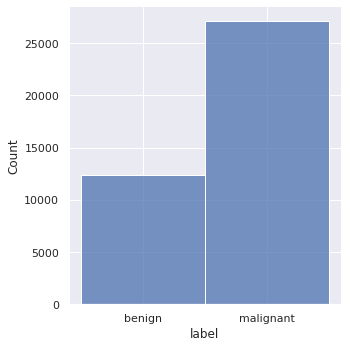

In [ ]:
# making a plot to see data distribution
# sns.figure()
sns.set_theme()
sns.displot(x='label', data=data)

The graph sows that most of the samples in our data have malignant tumors, and less have benign tumors

<AxesSubplot:xlabel='label', ylabel='count'>

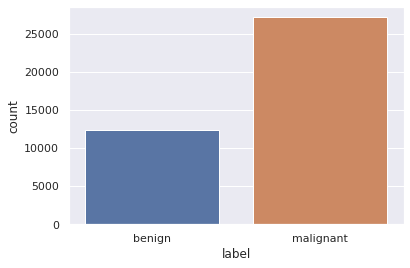

In [ ]:
sns.countplot(x=data['label'], data=data)

## Dataset Modelling for Deep Learning

We will model the data for our training, vaidation and testing sets. 

In [ ]:
# sorting out training, validation and testing images
test_images = data.groupby(by='label').sample(4000)
train_images = data.drop(test_images.index).reset_index(drop=True)
test_images = test_images.reset_index(drop=True)

In [ ]:
# making splits of training & validation datasets
validation_images = train_images.sample(frac = 0.2)
train_images = train_images.drop(validation_images.index).reset_index(drop=True)
validation_images = validation_images.reset_index(drop=True)

In [ ]:
print('Total training images: % s' % str(train_images.shape[0]))
print('Total validation images: % s' % str(validation_images.shape[0]))
print('Total testing images: % s' % str(test_images.shape[0]))

Total training images: 25236
Total validation images: 6309
Total testing images: 8000


In [ ]:
train_images['set'] = 'train'
validation_images['set'] = 'validation'
test_images['set'] = 'test'

In [ ]:
new_data = pd.concat([train_images, validation_images, test_images])
new_data.head(5)

,fold,mag,grp,path,label,label_int,filename,set
0,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1,SOB_B_A-14-22549AB-100-003.png,train
1,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1,SOB_B_A-14-22549AB-100-004.png,train
2,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1,SOB_B_A-14-22549AB-100-005.png,train
3,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1,SOB_B_A-14-22549AB-100-008.png,train
4,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1,SOB_B_A-14-22549AB-100-009.png,train


### Visualizing Train, Validation & Test Splits

<AxesSubplot:xlabel='label', ylabel='count'>

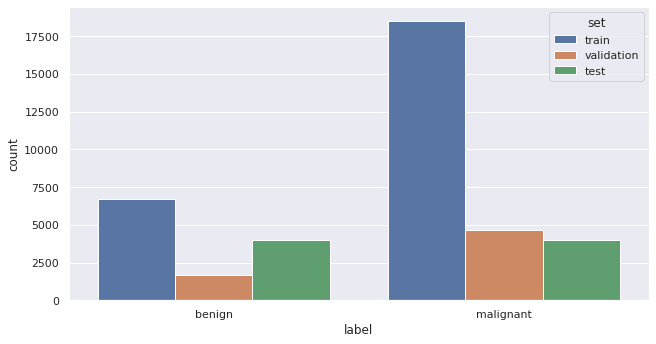

In [ ]:
sns.set(rc={'figure.figsize':(10.4, 5.4)})
sns.countplot(x=new_data['label'], hue=new_data['set'])

## Unsampling Data

In [ ]:
max_count = np.max(train_images.label.value_counts())
min_count = np.min(train_images.label.value_counts())
train_images = train_images.groupby('label').sample(n=max_count, replace=True)
train_images = train_images.reset_index(drop=True)

In [ ]:
train_images.head(5)

,fold,mag,grp,path,label,label_int,filename,set
0,2,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1,SOB_B_PT-14-22704-100-024.png,train
1,3,400,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1,SOB_B_A-14-22549AB-400-020.png,train
2,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1,SOB_B_PT-14-22704-100-003.png,train
3,4,400,test,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1,SOB_B_TA-14-16184CD-400-024.png,train
4,3,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1,SOB_B_TA-14-16184-100-009.png,train


## Making the Deep Learning Model

In [ ]:
model_handle_map = {"efficientnetv2-b0": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2", 
                   "inception_v3": "https://tfhub.dev/google/imagenet/inception_v3/feature_vector/4"}
model_image_size = {"efficientnetv2-b0": 224, 
                   "inception_v3": 299}

In [ ]:
# function to decode a PNG image into a tf tensor
def load_image(path, label):
    image = tf.io.read_file(path)
    image = tf.io.decode_png(image, channels=3)
    return image, label

# reshaping the image between 0 and 1
def image_reshape(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [224, 224] / 255)
    return image, label

# image argumentation for faster model training
def argument_image(image):
    transform = A.Compose([A.HorizontalFlip(p = 0.5), 
                          A.Rotate(p = 0.5, limit = 15), 
                          A.RandomBrightnessContrast(p=0.5, brightness_limit=(-0.2, 0.2), contrast_limit=(-0.1, 0.1), 
                                                    brightness_by_max=True),
                           A.RandomResizedCrop(p=0.8, height=IMG_SIZE, width=IMG_SIZE, 
                                              scale=(0.9, 1.1), ratio=(0.05, 1.1), interpolation=0),
                           A.Blur(blur_limit = (1, 1))
                           
                          ])
    
    data = {"image": image}
    argumented_data = transform(**data)
    argumented_image = argumented_data["image"]
    argumented_image = tf.cast(argumented_image, tf.float32)
    argumented_image = tf.image.resize(argumented_image, [IMG_SIZE, IMG_SIZE]) / 255
    
    return argumented_image

def argumentor_function(image, label):
    argumented_image = tf.numpy_function(func = argument_image, inp=[image], Tout = tf.float32)
    return argumented_image, label


# function to view sample of images
def view_image(ds, col = 8, row = 2, size=(25, 10)):
    plt.figure(figsize=(10, 5))
    plt.subplots_adjust(wspace = 0.05, hspace = 0.15)
    for images, labels in ds.take(1):
        for i in range(col * row):
            ax = plt.subplot(row, col, i + 1)
            shape = str(images[i].numpy().shape)
            plt.imshow(images[i].numpy())
            plt.title(class_names[labels[i].numpy()])
            plt.axis("off") 
    plt.tight_layout
    return None

def view_model_predictions():
    plt.figure(figsize = (30, 8))
    plt.rcParams.update({'font.size': 10})
    plt.subplots_adjust(wspace = 0.05, hspace = 0.15)
    for i in range(30):
        ax = plt.subplot(3, 10, i + 1)
        shape = str(test_image[i].numpy().shape)
        plt.imshow(test_image[i].numpy())
        plt.title(predicted_label[i][0])
        plt.axis("off") 
        plt.tight_layout
    return None

# making a function to calculate & show model history
def model_hist(history):
    accuracy = history['accuracy']
    loss = history['loss']
    val_accuracy = history['val_accuracy']
    val_loss = history['val_loss']
    
    # setting the epochs
    n_epochs = range(len(history['loss']))
    
    # saving models logs
    # csv_logger = CSVLogger('cnn_model_logs.csv', append=True)
    
    # making plots for accuracy 
    plt.figure(figsize=(16, 5))
    plt.subplot(1, 2, 1)
    plt.plot(n_epochs, accuracy, label='training accuracy')
    plt.plot(n_epochs, val_accuracy, label='validation accuracy')
    plt.legend()
    
    # making plots for loss
    plt.figure(figsize=(16, 5))
    plt.subplot(1, 2, 2)
    plt.plot(n_epochs, loss, label='training loss (binary crossentropy)')
    plt.plot(n_epochs, val_loss, label='validation loss (binary crossentropy)')
    plt.legend()
    
    return None

# function for decoding a test image
def decode_test_img(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [224, 224])
    return image

# function for building a NN
def make_nn_model(image_size):
    print('Making our deep cnn model.....')
    cnn_model = keras.Sequential([
        layers.InputLayer(input_shape=(image_size, image_size, 3)),
        hub.KerasLayer(model_handle, trainable=True, name='base'),
        layers.Dense(512, activation='relu', name='fc1'),
        layers.BatchNormalization(),
        layers.Dropout(0.4, name='dropout'),
        layers.Dense(128, activation='relu', name='fc2'),
        layers.BatchNormalization(),
        # layers.Dropout(0.4, name='dropout2'),
        layers.Dense(1, activation='sigmoid', name='output')
    ], name=model_name)
    
    cnn_model.build((None, image_size, image_size, 3))
    cnn_model.summary()
    print('model built!')
    return cnn_model

In [ ]:
# defining model configuration parameters
model_name = "efficientnetv2-b0"
# model_name = "inception_v3"
model_handle = model_handle_map.get(model_name)
IMG_SIZE = model_image_size.get(model_name, 224)
BATCH_SIZE = 64
EPOCHS = 12
sample_size = len(train_images)

print(f"Selected model: {model_name} : {model_handle}")
print(f"Input size of model: {IMG_SIZE}")

Selected model: efficientnetv2-b0 : https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2
Input size of model: 224


In [ ]:
IMG_SIZE

224

## Loading the Dataset

We have defined the model parameters + configuration in above sections. Now we define and load the dataset in our memory. We will define 2 datasets, train & valid. 

In [ ]:
(image_dir + train_images.path)[0]

'../input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-22704/100X/SOB_B_PT-14-22704-100-024.png'

In [ ]:
# loading the train & validation dataets
load_train = tf.data.Dataset.from_tensor_slices((image_dir + train_images.path, 
                                                train_images.label_int))

load_valid = tf.data.Dataset.from_tensor_slices((image_dir + validation_images.path, 
                                                validation_images.label_int))

In [ ]:
load_train

<TensorSliceDataset shapes: ((), ()), types: (tf.string, tf.int64)>

In [ ]:
train_dataset = (
                load_train.shuffle(len(train_images))
                .map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
                .map(partial(argumentor_function), num_parallel_calls=tf.data.experimental.AUTOTUNE)
                .batch(BATCH_SIZE)
                .prefetch(tf.data.experimental.AUTOTUNE)
                )
val_dataset = (
                load_valid.shuffle(len(validation_images))
                .map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
                .map(partial(argumentor_function), num_parallel_calls=tf.data.experimental.AUTOTUNE)
                .batch(BATCH_SIZE)
                .prefetch(tf.data.experimental.AUTOTUNE)
                )

train_dataset, val_dataset

(<PrefetchDataset shapes: (<unknown>, (None,)), types: (tf.float32, tf.int64)>,
 <PrefetchDataset shapes: (<unknown>, (None,)), types: (tf.float32, tf.int64)>)

In [ ]:
# checking the path of images
train_images.path[1]

'BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/400X/SOB_B_A-14-22549AB-400-020.png'

Time Taken: 4.825 seconds


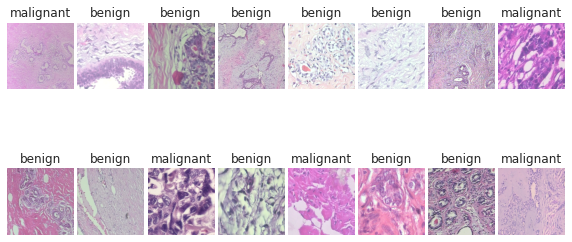

In [ ]:
start = time.time()
view_image(train_dataset)
end = time.time()
print('Time Taken: %.3f seconds' % (end-start))

Time Taken: 3.224 seconds


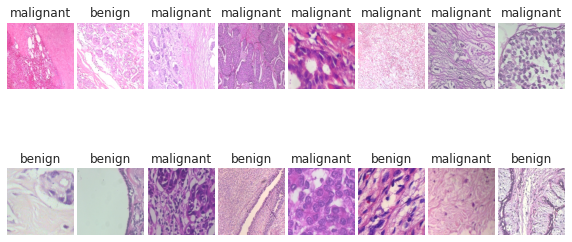

In [ ]:
start = time.time()
view_image(val_dataset)
end = time.time()
print('Time Taken: %.3f seconds' % (end-start))

We have successfully loaded the images, preprocessed them, made image argumentations and visualized the images of what they look like. 

## Deep Learning Model Training

This is the step whwre we train our deep learning model. We have defined the model configuration, dataset modelling, data loading and preparation.   

In [ ]:
print('Size of Image being used: %d' % IMG_SIZE)

Size of Image being used: 224


In [ ]:
# starting a new sesion for TF
image_size = 224
tf.keras.backend.clear_session()
model_nn = make_nn_model(IMG_SIZE)

# making model checkpoints
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('model.h5', save_best_only=True)

# model logs
csv_logger = CSVLogger('cnn_model_logs.csv', append=True)

metrics = ['accuracy', Precision(name='Precision'), Recall(name='Recall')]

# compiling the model
model_nn.compile(loss='binary_crossentropy', optimizer='adam', metrics=metrics)

# fit the model
train_history = model_nn.fit(train_dataset, epochs=10, batch_size=BATCH_SIZE, verbose=1, 
                             callbacks=[model_checkpoint, csv_logger], validation_data=val_dataset)

Making our deep cnn model.....


Model: "efficientnetv2-b0"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
base (KerasLayer)            (None, 1280)              5919312   
_________________________________________________________________
fc1 (Dense)                  (None, 512)               655872    
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
fc2 (Dense)                  (None, 128)               65664     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
output (Dense)               (None, 1)           

  1/579 [..............................] - ETA: 3:27:59 - loss: 1.0522 - accuracy: 0.4062 - Precision: 0.4333 - Recall: 0.3824

  2/579 [..............................] - ETA: 14:36 - loss: 0.9920 - accuracy: 0.4336 - Precision: 0.4380 - Recall: 0.4089  

  3/579 [..............................] - ETA: 14:10 - loss: 0.9461 - accuracy: 0.4661 - Precision: 0.4640 - Recall: 0.4447

  4/579 [..............................] - ETA: 14:26 - loss: 0.9008 - accuracy: 0.4941 - Precision: 0.4924 - Recall: 0.4664

  5/579 [..............................] - ETA: 15:02 - loss: 0.8662 - accuracy: 0.5172 - Precision: 0.5205 - Recall: 0.4866

  6/579 [..............................] - ETA: 14:59 - loss: 0.8401 - accuracy: 0.5352 - Precision: 0.5439 - Recall: 0.5036

  7/579 [..............................] - ETA: 14:34 - loss: 0.8141 - accuracy: 0.5525 - Precision: 0.5639 - Recall: 0.5201

  8/579 [..............................] - ETA: 14:18 - loss: 0.7914 - accuracy: 0.5674 - Precision: 0.5800 - Recall: 0.5343

  9/579 [..............................] - ETA: 14:30 - loss: 0.7734 - accuracy: 0.5803 - Precision: 0.5939 - Recall: 0.5463

 10/579 [..............................] - ETA: 14:12 - loss: 0.7587 - accuracy: 0.5920 - Precision: 0.6061 - Recall: 0.5574

 11/579 [..............................] - ETA: 14:13 - loss: 0.7448 - accuracy: 0.6024 - Precision: 0.6170 - Recall: 0.5670

 12/579 [..............................] - ETA: 13:58 - loss: 0.7317 - accuracy: 0.6118 - Precision: 0.6266 - Recall: 0.5759

 13/579 [..............................] - ETA: 13:42 - loss: 0.7204 - accuracy: 0.6205 - Precision: 0.6354 - Recall: 0.5841

 14/579 [..............................] - ETA: 13:35 - loss: 0.7095 - accuracy: 0.6285 - Precision: 0.6436 - Recall: 0.5913

 15/579 [..............................] - ETA: 13:31 - loss: 0.6993 - accuracy: 0.6359 - Precision: 0.6506 - Recall: 0.5983

 16/579 [..............................] - ETA: 13:29 - loss: 0.6898 - accuracy: 0.6429 - Precision: 0.6573 - Recall: 0.6050

 17/579 [..............................] - ETA: 13:30 - loss: 0.6816 - accuracy: 0.6492 - Precision: 0.6631 - Recall: 0.6113

 18/579 [..............................] - ETA: 13:26 - loss: 0.6741 - accuracy: 0.6548 - Precision: 0.6684 - Recall: 0.6168

 19/579 [..............................] - ETA: 13:18 - loss: 0.6673 - accuracy: 0.6598 - Precision: 0.6733 - Recall: 0.6216

 20/579 [>.............................] - ETA: 13:12 - loss: 0.6610 - accuracy: 0.6645 - Precision: 0.6778 - Recall: 0.6262

 21/579 [>.............................] - ETA: 13:09 - loss: 0.6548 - accuracy: 0.6689 - Precision: 0.6821 - Recall: 0.6306

 22/579 [>.............................] - ETA: 13:03 - loss: 0.6487 - accuracy: 0.6732 - Precision: 0.6861 - Recall: 0.6348

 23/579 [>.............................] - ETA: 13:00 - loss: 0.6429 - accuracy: 0.6773 - Precision: 0.6900 - Recall: 0.6389

 24/579 [>.............................] - ETA: 13:03 - loss: 0.6371 - accuracy: 0.6812 - Precision: 0.6937 - Recall: 0.6428

 25/579 [>.............................] - ETA: 13:03 - loss: 0.6314 - accuracy: 0.6849 - Precision: 0.6973 - Recall: 0.6465

 26/579 [>.............................] - ETA: 12:58 - loss: 0.6259 - accuracy: 0.6885 - Precision: 0.7007 - Recall: 0.6501

 27/579 [>.............................] - ETA: 12:55 - loss: 0.6209 - accuracy: 0.6918 - Precision: 0.7041 - Recall: 0.6533

 28/579 [>.............................] - ETA: 13:00 - loss: 0.6160 - accuracy: 0.6950 - Precision: 0.7073 - Recall: 0.6564

 29/579 [>.............................] - ETA: 12:57 - loss: 0.6113 - accuracy: 0.6981 - Precision: 0.7105 - Recall: 0.6594

 30/579 [>.............................] - ETA: 12:54 - loss: 0.6066 - accuracy: 0.7012 - Precision: 0.7136 - Recall: 0.6624

 31/579 [>.............................] - ETA: 12:55 - loss: 0.6020 - accuracy: 0.7041 - Precision: 0.7165 - Recall: 0.6653

 32/579 [>.............................] - ETA: 12:50 - loss: 0.5975 - accuracy: 0.7070 - Precision: 0.7194 - Recall: 0.6682

 33/579 [>.............................] - ETA: 12:49 - loss: 0.5932 - accuracy: 0.7097 - Precision: 0.7222 - Recall: 0.6710

 34/579 [>.............................] - ETA: 12:45 - loss: 0.5890 - accuracy: 0.7123 - Precision: 0.7249 - Recall: 0.6737

 35/579 [>.............................] - ETA: 12:44 - loss: 0.5851 - accuracy: 0.7149 - Precision: 0.7274 - Recall: 0.6763

 36/579 [>.............................] - ETA: 12:41 - loss: 0.5812 - accuracy: 0.7173 - Precision: 0.7298 - Recall: 0.6789

 37/579 [>.............................] - ETA: 12:40 - loss: 0.5774 - accuracy: 0.7197 - Precision: 0.7321 - Recall: 0.6814

 38/579 [>.............................] - ETA: 12:37 - loss: 0.5736 - accuracy: 0.7220 - Precision: 0.7344 - Recall: 0.6838

 39/579 [=>............................] - ETA: 12:32 - loss: 0.5699 - accuracy: 0.7242 - Precision: 0.7366 - Recall: 0.6862

 40/579 [=>............................] - ETA: 12:29 - loss: 0.5663 - accuracy: 0.7264 - Precision: 0.7388 - Recall: 0.6885

 41/579 [=>............................] - ETA: 12:27 - loss: 0.5627 - accuracy: 0.7286 - Precision: 0.7409 - Recall: 0.6908

 42/579 [=>............................] - ETA: 12:25 - loss: 0.5593 - accuracy: 0.7307 - Precision: 0.7430 - Recall: 0.6932

 43/579 [=>............................] - ETA: 12:21 - loss: 0.5559 - accuracy: 0.7328 - Precision: 0.7450 - Recall: 0.6954

 44/579 [=>............................] - ETA: 12:20 - loss: 0.5524 - accuracy: 0.7348 - Precision: 0.7470 - Recall: 0.6977

 45/579 [=>............................] - ETA: 12:16 - loss: 0.5491 - accuracy: 0.7368 - Precision: 0.7489 - Recall: 0.6998

 46/579 [=>............................] - ETA: 12:15 - loss: 0.5458 - accuracy: 0.7388 - Precision: 0.7508 - Recall: 0.7020

 47/579 [=>............................] - ETA: 12:11 - loss: 0.5426 - accuracy: 0.7406 - Precision: 0.7527 - Recall: 0.7040

 48/579 [=>............................] - ETA: 12:07 - loss: 0.5395 - accuracy: 0.7425 - Precision: 0.7545 - Recall: 0.7060

 49/579 [=>............................] - ETA: 12:04 - loss: 0.5364 - accuracy: 0.7443 - Precision: 0.7563 - Recall: 0.7080

 50/579 [=>............................] - ETA: 12:05 - loss: 0.5333 - accuracy: 0.7461 - Precision: 0.7581 - Recall: 0.7100

 51/579 [=>............................] - ETA: 12:02 - loss: 0.5304 - accuracy: 0.7478 - Precision: 0.7598 - Recall: 0.7119

 52/579 [=>............................] - ETA: 11:59 - loss: 0.5274 - accuracy: 0.7495 - Precision: 0.7615 - Recall: 0.7138

 53/579 [=>............................] - ETA: 12:02 - loss: 0.5245 - accuracy: 0.7512 - Precision: 0.7631 - Recall: 0.7157

 54/579 [=>............................] - ETA: 11:59 - loss: 0.5218 - accuracy: 0.7528 - Precision: 0.7647 - Recall: 0.7176

 55/579 [=>............................] - ETA: 11:57 - loss: 0.5191 - accuracy: 0.7544 - Precision: 0.7662 - Recall: 0.7194

 56/579 [=>............................] - ETA: 11:55 - loss: 0.5165 - accuracy: 0.7559 - Precision: 0.7677 - Recall: 0.7211

 57/579 [=>............................] - ETA: 11:53 - loss: 0.5139 - accuracy: 0.7574 - Precision: 0.7692 - Recall: 0.7228

 58/579 [==>...........................] - ETA: 11:52 - loss: 0.5114 - accuracy: 0.7589 - Precision: 0.7707 - Recall: 0.7245

 59/579 [==>...........................] - ETA: 11:50 - loss: 0.5089 - accuracy: 0.7604 - Precision: 0.7721 - Recall: 0.7261

 60/579 [==>...........................] - ETA: 11:48 - loss: 0.5065 - accuracy: 0.7618 - Precision: 0.7735 - Recall: 0.7278

 61/579 [==>...........................] - ETA: 11:45 - loss: 0.5041 - accuracy: 0.7632 - Precision: 0.7749 - Recall: 0.7293

 62/579 [==>...........................] - ETA: 11:42 - loss: 0.5017 - accuracy: 0.7645 - Precision: 0.7763 - Recall: 0.7309

 63/579 [==>...........................] - ETA: 11:40 - loss: 0.4994 - accuracy: 0.7659 - Precision: 0.7776 - Recall: 0.7325

 64/579 [==>...........................] - ETA: 11:37 - loss: 0.4971 - accuracy: 0.7672 - Precision: 0.7789 - Recall: 0.7340

 65/579 [==>...........................] - ETA: 11:35 - loss: 0.4948 - accuracy: 0.7686 - Precision: 0.7802 - Recall: 0.7355

 66/579 [==>...........................] - ETA: 11:31 - loss: 0.4926 - accuracy: 0.7698 - Precision: 0.7815 - Recall: 0.7370

 67/579 [==>...........................] - ETA: 11:31 - loss: 0.4904 - accuracy: 0.7711 - Precision: 0.7827 - Recall: 0.7385

 68/579 [==>...........................] - ETA: 11:28 - loss: 0.4882 - accuracy: 0.7723 - Precision: 0.7839 - Recall: 0.7399

 69/579 [==>...........................] - ETA: 11:26 - loss: 0.4861 - accuracy: 0.7736 - Precision: 0.7850 - Recall: 0.7413

 70/579 [==>...........................] - ETA: 11:25 - loss: 0.4840 - accuracy: 0.7748 - Precision: 0.7862 - Recall: 0.7426

 71/579 [==>...........................] - ETA: 11:22 - loss: 0.4819 - accuracy: 0.7759 - Precision: 0.7873 - Recall: 0.7440

 72/579 [==>...........................] - ETA: 11:21 - loss: 0.4799 - accuracy: 0.7771 - Precision: 0.7884 - Recall: 0.7453

 73/579 [==>...........................] - ETA: 11:17 - loss: 0.4779 - accuracy: 0.7782 - Precision: 0.7895 - Recall: 0.7466

 74/579 [==>...........................] - ETA: 11:15 - loss: 0.4760 - accuracy: 0.7793 - Precision: 0.7905 - Recall: 0.7478

 75/579 [==>...........................] - ETA: 11:13 - loss: 0.4741 - accuracy: 0.7804 - Precision: 0.7916 - Recall: 0.7491

 76/579 [==>...........................] - ETA: 11:13 - loss: 0.4722 - accuracy: 0.7815 - Precision: 0.7926 - Recall: 0.7503

 77/579 [==>...........................] - ETA: 11:10 - loss: 0.4703 - accuracy: 0.7825 - Precision: 0.7936 - Recall: 0.7514

 78/579 [===>..........................] - ETA: 11:09 - loss: 0.4685 - accuracy: 0.7835 - Precision: 0.7945 - Recall: 0.7525

 79/579 [===>..........................] - ETA: 11:09 - loss: 0.4667 - accuracy: 0.7845 - Precision: 0.7954 - Recall: 0.7536

 80/579 [===>..........................] - ETA: 11:08 - loss: 0.4649 - accuracy: 0.7854 - Precision: 0.7964 - Recall: 0.7548

 81/579 [===>..........................] - ETA: 11:05 - loss: 0.4632 - accuracy: 0.7864 - Precision: 0.7973 - Recall: 0.7558

 82/579 [===>..........................] - ETA: 11:03 - loss: 0.4615 - accuracy: 0.7873 - Precision: 0.7981 - Recall: 0.7569

 83/579 [===>..........................] - ETA: 11:02 - loss: 0.4598 - accuracy: 0.7883 - Precision: 0.7990 - Recall: 0.7579

 84/579 [===>..........................] - ETA: 11:01 - loss: 0.4581 - accuracy: 0.7892 - Precision: 0.7999 - Recall: 0.7589

 85/579 [===>..........................] - ETA: 10:58 - loss: 0.4564 - accuracy: 0.7901 - Precision: 0.8008 - Recall: 0.7599

 86/579 [===>..........................] - ETA: 10:56 - loss: 0.4548 - accuracy: 0.7910 - Precision: 0.8017 - Recall: 0.7609

 87/579 [===>..........................] - ETA: 10:55 - loss: 0.4532 - accuracy: 0.7918 - Precision: 0.8025 - Recall: 0.7618

 88/579 [===>..........................] - ETA: 10:52 - loss: 0.4516 - accuracy: 0.7927 - Precision: 0.8034 - Recall: 0.7628

 89/579 [===>..........................] - ETA: 10:50 - loss: 0.4501 - accuracy: 0.7935 - Precision: 0.8042 - Recall: 0.7637

 90/579 [===>..........................] - ETA: 10:47 - loss: 0.4486 - accuracy: 0.7943 - Precision: 0.8050 - Recall: 0.7646

 91/579 [===>..........................] - ETA: 10:45 - loss: 0.4471 - accuracy: 0.7951 - Precision: 0.8058 - Recall: 0.7655

 92/579 [===>..........................] - ETA: 10:43 - loss: 0.4457 - accuracy: 0.7959 - Precision: 0.8066 - Recall: 0.7664

 93/579 [===>..........................] - ETA: 10:42 - loss: 0.4442 - accuracy: 0.7967 - Precision: 0.8074 - Recall: 0.7673

 94/579 [===>..........................] - ETA: 10:40 - loss: 0.4428 - accuracy: 0.7975 - Precision: 0.8081 - Recall: 0.7681

 95/579 [===>..........................] - ETA: 10:39 - loss: 0.4414 - accuracy: 0.7983 - Precision: 0.8089 - Recall: 0.7690

 96/579 [===>..........................] - ETA: 10:36 - loss: 0.4400 - accuracy: 0.7991 - Precision: 0.8097 - Recall: 0.7698

 97/579 [====>.........................] - ETA: 10:34 - loss: 0.4386 - accuracy: 0.7998 - Precision: 0.8104 - Recall: 0.7707

 98/579 [====>.........................] - ETA: 10:32 - loss: 0.4372 - accuracy: 0.8006 - Precision: 0.8112 - Recall: 0.7715

 99/579 [====>.........................] - ETA: 10:30 - loss: 0.4358 - accuracy: 0.8013 - Precision: 0.8119 - Recall: 0.7724

100/579 [====>.........................] - ETA: 10:28 - loss: 0.4345 - accuracy: 0.8020 - Precision: 0.8126 - Recall: 0.7732

101/579 [====>.........................] - ETA: 10:25 - loss: 0.4331 - accuracy: 0.8027 - Precision: 0.8133 - Recall: 0.7740

102/579 [====>.........................] - ETA: 10:25 - loss: 0.4318 - accuracy: 0.8034 - Precision: 0.8139 - Recall: 0.7749

103/579 [====>.........................] - ETA: 10:22 - loss: 0.4306 - accuracy: 0.8041 - Precision: 0.8146 - Recall: 0.7757

104/579 [====>.........................] - ETA: 10:20 - loss: 0.4293 - accuracy: 0.8048 - Precision: 0.8153 - Recall: 0.7765

105/579 [====>.........................] - ETA: 10:18 - loss: 0.4280 - accuracy: 0.8055 - Precision: 0.8159 - Recall: 0.7773

106/579 [====>.........................] - ETA: 10:17 - loss: 0.4267 - accuracy: 0.8062 - Precision: 0.8165 - Recall: 0.7781

107/579 [====>.........................] - ETA: 10:17 - loss: 0.4255 - accuracy: 0.8068 - Precision: 0.8172 - Recall: 0.7789

108/579 [====>.........................] - ETA: 10:14 - loss: 0.4243 - accuracy: 0.8075 - Precision: 0.8178 - Recall: 0.7797

109/579 [====>.........................] - ETA: 10:12 - loss: 0.4230 - accuracy: 0.8081 - Precision: 0.8184 - Recall: 0.7805

110/579 [====>.........................] - ETA: 10:11 - loss: 0.4218 - accuracy: 0.8088 - Precision: 0.8190 - Recall: 0.7812

111/579 [====>.........................] - ETA: 10:09 - loss: 0.4206 - accuracy: 0.8094 - Precision: 0.8196 - Recall: 0.7820

112/579 [====>.........................] - ETA: 10:07 - loss: 0.4194 - accuracy: 0.8100 - Precision: 0.8202 - Recall: 0.7827

113/579 [====>.........................] - ETA: 10:05 - loss: 0.4183 - accuracy: 0.8106 - Precision: 0.8208 - Recall: 0.7835

114/579 [====>.........................] - ETA: 10:03 - loss: 0.4171 - accuracy: 0.8112 - Precision: 0.8213 - Recall: 0.7842

115/579 [====>.........................] - ETA: 10:01 - loss: 0.4159 - accuracy: 0.8118 - Precision: 0.8219 - Recall: 0.7849

116/579 [=====>........................] - ETA: 9:59 - loss: 0.4148 - accuracy: 0.8124 - Precision: 0.8224 - Recall: 0.7857 

117/579 [=====>........................] - ETA: 9:57 - loss: 0.4137 - accuracy: 0.8130 - Precision: 0.8229 - Recall: 0.7864

118/579 [=====>........................] - ETA: 9:55 - loss: 0.4126 - accuracy: 0.8136 - Precision: 0.8235 - Recall: 0.7871

119/579 [=====>........................] - ETA: 9:53 - loss: 0.4115 - accuracy: 0.8142 - Precision: 0.8240 - Recall: 0.7878

120/579 [=====>........................] - ETA: 9:51 - loss: 0.4104 - accuracy: 0.8147 - Precision: 0.8245 - Recall: 0.7884

121/579 [=====>........................] - ETA: 9:51 - loss: 0.4093 - accuracy: 0.8153 - Precision: 0.8250 - Recall: 0.7891

122/579 [=====>........................] - ETA: 9:49 - loss: 0.4082 - accuracy: 0.8158 - Precision: 0.8255 - Recall: 0.7897

123/579 [=====>........................] - ETA: 9:47 - loss: 0.4072 - accuracy: 0.8164 - Precision: 0.8260 - Recall: 0.7904

124/579 [=====>........................] - ETA: 9:45 - loss: 0.4062 - accuracy: 0.8169 - Precision: 0.8265 - Recall: 0.7910

125/579 [=====>........................] - ETA: 9:44 - loss: 0.4051 - accuracy: 0.8174 - Precision: 0.8270 - Recall: 0.7916

126/579 [=====>........................] - ETA: 9:42 - loss: 0.4041 - accuracy: 0.8179 - Precision: 0.8275 - Recall: 0.7923

127/579 [=====>........................] - ETA: 9:40 - loss: 0.4031 - accuracy: 0.8185 - Precision: 0.8280 - Recall: 0.7929

128/579 [=====>........................] - ETA: 9:38 - loss: 0.4021 - accuracy: 0.8190 - Precision: 0.8285 - Recall: 0.7935

129/579 [=====>........................] - ETA: 9:37 - loss: 0.4011 - accuracy: 0.8195 - Precision: 0.8290 - Recall: 0.7941

130/579 [=====>........................] - ETA: 9:35 - loss: 0.4001 - accuracy: 0.8200 - Precision: 0.8295 - Recall: 0.7947

131/579 [=====>........................] - ETA: 9:34 - loss: 0.3991 - accuracy: 0.8205 - Precision: 0.8300 - Recall: 0.7953

132/579 [=====>........................] - ETA: 9:32 - loss: 0.3982 - accuracy: 0.8210 - Precision: 0.8304 - Recall: 0.7959

133/579 [=====>........................] - ETA: 9:30 - loss: 0.3972 - accuracy: 0.8215 - Precision: 0.8309 - Recall: 0.7965

134/579 [=====>........................] - ETA: 9:31 - loss: 0.3963 - accuracy: 0.8220 - Precision: 0.8313 - Recall: 0.7970

135/579 [=====>........................] - ETA: 9:28 - loss: 0.3953 - accuracy: 0.8225 - Precision: 0.8318 - Recall: 0.7976

136/579 [======>.......................] - ETA: 9:27 - loss: 0.3944 - accuracy: 0.8229 - Precision: 0.8322 - Recall: 0.7982

137/579 [======>.......................] - ETA: 9:25 - loss: 0.3935 - accuracy: 0.8234 - Precision: 0.8327 - Recall: 0.7987

138/579 [======>.......................] - ETA: 9:23 - loss: 0.3925 - accuracy: 0.8239 - Precision: 0.8331 - Recall: 0.7993

139/579 [======>.......................] - ETA: 9:22 - loss: 0.3916 - accuracy: 0.8244 - Precision: 0.8336 - Recall: 0.7999

140/579 [======>.......................] - ETA: 9:20 - loss: 0.3907 - accuracy: 0.8248 - Precision: 0.8340 - Recall: 0.8004

141/579 [======>.......................] - ETA: 9:19 - loss: 0.3898 - accuracy: 0.8253 - Precision: 0.8344 - Recall: 0.8010

142/579 [======>.......................] - ETA: 9:17 - loss: 0.3889 - accuracy: 0.8257 - Precision: 0.8349 - Recall: 0.8015

143/579 [======>.......................] - ETA: 9:16 - loss: 0.3880 - accuracy: 0.8262 - Precision: 0.8353 - Recall: 0.8021

144/579 [======>.......................] - ETA: 9:14 - loss: 0.3871 - accuracy: 0.8267 - Precision: 0.8357 - Recall: 0.8026

145/579 [======>.......................] - ETA: 9:12 - loss: 0.3863 - accuracy: 0.8271 - Precision: 0.8361 - Recall: 0.8032

146/579 [======>.......................] - ETA: 9:10 - loss: 0.3854 - accuracy: 0.8275 - Precision: 0.8365 - Recall: 0.8037

147/579 [======>.......................] - ETA: 9:08 - loss: 0.3846 - accuracy: 0.8280 - Precision: 0.8369 - Recall: 0.8042

148/579 [======>.......................] - ETA: 9:07 - loss: 0.3837 - accuracy: 0.8284 - Precision: 0.8373 - Recall: 0.8048

149/579 [======>.......................] - ETA: 9:06 - loss: 0.3829 - accuracy: 0.8289 - Precision: 0.8378 - Recall: 0.8053

150/579 [======>.......................] - ETA: 9:04 - loss: 0.3820 - accuracy: 0.8293 - Precision: 0.8382 - Recall: 0.8058

151/579 [======>.......................] - ETA: 9:02 - loss: 0.3812 - accuracy: 0.8297 - Precision: 0.8385 - Recall: 0.8063

152/579 [======>.......................] - ETA: 9:01 - loss: 0.3804 - accuracy: 0.8301 - Precision: 0.8389 - Recall: 0.8068

153/579 [======>.......................] - ETA: 8:59 - loss: 0.3796 - accuracy: 0.8305 - Precision: 0.8393 - Recall: 0.8073

154/579 [======>.......................] - ETA: 8:57 - loss: 0.3787 - accuracy: 0.8310 - Precision: 0.8397 - Recall: 0.8078

155/579 [=======>......................] - ETA: 8:56 - loss: 0.3779 - accuracy: 0.8314 - Precision: 0.8401 - Recall: 0.8083

156/579 [=======>......................] - ETA: 8:54 - loss: 0.3771 - accuracy: 0.8318 - Precision: 0.8405 - Recall: 0.8088

157/579 [=======>......................] - ETA: 8:52 - loss: 0.3763 - accuracy: 0.8322 - Precision: 0.8408 - Recall: 0.8093

158/579 [=======>......................] - ETA: 8:51 - loss: 0.3755 - accuracy: 0.8326 - Precision: 0.8412 - Recall: 0.8098

159/579 [=======>......................] - ETA: 8:49 - loss: 0.3748 - accuracy: 0.8330 - Precision: 0.8416 - Recall: 0.8103

160/579 [=======>......................] - ETA: 8:48 - loss: 0.3740 - accuracy: 0.8334 - Precision: 0.8419 - Recall: 0.8108

161/579 [=======>......................] - ETA: 8:46 - loss: 0.3732 - accuracy: 0.8338 - Precision: 0.8423 - Recall: 0.8112

162/579 [=======>......................] - ETA: 8:45 - loss: 0.3724 - accuracy: 0.8341 - Precision: 0.8427 - Recall: 0.8117

163/579 [=======>......................] - ETA: 8:44 - loss: 0.3717 - accuracy: 0.8345 - Precision: 0.8430 - Recall: 0.8122

164/579 [=======>......................] - ETA: 8:42 - loss: 0.3709 - accuracy: 0.8349 - Precision: 0.8434 - Recall: 0.8126

165/579 [=======>......................] - ETA: 8:41 - loss: 0.3702 - accuracy: 0.8353 - Precision: 0.8437 - Recall: 0.8131

166/579 [=======>......................] - ETA: 8:39 - loss: 0.3695 - accuracy: 0.8356 - Precision: 0.8441 - Recall: 0.8135

167/579 [=======>......................] - ETA: 8:37 - loss: 0.3687 - accuracy: 0.8360 - Precision: 0.8445 - Recall: 0.8140

168/579 [=======>......................] - ETA: 8:36 - loss: 0.3680 - accuracy: 0.8364 - Precision: 0.8448 - Recall: 0.8144

169/579 [=======>......................] - ETA: 8:34 - loss: 0.3673 - accuracy: 0.8368 - Precision: 0.8451 - Recall: 0.8148

170/579 [=======>......................] - ETA: 8:32 - loss: 0.3665 - accuracy: 0.8371 - Precision: 0.8455 - Recall: 0.8153

171/579 [=======>......................] - ETA: 8:31 - loss: 0.3658 - accuracy: 0.8375 - Precision: 0.8458 - Recall: 0.8157

172/579 [=======>......................] - ETA: 8:29 - loss: 0.3651 - accuracy: 0.8378 - Precision: 0.8462 - Recall: 0.8162

173/579 [=======>......................] - ETA: 8:28 - loss: 0.3644 - accuracy: 0.8382 - Precision: 0.8465 - Recall: 0.8166

174/579 [========>.....................] - ETA: 8:26 - loss: 0.3637 - accuracy: 0.8386 - Precision: 0.8468 - Recall: 0.8170

175/579 [========>.....................] - ETA: 8:25 - loss: 0.3630 - accuracy: 0.8389 - Precision: 0.8472 - Recall: 0.8174

176/579 [========>.....................] - ETA: 8:23 - loss: 0.3623 - accuracy: 0.8393 - Precision: 0.8475 - Recall: 0.8179

177/579 [========>.....................] - ETA: 8:22 - loss: 0.3616 - accuracy: 0.8396 - Precision: 0.8478 - Recall: 0.8183

178/579 [========>.....................] - ETA: 8:20 - loss: 0.3609 - accuracy: 0.8400 - Precision: 0.8481 - Recall: 0.8187

179/579 [========>.....................] - ETA: 8:19 - loss: 0.3602 - accuracy: 0.8403 - Precision: 0.8485 - Recall: 0.8191

180/579 [========>.....................] - ETA: 8:17 - loss: 0.3595 - accuracy: 0.8406 - Precision: 0.8488 - Recall: 0.8196

181/579 [========>.....................] - ETA: 8:16 - loss: 0.3588 - accuracy: 0.8410 - Precision: 0.8491 - Recall: 0.8200

182/579 [========>.....................] - ETA: 8:14 - loss: 0.3582 - accuracy: 0.8413 - Precision: 0.8494 - Recall: 0.8204

183/579 [========>.....................] - ETA: 8:12 - loss: 0.3575 - accuracy: 0.8417 - Precision: 0.8498 - Recall: 0.8208

184/579 [========>.....................] - ETA: 8:10 - loss: 0.3568 - accuracy: 0.8420 - Precision: 0.8501 - Recall: 0.8212

185/579 [========>.....................] - ETA: 8:09 - loss: 0.3561 - accuracy: 0.8423 - Precision: 0.8504 - Recall: 0.8216

186/579 [========>.....................] - ETA: 8:07 - loss: 0.3555 - accuracy: 0.8427 - Precision: 0.8507 - Recall: 0.8220

187/579 [========>.....................] - ETA: 8:06 - loss: 0.3548 - accuracy: 0.8430 - Precision: 0.8510 - Recall: 0.8224

188/579 [========>.....................] - ETA: 8:05 - loss: 0.3541 - accuracy: 0.8433 - Precision: 0.8513 - Recall: 0.8228

189/579 [========>.....................] - ETA: 8:03 - loss: 0.3535 - accuracy: 0.8437 - Precision: 0.8516 - Recall: 0.8232

190/579 [========>.....................] - ETA: 8:01 - loss: 0.3528 - accuracy: 0.8440 - Precision: 0.8519 - Recall: 0.8236

191/579 [========>.....................] - ETA: 8:00 - loss: 0.3522 - accuracy: 0.8443 - Precision: 0.8522 - Recall: 0.8240

192/579 [========>.....................] - ETA: 7:59 - loss: 0.3515 - accuracy: 0.8446 - Precision: 0.8525 - Recall: 0.8244

193/579 [=========>....................] - ETA: 7:58 - loss: 0.3509 - accuracy: 0.8449 - Precision: 0.8528 - Recall: 0.8247

194/579 [=========>....................] - ETA: 7:56 - loss: 0.3503 - accuracy: 0.8452 - Precision: 0.8531 - Recall: 0.8251

195/579 [=========>....................] - ETA: 7:55 - loss: 0.3496 - accuracy: 0.8455 - Precision: 0.8534 - Recall: 0.8255

196/579 [=========>....................] - ETA: 7:53 - loss: 0.3490 - accuracy: 0.8459 - Precision: 0.8537 - Recall: 0.8259

197/579 [=========>....................] - ETA: 7:52 - loss: 0.3484 - accuracy: 0.8462 - Precision: 0.8540 - Recall: 0.8263

198/579 [=========>....................] - ETA: 7:50 - loss: 0.3478 - accuracy: 0.8465 - Precision: 0.8542 - Recall: 0.8266

199/579 [=========>....................] - ETA: 7:49 - loss: 0.3472 - accuracy: 0.8468 - Precision: 0.8545 - Recall: 0.8270

200/579 [=========>....................] - ETA: 7:47 - loss: 0.3466 - accuracy: 0.8471 - Precision: 0.8548 - Recall: 0.8274

201/579 [=========>....................] - ETA: 7:46 - loss: 0.3459 - accuracy: 0.8474 - Precision: 0.8551 - Recall: 0.8277

202/579 [=========>....................] - ETA: 7:45 - loss: 0.3453 - accuracy: 0.8477 - Precision: 0.8554 - Recall: 0.8281

203/579 [=========>....................] - ETA: 7:43 - loss: 0.3447 - accuracy: 0.8480 - Precision: 0.8556 - Recall: 0.8285

204/579 [=========>....................] - ETA: 7:41 - loss: 0.3441 - accuracy: 0.8483 - Precision: 0.8559 - Recall: 0.8288

205/579 [=========>....................] - ETA: 7:40 - loss: 0.3435 - accuracy: 0.8486 - Precision: 0.8562 - Recall: 0.8292

206/579 [=========>....................] - ETA: 7:38 - loss: 0.3429 - accuracy: 0.8488 - Precision: 0.8565 - Recall: 0.8295

207/579 [=========>....................] - ETA: 7:37 - loss: 0.3423 - accuracy: 0.8491 - Precision: 0.8567 - Recall: 0.8299

208/579 [=========>....................] - ETA: 7:36 - loss: 0.3418 - accuracy: 0.8494 - Precision: 0.8570 - Recall: 0.8302

209/579 [=========>....................] - ETA: 7:34 - loss: 0.3412 - accuracy: 0.8497 - Precision: 0.8573 - Recall: 0.8306

210/579 [=========>....................] - ETA: 7:33 - loss: 0.3406 - accuracy: 0.8500 - Precision: 0.8575 - Recall: 0.8309

211/579 [=========>....................] - ETA: 7:31 - loss: 0.3400 - accuracy: 0.8503 - Precision: 0.8578 - Recall: 0.8313

212/579 [=========>....................] - ETA: 7:30 - loss: 0.3394 - accuracy: 0.8506 - Precision: 0.8581 - Recall: 0.8316

213/579 [==========>...................] - ETA: 7:28 - loss: 0.3389 - accuracy: 0.8509 - Precision: 0.8583 - Recall: 0.8320

214/579 [==========>...................] - ETA: 7:27 - loss: 0.3383 - accuracy: 0.8511 - Precision: 0.8586 - Recall: 0.8323

215/579 [==========>...................] - ETA: 7:25 - loss: 0.3377 - accuracy: 0.8514 - Precision: 0.8588 - Recall: 0.8326

216/579 [==========>...................] - ETA: 7:24 - loss: 0.3372 - accuracy: 0.8517 - Precision: 0.8591 - Recall: 0.8330

217/579 [==========>...................] - ETA: 7:22 - loss: 0.3366 - accuracy: 0.8520 - Precision: 0.8593 - Recall: 0.8333

218/579 [==========>...................] - ETA: 7:21 - loss: 0.3361 - accuracy: 0.8522 - Precision: 0.8596 - Recall: 0.8336

219/579 [==========>...................] - ETA: 7:19 - loss: 0.3355 - accuracy: 0.8525 - Precision: 0.8598 - Recall: 0.8339

220/579 [==========>...................] - ETA: 7:18 - loss: 0.3350 - accuracy: 0.8528 - Precision: 0.8601 - Recall: 0.8343

221/579 [==========>...................] - ETA: 7:17 - loss: 0.3344 - accuracy: 0.8530 - Precision: 0.8603 - Recall: 0.8346

222/579 [==========>...................] - ETA: 7:16 - loss: 0.3339 - accuracy: 0.8533 - Precision: 0.8606 - Recall: 0.8349

223/579 [==========>...................] - ETA: 7:14 - loss: 0.3334 - accuracy: 0.8536 - Precision: 0.8608 - Recall: 0.8352

224/579 [==========>...................] - ETA: 7:12 - loss: 0.3328 - accuracy: 0.8538 - Precision: 0.8611 - Recall: 0.8355

225/579 [==========>...................] - ETA: 7:11 - loss: 0.3323 - accuracy: 0.8541 - Precision: 0.8613 - Recall: 0.8358

226/579 [==========>...................] - ETA: 7:10 - loss: 0.3318 - accuracy: 0.8543 - Precision: 0.8616 - Recall: 0.8361

227/579 [==========>...................] - ETA: 7:08 - loss: 0.3313 - accuracy: 0.8546 - Precision: 0.8618 - Recall: 0.8364

228/579 [==========>...................] - ETA: 7:07 - loss: 0.3307 - accuracy: 0.8549 - Precision: 0.8620 - Recall: 0.8368

229/579 [==========>...................] - ETA: 7:06 - loss: 0.3302 - accuracy: 0.8551 - Precision: 0.8623 - Recall: 0.8371

230/579 [==========>...................] - ETA: 7:04 - loss: 0.3297 - accuracy: 0.8554 - Precision: 0.8625 - Recall: 0.8374

231/579 [==========>...................] - ETA: 7:03 - loss: 0.3292 - accuracy: 0.8556 - Precision: 0.8627 - Recall: 0.8377

232/579 [===========>..................] - ETA: 7:01 - loss: 0.3287 - accuracy: 0.8559 - Precision: 0.8630 - Recall: 0.8379

233/579 [===========>..................] - ETA: 7:00 - loss: 0.3282 - accuracy: 0.8561 - Precision: 0.8632 - Recall: 0.8382

234/579 [===========>..................] - ETA: 6:58 - loss: 0.3277 - accuracy: 0.8563 - Precision: 0.8634 - Recall: 0.8385

235/579 [===========>..................] - ETA: 6:57 - loss: 0.3272 - accuracy: 0.8566 - Precision: 0.8636 - Recall: 0.8388

236/579 [===========>..................] - ETA: 6:55 - loss: 0.3267 - accuracy: 0.8568 - Precision: 0.8639 - Recall: 0.8391

237/579 [===========>..................] - ETA: 6:54 - loss: 0.3262 - accuracy: 0.8571 - Precision: 0.8641 - Recall: 0.8394

238/579 [===========>..................] - ETA: 6:53 - loss: 0.3257 - accuracy: 0.8573 - Precision: 0.8643 - Recall: 0.8397

239/579 [===========>..................] - ETA: 6:51 - loss: 0.3252 - accuracy: 0.8576 - Precision: 0.8645 - Recall: 0.8400

240/579 [===========>..................] - ETA: 6:50 - loss: 0.3247 - accuracy: 0.8578 - Precision: 0.8648 - Recall: 0.8403

241/579 [===========>..................] - ETA: 6:48 - loss: 0.3243 - accuracy: 0.8580 - Precision: 0.8650 - Recall: 0.8406

242/579 [===========>..................] - ETA: 6:47 - loss: 0.3238 - accuracy: 0.8583 - Precision: 0.8652 - Recall: 0.8408

243/579 [===========>..................] - ETA: 6:45 - loss: 0.3233 - accuracy: 0.8585 - Precision: 0.8654 - Recall: 0.8411

244/579 [===========>..................] - ETA: 6:44 - loss: 0.3228 - accuracy: 0.8587 - Precision: 0.8656 - Recall: 0.8414

245/579 [===========>..................] - ETA: 6:43 - loss: 0.3224 - accuracy: 0.8590 - Precision: 0.8658 - Recall: 0.8417

246/579 [===========>..................] - ETA: 6:41 - loss: 0.3219 - accuracy: 0.8592 - Precision: 0.8660 - Recall: 0.8419

247/579 [===========>..................] - ETA: 6:40 - loss: 0.3214 - accuracy: 0.8594 - Precision: 0.8663 - Recall: 0.8422

248/579 [===========>..................] - ETA: 6:39 - loss: 0.3209 - accuracy: 0.8596 - Precision: 0.8665 - Recall: 0.8425

249/579 [===========>..................] - ETA: 6:37 - loss: 0.3205 - accuracy: 0.8599 - Precision: 0.8667 - Recall: 0.8428

250/579 [===========>..................] - ETA: 6:36 - loss: 0.3200 - accuracy: 0.8601 - Precision: 0.8669 - Recall: 0.8430

251/579 [============>.................] - ETA: 6:34 - loss: 0.3196 - accuracy: 0.8603 - Precision: 0.8671 - Recall: 0.8433

252/579 [============>.................] - ETA: 6:33 - loss: 0.3191 - accuracy: 0.8605 - Precision: 0.8673 - Recall: 0.8436

253/579 [============>.................] - ETA: 6:32 - loss: 0.3187 - accuracy: 0.8608 - Precision: 0.8675 - Recall: 0.8438

254/579 [============>.................] - ETA: 6:31 - loss: 0.3182 - accuracy: 0.8610 - Precision: 0.8677 - Recall: 0.8441

255/579 [============>.................] - ETA: 6:29 - loss: 0.3178 - accuracy: 0.8612 - Precision: 0.8679 - Recall: 0.8443

256/579 [============>.................] - ETA: 6:28 - loss: 0.3173 - accuracy: 0.8614 - Precision: 0.8681 - Recall: 0.8446

257/579 [============>.................] - ETA: 6:27 - loss: 0.3169 - accuracy: 0.8616 - Precision: 0.8683 - Recall: 0.8449

258/579 [============>.................] - ETA: 6:26 - loss: 0.3164 - accuracy: 0.8618 - Precision: 0.8685 - Recall: 0.8451

259/579 [============>.................] - ETA: 6:24 - loss: 0.3160 - accuracy: 0.8621 - Precision: 0.8687 - Recall: 0.8454

260/579 [============>.................] - ETA: 6:23 - loss: 0.3155 - accuracy: 0.8623 - Precision: 0.8689 - Recall: 0.8456

261/579 [============>.................] - ETA: 6:22 - loss: 0.3151 - accuracy: 0.8625 - Precision: 0.8691 - Recall: 0.8459

262/579 [============>.................] - ETA: 6:20 - loss: 0.3147 - accuracy: 0.8627 - Precision: 0.8693 - Recall: 0.8461

263/579 [============>.................] - ETA: 6:19 - loss: 0.3143 - accuracy: 0.8629 - Precision: 0.8695 - Recall: 0.8464

264/579 [============>.................] - ETA: 6:17 - loss: 0.3138 - accuracy: 0.8631 - Precision: 0.8697 - Recall: 0.8466

265/579 [============>.................] - ETA: 6:16 - loss: 0.3134 - accuracy: 0.8633 - Precision: 0.8699 - Recall: 0.8469

266/579 [============>.................] - ETA: 6:14 - loss: 0.3130 - accuracy: 0.8635 - Precision: 0.8701 - Recall: 0.8471

267/579 [============>.................] - ETA: 6:13 - loss: 0.3126 - accuracy: 0.8637 - Precision: 0.8702 - Recall: 0.8474

268/579 [============>.................] - ETA: 6:12 - loss: 0.3121 - accuracy: 0.8639 - Precision: 0.8704 - Recall: 0.8476

269/579 [============>.................] - ETA: 6:11 - loss: 0.3117 - accuracy: 0.8641 - Precision: 0.8706 - Recall: 0.8479

270/579 [============>.................] - ETA: 6:09 - loss: 0.3113 - accuracy: 0.8643 - Precision: 0.8708 - Recall: 0.8481

271/579 [=============>................] - ETA: 6:08 - loss: 0.3109 - accuracy: 0.8645 - Precision: 0.8710 - Recall: 0.8483

272/579 [=============>................] - ETA: 6:06 - loss: 0.3105 - accuracy: 0.8647 - Precision: 0.8711 - Recall: 0.8486

273/579 [=============>................] - ETA: 6:05 - loss: 0.3101 - accuracy: 0.8649 - Precision: 0.8713 - Recall: 0.8488

274/579 [=============>................] - ETA: 6:04 - loss: 0.3097 - accuracy: 0.8651 - Precision: 0.8715 - Recall: 0.8491

275/579 [=============>................] - ETA: 6:02 - loss: 0.3093 - accuracy: 0.8653 - Precision: 0.8717 - Recall: 0.8493

276/579 [=============>................] - ETA: 6:01 - loss: 0.3089 - accuracy: 0.8655 - Precision: 0.8719 - Recall: 0.8495

277/579 [=============>................] - ETA: 5:59 - loss: 0.3085 - accuracy: 0.8657 - Precision: 0.8720 - Recall: 0.8497

278/579 [=============>................] - ETA: 5:58 - loss: 0.3081 - accuracy: 0.8659 - Precision: 0.8722 - Recall: 0.8500

279/579 [=============>................] - ETA: 5:57 - loss: 0.3077 - accuracy: 0.8661 - Precision: 0.8724 - Recall: 0.8502

280/579 [=============>................] - ETA: 5:56 - loss: 0.3073 - accuracy: 0.8663 - Precision: 0.8726 - Recall: 0.8504

281/579 [=============>................] - ETA: 5:54 - loss: 0.3069 - accuracy: 0.8664 - Precision: 0.8727 - Recall: 0.8507

282/579 [=============>................] - ETA: 5:53 - loss: 0.3065 - accuracy: 0.8666 - Precision: 0.8729 - Recall: 0.8509

283/579 [=============>................] - ETA: 5:52 - loss: 0.3061 - accuracy: 0.8668 - Precision: 0.8731 - Recall: 0.8511

284/579 [=============>................] - ETA: 5:51 - loss: 0.3058 - accuracy: 0.8670 - Precision: 0.8733 - Recall: 0.8513

285/579 [=============>................] - ETA: 5:49 - loss: 0.3054 - accuracy: 0.8672 - Precision: 0.8734 - Recall: 0.8515

286/579 [=============>................] - ETA: 5:48 - loss: 0.3050 - accuracy: 0.8674 - Precision: 0.8736 - Recall: 0.8518

287/579 [=============>................] - ETA: 5:47 - loss: 0.3046 - accuracy: 0.8675 - Precision: 0.8738 - Recall: 0.8520

288/579 [=============>................] - ETA: 5:46 - loss: 0.3043 - accuracy: 0.8677 - Precision: 0.8739 - Recall: 0.8522

289/579 [=============>................] - ETA: 5:44 - loss: 0.3039 - accuracy: 0.8679 - Precision: 0.8741 - Recall: 0.8524

290/579 [==============>...............] - ETA: 5:43 - loss: 0.3035 - accuracy: 0.8681 - Precision: 0.8743 - Recall: 0.8526

291/579 [==============>...............] - ETA: 5:42 - loss: 0.3031 - accuracy: 0.8683 - Precision: 0.8744 - Recall: 0.8528

292/579 [==============>...............] - ETA: 5:40 - loss: 0.3028 - accuracy: 0.8684 - Precision: 0.8746 - Recall: 0.8530

293/579 [==============>...............] - ETA: 5:39 - loss: 0.3024 - accuracy: 0.8686 - Precision: 0.8747 - Recall: 0.8533

294/579 [==============>...............] - ETA: 5:38 - loss: 0.3021 - accuracy: 0.8688 - Precision: 0.8749 - Recall: 0.8535

295/579 [==============>...............] - ETA: 5:36 - loss: 0.3017 - accuracy: 0.8690 - Precision: 0.8751 - Recall: 0.8537

296/579 [==============>...............] - ETA: 5:35 - loss: 0.3013 - accuracy: 0.8691 - Precision: 0.8752 - Recall: 0.8539

297/579 [==============>...............] - ETA: 5:34 - loss: 0.3010 - accuracy: 0.8693 - Precision: 0.8754 - Recall: 0.8541

298/579 [==============>...............] - ETA: 5:32 - loss: 0.3006 - accuracy: 0.8695 - Precision: 0.8755 - Recall: 0.8543

299/579 [==============>...............] - ETA: 5:31 - loss: 0.3003 - accuracy: 0.8697 - Precision: 0.8757 - Recall: 0.8545

300/579 [==============>...............] - ETA: 5:30 - loss: 0.2999 - accuracy: 0.8698 - Precision: 0.8759 - Recall: 0.8547

301/579 [==============>...............] - ETA: 5:29 - loss: 0.2996 - accuracy: 0.8700 - Precision: 0.8760 - Recall: 0.8549

302/579 [==============>...............] - ETA: 5:27 - loss: 0.2992 - accuracy: 0.8702 - Precision: 0.8762 - Recall: 0.8551

303/579 [==============>...............] - ETA: 5:26 - loss: 0.2989 - accuracy: 0.8703 - Precision: 0.8763 - Recall: 0.8553

304/579 [==============>...............] - ETA: 5:25 - loss: 0.2985 - accuracy: 0.8705 - Precision: 0.8765 - Recall: 0.8555

305/579 [==============>...............] - ETA: 5:23 - loss: 0.2982 - accuracy: 0.8707 - Precision: 0.8766 - Recall: 0.8557

306/579 [==============>...............] - ETA: 5:22 - loss: 0.2979 - accuracy: 0.8708 - Precision: 0.8768 - Recall: 0.8559

307/579 [==============>...............] - ETA: 5:20 - loss: 0.2975 - accuracy: 0.8710 - Precision: 0.8769 - Recall: 0.8561

308/579 [==============>...............] - ETA: 5:19 - loss: 0.2972 - accuracy: 0.8712 - Precision: 0.8771 - Recall: 0.8563

309/579 [===============>..............] - ETA: 5:18 - loss: 0.2968 - accuracy: 0.8713 - Precision: 0.8772 - Recall: 0.8565

310/579 [===============>..............] - ETA: 5:17 - loss: 0.2965 - accuracy: 0.8715 - Precision: 0.8774 - Recall: 0.8567

311/579 [===============>..............] - ETA: 5:15 - loss: 0.2962 - accuracy: 0.8716 - Precision: 0.8775 - Recall: 0.8569

312/579 [===============>..............] - ETA: 5:14 - loss: 0.2958 - accuracy: 0.8718 - Precision: 0.8777 - Recall: 0.8571

313/579 [===============>..............] - ETA: 5:13 - loss: 0.2955 - accuracy: 0.8720 - Precision: 0.8778 - Recall: 0.8573

314/579 [===============>..............] - ETA: 5:11 - loss: 0.2952 - accuracy: 0.8721 - Precision: 0.8780 - Recall: 0.8575

315/579 [===============>..............] - ETA: 5:11 - loss: 0.2949 - accuracy: 0.8723 - Precision: 0.8781 - Recall: 0.8577

316/579 [===============>..............] - ETA: 5:09 - loss: 0.2945 - accuracy: 0.8724 - Precision: 0.8783 - Recall: 0.8579

317/579 [===============>..............] - ETA: 5:08 - loss: 0.2942 - accuracy: 0.8726 - Precision: 0.8784 - Recall: 0.8581

318/579 [===============>..............] - ETA: 5:07 - loss: 0.2939 - accuracy: 0.8728 - Precision: 0.8786 - Recall: 0.8582

319/579 [===============>..............] - ETA: 5:06 - loss: 0.2936 - accuracy: 0.8729 - Precision: 0.8787 - Recall: 0.8584

320/579 [===============>..............] - ETA: 5:04 - loss: 0.2932 - accuracy: 0.8731 - Precision: 0.8789 - Recall: 0.8586

321/579 [===============>..............] - ETA: 5:03 - loss: 0.2929 - accuracy: 0.8732 - Precision: 0.8790 - Recall: 0.8588

322/579 [===============>..............] - ETA: 5:02 - loss: 0.2926 - accuracy: 0.8734 - Precision: 0.8791 - Recall: 0.8590

323/579 [===============>..............] - ETA: 5:00 - loss: 0.2923 - accuracy: 0.8735 - Precision: 0.8793 - Recall: 0.8592

324/579 [===============>..............] - ETA: 4:59 - loss: 0.2920 - accuracy: 0.8737 - Precision: 0.8794 - Recall: 0.8594

325/579 [===============>..............] - ETA: 4:58 - loss: 0.2916 - accuracy: 0.8738 - Precision: 0.8796 - Recall: 0.8595

326/579 [===============>..............] - ETA: 4:57 - loss: 0.2913 - accuracy: 0.8740 - Precision: 0.8797 - Recall: 0.8597

327/579 [===============>..............] - ETA: 4:55 - loss: 0.2910 - accuracy: 0.8741 - Precision: 0.8798 - Recall: 0.8599

328/579 [===============>..............] - ETA: 4:54 - loss: 0.2907 - accuracy: 0.8743 - Precision: 0.8800 - Recall: 0.8601

329/579 [================>.............] - ETA: 4:53 - loss: 0.2904 - accuracy: 0.8744 - Precision: 0.8801 - Recall: 0.8603

330/579 [================>.............] - ETA: 4:52 - loss: 0.2901 - accuracy: 0.8746 - Precision: 0.8803 - Recall: 0.8605

331/579 [================>.............] - ETA: 4:50 - loss: 0.2898 - accuracy: 0.8747 - Precision: 0.8804 - Recall: 0.8606

332/579 [================>.............] - ETA: 4:49 - loss: 0.2895 - accuracy: 0.8749 - Precision: 0.8805 - Recall: 0.8608

333/579 [================>.............] - ETA: 4:48 - loss: 0.2891 - accuracy: 0.8750 - Precision: 0.8807 - Recall: 0.8610

334/579 [================>.............] - ETA: 4:46 - loss: 0.2888 - accuracy: 0.8752 - Precision: 0.8808 - Recall: 0.8612

335/579 [================>.............] - ETA: 4:45 - loss: 0.2885 - accuracy: 0.8753 - Precision: 0.8810 - Recall: 0.8613

336/579 [================>.............] - ETA: 4:44 - loss: 0.2882 - accuracy: 0.8755 - Precision: 0.8811 - Recall: 0.8615

337/579 [================>.............] - ETA: 4:42 - loss: 0.2879 - accuracy: 0.8756 - Precision: 0.8812 - Recall: 0.8617

338/579 [================>.............] - ETA: 4:41 - loss: 0.2876 - accuracy: 0.8758 - Precision: 0.8814 - Recall: 0.8619

339/579 [================>.............] - ETA: 4:40 - loss: 0.2873 - accuracy: 0.8759 - Precision: 0.8815 - Recall: 0.8620

340/579 [================>.............] - ETA: 4:39 - loss: 0.2870 - accuracy: 0.8761 - Precision: 0.8816 - Recall: 0.8622

341/579 [================>.............] - ETA: 4:38 - loss: 0.2867 - accuracy: 0.8762 - Precision: 0.8818 - Recall: 0.8624

342/579 [================>.............] - ETA: 4:36 - loss: 0.2864 - accuracy: 0.8764 - Precision: 0.8819 - Recall: 0.8626

343/579 [================>.............] - ETA: 4:35 - loss: 0.2861 - accuracy: 0.8765 - Precision: 0.8820 - Recall: 0.8627

344/579 [================>.............] - ETA: 4:34 - loss: 0.2858 - accuracy: 0.8766 - Precision: 0.8822 - Recall: 0.8629

345/579 [================>.............] - ETA: 4:32 - loss: 0.2855 - accuracy: 0.8768 - Precision: 0.8823 - Recall: 0.8631

346/579 [================>.............] - ETA: 4:31 - loss: 0.2852 - accuracy: 0.8769 - Precision: 0.8824 - Recall: 0.8632

347/579 [================>.............] - ETA: 4:30 - loss: 0.2849 - accuracy: 0.8771 - Precision: 0.8826 - Recall: 0.8634

348/579 [=================>............] - ETA: 4:29 - loss: 0.2847 - accuracy: 0.8772 - Precision: 0.8827 - Recall: 0.8636

349/579 [=================>............] - ETA: 4:28 - loss: 0.2844 - accuracy: 0.8774 - Precision: 0.8828 - Recall: 0.8638

350/579 [=================>............] - ETA: 4:27 - loss: 0.2841 - accuracy: 0.8775 - Precision: 0.8829 - Recall: 0.8639

351/579 [=================>............] - ETA: 4:25 - loss: 0.2838 - accuracy: 0.8776 - Precision: 0.8831 - Recall: 0.8641

352/579 [=================>............] - ETA: 4:24 - loss: 0.2835 - accuracy: 0.8778 - Precision: 0.8832 - Recall: 0.8643

353/579 [=================>............] - ETA: 4:23 - loss: 0.2832 - accuracy: 0.8779 - Precision: 0.8833 - Recall: 0.8644

354/579 [=================>............] - ETA: 4:22 - loss: 0.2829 - accuracy: 0.8780 - Precision: 0.8835 - Recall: 0.8646

355/579 [=================>............] - ETA: 4:20 - loss: 0.2826 - accuracy: 0.8782 - Precision: 0.8836 - Recall: 0.8648

356/579 [=================>............] - ETA: 4:19 - loss: 0.2823 - accuracy: 0.8783 - Precision: 0.8837 - Recall: 0.8649

357/579 [=================>............] - ETA: 4:18 - loss: 0.2821 - accuracy: 0.8785 - Precision: 0.8838 - Recall: 0.8651

358/579 [=================>............] - ETA: 4:17 - loss: 0.2818 - accuracy: 0.8786 - Precision: 0.8840 - Recall: 0.8652

359/579 [=================>............] - ETA: 4:15 - loss: 0.2815 - accuracy: 0.8787 - Precision: 0.8841 - Recall: 0.8654

360/579 [=================>............] - ETA: 4:14 - loss: 0.2812 - accuracy: 0.8789 - Precision: 0.8842 - Recall: 0.8656

361/579 [=================>............] - ETA: 4:13 - loss: 0.2809 - accuracy: 0.8790 - Precision: 0.8843 - Recall: 0.8657

362/579 [=================>............] - ETA: 4:12 - loss: 0.2807 - accuracy: 0.8791 - Precision: 0.8845 - Recall: 0.8659

363/579 [=================>............] - ETA: 4:10 - loss: 0.2804 - accuracy: 0.8793 - Precision: 0.8846 - Recall: 0.8660

364/579 [=================>............] - ETA: 4:09 - loss: 0.2801 - accuracy: 0.8794 - Precision: 0.8847 - Recall: 0.8662

365/579 [=================>............] - ETA: 4:08 - loss: 0.2798 - accuracy: 0.8795 - Precision: 0.8848 - Recall: 0.8664

366/579 [=================>............] - ETA: 4:07 - loss: 0.2796 - accuracy: 0.8797 - Precision: 0.8850 - Recall: 0.8665

367/579 [==================>...........] - ETA: 4:05 - loss: 0.2793 - accuracy: 0.8798 - Precision: 0.8851 - Recall: 0.8667

368/579 [==================>...........] - ETA: 4:04 - loss: 0.2790 - accuracy: 0.8799 - Precision: 0.8852 - Recall: 0.8668

369/579 [==================>...........] - ETA: 4:03 - loss: 0.2787 - accuracy: 0.8801 - Precision: 0.8853 - Recall: 0.8670

370/579 [==================>...........] - ETA: 4:02 - loss: 0.2785 - accuracy: 0.8802 - Precision: 0.8854 - Recall: 0.8672

371/579 [==================>...........] - ETA: 4:00 - loss: 0.2782 - accuracy: 0.8803 - Precision: 0.8856 - Recall: 0.8673

372/579 [==================>...........] - ETA: 3:59 - loss: 0.2779 - accuracy: 0.8805 - Precision: 0.8857 - Recall: 0.8675

373/579 [==================>...........] - ETA: 3:58 - loss: 0.2777 - accuracy: 0.8806 - Precision: 0.8858 - Recall: 0.8676

374/579 [==================>...........] - ETA: 3:57 - loss: 0.2774 - accuracy: 0.8807 - Precision: 0.8859 - Recall: 0.8678

375/579 [==================>...........] - ETA: 3:56 - loss: 0.2771 - accuracy: 0.8808 - Precision: 0.8860 - Recall: 0.8679

376/579 [==================>...........] - ETA: 3:54 - loss: 0.2769 - accuracy: 0.8810 - Precision: 0.8861 - Recall: 0.8681

377/579 [==================>...........] - ETA: 3:53 - loss: 0.2766 - accuracy: 0.8811 - Precision: 0.8863 - Recall: 0.8682

378/579 [==================>...........] - ETA: 3:52 - loss: 0.2764 - accuracy: 0.8812 - Precision: 0.8864 - Recall: 0.8684

379/579 [==================>...........] - ETA: 3:51 - loss: 0.2761 - accuracy: 0.8813 - Precision: 0.8865 - Recall: 0.8685

380/579 [==================>...........] - ETA: 3:50 - loss: 0.2758 - accuracy: 0.8815 - Precision: 0.8866 - Recall: 0.8687

381/579 [==================>...........] - ETA: 3:48 - loss: 0.2756 - accuracy: 0.8816 - Precision: 0.8867 - Recall: 0.8689

382/579 [==================>...........] - ETA: 3:47 - loss: 0.2753 - accuracy: 0.8817 - Precision: 0.8868 - Recall: 0.8690

383/579 [==================>...........] - ETA: 3:46 - loss: 0.2750 - accuracy: 0.8818 - Precision: 0.8870 - Recall: 0.8692

384/579 [==================>...........] - ETA: 3:45 - loss: 0.2748 - accuracy: 0.8820 - Precision: 0.8871 - Recall: 0.8693

385/579 [==================>...........] - ETA: 3:44 - loss: 0.2745 - accuracy: 0.8821 - Precision: 0.8872 - Recall: 0.8695

386/579 [===================>..........] - ETA: 3:42 - loss: 0.2743 - accuracy: 0.8822 - Precision: 0.8873 - Recall: 0.8696

387/579 [===================>..........] - ETA: 3:41 - loss: 0.2740 - accuracy: 0.8823 - Precision: 0.8874 - Recall: 0.8698

388/579 [===================>..........] - ETA: 3:40 - loss: 0.2738 - accuracy: 0.8825 - Precision: 0.8875 - Recall: 0.8699

389/579 [===================>..........] - ETA: 3:39 - loss: 0.2735 - accuracy: 0.8826 - Precision: 0.8876 - Recall: 0.8700

390/579 [===================>..........] - ETA: 3:37 - loss: 0.2733 - accuracy: 0.8827 - Precision: 0.8877 - Recall: 0.8702

391/579 [===================>..........] - ETA: 3:36 - loss: 0.2730 - accuracy: 0.8828 - Precision: 0.8879 - Recall: 0.8703

392/579 [===================>..........] - ETA: 3:35 - loss: 0.2728 - accuracy: 0.8829 - Precision: 0.8880 - Recall: 0.8705

393/579 [===================>..........] - ETA: 3:34 - loss: 0.2725 - accuracy: 0.8831 - Precision: 0.8881 - Recall: 0.8706

394/579 [===================>..........] - ETA: 3:33 - loss: 0.2723 - accuracy: 0.8832 - Precision: 0.8882 - Recall: 0.8708

395/579 [===================>..........] - ETA: 3:31 - loss: 0.2720 - accuracy: 0.8833 - Precision: 0.8883 - Recall: 0.8709

396/579 [===================>..........] - ETA: 3:30 - loss: 0.2718 - accuracy: 0.8834 - Precision: 0.8884 - Recall: 0.8711

397/579 [===================>..........] - ETA: 3:29 - loss: 0.2715 - accuracy: 0.8835 - Precision: 0.8885 - Recall: 0.8712

398/579 [===================>..........] - ETA: 3:28 - loss: 0.2713 - accuracy: 0.8837 - Precision: 0.8886 - Recall: 0.8713

399/579 [===================>..........] - ETA: 3:26 - loss: 0.2710 - accuracy: 0.8838 - Precision: 0.8887 - Recall: 0.8715

400/579 [===================>..........] - ETA: 3:25 - loss: 0.2708 - accuracy: 0.8839 - Precision: 0.8888 - Recall: 0.8716

401/579 [===================>..........] - ETA: 3:24 - loss: 0.2705 - accuracy: 0.8840 - Precision: 0.8889 - Recall: 0.8718

402/579 [===================>..........] - ETA: 3:23 - loss: 0.2703 - accuracy: 0.8841 - Precision: 0.8891 - Recall: 0.8719

403/579 [===================>..........] - ETA: 3:22 - loss: 0.2700 - accuracy: 0.8842 - Precision: 0.8892 - Recall: 0.8720

404/579 [===================>..........] - ETA: 3:20 - loss: 0.2698 - accuracy: 0.8844 - Precision: 0.8893 - Recall: 0.8722

405/579 [===================>..........] - ETA: 3:19 - loss: 0.2696 - accuracy: 0.8845 - Precision: 0.8894 - Recall: 0.8723

406/579 [====================>.........] - ETA: 3:18 - loss: 0.2693 - accuracy: 0.8846 - Precision: 0.8895 - Recall: 0.8724

407/579 [====================>.........] - ETA: 3:17 - loss: 0.2691 - accuracy: 0.8847 - Precision: 0.8896 - Recall: 0.8726

408/579 [====================>.........] - ETA: 3:16 - loss: 0.2688 - accuracy: 0.8848 - Precision: 0.8897 - Recall: 0.8727

409/579 [====================>.........] - ETA: 3:14 - loss: 0.2686 - accuracy: 0.8849 - Precision: 0.8898 - Recall: 0.8729

410/579 [====================>.........] - ETA: 3:14 - loss: 0.2684 - accuracy: 0.8851 - Precision: 0.8899 - Recall: 0.8730

411/579 [====================>.........] - ETA: 3:12 - loss: 0.2681 - accuracy: 0.8852 - Precision: 0.8900 - Recall: 0.8731

412/579 [====================>.........] - ETA: 3:11 - loss: 0.2679 - accuracy: 0.8853 - Precision: 0.8901 - Recall: 0.8733

413/579 [====================>.........] - ETA: 3:10 - loss: 0.2677 - accuracy: 0.8854 - Precision: 0.8902 - Recall: 0.8734

414/579 [====================>.........] - ETA: 3:09 - loss: 0.2674 - accuracy: 0.8855 - Precision: 0.8903 - Recall: 0.8735

415/579 [====================>.........] - ETA: 3:07 - loss: 0.2672 - accuracy: 0.8856 - Precision: 0.8904 - Recall: 0.8737

416/579 [====================>.........] - ETA: 3:06 - loss: 0.2670 - accuracy: 0.8857 - Precision: 0.8905 - Recall: 0.8738

417/579 [====================>.........] - ETA: 3:05 - loss: 0.2667 - accuracy: 0.8858 - Precision: 0.8906 - Recall: 0.8739

418/579 [====================>.........] - ETA: 3:04 - loss: 0.2665 - accuracy: 0.8860 - Precision: 0.8907 - Recall: 0.8741

419/579 [====================>.........] - ETA: 3:03 - loss: 0.2663 - accuracy: 0.8861 - Precision: 0.8908 - Recall: 0.8742

420/579 [====================>.........] - ETA: 3:01 - loss: 0.2660 - accuracy: 0.8862 - Precision: 0.8909 - Recall: 0.8743

421/579 [====================>.........] - ETA: 3:00 - loss: 0.2658 - accuracy: 0.8863 - Precision: 0.8910 - Recall: 0.8745

422/579 [====================>.........] - ETA: 2:59 - loss: 0.2656 - accuracy: 0.8864 - Precision: 0.8911 - Recall: 0.8746

423/579 [====================>.........] - ETA: 2:58 - loss: 0.2653 - accuracy: 0.8865 - Precision: 0.8912 - Recall: 0.8747

424/579 [====================>.........] - ETA: 2:57 - loss: 0.2651 - accuracy: 0.8866 - Precision: 0.8913 - Recall: 0.8748

425/579 [=====================>........] - ETA: 2:55 - loss: 0.2649 - accuracy: 0.8867 - Precision: 0.8915 - Recall: 0.8750

426/579 [=====================>........] - ETA: 2:54 - loss: 0.2646 - accuracy: 0.8868 - Precision: 0.8916 - Recall: 0.8751

427/579 [=====================>........] - ETA: 2:53 - loss: 0.2644 - accuracy: 0.8869 - Precision: 0.8917 - Recall: 0.8752

428/579 [=====================>........] - ETA: 2:52 - loss: 0.2642 - accuracy: 0.8871 - Precision: 0.8918 - Recall: 0.8754

429/579 [=====================>........] - ETA: 2:51 - loss: 0.2640 - accuracy: 0.8872 - Precision: 0.8919 - Recall: 0.8755

430/579 [=====================>........] - ETA: 2:49 - loss: 0.2637 - accuracy: 0.8873 - Precision: 0.8920 - Recall: 0.8756

431/579 [=====================>........] - ETA: 2:48 - loss: 0.2635 - accuracy: 0.8874 - Precision: 0.8921 - Recall: 0.8757

432/579 [=====================>........] - ETA: 2:47 - loss: 0.2633 - accuracy: 0.8875 - Precision: 0.8922 - Recall: 0.8759

433/579 [=====================>........] - ETA: 2:46 - loss: 0.2631 - accuracy: 0.8876 - Precision: 0.8923 - Recall: 0.8760

434/579 [=====================>........] - ETA: 2:45 - loss: 0.2628 - accuracy: 0.8877 - Precision: 0.8924 - Recall: 0.8761

435/579 [=====================>........] - ETA: 2:44 - loss: 0.2626 - accuracy: 0.8878 - Precision: 0.8924 - Recall: 0.8763

436/579 [=====================>........] - ETA: 2:42 - loss: 0.2624 - accuracy: 0.8879 - Precision: 0.8925 - Recall: 0.8764

437/579 [=====================>........] - ETA: 2:41 - loss: 0.2622 - accuracy: 0.8880 - Precision: 0.8926 - Recall: 0.8765

438/579 [=====================>........] - ETA: 2:40 - loss: 0.2619 - accuracy: 0.8881 - Precision: 0.8927 - Recall: 0.8766

439/579 [=====================>........] - ETA: 2:39 - loss: 0.2617 - accuracy: 0.8882 - Precision: 0.8928 - Recall: 0.8767

440/579 [=====================>........] - ETA: 2:38 - loss: 0.2615 - accuracy: 0.8883 - Precision: 0.8929 - Recall: 0.8769

441/579 [=====================>........] - ETA: 2:37 - loss: 0.2613 - accuracy: 0.8884 - Precision: 0.8930 - Recall: 0.8770

442/579 [=====================>........] - ETA: 2:35 - loss: 0.2611 - accuracy: 0.8885 - Precision: 0.8931 - Recall: 0.8771

443/579 [=====================>........] - ETA: 2:34 - loss: 0.2609 - accuracy: 0.8886 - Precision: 0.8932 - Recall: 0.8772

444/579 [======================>.......] - ETA: 2:33 - loss: 0.2606 - accuracy: 0.8887 - Precision: 0.8933 - Recall: 0.8773

445/579 [======================>.......] - ETA: 2:32 - loss: 0.2604 - accuracy: 0.8888 - Precision: 0.8934 - Recall: 0.8775

446/579 [======================>.......] - ETA: 2:31 - loss: 0.2602 - accuracy: 0.8889 - Precision: 0.8935 - Recall: 0.8776

447/579 [======================>.......] - ETA: 2:30 - loss: 0.2600 - accuracy: 0.8890 - Precision: 0.8936 - Recall: 0.8777

448/579 [======================>.......] - ETA: 2:28 - loss: 0.2598 - accuracy: 0.8891 - Precision: 0.8937 - Recall: 0.8778

449/579 [======================>.......] - ETA: 2:27 - loss: 0.2596 - accuracy: 0.8892 - Precision: 0.8938 - Recall: 0.8779

450/579 [======================>.......] - ETA: 2:26 - loss: 0.2594 - accuracy: 0.8893 - Precision: 0.8939 - Recall: 0.8781

451/579 [======================>.......] - ETA: 2:25 - loss: 0.2592 - accuracy: 0.8894 - Precision: 0.8940 - Recall: 0.8782

452/579 [======================>.......] - ETA: 2:24 - loss: 0.2590 - accuracy: 0.8895 - Precision: 0.8941 - Recall: 0.8783

453/579 [======================>.......] - ETA: 2:23 - loss: 0.2587 - accuracy: 0.8896 - Precision: 0.8942 - Recall: 0.8784

454/579 [======================>.......] - ETA: 2:21 - loss: 0.2585 - accuracy: 0.8897 - Precision: 0.8943 - Recall: 0.8785

455/579 [======================>.......] - ETA: 2:20 - loss: 0.2583 - accuracy: 0.8898 - Precision: 0.8944 - Recall: 0.8787

456/579 [======================>.......] - ETA: 2:19 - loss: 0.2581 - accuracy: 0.8899 - Precision: 0.8945 - Recall: 0.8788

457/579 [======================>.......] - ETA: 2:18 - loss: 0.2579 - accuracy: 0.8900 - Precision: 0.8945 - Recall: 0.8789

458/579 [======================>.......] - ETA: 2:17 - loss: 0.2577 - accuracy: 0.8901 - Precision: 0.8946 - Recall: 0.8790

459/579 [======================>.......] - ETA: 2:16 - loss: 0.2575 - accuracy: 0.8902 - Precision: 0.8947 - Recall: 0.8791

460/579 [======================>.......] - ETA: 2:14 - loss: 0.2573 - accuracy: 0.8903 - Precision: 0.8948 - Recall: 0.8792

461/579 [======================>.......] - ETA: 2:13 - loss: 0.2571 - accuracy: 0.8904 - Precision: 0.8949 - Recall: 0.8794

462/579 [======================>.......] - ETA: 2:12 - loss: 0.2569 - accuracy: 0.8905 - Precision: 0.8950 - Recall: 0.8795

463/579 [======================>.......] - ETA: 2:11 - loss: 0.2567 - accuracy: 0.8906 - Precision: 0.8951 - Recall: 0.8796

464/579 [=======================>......] - ETA: 2:10 - loss: 0.2565 - accuracy: 0.8907 - Precision: 0.8952 - Recall: 0.8797

465/579 [=======================>......] - ETA: 2:09 - loss: 0.2563 - accuracy: 0.8908 - Precision: 0.8953 - Recall: 0.8798

466/579 [=======================>......] - ETA: 2:07 - loss: 0.2561 - accuracy: 0.8909 - Precision: 0.8954 - Recall: 0.8799

467/579 [=======================>......] - ETA: 2:06 - loss: 0.2559 - accuracy: 0.8910 - Precision: 0.8954 - Recall: 0.8800

468/579 [=======================>......] - ETA: 2:05 - loss: 0.2557 - accuracy: 0.8911 - Precision: 0.8955 - Recall: 0.8802

469/579 [=======================>......] - ETA: 2:04 - loss: 0.2555 - accuracy: 0.8912 - Precision: 0.8956 - Recall: 0.8803

470/579 [=======================>......] - ETA: 2:03 - loss: 0.2553 - accuracy: 0.8913 - Precision: 0.8957 - Recall: 0.8804

471/579 [=======================>......] - ETA: 2:02 - loss: 0.2551 - accuracy: 0.8914 - Precision: 0.8958 - Recall: 0.8805

472/579 [=======================>......] - ETA: 2:00 - loss: 0.2549 - accuracy: 0.8915 - Precision: 0.8959 - Recall: 0.8806

473/579 [=======================>......] - ETA: 1:59 - loss: 0.2547 - accuracy: 0.8916 - Precision: 0.8960 - Recall: 0.8807

474/579 [=======================>......] - ETA: 1:58 - loss: 0.2545 - accuracy: 0.8917 - Precision: 0.8961 - Recall: 0.8808

475/579 [=======================>......] - ETA: 1:57 - loss: 0.2543 - accuracy: 0.8918 - Precision: 0.8962 - Recall: 0.8809

476/579 [=======================>......] - ETA: 1:56 - loss: 0.2541 - accuracy: 0.8918 - Precision: 0.8962 - Recall: 0.8810

477/579 [=======================>......] - ETA: 1:55 - loss: 0.2539 - accuracy: 0.8919 - Precision: 0.8963 - Recall: 0.8811

478/579 [=======================>......] - ETA: 1:54 - loss: 0.2537 - accuracy: 0.8920 - Precision: 0.8964 - Recall: 0.8813

479/579 [=======================>......] - ETA: 1:52 - loss: 0.2535 - accuracy: 0.8921 - Precision: 0.8965 - Recall: 0.8814

480/579 [=======================>......] - ETA: 1:51 - loss: 0.2533 - accuracy: 0.8922 - Precision: 0.8966 - Recall: 0.8815

481/579 [=======================>......] - ETA: 1:50 - loss: 0.2531 - accuracy: 0.8923 - Precision: 0.8967 - Recall: 0.8816

482/579 [=======================>......] - ETA: 1:49 - loss: 0.2530 - accuracy: 0.8924 - Precision: 0.8968 - Recall: 0.8817

483/579 [========================>.....] - ETA: 1:48 - loss: 0.2528 - accuracy: 0.8925 - Precision: 0.8968 - Recall: 0.8818

484/579 [========================>.....] - ETA: 1:47 - loss: 0.2526 - accuracy: 0.8926 - Precision: 0.8969 - Recall: 0.8819

485/579 [========================>.....] - ETA: 1:45 - loss: 0.2524 - accuracy: 0.8927 - Precision: 0.8970 - Recall: 0.8820

486/579 [========================>.....] - ETA: 1:44 - loss: 0.2522 - accuracy: 0.8928 - Precision: 0.8971 - Recall: 0.8821

487/579 [========================>.....] - ETA: 1:43 - loss: 0.2520 - accuracy: 0.8928 - Precision: 0.8972 - Recall: 0.8822

488/579 [========================>.....] - ETA: 1:42 - loss: 0.2518 - accuracy: 0.8929 - Precision: 0.8973 - Recall: 0.8823

489/579 [========================>.....] - ETA: 1:41 - loss: 0.2516 - accuracy: 0.8930 - Precision: 0.8973 - Recall: 0.8824

490/579 [========================>.....] - ETA: 1:40 - loss: 0.2514 - accuracy: 0.8931 - Precision: 0.8974 - Recall: 0.8825

491/579 [========================>.....] - ETA: 1:39 - loss: 0.2512 - accuracy: 0.8932 - Precision: 0.8975 - Recall: 0.8826

492/579 [========================>.....] - ETA: 1:37 - loss: 0.2510 - accuracy: 0.8933 - Precision: 0.8976 - Recall: 0.8828

493/579 [========================>.....] - ETA: 1:36 - loss: 0.2509 - accuracy: 0.8934 - Precision: 0.8977 - Recall: 0.8829

494/579 [========================>.....] - ETA: 1:35 - loss: 0.2507 - accuracy: 0.8935 - Precision: 0.8978 - Recall: 0.8830

495/579 [========================>.....] - ETA: 1:34 - loss: 0.2505 - accuracy: 0.8936 - Precision: 0.8978 - Recall: 0.8831

496/579 [========================>.....] - ETA: 1:33 - loss: 0.2503 - accuracy: 0.8936 - Precision: 0.8979 - Recall: 0.8832

497/579 [========================>.....] - ETA: 1:32 - loss: 0.2501 - accuracy: 0.8937 - Precision: 0.8980 - Recall: 0.8833

498/579 [========================>.....] - ETA: 1:31 - loss: 0.2499 - accuracy: 0.8938 - Precision: 0.8981 - Recall: 0.8834

499/579 [========================>.....] - ETA: 1:29 - loss: 0.2497 - accuracy: 0.8939 - Precision: 0.8982 - Recall: 0.8835

500/579 [========================>.....] - ETA: 1:28 - loss: 0.2496 - accuracy: 0.8940 - Precision: 0.8983 - Recall: 0.8836

501/579 [========================>.....] - ETA: 1:27 - loss: 0.2494 - accuracy: 0.8941 - Precision: 0.8983 - Recall: 0.8837

502/579 [=========================>....] - ETA: 1:26 - loss: 0.2492 - accuracy: 0.8942 - Precision: 0.8984 - Recall: 0.8838

503/579 [=========================>....] - ETA: 1:25 - loss: 0.2490 - accuracy: 0.8942 - Precision: 0.8985 - Recall: 0.8839

504/579 [=========================>....] - ETA: 1:24 - loss: 0.2488 - accuracy: 0.8943 - Precision: 0.8986 - Recall: 0.8840

505/579 [=========================>....] - ETA: 1:23 - loss: 0.2487 - accuracy: 0.8944 - Precision: 0.8987 - Recall: 0.8841

506/579 [=========================>....] - ETA: 1:22 - loss: 0.2485 - accuracy: 0.8945 - Precision: 0.8987 - Recall: 0.8842

507/579 [=========================>....] - ETA: 1:20 - loss: 0.2483 - accuracy: 0.8946 - Precision: 0.8988 - Recall: 0.8843

508/579 [=========================>....] - ETA: 1:19 - loss: 0.2481 - accuracy: 0.8947 - Precision: 0.8989 - Recall: 0.8844

509/579 [=========================>....] - ETA: 1:18 - loss: 0.2479 - accuracy: 0.8948 - Precision: 0.8990 - Recall: 0.8845

510/579 [=========================>....] - ETA: 1:17 - loss: 0.2478 - accuracy: 0.8948 - Precision: 0.8991 - Recall: 0.8846

511/579 [=========================>....] - ETA: 1:16 - loss: 0.2476 - accuracy: 0.8949 - Precision: 0.8991 - Recall: 0.8847

512/579 [=========================>....] - ETA: 1:15 - loss: 0.2474 - accuracy: 0.8950 - Precision: 0.8992 - Recall: 0.8848

513/579 [=========================>....] - ETA: 1:14 - loss: 0.2472 - accuracy: 0.8951 - Precision: 0.8993 - Recall: 0.8849

514/579 [=========================>....] - ETA: 1:12 - loss: 0.2471 - accuracy: 0.8952 - Precision: 0.8994 - Recall: 0.8850

515/579 [=========================>....] - ETA: 1:11 - loss: 0.2469 - accuracy: 0.8953 - Precision: 0.8994 - Recall: 0.8851

516/579 [=========================>....] - ETA: 1:10 - loss: 0.2467 - accuracy: 0.8953 - Precision: 0.8995 - Recall: 0.8852

517/579 [=========================>....] - ETA: 1:09 - loss: 0.2465 - accuracy: 0.8954 - Precision: 0.8996 - Recall: 0.8853

518/579 [=========================>....] - ETA: 1:08 - loss: 0.2464 - accuracy: 0.8955 - Precision: 0.8997 - Recall: 0.8854

519/579 [=========================>....] - ETA: 1:07 - loss: 0.2462 - accuracy: 0.8956 - Precision: 0.8997 - Recall: 0.8855

520/579 [=========================>....] - ETA: 1:06 - loss: 0.2460 - accuracy: 0.8957 - Precision: 0.8998 - Recall: 0.8856

521/579 [=========================>....] - ETA: 1:04 - loss: 0.2458 - accuracy: 0.8957 - Precision: 0.8999 - Recall: 0.8857

522/579 [==========================>...] - ETA: 1:03 - loss: 0.2457 - accuracy: 0.8958 - Precision: 0.9000 - Recall: 0.8858

523/579 [==========================>...] - ETA: 1:02 - loss: 0.2455 - accuracy: 0.8959 - Precision: 0.9001 - Recall: 0.8859

524/579 [==========================>...] - ETA: 1:01 - loss: 0.2453 - accuracy: 0.8960 - Precision: 0.9001 - Recall: 0.8860

525/579 [==========================>...] - ETA: 1:00 - loss: 0.2452 - accuracy: 0.8961 - Precision: 0.9002 - Recall: 0.8861

526/579 [==========================>...] - ETA: 59s - loss: 0.2450 - accuracy: 0.8962 - Precision: 0.9003 - Recall: 0.8862 

527/579 [==========================>...] - ETA: 58s - loss: 0.2448 - accuracy: 0.8962 - Precision: 0.9004 - Recall: 0.8862

528/579 [==========================>...] - ETA: 57s - loss: 0.2446 - accuracy: 0.8963 - Precision: 0.9004 - Recall: 0.8863

529/579 [==========================>...] - ETA: 55s - loss: 0.2445 - accuracy: 0.8964 - Precision: 0.9005 - Recall: 0.8864

530/579 [==========================>...] - ETA: 54s - loss: 0.2443 - accuracy: 0.8965 - Precision: 0.9006 - Recall: 0.8865

531/579 [==========================>...] - ETA: 53s - loss: 0.2441 - accuracy: 0.8966 - Precision: 0.9007 - Recall: 0.8866

532/579 [==========================>...] - ETA: 52s - loss: 0.2440 - accuracy: 0.8966 - Precision: 0.9007 - Recall: 0.8867

533/579 [==========================>...] - ETA: 51s - loss: 0.2438 - accuracy: 0.8967 - Precision: 0.9008 - Recall: 0.8868

534/579 [==========================>...] - ETA: 50s - loss: 0.2436 - accuracy: 0.8968 - Precision: 0.9009 - Recall: 0.8869

535/579 [==========================>...] - ETA: 49s - loss: 0.2435 - accuracy: 0.8969 - Precision: 0.9009 - Recall: 0.8870

536/579 [==========================>...] - ETA: 48s - loss: 0.2433 - accuracy: 0.8969 - Precision: 0.9010 - Recall: 0.8871

537/579 [==========================>...] - ETA: 46s - loss: 0.2431 - accuracy: 0.8970 - Precision: 0.9011 - Recall: 0.8872

538/579 [==========================>...] - ETA: 45s - loss: 0.2430 - accuracy: 0.8971 - Precision: 0.9012 - Recall: 0.8873

539/579 [==========================>...] - ETA: 44s - loss: 0.2428 - accuracy: 0.8972 - Precision: 0.9012 - Recall: 0.8874

540/579 [==========================>...] - ETA: 43s - loss: 0.2426 - accuracy: 0.8973 - Precision: 0.9013 - Recall: 0.8875

541/579 [===========================>..] - ETA: 42s - loss: 0.2425 - accuracy: 0.8973 - Precision: 0.9014 - Recall: 0.8875

542/579 [===========================>..] - ETA: 41s - loss: 0.2423 - accuracy: 0.8974 - Precision: 0.9015 - Recall: 0.8876

543/579 [===========================>..] - ETA: 40s - loss: 0.2421 - accuracy: 0.8975 - Precision: 0.9015 - Recall: 0.8877

544/579 [===========================>..] - ETA: 39s - loss: 0.2420 - accuracy: 0.8976 - Precision: 0.9016 - Recall: 0.8878

545/579 [===========================>..] - ETA: 37s - loss: 0.2418 - accuracy: 0.8976 - Precision: 0.9017 - Recall: 0.8879

546/579 [===========================>..] - ETA: 36s - loss: 0.2417 - accuracy: 0.8977 - Precision: 0.9017 - Recall: 0.8880

547/579 [===========================>..] - ETA: 35s - loss: 0.2415 - accuracy: 0.8978 - Precision: 0.9018 - Recall: 0.8881

548/579 [===========================>..] - ETA: 34s - loss: 0.2413 - accuracy: 0.8979 - Precision: 0.9019 - Recall: 0.8882

549/579 [===========================>..] - ETA: 33s - loss: 0.2412 - accuracy: 0.8979 - Precision: 0.9020 - Recall: 0.8883

550/579 [===========================>..] - ETA: 32s - loss: 0.2410 - accuracy: 0.8980 - Precision: 0.9020 - Recall: 0.8884

551/579 [===========================>..] - ETA: 31s - loss: 0.2409 - accuracy: 0.8981 - Precision: 0.9021 - Recall: 0.8884

552/579 [===========================>..] - ETA: 30s - loss: 0.2407 - accuracy: 0.8982 - Precision: 0.9022 - Recall: 0.8885

553/579 [===========================>..] - ETA: 28s - loss: 0.2405 - accuracy: 0.8982 - Precision: 0.9022 - Recall: 0.8886

554/579 [===========================>..] - ETA: 27s - loss: 0.2404 - accuracy: 0.8983 - Precision: 0.9023 - Recall: 0.8887

555/579 [===========================>..] - ETA: 26s - loss: 0.2402 - accuracy: 0.8984 - Precision: 0.9024 - Recall: 0.8888

556/579 [===========================>..] - ETA: 25s - loss: 0.2401 - accuracy: 0.8985 - Precision: 0.9024 - Recall: 0.8889

557/579 [===========================>..] - ETA: 24s - loss: 0.2399 - accuracy: 0.8985 - Precision: 0.9025 - Recall: 0.8890

558/579 [===========================>..] - ETA: 23s - loss: 0.2397 - accuracy: 0.8986 - Precision: 0.9026 - Recall: 0.8891

559/579 [===========================>..] - ETA: 22s - loss: 0.2396 - accuracy: 0.8987 - Precision: 0.9027 - Recall: 0.8891

560/579 [============================>.] - ETA: 21s - loss: 0.2394 - accuracy: 0.8988 - Precision: 0.9027 - Recall: 0.8892

561/579 [============================>.] - ETA: 20s - loss: 0.2393 - accuracy: 0.8988 - Precision: 0.9028 - Recall: 0.8893

562/579 [============================>.] - ETA: 18s - loss: 0.2391 - accuracy: 0.8989 - Precision: 0.9029 - Recall: 0.8894

563/579 [============================>.] - ETA: 17s - loss: 0.2390 - accuracy: 0.8990 - Precision: 0.9029 - Recall: 0.8895

564/579 [============================>.] - ETA: 16s - loss: 0.2388 - accuracy: 0.8991 - Precision: 0.9030 - Recall: 0.8896

565/579 [============================>.] - ETA: 15s - loss: 0.2387 - accuracy: 0.8991 - Precision: 0.9031 - Recall: 0.8897

566/579 [============================>.] - ETA: 14s - loss: 0.2385 - accuracy: 0.8992 - Precision: 0.9031 - Recall: 0.8898

567/579 [============================>.] - ETA: 13s - loss: 0.2383 - accuracy: 0.8993 - Precision: 0.9032 - Recall: 0.8898

568/579 [============================>.] - ETA: 12s - loss: 0.2382 - accuracy: 0.8993 - Precision: 0.9033 - Recall: 0.8899

569/579 [============================>.] - ETA: 11s - loss: 0.2380 - accuracy: 0.8994 - Precision: 0.9033 - Recall: 0.8900

570/579 [============================>.] - ETA: 9s - loss: 0.2379 - accuracy: 0.8995 - Precision: 0.9034 - Recall: 0.8901 

571/579 [============================>.] - ETA: 8s - loss: 0.2377 - accuracy: 0.8996 - Precision: 0.9035 - Recall: 0.8902

572/579 [============================>.] - ETA: 7s - loss: 0.2376 - accuracy: 0.8996 - Precision: 0.9035 - Recall: 0.8903

573/579 [============================>.] - ETA: 6s - loss: 0.2374 - accuracy: 0.8997 - Precision: 0.9036 - Recall: 0.8904

574/579 [============================>.] - ETA: 5s - loss: 0.2373 - accuracy: 0.8998 - Precision: 0.9037 - Recall: 0.8904

575/579 [============================>.] - ETA: 4s - loss: 0.2371 - accuracy: 0.8998 - Precision: 0.9037 - Recall: 0.8905

576/579 [============================>.] - ETA: 3s - loss: 0.2370 - accuracy: 0.8999 - Precision: 0.9038 - Recall: 0.8906

577/579 [============================>.] - ETA: 2s - loss: 0.2368 - accuracy: 0.9000 - Precision: 0.9039 - Recall: 0.8907

578/579 [============================>.] - ETA: 1s - loss: 0.2367 - accuracy: 0.9001 - Precision: 0.9039 - Recall: 0.8908

579/579 [==============================] - ETA: 0s - loss: 0.2365 - accuracy: 0.9001 - Precision: 0.9040 - Recall: 0.8909

579/579 [==============================] - 755s 1s/step - loss: 0.2364 - accuracy: 0.9002 - Precision: 0.9041 - Recall: 0.8909 - val_loss: 0.0607 - val_accuracy: 0.9765 - val_Precision: 0.9238 - val_Recall: 0.9941


Epoch 2/10


  1/579 [..............................] - ETA: 13:37 - loss: 0.1160 - accuracy: 0.9375 - Precision: 0.8750 - Recall: 1.0000

  2/579 [..............................] - ETA: 8:10 - loss: 0.1044 - accuracy: 0.9453 - Precision: 0.8906 - Recall: 1.0000 

  3/579 [..............................] - ETA: 9:58 - loss: 0.0930 - accuracy: 0.9531 - Precision: 0.9071 - Recall: 1.0000

  4/579 [..............................] - ETA: 9:39 - loss: 0.0870 - accuracy: 0.9570 - Precision: 0.9175 - Recall: 0.9981

  5/579 [..............................] - ETA: 9:27 - loss: 0.0842 - accuracy: 0.9587 - Precision: 0.9222 - Recall: 0.9972

  6/579 [..............................] - ETA: 9:20 - loss: 0.0820 - accuracy: 0.9600 - Precision: 0.9258 - Recall: 0.9959

  7/579 [..............................] - ETA: 9:15 - loss: 0.0807 - accuracy: 0.9609 - Precision: 0.9282 - Recall: 0.9952

  8/579 [..............................] - ETA: 9:08 - loss: 0.0799 - accuracy: 0.9614 - Precision: 0.9295 - Recall: 0.9947

  9/579 [..............................] - ETA: 9:05 - loss: 0.0797 - accuracy: 0.9616 - Precision: 0.9313 - Recall: 0.9934

 10/579 [..............................] - ETA: 9:07 - loss: 0.0792 - accuracy: 0.9619 - Precision: 0.9327 - Recall: 0.9925

 11/579 [..............................] - ETA: 9:04 - loss: 0.0784 - accuracy: 0.9623 - Precision: 0.9341 - Recall: 0.9919

 12/579 [..............................] - ETA: 9:03 - loss: 0.0778 - accuracy: 0.9625 - Precision: 0.9350 - Recall: 0.9914

 13/579 [..............................] - ETA: 9:00 - loss: 0.0769 - accuracy: 0.9629 - Precision: 0.9361 - Recall: 0.9912

 14/579 [..............................] - ETA: 9:18 - loss: 0.0761 - accuracy: 0.9632 - Precision: 0.9372 - Recall: 0.9907

 15/579 [..............................] - ETA: 9:12 - loss: 0.0753 - accuracy: 0.9636 - Precision: 0.9384 - Recall: 0.9902

 16/579 [..............................] - ETA: 9:10 - loss: 0.0748 - accuracy: 0.9638 - Precision: 0.9397 - Recall: 0.9895

 17/579 [..............................] - ETA: 9:10 - loss: 0.0745 - accuracy: 0.9640 - Precision: 0.9408 - Recall: 0.9887

 18/579 [..............................] - ETA: 9:11 - loss: 0.0749 - accuracy: 0.9641 - Precision: 0.9416 - Recall: 0.9881

 19/579 [..............................] - ETA: 9:08 - loss: 0.0751 - accuracy: 0.9642 - Precision: 0.9423 - Recall: 0.9876

 20/579 [>.............................] - ETA: 9:06 - loss: 0.0753 - accuracy: 0.9643 - Precision: 0.9428 - Recall: 0.9872

 21/579 [>.............................] - ETA: 9:05 - loss: 0.0754 - accuracy: 0.9645 - Precision: 0.9434 - Recall: 0.9868

 22/579 [>.............................] - ETA: 9:03 - loss: 0.0755 - accuracy: 0.9646 - Precision: 0.9438 - Recall: 0.9866

 23/579 [>.............................] - ETA: 9:02 - loss: 0.0756 - accuracy: 0.9647 - Precision: 0.9442 - Recall: 0.9863

 24/579 [>.............................] - ETA: 9:00 - loss: 0.0757 - accuracy: 0.9648 - Precision: 0.9447 - Recall: 0.9860

 25/579 [>.............................] - ETA: 9:07 - loss: 0.0757 - accuracy: 0.9650 - Precision: 0.9451 - Recall: 0.9858

 26/579 [>.............................] - ETA: 9:03 - loss: 0.0757 - accuracy: 0.9651 - Precision: 0.9455 - Recall: 0.9856

 27/579 [>.............................] - ETA: 9:04 - loss: 0.0757 - accuracy: 0.9652 - Precision: 0.9459 - Recall: 0.9854

 28/579 [>.............................] - ETA: 9:01 - loss: 0.0756 - accuracy: 0.9654 - Precision: 0.9464 - Recall: 0.9852

 29/579 [>.............................] - ETA: 8:59 - loss: 0.0756 - accuracy: 0.9655 - Precision: 0.9468 - Recall: 0.9849

 30/579 [>.............................] - ETA: 9:00 - loss: 0.0755 - accuracy: 0.9656 - Precision: 0.9472 - Recall: 0.9847

 31/579 [>.............................] - ETA: 9:04 - loss: 0.0755 - accuracy: 0.9658 - Precision: 0.9477 - Recall: 0.9844

 32/579 [>.............................] - ETA: 8:59 - loss: 0.0754 - accuracy: 0.9659 - Precision: 0.9482 - Recall: 0.9842

 33/579 [>.............................] - ETA: 8:59 - loss: 0.0753 - accuracy: 0.9661 - Precision: 0.9486 - Recall: 0.9840

 34/579 [>.............................] - ETA: 8:58 - loss: 0.0751 - accuracy: 0.9663 - Precision: 0.9490 - Recall: 0.9839

 35/579 [>.............................] - ETA: 8:56 - loss: 0.0750 - accuracy: 0.9664 - Precision: 0.9495 - Recall: 0.9837

 36/579 [>.............................] - ETA: 8:57 - loss: 0.0749 - accuracy: 0.9666 - Precision: 0.9499 - Recall: 0.9835

 37/579 [>.............................] - ETA: 8:57 - loss: 0.0749 - accuracy: 0.9667 - Precision: 0.9504 - Recall: 0.9834

 38/579 [>.............................] - ETA: 8:55 - loss: 0.0749 - accuracy: 0.9669 - Precision: 0.9508 - Recall: 0.9832

 39/579 [=>............................] - ETA: 8:59 - loss: 0.0748 - accuracy: 0.9670 - Precision: 0.9512 - Recall: 0.9831

 40/579 [=>............................] - ETA: 8:59 - loss: 0.0747 - accuracy: 0.9672 - Precision: 0.9516 - Recall: 0.9830

 41/579 [=>............................] - ETA: 8:57 - loss: 0.0746 - accuracy: 0.9673 - Precision: 0.9520 - Recall: 0.9829

 42/579 [=>............................] - ETA: 8:54 - loss: 0.0745 - accuracy: 0.9675 - Precision: 0.9525 - Recall: 0.9828

 43/579 [=>............................] - ETA: 8:55 - loss: 0.0744 - accuracy: 0.9676 - Precision: 0.9529 - Recall: 0.9826

 44/579 [=>............................] - ETA: 8:51 - loss: 0.0744 - accuracy: 0.9677 - Precision: 0.9532 - Recall: 0.9825

 45/579 [=>............................] - ETA: 8:51 - loss: 0.0744 - accuracy: 0.9679 - Precision: 0.9536 - Recall: 0.9824

 46/579 [=>............................] - ETA: 8:50 - loss: 0.0744 - accuracy: 0.9680 - Precision: 0.9539 - Recall: 0.9823

 47/579 [=>............................] - ETA: 8:52 - loss: 0.0743 - accuracy: 0.9681 - Precision: 0.9542 - Recall: 0.9822

 48/579 [=>............................] - ETA: 8:52 - loss: 0.0743 - accuracy: 0.9682 - Precision: 0.9545 - Recall: 0.9821

 49/579 [=>............................] - ETA: 8:49 - loss: 0.0743 - accuracy: 0.9683 - Precision: 0.9548 - Recall: 0.9820

 50/579 [=>............................] - ETA: 8:47 - loss: 0.0743 - accuracy: 0.9684 - Precision: 0.9551 - Recall: 0.9819

 51/579 [=>............................] - ETA: 8:48 - loss: 0.0742 - accuracy: 0.9685 - Precision: 0.9553 - Recall: 0.9818

 52/579 [=>............................] - ETA: 8:43 - loss: 0.0742 - accuracy: 0.9686 - Precision: 0.9555 - Recall: 0.9818

 53/579 [=>............................] - ETA: 8:42 - loss: 0.0741 - accuracy: 0.9686 - Precision: 0.9558 - Recall: 0.9817

 54/579 [=>............................] - ETA: 8:41 - loss: 0.0741 - accuracy: 0.9687 - Precision: 0.9560 - Recall: 0.9816

 55/579 [=>............................] - ETA: 8:39 - loss: 0.0740 - accuracy: 0.9688 - Precision: 0.9563 - Recall: 0.9816

 56/579 [=>............................] - ETA: 8:39 - loss: 0.0740 - accuracy: 0.9689 - Precision: 0.9565 - Recall: 0.9815

 57/579 [=>............................] - ETA: 8:37 - loss: 0.0739 - accuracy: 0.9690 - Precision: 0.9567 - Recall: 0.9815

 58/579 [==>...........................] - ETA: 8:37 - loss: 0.0738 - accuracy: 0.9691 - Precision: 0.9569 - Recall: 0.9814

 59/579 [==>...........................] - ETA: 8:36 - loss: 0.0738 - accuracy: 0.9692 - Precision: 0.9571 - Recall: 0.9814

 60/579 [==>...........................] - ETA: 8:34 - loss: 0.0737 - accuracy: 0.9693 - Precision: 0.9573 - Recall: 0.9814

 61/579 [==>...........................] - ETA: 8:34 - loss: 0.0737 - accuracy: 0.9693 - Precision: 0.9575 - Recall: 0.9814

 62/579 [==>...........................] - ETA: 8:36 - loss: 0.0736 - accuracy: 0.9694 - Precision: 0.9577 - Recall: 0.9813

 63/579 [==>...........................] - ETA: 8:33 - loss: 0.0736 - accuracy: 0.9695 - Precision: 0.9578 - Recall: 0.9813

 64/579 [==>...........................] - ETA: 8:32 - loss: 0.0736 - accuracy: 0.9695 - Precision: 0.9580 - Recall: 0.9813

 65/579 [==>...........................] - ETA: 8:30 - loss: 0.0736 - accuracy: 0.9696 - Precision: 0.9581 - Recall: 0.9812

 66/579 [==>...........................] - ETA: 8:29 - loss: 0.0736 - accuracy: 0.9696 - Precision: 0.9583 - Recall: 0.9812

 67/579 [==>...........................] - ETA: 8:28 - loss: 0.0736 - accuracy: 0.9697 - Precision: 0.9584 - Recall: 0.9811

 68/579 [==>...........................] - ETA: 8:27 - loss: 0.0736 - accuracy: 0.9698 - Precision: 0.9586 - Recall: 0.9811

 69/579 [==>...........................] - ETA: 8:27 - loss: 0.0736 - accuracy: 0.9698 - Precision: 0.9587 - Recall: 0.9810

 70/579 [==>...........................] - ETA: 8:25 - loss: 0.0736 - accuracy: 0.9699 - Precision: 0.9589 - Recall: 0.9810

 71/579 [==>...........................] - ETA: 8:25 - loss: 0.0736 - accuracy: 0.9699 - Precision: 0.9590 - Recall: 0.9809

 72/579 [==>...........................] - ETA: 8:23 - loss: 0.0736 - accuracy: 0.9700 - Precision: 0.9592 - Recall: 0.9809

 73/579 [==>...........................] - ETA: 8:21 - loss: 0.0736 - accuracy: 0.9700 - Precision: 0.9593 - Recall: 0.9809

 74/579 [==>...........................] - ETA: 8:20 - loss: 0.0736 - accuracy: 0.9701 - Precision: 0.9595 - Recall: 0.9808

 75/579 [==>...........................] - ETA: 8:21 - loss: 0.0736 - accuracy: 0.9701 - Precision: 0.9596 - Recall: 0.9808

 76/579 [==>...........................] - ETA: 8:22 - loss: 0.0736 - accuracy: 0.9702 - Precision: 0.9597 - Recall: 0.9807

 77/579 [==>...........................] - ETA: 8:20 - loss: 0.0736 - accuracy: 0.9702 - Precision: 0.9598 - Recall: 0.9807

 78/579 [===>..........................] - ETA: 8:18 - loss: 0.0736 - accuracy: 0.9702 - Precision: 0.9599 - Recall: 0.9806

 79/579 [===>..........................] - ETA: 8:17 - loss: 0.0737 - accuracy: 0.9702 - Precision: 0.9600 - Recall: 0.9806

 80/579 [===>..........................] - ETA: 8:18 - loss: 0.0737 - accuracy: 0.9703 - Precision: 0.9602 - Recall: 0.9805

 81/579 [===>..........................] - ETA: 8:16 - loss: 0.0737 - accuracy: 0.9703 - Precision: 0.9603 - Recall: 0.9805

 82/579 [===>..........................] - ETA: 8:15 - loss: 0.0737 - accuracy: 0.9704 - Precision: 0.9604 - Recall: 0.9805

 83/579 [===>..........................] - ETA: 8:13 - loss: 0.0737 - accuracy: 0.9704 - Precision: 0.9605 - Recall: 0.9804

 84/579 [===>..........................] - ETA: 8:12 - loss: 0.0737 - accuracy: 0.9704 - Precision: 0.9606 - Recall: 0.9804

 85/579 [===>..........................] - ETA: 8:11 - loss: 0.0737 - accuracy: 0.9705 - Precision: 0.9607 - Recall: 0.9804

 86/579 [===>..........................] - ETA: 8:10 - loss: 0.0737 - accuracy: 0.9705 - Precision: 0.9608 - Recall: 0.9803

 87/579 [===>..........................] - ETA: 8:08 - loss: 0.0737 - accuracy: 0.9705 - Precision: 0.9609 - Recall: 0.9803

 88/579 [===>..........................] - ETA: 8:07 - loss: 0.0737 - accuracy: 0.9706 - Precision: 0.9610 - Recall: 0.9802

 89/579 [===>..........................] - ETA: 8:06 - loss: 0.0737 - accuracy: 0.9706 - Precision: 0.9611 - Recall: 0.9802

 90/579 [===>..........................] - ETA: 8:04 - loss: 0.0737 - accuracy: 0.9706 - Precision: 0.9612 - Recall: 0.9802

 91/579 [===>..........................] - ETA: 8:05 - loss: 0.0737 - accuracy: 0.9707 - Precision: 0.9613 - Recall: 0.9801

 92/579 [===>..........................] - ETA: 8:03 - loss: 0.0737 - accuracy: 0.9707 - Precision: 0.9614 - Recall: 0.9801

 93/579 [===>..........................] - ETA: 8:03 - loss: 0.0737 - accuracy: 0.9707 - Precision: 0.9615 - Recall: 0.9801

 94/579 [===>..........................] - ETA: 8:01 - loss: 0.0737 - accuracy: 0.9708 - Precision: 0.9615 - Recall: 0.9801

 95/579 [===>..........................] - ETA: 8:00 - loss: 0.0737 - accuracy: 0.9708 - Precision: 0.9616 - Recall: 0.9800

 96/579 [===>..........................] - ETA: 7:59 - loss: 0.0738 - accuracy: 0.9708 - Precision: 0.9617 - Recall: 0.9800

 97/579 [====>.........................] - ETA: 7:58 - loss: 0.0738 - accuracy: 0.9708 - Precision: 0.9618 - Recall: 0.9800

 98/579 [====>.........................] - ETA: 7:57 - loss: 0.0738 - accuracy: 0.9709 - Precision: 0.9619 - Recall: 0.9799

 99/579 [====>.........................] - ETA: 7:56 - loss: 0.0738 - accuracy: 0.9709 - Precision: 0.9619 - Recall: 0.9799

100/579 [====>.........................] - ETA: 7:54 - loss: 0.0738 - accuracy: 0.9709 - Precision: 0.9620 - Recall: 0.9798

101/579 [====>.........................] - ETA: 7:53 - loss: 0.0738 - accuracy: 0.9709 - Precision: 0.9621 - Recall: 0.9798

102/579 [====>.........................] - ETA: 7:52 - loss: 0.0738 - accuracy: 0.9709 - Precision: 0.9621 - Recall: 0.9798

103/579 [====>.........................] - ETA: 7:52 - loss: 0.0738 - accuracy: 0.9709 - Precision: 0.9622 - Recall: 0.9798

104/579 [====>.........................] - ETA: 7:51 - loss: 0.0738 - accuracy: 0.9710 - Precision: 0.9622 - Recall: 0.9797

105/579 [====>.........................] - ETA: 7:50 - loss: 0.0738 - accuracy: 0.9710 - Precision: 0.9623 - Recall: 0.9797

106/579 [====>.........................] - ETA: 7:48 - loss: 0.0738 - accuracy: 0.9710 - Precision: 0.9623 - Recall: 0.9797

107/579 [====>.........................] - ETA: 7:47 - loss: 0.0738 - accuracy: 0.9710 - Precision: 0.9624 - Recall: 0.9796

108/579 [====>.........................] - ETA: 7:46 - loss: 0.0738 - accuracy: 0.9710 - Precision: 0.9624 - Recall: 0.9796

109/579 [====>.........................] - ETA: 7:47 - loss: 0.0738 - accuracy: 0.9710 - Precision: 0.9625 - Recall: 0.9796

110/579 [====>.........................] - ETA: 7:46 - loss: 0.0738 - accuracy: 0.9710 - Precision: 0.9625 - Recall: 0.9795

111/579 [====>.........................] - ETA: 7:45 - loss: 0.0738 - accuracy: 0.9711 - Precision: 0.9626 - Recall: 0.9795

112/579 [====>.........................] - ETA: 7:44 - loss: 0.0738 - accuracy: 0.9711 - Precision: 0.9626 - Recall: 0.9795

113/579 [====>.........................] - ETA: 7:44 - loss: 0.0738 - accuracy: 0.9711 - Precision: 0.9627 - Recall: 0.9794

114/579 [====>.........................] - ETA: 7:43 - loss: 0.0738 - accuracy: 0.9711 - Precision: 0.9628 - Recall: 0.9794

115/579 [====>.........................] - ETA: 7:42 - loss: 0.0738 - accuracy: 0.9711 - Precision: 0.9628 - Recall: 0.9794

116/579 [=====>........................] - ETA: 7:40 - loss: 0.0738 - accuracy: 0.9711 - Precision: 0.9629 - Recall: 0.9793

117/579 [=====>........................] - ETA: 7:39 - loss: 0.0738 - accuracy: 0.9711 - Precision: 0.9629 - Recall: 0.9793

118/579 [=====>........................] - ETA: 7:38 - loss: 0.0738 - accuracy: 0.9712 - Precision: 0.9630 - Recall: 0.9793

119/579 [=====>........................] - ETA: 7:37 - loss: 0.0738 - accuracy: 0.9712 - Precision: 0.9630 - Recall: 0.9792

120/579 [=====>........................] - ETA: 7:36 - loss: 0.0738 - accuracy: 0.9712 - Precision: 0.9631 - Recall: 0.9792

121/579 [=====>........................] - ETA: 7:34 - loss: 0.0738 - accuracy: 0.9712 - Precision: 0.9631 - Recall: 0.9792

122/579 [=====>........................] - ETA: 7:34 - loss: 0.0737 - accuracy: 0.9712 - Precision: 0.9632 - Recall: 0.9791

123/579 [=====>........................] - ETA: 7:32 - loss: 0.0737 - accuracy: 0.9712 - Precision: 0.9632 - Recall: 0.9791

124/579 [=====>........................] - ETA: 7:32 - loss: 0.0737 - accuracy: 0.9712 - Precision: 0.9633 - Recall: 0.9791

125/579 [=====>........................] - ETA: 7:32 - loss: 0.0737 - accuracy: 0.9713 - Precision: 0.9634 - Recall: 0.9790

126/579 [=====>........................] - ETA: 7:31 - loss: 0.0737 - accuracy: 0.9713 - Precision: 0.9634 - Recall: 0.9790

127/579 [=====>........................] - ETA: 7:29 - loss: 0.0737 - accuracy: 0.9713 - Precision: 0.9635 - Recall: 0.9790

128/579 [=====>........................] - ETA: 7:28 - loss: 0.0737 - accuracy: 0.9713 - Precision: 0.9635 - Recall: 0.9790

129/579 [=====>........................] - ETA: 7:27 - loss: 0.0737 - accuracy: 0.9713 - Precision: 0.9636 - Recall: 0.9789

130/579 [=====>........................] - ETA: 7:26 - loss: 0.0736 - accuracy: 0.9713 - Precision: 0.9636 - Recall: 0.9789

131/579 [=====>........................] - ETA: 7:25 - loss: 0.0736 - accuracy: 0.9713 - Precision: 0.9637 - Recall: 0.9789

132/579 [=====>........................] - ETA: 7:24 - loss: 0.0736 - accuracy: 0.9713 - Precision: 0.9637 - Recall: 0.9788

133/579 [=====>........................] - ETA: 7:23 - loss: 0.0736 - accuracy: 0.9713 - Precision: 0.9637 - Recall: 0.9788

134/579 [=====>........................] - ETA: 7:21 - loss: 0.0737 - accuracy: 0.9713 - Precision: 0.9638 - Recall: 0.9788

135/579 [=====>........................] - ETA: 7:21 - loss: 0.0737 - accuracy: 0.9713 - Precision: 0.9638 - Recall: 0.9787

136/579 [======>.......................] - ETA: 7:20 - loss: 0.0737 - accuracy: 0.9714 - Precision: 0.9639 - Recall: 0.9787

137/579 [======>.......................] - ETA: 7:19 - loss: 0.0737 - accuracy: 0.9714 - Precision: 0.9639 - Recall: 0.9786

138/579 [======>.......................] - ETA: 7:18 - loss: 0.0737 - accuracy: 0.9714 - Precision: 0.9639 - Recall: 0.9786

139/579 [======>.......................] - ETA: 7:17 - loss: 0.0737 - accuracy: 0.9714 - Precision: 0.9640 - Recall: 0.9786

140/579 [======>.......................] - ETA: 7:15 - loss: 0.0737 - accuracy: 0.9714 - Precision: 0.9640 - Recall: 0.9785

141/579 [======>.......................] - ETA: 7:14 - loss: 0.0737 - accuracy: 0.9714 - Precision: 0.9641 - Recall: 0.9785

142/579 [======>.......................] - ETA: 7:15 - loss: 0.0736 - accuracy: 0.9714 - Precision: 0.9641 - Recall: 0.9785

143/579 [======>.......................] - ETA: 7:13 - loss: 0.0737 - accuracy: 0.9714 - Precision: 0.9641 - Recall: 0.9784

144/579 [======>.......................] - ETA: 7:12 - loss: 0.0737 - accuracy: 0.9714 - Precision: 0.9642 - Recall: 0.9784

145/579 [======>.......................] - ETA: 7:12 - loss: 0.0737 - accuracy: 0.9714 - Precision: 0.9642 - Recall: 0.9784

146/579 [======>.......................] - ETA: 7:11 - loss: 0.0737 - accuracy: 0.9714 - Precision: 0.9642 - Recall: 0.9784

147/579 [======>.......................] - ETA: 7:10 - loss: 0.0737 - accuracy: 0.9714 - Precision: 0.9643 - Recall: 0.9783

148/579 [======>.......................] - ETA: 7:08 - loss: 0.0737 - accuracy: 0.9714 - Precision: 0.9643 - Recall: 0.9783

149/579 [======>.......................] - ETA: 7:08 - loss: 0.0737 - accuracy: 0.9714 - Precision: 0.9643 - Recall: 0.9783

150/579 [======>.......................] - ETA: 7:07 - loss: 0.0737 - accuracy: 0.9714 - Precision: 0.9644 - Recall: 0.9783

151/579 [======>.......................] - ETA: 7:05 - loss: 0.0736 - accuracy: 0.9714 - Precision: 0.9644 - Recall: 0.9782

152/579 [======>.......................] - ETA: 7:04 - loss: 0.0736 - accuracy: 0.9714 - Precision: 0.9644 - Recall: 0.9782

153/579 [======>.......................] - ETA: 7:03 - loss: 0.0736 - accuracy: 0.9714 - Precision: 0.9645 - Recall: 0.9782

154/579 [======>.......................] - ETA: 7:02 - loss: 0.0736 - accuracy: 0.9714 - Precision: 0.9645 - Recall: 0.9782

155/579 [=======>......................] - ETA: 7:01 - loss: 0.0736 - accuracy: 0.9714 - Precision: 0.9645 - Recall: 0.9781

156/579 [=======>......................] - ETA: 6:59 - loss: 0.0736 - accuracy: 0.9715 - Precision: 0.9646 - Recall: 0.9781

157/579 [=======>......................] - ETA: 7:00 - loss: 0.0736 - accuracy: 0.9715 - Precision: 0.9646 - Recall: 0.9781

158/579 [=======>......................] - ETA: 6:59 - loss: 0.0736 - accuracy: 0.9715 - Precision: 0.9646 - Recall: 0.9781

159/579 [=======>......................] - ETA: 6:58 - loss: 0.0736 - accuracy: 0.9715 - Precision: 0.9647 - Recall: 0.9781

160/579 [=======>......................] - ETA: 6:57 - loss: 0.0736 - accuracy: 0.9715 - Precision: 0.9647 - Recall: 0.9780

161/579 [=======>......................] - ETA: 6:55 - loss: 0.0736 - accuracy: 0.9715 - Precision: 0.9647 - Recall: 0.9780

162/579 [=======>......................] - ETA: 6:54 - loss: 0.0736 - accuracy: 0.9715 - Precision: 0.9648 - Recall: 0.9780

163/579 [=======>......................] - ETA: 6:53 - loss: 0.0736 - accuracy: 0.9715 - Precision: 0.9648 - Recall: 0.9780

164/579 [=======>......................] - ETA: 6:52 - loss: 0.0736 - accuracy: 0.9715 - Precision: 0.9648 - Recall: 0.9780

165/579 [=======>......................] - ETA: 6:51 - loss: 0.0736 - accuracy: 0.9715 - Precision: 0.9648 - Recall: 0.9779

166/579 [=======>......................] - ETA: 6:50 - loss: 0.0736 - accuracy: 0.9715 - Precision: 0.9649 - Recall: 0.9779

167/579 [=======>......................] - ETA: 6:48 - loss: 0.0736 - accuracy: 0.9715 - Precision: 0.9649 - Recall: 0.9779

168/579 [=======>......................] - ETA: 6:47 - loss: 0.0736 - accuracy: 0.9715 - Precision: 0.9649 - Recall: 0.9779

169/579 [=======>......................] - ETA: 6:47 - loss: 0.0736 - accuracy: 0.9715 - Precision: 0.9649 - Recall: 0.9779

170/579 [=======>......................] - ETA: 6:46 - loss: 0.0736 - accuracy: 0.9715 - Precision: 0.9650 - Recall: 0.9778

171/579 [=======>......................] - ETA: 6:45 - loss: 0.0736 - accuracy: 0.9715 - Precision: 0.9650 - Recall: 0.9778

172/579 [=======>......................] - ETA: 6:44 - loss: 0.0736 - accuracy: 0.9715 - Precision: 0.9650 - Recall: 0.9778

173/579 [=======>......................] - ETA: 6:43 - loss: 0.0736 - accuracy: 0.9715 - Precision: 0.9651 - Recall: 0.9778

174/579 [========>.....................] - ETA: 6:41 - loss: 0.0736 - accuracy: 0.9715 - Precision: 0.9651 - Recall: 0.9777

175/579 [========>.....................] - ETA: 6:40 - loss: 0.0737 - accuracy: 0.9715 - Precision: 0.9651 - Recall: 0.9777

176/579 [========>.....................] - ETA: 6:40 - loss: 0.0737 - accuracy: 0.9715 - Precision: 0.9651 - Recall: 0.9777

177/579 [========>.....................] - ETA: 6:39 - loss: 0.0737 - accuracy: 0.9715 - Precision: 0.9652 - Recall: 0.9777

178/579 [========>.....................] - ETA: 6:38 - loss: 0.0737 - accuracy: 0.9715 - Precision: 0.9652 - Recall: 0.9777

179/579 [========>.....................] - ETA: 6:38 - loss: 0.0737 - accuracy: 0.9716 - Precision: 0.9652 - Recall: 0.9776

180/579 [========>.....................] - ETA: 6:37 - loss: 0.0737 - accuracy: 0.9716 - Precision: 0.9652 - Recall: 0.9776

181/579 [========>.....................] - ETA: 6:36 - loss: 0.0737 - accuracy: 0.9716 - Precision: 0.9653 - Recall: 0.9776

182/579 [========>.....................] - ETA: 6:35 - loss: 0.0737 - accuracy: 0.9716 - Precision: 0.9653 - Recall: 0.9776

183/579 [========>.....................] - ETA: 6:33 - loss: 0.0737 - accuracy: 0.9716 - Precision: 0.9653 - Recall: 0.9775

184/579 [========>.....................] - ETA: 6:32 - loss: 0.0737 - accuracy: 0.9716 - Precision: 0.9653 - Recall: 0.9775

185/579 [========>.....................] - ETA: 6:31 - loss: 0.0737 - accuracy: 0.9716 - Precision: 0.9654 - Recall: 0.9775

186/579 [========>.....................] - ETA: 6:30 - loss: 0.0737 - accuracy: 0.9716 - Precision: 0.9654 - Recall: 0.9775

187/579 [========>.....................] - ETA: 6:29 - loss: 0.0737 - accuracy: 0.9716 - Precision: 0.9654 - Recall: 0.9774

188/579 [========>.....................] - ETA: 6:28 - loss: 0.0737 - accuracy: 0.9716 - Precision: 0.9655 - Recall: 0.9774

189/579 [========>.....................] - ETA: 6:27 - loss: 0.0737 - accuracy: 0.9716 - Precision: 0.9655 - Recall: 0.9774

190/579 [========>.....................] - ETA: 6:26 - loss: 0.0737 - accuracy: 0.9716 - Precision: 0.9655 - Recall: 0.9774

191/579 [========>.....................] - ETA: 6:26 - loss: 0.0737 - accuracy: 0.9716 - Precision: 0.9655 - Recall: 0.9774

192/579 [========>.....................] - ETA: 6:25 - loss: 0.0737 - accuracy: 0.9716 - Precision: 0.9656 - Recall: 0.9773

193/579 [=========>....................] - ETA: 6:24 - loss: 0.0737 - accuracy: 0.9716 - Precision: 0.9656 - Recall: 0.9773

194/579 [=========>....................] - ETA: 6:23 - loss: 0.0737 - accuracy: 0.9716 - Precision: 0.9656 - Recall: 0.9773

195/579 [=========>....................] - ETA: 6:22 - loss: 0.0737 - accuracy: 0.9716 - Precision: 0.9657 - Recall: 0.9773

196/579 [=========>....................] - ETA: 6:21 - loss: 0.0737 - accuracy: 0.9716 - Precision: 0.9657 - Recall: 0.9773

197/579 [=========>....................] - ETA: 6:19 - loss: 0.0737 - accuracy: 0.9716 - Precision: 0.9657 - Recall: 0.9772

198/579 [=========>....................] - ETA: 6:18 - loss: 0.0737 - accuracy: 0.9716 - Precision: 0.9657 - Recall: 0.9772

199/579 [=========>....................] - ETA: 6:17 - loss: 0.0737 - accuracy: 0.9716 - Precision: 0.9658 - Recall: 0.9772

200/579 [=========>....................] - ETA: 6:16 - loss: 0.0737 - accuracy: 0.9716 - Precision: 0.9658 - Recall: 0.9772

201/579 [=========>....................] - ETA: 6:16 - loss: 0.0737 - accuracy: 0.9716 - Precision: 0.9658 - Recall: 0.9772

202/579 [=========>....................] - ETA: 6:15 - loss: 0.0737 - accuracy: 0.9716 - Precision: 0.9658 - Recall: 0.9772

203/579 [=========>....................] - ETA: 6:14 - loss: 0.0737 - accuracy: 0.9716 - Precision: 0.9659 - Recall: 0.9772

204/579 [=========>....................] - ETA: 6:13 - loss: 0.0737 - accuracy: 0.9717 - Precision: 0.9659 - Recall: 0.9771

205/579 [=========>....................] - ETA: 6:11 - loss: 0.0737 - accuracy: 0.9717 - Precision: 0.9659 - Recall: 0.9771

206/579 [=========>....................] - ETA: 6:10 - loss: 0.0737 - accuracy: 0.9717 - Precision: 0.9659 - Recall: 0.9771

207/579 [=========>....................] - ETA: 6:09 - loss: 0.0737 - accuracy: 0.9717 - Precision: 0.9660 - Recall: 0.9771

208/579 [=========>....................] - ETA: 6:08 - loss: 0.0737 - accuracy: 0.9717 - Precision: 0.9660 - Recall: 0.9771

209/579 [=========>....................] - ETA: 6:08 - loss: 0.0737 - accuracy: 0.9717 - Precision: 0.9660 - Recall: 0.9771

210/579 [=========>....................] - ETA: 6:07 - loss: 0.0737 - accuracy: 0.9717 - Precision: 0.9660 - Recall: 0.9771

211/579 [=========>....................] - ETA: 6:06 - loss: 0.0737 - accuracy: 0.9717 - Precision: 0.9661 - Recall: 0.9771

212/579 [=========>....................] - ETA: 6:05 - loss: 0.0737 - accuracy: 0.9717 - Precision: 0.9661 - Recall: 0.9770

213/579 [==========>...................] - ETA: 6:04 - loss: 0.0737 - accuracy: 0.9717 - Precision: 0.9661 - Recall: 0.9770

214/579 [==========>...................] - ETA: 6:03 - loss: 0.0737 - accuracy: 0.9717 - Precision: 0.9661 - Recall: 0.9770

215/579 [==========>...................] - ETA: 6:02 - loss: 0.0737 - accuracy: 0.9717 - Precision: 0.9662 - Recall: 0.9770

216/579 [==========>...................] - ETA: 6:01 - loss: 0.0737 - accuracy: 0.9717 - Precision: 0.9662 - Recall: 0.9770

217/579 [==========>...................] - ETA: 6:00 - loss: 0.0737 - accuracy: 0.9717 - Precision: 0.9662 - Recall: 0.9770

218/579 [==========>...................] - ETA: 5:59 - loss: 0.0737 - accuracy: 0.9717 - Precision: 0.9662 - Recall: 0.9769

219/579 [==========>...................] - ETA: 5:58 - loss: 0.0737 - accuracy: 0.9717 - Precision: 0.9662 - Recall: 0.9769

220/579 [==========>...................] - ETA: 5:57 - loss: 0.0737 - accuracy: 0.9717 - Precision: 0.9663 - Recall: 0.9769

221/579 [==========>...................] - ETA: 5:56 - loss: 0.0737 - accuracy: 0.9717 - Precision: 0.9663 - Recall: 0.9769

222/579 [==========>...................] - ETA: 5:55 - loss: 0.0738 - accuracy: 0.9717 - Precision: 0.9663 - Recall: 0.9769

223/579 [==========>...................] - ETA: 5:54 - loss: 0.0738 - accuracy: 0.9717 - Precision: 0.9663 - Recall: 0.9769

224/579 [==========>...................] - ETA: 5:53 - loss: 0.0738 - accuracy: 0.9718 - Precision: 0.9664 - Recall: 0.9769

225/579 [==========>...................] - ETA: 5:52 - loss: 0.0738 - accuracy: 0.9718 - Precision: 0.9664 - Recall: 0.9769

226/579 [==========>...................] - ETA: 5:51 - loss: 0.0738 - accuracy: 0.9718 - Precision: 0.9664 - Recall: 0.9768

227/579 [==========>...................] - ETA: 5:50 - loss: 0.0738 - accuracy: 0.9718 - Precision: 0.9664 - Recall: 0.9768

228/579 [==========>...................] - ETA: 5:49 - loss: 0.0738 - accuracy: 0.9718 - Precision: 0.9664 - Recall: 0.9768

229/579 [==========>...................] - ETA: 5:47 - loss: 0.0738 - accuracy: 0.9718 - Precision: 0.9665 - Recall: 0.9768

230/579 [==========>...................] - ETA: 5:47 - loss: 0.0738 - accuracy: 0.9718 - Precision: 0.9665 - Recall: 0.9768

231/579 [==========>...................] - ETA: 5:45 - loss: 0.0737 - accuracy: 0.9718 - Precision: 0.9665 - Recall: 0.9768

232/579 [===========>..................] - ETA: 5:44 - loss: 0.0737 - accuracy: 0.9718 - Precision: 0.9665 - Recall: 0.9768

233/579 [===========>..................] - ETA: 5:43 - loss: 0.0737 - accuracy: 0.9718 - Precision: 0.9666 - Recall: 0.9768

234/579 [===========>..................] - ETA: 5:42 - loss: 0.0737 - accuracy: 0.9718 - Precision: 0.9666 - Recall: 0.9768

235/579 [===========>..................] - ETA: 5:42 - loss: 0.0737 - accuracy: 0.9718 - Precision: 0.9666 - Recall: 0.9768

236/579 [===========>..................] - ETA: 5:40 - loss: 0.0737 - accuracy: 0.9718 - Precision: 0.9666 - Recall: 0.9767

237/579 [===========>..................] - ETA: 5:39 - loss: 0.0737 - accuracy: 0.9718 - Precision: 0.9667 - Recall: 0.9767

238/579 [===========>..................] - ETA: 5:38 - loss: 0.0737 - accuracy: 0.9718 - Precision: 0.9667 - Recall: 0.9767

239/579 [===========>..................] - ETA: 5:37 - loss: 0.0737 - accuracy: 0.9718 - Precision: 0.9667 - Recall: 0.9767

240/579 [===========>..................] - ETA: 5:36 - loss: 0.0737 - accuracy: 0.9718 - Precision: 0.9667 - Recall: 0.9767

241/579 [===========>..................] - ETA: 5:35 - loss: 0.0737 - accuracy: 0.9719 - Precision: 0.9667 - Recall: 0.9767

242/579 [===========>..................] - ETA: 5:35 - loss: 0.0737 - accuracy: 0.9719 - Precision: 0.9668 - Recall: 0.9767

243/579 [===========>..................] - ETA: 5:34 - loss: 0.0737 - accuracy: 0.9719 - Precision: 0.9668 - Recall: 0.9767

244/579 [===========>..................] - ETA: 5:33 - loss: 0.0737 - accuracy: 0.9719 - Precision: 0.9668 - Recall: 0.9767

245/579 [===========>..................] - ETA: 5:32 - loss: 0.0737 - accuracy: 0.9719 - Precision: 0.9668 - Recall: 0.9767

246/579 [===========>..................] - ETA: 5:31 - loss: 0.0737 - accuracy: 0.9719 - Precision: 0.9669 - Recall: 0.9766

247/579 [===========>..................] - ETA: 5:30 - loss: 0.0737 - accuracy: 0.9719 - Precision: 0.9669 - Recall: 0.9766

248/579 [===========>..................] - ETA: 5:29 - loss: 0.0737 - accuracy: 0.9719 - Precision: 0.9669 - Recall: 0.9766

249/579 [===========>..................] - ETA: 5:28 - loss: 0.0737 - accuracy: 0.9719 - Precision: 0.9669 - Recall: 0.9766

250/579 [===========>..................] - ETA: 5:27 - loss: 0.0737 - accuracy: 0.9719 - Precision: 0.9669 - Recall: 0.9766

251/579 [============>.................] - ETA: 5:26 - loss: 0.0737 - accuracy: 0.9719 - Precision: 0.9670 - Recall: 0.9766

252/579 [============>.................] - ETA: 5:25 - loss: 0.0737 - accuracy: 0.9719 - Precision: 0.9670 - Recall: 0.9766

253/579 [============>.................] - ETA: 5:24 - loss: 0.0737 - accuracy: 0.9719 - Precision: 0.9670 - Recall: 0.9766

254/579 [============>.................] - ETA: 5:23 - loss: 0.0737 - accuracy: 0.9719 - Precision: 0.9670 - Recall: 0.9766

255/579 [============>.................] - ETA: 5:22 - loss: 0.0737 - accuracy: 0.9719 - Precision: 0.9670 - Recall: 0.9765

256/579 [============>.................] - ETA: 5:20 - loss: 0.0737 - accuracy: 0.9719 - Precision: 0.9671 - Recall: 0.9765

257/579 [============>.................] - ETA: 5:19 - loss: 0.0737 - accuracy: 0.9719 - Precision: 0.9671 - Recall: 0.9765

258/579 [============>.................] - ETA: 5:18 - loss: 0.0737 - accuracy: 0.9719 - Precision: 0.9671 - Recall: 0.9765

259/579 [============>.................] - ETA: 5:17 - loss: 0.0737 - accuracy: 0.9719 - Precision: 0.9671 - Recall: 0.9765

260/579 [============>.................] - ETA: 5:16 - loss: 0.0737 - accuracy: 0.9719 - Precision: 0.9671 - Recall: 0.9765

261/579 [============>.................] - ETA: 5:15 - loss: 0.0737 - accuracy: 0.9719 - Precision: 0.9671 - Recall: 0.9765

262/579 [============>.................] - ETA: 5:14 - loss: 0.0737 - accuracy: 0.9719 - Precision: 0.9671 - Recall: 0.9765

263/579 [============>.................] - ETA: 5:13 - loss: 0.0737 - accuracy: 0.9719 - Precision: 0.9672 - Recall: 0.9765

264/579 [============>.................] - ETA: 5:12 - loss: 0.0737 - accuracy: 0.9719 - Precision: 0.9672 - Recall: 0.9765

265/579 [============>.................] - ETA: 5:11 - loss: 0.0737 - accuracy: 0.9719 - Precision: 0.9672 - Recall: 0.9765

266/579 [============>.................] - ETA: 5:10 - loss: 0.0737 - accuracy: 0.9719 - Precision: 0.9672 - Recall: 0.9765

267/579 [============>.................] - ETA: 5:09 - loss: 0.0737 - accuracy: 0.9719 - Precision: 0.9672 - Recall: 0.9765

268/579 [============>.................] - ETA: 5:08 - loss: 0.0737 - accuracy: 0.9719 - Precision: 0.9672 - Recall: 0.9764

269/579 [============>.................] - ETA: 5:07 - loss: 0.0737 - accuracy: 0.9719 - Precision: 0.9672 - Recall: 0.9764

270/579 [============>.................] - ETA: 5:06 - loss: 0.0737 - accuracy: 0.9719 - Precision: 0.9672 - Recall: 0.9764

271/579 [=============>................] - ETA: 5:05 - loss: 0.0737 - accuracy: 0.9719 - Precision: 0.9673 - Recall: 0.9764

272/579 [=============>................] - ETA: 5:04 - loss: 0.0738 - accuracy: 0.9719 - Precision: 0.9673 - Recall: 0.9764

273/579 [=============>................] - ETA: 5:03 - loss: 0.0738 - accuracy: 0.9719 - Precision: 0.9673 - Recall: 0.9764

274/579 [=============>................] - ETA: 5:02 - loss: 0.0738 - accuracy: 0.9719 - Precision: 0.9673 - Recall: 0.9764

275/579 [=============>................] - ETA: 5:01 - loss: 0.0738 - accuracy: 0.9719 - Precision: 0.9673 - Recall: 0.9764

276/579 [=============>................] - ETA: 5:00 - loss: 0.0738 - accuracy: 0.9719 - Precision: 0.9673 - Recall: 0.9764

277/579 [=============>................] - ETA: 4:59 - loss: 0.0738 - accuracy: 0.9719 - Precision: 0.9673 - Recall: 0.9764

278/579 [=============>................] - ETA: 4:58 - loss: 0.0738 - accuracy: 0.9719 - Precision: 0.9673 - Recall: 0.9763

279/579 [=============>................] - ETA: 4:57 - loss: 0.0738 - accuracy: 0.9719 - Precision: 0.9673 - Recall: 0.9763

280/579 [=============>................] - ETA: 4:57 - loss: 0.0738 - accuracy: 0.9719 - Precision: 0.9674 - Recall: 0.9763

281/579 [=============>................] - ETA: 4:56 - loss: 0.0738 - accuracy: 0.9719 - Precision: 0.9674 - Recall: 0.9763

282/579 [=============>................] - ETA: 4:55 - loss: 0.0738 - accuracy: 0.9719 - Precision: 0.9674 - Recall: 0.9763

283/579 [=============>................] - ETA: 4:54 - loss: 0.0738 - accuracy: 0.9719 - Precision: 0.9674 - Recall: 0.9763

284/579 [=============>................] - ETA: 4:53 - loss: 0.0738 - accuracy: 0.9719 - Precision: 0.9674 - Recall: 0.9763

285/579 [=============>................] - ETA: 4:52 - loss: 0.0738 - accuracy: 0.9719 - Precision: 0.9674 - Recall: 0.9763

286/579 [=============>................] - ETA: 4:51 - loss: 0.0738 - accuracy: 0.9719 - Precision: 0.9674 - Recall: 0.9763

287/579 [=============>................] - ETA: 4:50 - loss: 0.0738 - accuracy: 0.9719 - Precision: 0.9674 - Recall: 0.9763

288/579 [=============>................] - ETA: 4:48 - loss: 0.0738 - accuracy: 0.9719 - Precision: 0.9675 - Recall: 0.9762

289/579 [=============>................] - ETA: 4:47 - loss: 0.0738 - accuracy: 0.9719 - Precision: 0.9675 - Recall: 0.9762

290/579 [==============>...............] - ETA: 4:46 - loss: 0.0738 - accuracy: 0.9719 - Precision: 0.9675 - Recall: 0.9762

291/579 [==============>...............] - ETA: 4:46 - loss: 0.0738 - accuracy: 0.9720 - Precision: 0.9675 - Recall: 0.9762

292/579 [==============>...............] - ETA: 4:44 - loss: 0.0739 - accuracy: 0.9720 - Precision: 0.9675 - Recall: 0.9762

293/579 [==============>...............] - ETA: 4:43 - loss: 0.0739 - accuracy: 0.9720 - Precision: 0.9675 - Recall: 0.9762

294/579 [==============>...............] - ETA: 4:42 - loss: 0.0739 - accuracy: 0.9720 - Precision: 0.9675 - Recall: 0.9762

295/579 [==============>...............] - ETA: 4:41 - loss: 0.0739 - accuracy: 0.9720 - Precision: 0.9675 - Recall: 0.9762

296/579 [==============>...............] - ETA: 4:40 - loss: 0.0739 - accuracy: 0.9720 - Precision: 0.9676 - Recall: 0.9762

297/579 [==============>...............] - ETA: 4:39 - loss: 0.0739 - accuracy: 0.9720 - Precision: 0.9676 - Recall: 0.9762

298/579 [==============>...............] - ETA: 4:38 - loss: 0.0739 - accuracy: 0.9720 - Precision: 0.9676 - Recall: 0.9762

299/579 [==============>...............] - ETA: 4:37 - loss: 0.0739 - accuracy: 0.9720 - Precision: 0.9676 - Recall: 0.9761

300/579 [==============>...............] - ETA: 4:36 - loss: 0.0739 - accuracy: 0.9720 - Precision: 0.9676 - Recall: 0.9761

301/579 [==============>...............] - ETA: 4:35 - loss: 0.0739 - accuracy: 0.9720 - Precision: 0.9676 - Recall: 0.9761

302/579 [==============>...............] - ETA: 4:34 - loss: 0.0739 - accuracy: 0.9720 - Precision: 0.9676 - Recall: 0.9761

303/579 [==============>...............] - ETA: 4:33 - loss: 0.0739 - accuracy: 0.9720 - Precision: 0.9676 - Recall: 0.9761

304/579 [==============>...............] - ETA: 4:32 - loss: 0.0739 - accuracy: 0.9720 - Precision: 0.9676 - Recall: 0.9761

305/579 [==============>...............] - ETA: 4:31 - loss: 0.0739 - accuracy: 0.9720 - Precision: 0.9676 - Recall: 0.9761

306/579 [==============>...............] - ETA: 4:30 - loss: 0.0739 - accuracy: 0.9720 - Precision: 0.9677 - Recall: 0.9761

307/579 [==============>...............] - ETA: 4:29 - loss: 0.0739 - accuracy: 0.9720 - Precision: 0.9677 - Recall: 0.9761

308/579 [==============>...............] - ETA: 4:28 - loss: 0.0739 - accuracy: 0.9720 - Precision: 0.9677 - Recall: 0.9761

309/579 [===============>..............] - ETA: 4:27 - loss: 0.0739 - accuracy: 0.9720 - Precision: 0.9677 - Recall: 0.9761

310/579 [===============>..............] - ETA: 4:27 - loss: 0.0739 - accuracy: 0.9720 - Precision: 0.9677 - Recall: 0.9761

311/579 [===============>..............] - ETA: 4:26 - loss: 0.0739 - accuracy: 0.9720 - Precision: 0.9677 - Recall: 0.9761

312/579 [===============>..............] - ETA: 4:25 - loss: 0.0739 - accuracy: 0.9720 - Precision: 0.9677 - Recall: 0.9760

313/579 [===============>..............] - ETA: 4:24 - loss: 0.0739 - accuracy: 0.9720 - Precision: 0.9677 - Recall: 0.9760

314/579 [===============>..............] - ETA: 4:23 - loss: 0.0739 - accuracy: 0.9720 - Precision: 0.9677 - Recall: 0.9760

315/579 [===============>..............] - ETA: 4:22 - loss: 0.0739 - accuracy: 0.9720 - Precision: 0.9678 - Recall: 0.9760

316/579 [===============>..............] - ETA: 4:21 - loss: 0.0739 - accuracy: 0.9720 - Precision: 0.9678 - Recall: 0.9760

317/579 [===============>..............] - ETA: 4:20 - loss: 0.0739 - accuracy: 0.9720 - Precision: 0.9678 - Recall: 0.9760

318/579 [===============>..............] - ETA: 4:19 - loss: 0.0739 - accuracy: 0.9720 - Precision: 0.9678 - Recall: 0.9760

319/579 [===============>..............] - ETA: 4:18 - loss: 0.0739 - accuracy: 0.9720 - Precision: 0.9678 - Recall: 0.9760

320/579 [===============>..............] - ETA: 4:17 - loss: 0.0739 - accuracy: 0.9720 - Precision: 0.9678 - Recall: 0.9760

321/579 [===============>..............] - ETA: 4:16 - loss: 0.0739 - accuracy: 0.9720 - Precision: 0.9678 - Recall: 0.9760

322/579 [===============>..............] - ETA: 4:15 - loss: 0.0739 - accuracy: 0.9720 - Precision: 0.9678 - Recall: 0.9760

323/579 [===============>..............] - ETA: 4:14 - loss: 0.0739 - accuracy: 0.9720 - Precision: 0.9678 - Recall: 0.9760

324/579 [===============>..............] - ETA: 4:13 - loss: 0.0739 - accuracy: 0.9720 - Precision: 0.9678 - Recall: 0.9760

325/579 [===============>..............] - ETA: 4:12 - loss: 0.0739 - accuracy: 0.9720 - Precision: 0.9678 - Recall: 0.9760

326/579 [===============>..............] - ETA: 4:11 - loss: 0.0739 - accuracy: 0.9720 - Precision: 0.9679 - Recall: 0.9760

327/579 [===============>..............] - ETA: 4:10 - loss: 0.0739 - accuracy: 0.9720 - Precision: 0.9679 - Recall: 0.9760

328/579 [===============>..............] - ETA: 4:09 - loss: 0.0739 - accuracy: 0.9720 - Precision: 0.9679 - Recall: 0.9759

329/579 [================>.............] - ETA: 4:08 - loss: 0.0739 - accuracy: 0.9720 - Precision: 0.9679 - Recall: 0.9759

330/579 [================>.............] - ETA: 4:07 - loss: 0.0739 - accuracy: 0.9720 - Precision: 0.9679 - Recall: 0.9759

331/579 [================>.............] - ETA: 4:06 - loss: 0.0739 - accuracy: 0.9720 - Precision: 0.9679 - Recall: 0.9759

332/579 [================>.............] - ETA: 4:05 - loss: 0.0739 - accuracy: 0.9720 - Precision: 0.9679 - Recall: 0.9759

333/579 [================>.............] - ETA: 4:04 - loss: 0.0739 - accuracy: 0.9720 - Precision: 0.9679 - Recall: 0.9759

334/579 [================>.............] - ETA: 4:03 - loss: 0.0739 - accuracy: 0.9720 - Precision: 0.9679 - Recall: 0.9759

335/579 [================>.............] - ETA: 4:02 - loss: 0.0739 - accuracy: 0.9720 - Precision: 0.9680 - Recall: 0.9759

336/579 [================>.............] - ETA: 4:01 - loss: 0.0739 - accuracy: 0.9720 - Precision: 0.9680 - Recall: 0.9759

337/579 [================>.............] - ETA: 4:00 - loss: 0.0739 - accuracy: 0.9720 - Precision: 0.9680 - Recall: 0.9759

338/579 [================>.............] - ETA: 3:59 - loss: 0.0739 - accuracy: 0.9720 - Precision: 0.9680 - Recall: 0.9759

339/579 [================>.............] - ETA: 3:58 - loss: 0.0739 - accuracy: 0.9720 - Precision: 0.9680 - Recall: 0.9759

340/579 [================>.............] - ETA: 3:57 - loss: 0.0739 - accuracy: 0.9720 - Precision: 0.9680 - Recall: 0.9759

341/579 [================>.............] - ETA: 3:56 - loss: 0.0739 - accuracy: 0.9720 - Precision: 0.9680 - Recall: 0.9759

342/579 [================>.............] - ETA: 3:55 - loss: 0.0739 - accuracy: 0.9720 - Precision: 0.9680 - Recall: 0.9759

343/579 [================>.............] - ETA: 3:54 - loss: 0.0739 - accuracy: 0.9720 - Precision: 0.9680 - Recall: 0.9759

344/579 [================>.............] - ETA: 3:53 - loss: 0.0739 - accuracy: 0.9720 - Precision: 0.9681 - Recall: 0.9759

345/579 [================>.............] - ETA: 3:52 - loss: 0.0739 - accuracy: 0.9720 - Precision: 0.9681 - Recall: 0.9759

346/579 [================>.............] - ETA: 3:51 - loss: 0.0739 - accuracy: 0.9720 - Precision: 0.9681 - Recall: 0.9759

347/579 [================>.............] - ETA: 3:50 - loss: 0.0739 - accuracy: 0.9720 - Precision: 0.9681 - Recall: 0.9759

348/579 [=================>............] - ETA: 3:49 - loss: 0.0739 - accuracy: 0.9720 - Precision: 0.9681 - Recall: 0.9759

349/579 [=================>............] - ETA: 3:48 - loss: 0.0739 - accuracy: 0.9720 - Precision: 0.9681 - Recall: 0.9759

350/579 [=================>............] - ETA: 3:47 - loss: 0.0739 - accuracy: 0.9720 - Precision: 0.9681 - Recall: 0.9759

351/579 [=================>............] - ETA: 3:46 - loss: 0.0739 - accuracy: 0.9720 - Precision: 0.9681 - Recall: 0.9759

352/579 [=================>............] - ETA: 3:45 - loss: 0.0739 - accuracy: 0.9720 - Precision: 0.9681 - Recall: 0.9759

353/579 [=================>............] - ETA: 3:44 - loss: 0.0739 - accuracy: 0.9720 - Precision: 0.9681 - Recall: 0.9758

354/579 [=================>............] - ETA: 3:43 - loss: 0.0739 - accuracy: 0.9720 - Precision: 0.9681 - Recall: 0.9758

355/579 [=================>............] - ETA: 3:42 - loss: 0.0739 - accuracy: 0.9720 - Precision: 0.9682 - Recall: 0.9758

356/579 [=================>............] - ETA: 3:41 - loss: 0.0739 - accuracy: 0.9721 - Precision: 0.9682 - Recall: 0.9758

357/579 [=================>............] - ETA: 3:40 - loss: 0.0739 - accuracy: 0.9721 - Precision: 0.9682 - Recall: 0.9758

358/579 [=================>............] - ETA: 3:39 - loss: 0.0739 - accuracy: 0.9721 - Precision: 0.9682 - Recall: 0.9758

359/579 [=================>............] - ETA: 3:38 - loss: 0.0739 - accuracy: 0.9721 - Precision: 0.9682 - Recall: 0.9758

360/579 [=================>............] - ETA: 3:37 - loss: 0.0739 - accuracy: 0.9721 - Precision: 0.9682 - Recall: 0.9758

361/579 [=================>............] - ETA: 3:36 - loss: 0.0739 - accuracy: 0.9721 - Precision: 0.9682 - Recall: 0.9758

362/579 [=================>............] - ETA: 3:35 - loss: 0.0739 - accuracy: 0.9721 - Precision: 0.9682 - Recall: 0.9758

363/579 [=================>............] - ETA: 3:34 - loss: 0.0739 - accuracy: 0.9721 - Precision: 0.9682 - Recall: 0.9758

364/579 [=================>............] - ETA: 3:33 - loss: 0.0739 - accuracy: 0.9721 - Precision: 0.9682 - Recall: 0.9758

365/579 [=================>............] - ETA: 3:32 - loss: 0.0739 - accuracy: 0.9721 - Precision: 0.9682 - Recall: 0.9758

366/579 [=================>............] - ETA: 3:31 - loss: 0.0739 - accuracy: 0.9721 - Precision: 0.9683 - Recall: 0.9758

367/579 [==================>...........] - ETA: 3:30 - loss: 0.0739 - accuracy: 0.9721 - Precision: 0.9683 - Recall: 0.9758

368/579 [==================>...........] - ETA: 3:29 - loss: 0.0739 - accuracy: 0.9721 - Precision: 0.9683 - Recall: 0.9758

369/579 [==================>...........] - ETA: 3:28 - loss: 0.0739 - accuracy: 0.9721 - Precision: 0.9683 - Recall: 0.9758

370/579 [==================>...........] - ETA: 3:27 - loss: 0.0739 - accuracy: 0.9721 - Precision: 0.9683 - Recall: 0.9758

371/579 [==================>...........] - ETA: 3:26 - loss: 0.0739 - accuracy: 0.9721 - Precision: 0.9683 - Recall: 0.9758

372/579 [==================>...........] - ETA: 3:25 - loss: 0.0739 - accuracy: 0.9721 - Precision: 0.9683 - Recall: 0.9758

373/579 [==================>...........] - ETA: 3:24 - loss: 0.0739 - accuracy: 0.9721 - Precision: 0.9683 - Recall: 0.9758

374/579 [==================>...........] - ETA: 3:23 - loss: 0.0739 - accuracy: 0.9721 - Precision: 0.9683 - Recall: 0.9758

375/579 [==================>...........] - ETA: 3:22 - loss: 0.0739 - accuracy: 0.9721 - Precision: 0.9683 - Recall: 0.9758

376/579 [==================>...........] - ETA: 3:22 - loss: 0.0738 - accuracy: 0.9721 - Precision: 0.9684 - Recall: 0.9757

377/579 [==================>...........] - ETA: 3:21 - loss: 0.0738 - accuracy: 0.9721 - Precision: 0.9684 - Recall: 0.9757

378/579 [==================>...........] - ETA: 3:20 - loss: 0.0738 - accuracy: 0.9721 - Precision: 0.9684 - Recall: 0.9757

379/579 [==================>...........] - ETA: 3:19 - loss: 0.0738 - accuracy: 0.9721 - Precision: 0.9684 - Recall: 0.9757

380/579 [==================>...........] - ETA: 3:18 - loss: 0.0738 - accuracy: 0.9721 - Precision: 0.9684 - Recall: 0.9757

381/579 [==================>...........] - ETA: 3:17 - loss: 0.0738 - accuracy: 0.9721 - Precision: 0.9684 - Recall: 0.9757

382/579 [==================>...........] - ETA: 3:16 - loss: 0.0738 - accuracy: 0.9721 - Precision: 0.9684 - Recall: 0.9757

383/579 [==================>...........] - ETA: 3:15 - loss: 0.0738 - accuracy: 0.9721 - Precision: 0.9684 - Recall: 0.9757

384/579 [==================>...........] - ETA: 3:14 - loss: 0.0738 - accuracy: 0.9721 - Precision: 0.9684 - Recall: 0.9757

385/579 [==================>...........] - ETA: 3:13 - loss: 0.0738 - accuracy: 0.9721 - Precision: 0.9684 - Recall: 0.9757

386/579 [===================>..........] - ETA: 3:11 - loss: 0.0738 - accuracy: 0.9721 - Precision: 0.9684 - Recall: 0.9757

387/579 [===================>..........] - ETA: 3:10 - loss: 0.0738 - accuracy: 0.9721 - Precision: 0.9685 - Recall: 0.9757

388/579 [===================>..........] - ETA: 3:09 - loss: 0.0738 - accuracy: 0.9721 - Precision: 0.9685 - Recall: 0.9757

389/579 [===================>..........] - ETA: 3:08 - loss: 0.0738 - accuracy: 0.9721 - Precision: 0.9685 - Recall: 0.9757

390/579 [===================>..........] - ETA: 3:08 - loss: 0.0738 - accuracy: 0.9721 - Precision: 0.9685 - Recall: 0.9757

391/579 [===================>..........] - ETA: 3:07 - loss: 0.0738 - accuracy: 0.9721 - Precision: 0.9685 - Recall: 0.9757

392/579 [===================>..........] - ETA: 3:06 - loss: 0.0738 - accuracy: 0.9721 - Precision: 0.9685 - Recall: 0.9757

393/579 [===================>..........] - ETA: 3:04 - loss: 0.0738 - accuracy: 0.9721 - Precision: 0.9685 - Recall: 0.9757

394/579 [===================>..........] - ETA: 3:03 - loss: 0.0738 - accuracy: 0.9721 - Precision: 0.9685 - Recall: 0.9757

395/579 [===================>..........] - ETA: 3:02 - loss: 0.0738 - accuracy: 0.9721 - Precision: 0.9685 - Recall: 0.9757

396/579 [===================>..........] - ETA: 3:01 - loss: 0.0738 - accuracy: 0.9721 - Precision: 0.9685 - Recall: 0.9757

397/579 [===================>..........] - ETA: 3:00 - loss: 0.0738 - accuracy: 0.9721 - Precision: 0.9685 - Recall: 0.9757

398/579 [===================>..........] - ETA: 2:59 - loss: 0.0738 - accuracy: 0.9721 - Precision: 0.9686 - Recall: 0.9757

399/579 [===================>..........] - ETA: 2:58 - loss: 0.0738 - accuracy: 0.9721 - Precision: 0.9686 - Recall: 0.9757

400/579 [===================>..........] - ETA: 2:57 - loss: 0.0738 - accuracy: 0.9721 - Precision: 0.9686 - Recall: 0.9756

401/579 [===================>..........] - ETA: 2:56 - loss: 0.0738 - accuracy: 0.9722 - Precision: 0.9686 - Recall: 0.9756

402/579 [===================>..........] - ETA: 2:55 - loss: 0.0738 - accuracy: 0.9722 - Precision: 0.9686 - Recall: 0.9756

403/579 [===================>..........] - ETA: 2:54 - loss: 0.0738 - accuracy: 0.9722 - Precision: 0.9686 - Recall: 0.9756

404/579 [===================>..........] - ETA: 2:53 - loss: 0.0738 - accuracy: 0.9722 - Precision: 0.9686 - Recall: 0.9756

405/579 [===================>..........] - ETA: 2:52 - loss: 0.0738 - accuracy: 0.9722 - Precision: 0.9686 - Recall: 0.9756

406/579 [====================>.........] - ETA: 2:51 - loss: 0.0738 - accuracy: 0.9722 - Precision: 0.9686 - Recall: 0.9756

407/579 [====================>.........] - ETA: 2:50 - loss: 0.0738 - accuracy: 0.9722 - Precision: 0.9686 - Recall: 0.9756

408/579 [====================>.........] - ETA: 2:50 - loss: 0.0738 - accuracy: 0.9722 - Precision: 0.9686 - Recall: 0.9756

409/579 [====================>.........] - ETA: 2:49 - loss: 0.0738 - accuracy: 0.9722 - Precision: 0.9686 - Recall: 0.9756

410/579 [====================>.........] - ETA: 2:48 - loss: 0.0738 - accuracy: 0.9722 - Precision: 0.9686 - Recall: 0.9756

411/579 [====================>.........] - ETA: 2:47 - loss: 0.0738 - accuracy: 0.9722 - Precision: 0.9687 - Recall: 0.9756

412/579 [====================>.........] - ETA: 2:46 - loss: 0.0738 - accuracy: 0.9722 - Precision: 0.9687 - Recall: 0.9756

413/579 [====================>.........] - ETA: 2:45 - loss: 0.0738 - accuracy: 0.9722 - Precision: 0.9687 - Recall: 0.9756

414/579 [====================>.........] - ETA: 2:44 - loss: 0.0738 - accuracy: 0.9722 - Precision: 0.9687 - Recall: 0.9756

415/579 [====================>.........] - ETA: 2:43 - loss: 0.0738 - accuracy: 0.9722 - Precision: 0.9687 - Recall: 0.9756

416/579 [====================>.........] - ETA: 2:42 - loss: 0.0738 - accuracy: 0.9722 - Precision: 0.9687 - Recall: 0.9756

417/579 [====================>.........] - ETA: 2:41 - loss: 0.0738 - accuracy: 0.9722 - Precision: 0.9687 - Recall: 0.9756

418/579 [====================>.........] - ETA: 2:40 - loss: 0.0738 - accuracy: 0.9722 - Precision: 0.9687 - Recall: 0.9756

419/579 [====================>.........] - ETA: 2:39 - loss: 0.0738 - accuracy: 0.9722 - Precision: 0.9687 - Recall: 0.9756

420/579 [====================>.........] - ETA: 2:38 - loss: 0.0738 - accuracy: 0.9722 - Precision: 0.9687 - Recall: 0.9756

421/579 [====================>.........] - ETA: 2:37 - loss: 0.0738 - accuracy: 0.9722 - Precision: 0.9687 - Recall: 0.9756

422/579 [====================>.........] - ETA: 2:36 - loss: 0.0738 - accuracy: 0.9722 - Precision: 0.9687 - Recall: 0.9756

423/579 [====================>.........] - ETA: 2:35 - loss: 0.0738 - accuracy: 0.9722 - Precision: 0.9687 - Recall: 0.9756

424/579 [====================>.........] - ETA: 2:34 - loss: 0.0738 - accuracy: 0.9722 - Precision: 0.9687 - Recall: 0.9756

425/579 [=====================>........] - ETA: 2:33 - loss: 0.0738 - accuracy: 0.9722 - Precision: 0.9688 - Recall: 0.9756

426/579 [=====================>........] - ETA: 2:32 - loss: 0.0738 - accuracy: 0.9722 - Precision: 0.9688 - Recall: 0.9756

427/579 [=====================>........] - ETA: 2:31 - loss: 0.0738 - accuracy: 0.9722 - Precision: 0.9688 - Recall: 0.9755

428/579 [=====================>........] - ETA: 2:30 - loss: 0.0738 - accuracy: 0.9722 - Precision: 0.9688 - Recall: 0.9755

429/579 [=====================>........] - ETA: 2:29 - loss: 0.0738 - accuracy: 0.9722 - Precision: 0.9688 - Recall: 0.9755

430/579 [=====================>........] - ETA: 2:28 - loss: 0.0738 - accuracy: 0.9722 - Precision: 0.9688 - Recall: 0.9755

431/579 [=====================>........] - ETA: 2:27 - loss: 0.0738 - accuracy: 0.9722 - Precision: 0.9688 - Recall: 0.9755

432/579 [=====================>........] - ETA: 2:26 - loss: 0.0738 - accuracy: 0.9722 - Precision: 0.9688 - Recall: 0.9755

433/579 [=====================>........] - ETA: 2:25 - loss: 0.0738 - accuracy: 0.9722 - Precision: 0.9688 - Recall: 0.9755

434/579 [=====================>........] - ETA: 2:24 - loss: 0.0738 - accuracy: 0.9722 - Precision: 0.9688 - Recall: 0.9755

435/579 [=====================>........] - ETA: 2:23 - loss: 0.0738 - accuracy: 0.9722 - Precision: 0.9688 - Recall: 0.9755

436/579 [=====================>........] - ETA: 2:22 - loss: 0.0738 - accuracy: 0.9722 - Precision: 0.9688 - Recall: 0.9755

437/579 [=====================>........] - ETA: 2:21 - loss: 0.0737 - accuracy: 0.9722 - Precision: 0.9689 - Recall: 0.9755

438/579 [=====================>........] - ETA: 2:20 - loss: 0.0737 - accuracy: 0.9722 - Precision: 0.9689 - Recall: 0.9755

439/579 [=====================>........] - ETA: 2:19 - loss: 0.0737 - accuracy: 0.9722 - Precision: 0.9689 - Recall: 0.9755

440/579 [=====================>........] - ETA: 2:18 - loss: 0.0737 - accuracy: 0.9722 - Precision: 0.9689 - Recall: 0.9755

441/579 [=====================>........] - ETA: 2:17 - loss: 0.0737 - accuracy: 0.9722 - Precision: 0.9689 - Recall: 0.9755

442/579 [=====================>........] - ETA: 2:16 - loss: 0.0737 - accuracy: 0.9722 - Precision: 0.9689 - Recall: 0.9755

443/579 [=====================>........] - ETA: 2:15 - loss: 0.0737 - accuracy: 0.9722 - Precision: 0.9689 - Recall: 0.9755

444/579 [======================>.......] - ETA: 2:14 - loss: 0.0737 - accuracy: 0.9722 - Precision: 0.9689 - Recall: 0.9755

445/579 [======================>.......] - ETA: 2:13 - loss: 0.0737 - accuracy: 0.9722 - Precision: 0.9689 - Recall: 0.9755

446/579 [======================>.......] - ETA: 2:12 - loss: 0.0737 - accuracy: 0.9723 - Precision: 0.9689 - Recall: 0.9755

447/579 [======================>.......] - ETA: 2:11 - loss: 0.0737 - accuracy: 0.9723 - Precision: 0.9689 - Recall: 0.9755

448/579 [======================>.......] - ETA: 2:10 - loss: 0.0737 - accuracy: 0.9723 - Precision: 0.9689 - Recall: 0.9755

449/579 [======================>.......] - ETA: 2:09 - loss: 0.0737 - accuracy: 0.9723 - Precision: 0.9690 - Recall: 0.9755

450/579 [======================>.......] - ETA: 2:08 - loss: 0.0737 - accuracy: 0.9723 - Precision: 0.9690 - Recall: 0.9755

451/579 [======================>.......] - ETA: 2:07 - loss: 0.0737 - accuracy: 0.9723 - Precision: 0.9690 - Recall: 0.9755

452/579 [======================>.......] - ETA: 2:06 - loss: 0.0737 - accuracy: 0.9723 - Precision: 0.9690 - Recall: 0.9755

453/579 [======================>.......] - ETA: 2:05 - loss: 0.0737 - accuracy: 0.9723 - Precision: 0.9690 - Recall: 0.9755

454/579 [======================>.......] - ETA: 2:04 - loss: 0.0737 - accuracy: 0.9723 - Precision: 0.9690 - Recall: 0.9755

455/579 [======================>.......] - ETA: 2:03 - loss: 0.0737 - accuracy: 0.9723 - Precision: 0.9690 - Recall: 0.9755

456/579 [======================>.......] - ETA: 2:02 - loss: 0.0736 - accuracy: 0.9723 - Precision: 0.9690 - Recall: 0.9755

457/579 [======================>.......] - ETA: 2:01 - loss: 0.0736 - accuracy: 0.9723 - Precision: 0.9690 - Recall: 0.9755

458/579 [======================>.......] - ETA: 2:00 - loss: 0.0736 - accuracy: 0.9723 - Precision: 0.9690 - Recall: 0.9755

459/579 [======================>.......] - ETA: 1:59 - loss: 0.0736 - accuracy: 0.9723 - Precision: 0.9690 - Recall: 0.9755

460/579 [======================>.......] - ETA: 1:58 - loss: 0.0736 - accuracy: 0.9723 - Precision: 0.9691 - Recall: 0.9755

461/579 [======================>.......] - ETA: 1:57 - loss: 0.0736 - accuracy: 0.9723 - Precision: 0.9691 - Recall: 0.9755

462/579 [======================>.......] - ETA: 1:56 - loss: 0.0736 - accuracy: 0.9723 - Precision: 0.9691 - Recall: 0.9755

463/579 [======================>.......] - ETA: 1:55 - loss: 0.0736 - accuracy: 0.9723 - Precision: 0.9691 - Recall: 0.9755

464/579 [=======================>......] - ETA: 1:54 - loss: 0.0736 - accuracy: 0.9723 - Precision: 0.9691 - Recall: 0.9755

465/579 [=======================>......] - ETA: 1:53 - loss: 0.0736 - accuracy: 0.9723 - Precision: 0.9691 - Recall: 0.9755

466/579 [=======================>......] - ETA: 1:52 - loss: 0.0736 - accuracy: 0.9723 - Precision: 0.9691 - Recall: 0.9755

467/579 [=======================>......] - ETA: 1:51 - loss: 0.0736 - accuracy: 0.9723 - Precision: 0.9691 - Recall: 0.9755

468/579 [=======================>......] - ETA: 1:50 - loss: 0.0736 - accuracy: 0.9723 - Precision: 0.9691 - Recall: 0.9755

469/579 [=======================>......] - ETA: 1:49 - loss: 0.0736 - accuracy: 0.9723 - Precision: 0.9691 - Recall: 0.9755

470/579 [=======================>......] - ETA: 1:48 - loss: 0.0736 - accuracy: 0.9723 - Precision: 0.9691 - Recall: 0.9755

471/579 [=======================>......] - ETA: 1:47 - loss: 0.0735 - accuracy: 0.9723 - Precision: 0.9691 - Recall: 0.9755

472/579 [=======================>......] - ETA: 1:46 - loss: 0.0735 - accuracy: 0.9724 - Precision: 0.9692 - Recall: 0.9755

473/579 [=======================>......] - ETA: 1:45 - loss: 0.0735 - accuracy: 0.9724 - Precision: 0.9692 - Recall: 0.9755

474/579 [=======================>......] - ETA: 1:44 - loss: 0.0735 - accuracy: 0.9724 - Precision: 0.9692 - Recall: 0.9755

475/579 [=======================>......] - ETA: 1:43 - loss: 0.0735 - accuracy: 0.9724 - Precision: 0.9692 - Recall: 0.9755

476/579 [=======================>......] - ETA: 1:42 - loss: 0.0735 - accuracy: 0.9724 - Precision: 0.9692 - Recall: 0.9755

477/579 [=======================>......] - ETA: 1:41 - loss: 0.0735 - accuracy: 0.9724 - Precision: 0.9692 - Recall: 0.9755

478/579 [=======================>......] - ETA: 1:40 - loss: 0.0735 - accuracy: 0.9724 - Precision: 0.9692 - Recall: 0.9755

479/579 [=======================>......] - ETA: 1:39 - loss: 0.0735 - accuracy: 0.9724 - Precision: 0.9692 - Recall: 0.9755

480/579 [=======================>......] - ETA: 1:38 - loss: 0.0735 - accuracy: 0.9724 - Precision: 0.9692 - Recall: 0.9755

481/579 [=======================>......] - ETA: 1:37 - loss: 0.0735 - accuracy: 0.9724 - Precision: 0.9692 - Recall: 0.9755

482/579 [=======================>......] - ETA: 1:36 - loss: 0.0735 - accuracy: 0.9724 - Precision: 0.9692 - Recall: 0.9755

483/579 [========================>.....] - ETA: 1:35 - loss: 0.0735 - accuracy: 0.9724 - Precision: 0.9693 - Recall: 0.9755

484/579 [========================>.....] - ETA: 1:34 - loss: 0.0735 - accuracy: 0.9724 - Precision: 0.9693 - Recall: 0.9755

485/579 [========================>.....] - ETA: 1:33 - loss: 0.0735 - accuracy: 0.9724 - Precision: 0.9693 - Recall: 0.9755

486/579 [========================>.....] - ETA: 1:32 - loss: 0.0734 - accuracy: 0.9724 - Precision: 0.9693 - Recall: 0.9755

487/579 [========================>.....] - ETA: 1:31 - loss: 0.0734 - accuracy: 0.9724 - Precision: 0.9693 - Recall: 0.9755

488/579 [========================>.....] - ETA: 1:30 - loss: 0.0734 - accuracy: 0.9724 - Precision: 0.9693 - Recall: 0.9755

489/579 [========================>.....] - ETA: 1:29 - loss: 0.0734 - accuracy: 0.9724 - Precision: 0.9693 - Recall: 0.9755

490/579 [========================>.....] - ETA: 1:28 - loss: 0.0734 - accuracy: 0.9724 - Precision: 0.9693 - Recall: 0.9755

491/579 [========================>.....] - ETA: 1:27 - loss: 0.0734 - accuracy: 0.9724 - Precision: 0.9693 - Recall: 0.9755

492/579 [========================>.....] - ETA: 1:26 - loss: 0.0734 - accuracy: 0.9724 - Precision: 0.9693 - Recall: 0.9755

493/579 [========================>.....] - ETA: 1:25 - loss: 0.0734 - accuracy: 0.9724 - Precision: 0.9693 - Recall: 0.9755

494/579 [========================>.....] - ETA: 1:24 - loss: 0.0734 - accuracy: 0.9724 - Precision: 0.9693 - Recall: 0.9755

495/579 [========================>.....] - ETA: 1:23 - loss: 0.0734 - accuracy: 0.9724 - Precision: 0.9694 - Recall: 0.9755

496/579 [========================>.....] - ETA: 1:22 - loss: 0.0734 - accuracy: 0.9724 - Precision: 0.9694 - Recall: 0.9755

497/579 [========================>.....] - ETA: 1:21 - loss: 0.0734 - accuracy: 0.9724 - Precision: 0.9694 - Recall: 0.9755

498/579 [========================>.....] - ETA: 1:20 - loss: 0.0734 - accuracy: 0.9724 - Precision: 0.9694 - Recall: 0.9755

499/579 [========================>.....] - ETA: 1:19 - loss: 0.0734 - accuracy: 0.9725 - Precision: 0.9694 - Recall: 0.9755

500/579 [========================>.....] - ETA: 1:18 - loss: 0.0734 - accuracy: 0.9725 - Precision: 0.9694 - Recall: 0.9755

501/579 [========================>.....] - ETA: 1:17 - loss: 0.0733 - accuracy: 0.9725 - Precision: 0.9694 - Recall: 0.9755

502/579 [=========================>....] - ETA: 1:16 - loss: 0.0733 - accuracy: 0.9725 - Precision: 0.9694 - Recall: 0.9755

503/579 [=========================>....] - ETA: 1:15 - loss: 0.0733 - accuracy: 0.9725 - Precision: 0.9694 - Recall: 0.9755

504/579 [=========================>....] - ETA: 1:14 - loss: 0.0733 - accuracy: 0.9725 - Precision: 0.9694 - Recall: 0.9755

505/579 [=========================>....] - ETA: 1:13 - loss: 0.0733 - accuracy: 0.9725 - Precision: 0.9694 - Recall: 0.9755

506/579 [=========================>....] - ETA: 1:12 - loss: 0.0733 - accuracy: 0.9725 - Precision: 0.9694 - Recall: 0.9755

507/579 [=========================>....] - ETA: 1:11 - loss: 0.0733 - accuracy: 0.9725 - Precision: 0.9695 - Recall: 0.9755

508/579 [=========================>....] - ETA: 1:10 - loss: 0.0733 - accuracy: 0.9725 - Precision: 0.9695 - Recall: 0.9755

509/579 [=========================>....] - ETA: 1:09 - loss: 0.0733 - accuracy: 0.9725 - Precision: 0.9695 - Recall: 0.9755

510/579 [=========================>....] - ETA: 1:08 - loss: 0.0733 - accuracy: 0.9725 - Precision: 0.9695 - Recall: 0.9755

511/579 [=========================>....] - ETA: 1:07 - loss: 0.0733 - accuracy: 0.9725 - Precision: 0.9695 - Recall: 0.9755

512/579 [=========================>....] - ETA: 1:06 - loss: 0.0733 - accuracy: 0.9725 - Precision: 0.9695 - Recall: 0.9755

513/579 [=========================>....] - ETA: 1:05 - loss: 0.0733 - accuracy: 0.9725 - Precision: 0.9695 - Recall: 0.9755

514/579 [=========================>....] - ETA: 1:04 - loss: 0.0732 - accuracy: 0.9725 - Precision: 0.9695 - Recall: 0.9755

515/579 [=========================>....] - ETA: 1:03 - loss: 0.0732 - accuracy: 0.9725 - Precision: 0.9695 - Recall: 0.9755

516/579 [=========================>....] - ETA: 1:02 - loss: 0.0732 - accuracy: 0.9725 - Precision: 0.9695 - Recall: 0.9755

517/579 [=========================>....] - ETA: 1:01 - loss: 0.0732 - accuracy: 0.9725 - Precision: 0.9695 - Recall: 0.9755

518/579 [=========================>....] - ETA: 1:00 - loss: 0.0732 - accuracy: 0.9725 - Precision: 0.9695 - Recall: 0.9755

519/579 [=========================>....] - ETA: 59s - loss: 0.0732 - accuracy: 0.9725 - Precision: 0.9696 - Recall: 0.9755 

520/579 [=========================>....] - ETA: 58s - loss: 0.0732 - accuracy: 0.9725 - Precision: 0.9696 - Recall: 0.9755

521/579 [=========================>....] - ETA: 57s - loss: 0.0732 - accuracy: 0.9725 - Precision: 0.9696 - Recall: 0.9755

522/579 [==========================>...] - ETA: 56s - loss: 0.0732 - accuracy: 0.9725 - Precision: 0.9696 - Recall: 0.9755

523/579 [==========================>...] - ETA: 55s - loss: 0.0732 - accuracy: 0.9726 - Precision: 0.9696 - Recall: 0.9755

524/579 [==========================>...] - ETA: 54s - loss: 0.0732 - accuracy: 0.9726 - Precision: 0.9696 - Recall: 0.9755

525/579 [==========================>...] - ETA: 53s - loss: 0.0732 - accuracy: 0.9726 - Precision: 0.9696 - Recall: 0.9755

526/579 [==========================>...] - ETA: 52s - loss: 0.0732 - accuracy: 0.9726 - Precision: 0.9696 - Recall: 0.9755

527/579 [==========================>...] - ETA: 51s - loss: 0.0731 - accuracy: 0.9726 - Precision: 0.9696 - Recall: 0.9755

528/579 [==========================>...] - ETA: 50s - loss: 0.0731 - accuracy: 0.9726 - Precision: 0.9696 - Recall: 0.9755

529/579 [==========================>...] - ETA: 49s - loss: 0.0731 - accuracy: 0.9726 - Precision: 0.9696 - Recall: 0.9755

530/579 [==========================>...] - ETA: 48s - loss: 0.0731 - accuracy: 0.9726 - Precision: 0.9696 - Recall: 0.9755

531/579 [==========================>...] - ETA: 47s - loss: 0.0731 - accuracy: 0.9726 - Precision: 0.9697 - Recall: 0.9755

532/579 [==========================>...] - ETA: 46s - loss: 0.0731 - accuracy: 0.9726 - Precision: 0.9697 - Recall: 0.9755

533/579 [==========================>...] - ETA: 45s - loss: 0.0731 - accuracy: 0.9726 - Precision: 0.9697 - Recall: 0.9755

534/579 [==========================>...] - ETA: 44s - loss: 0.0731 - accuracy: 0.9726 - Precision: 0.9697 - Recall: 0.9755

535/579 [==========================>...] - ETA: 43s - loss: 0.0731 - accuracy: 0.9726 - Precision: 0.9697 - Recall: 0.9755

536/579 [==========================>...] - ETA: 42s - loss: 0.0731 - accuracy: 0.9726 - Precision: 0.9697 - Recall: 0.9755

537/579 [==========================>...] - ETA: 41s - loss: 0.0731 - accuracy: 0.9726 - Precision: 0.9697 - Recall: 0.9755

538/579 [==========================>...] - ETA: 40s - loss: 0.0731 - accuracy: 0.9726 - Precision: 0.9697 - Recall: 0.9755

539/579 [==========================>...] - ETA: 39s - loss: 0.0731 - accuracy: 0.9726 - Precision: 0.9697 - Recall: 0.9755

540/579 [==========================>...] - ETA: 38s - loss: 0.0730 - accuracy: 0.9726 - Precision: 0.9697 - Recall: 0.9755

541/579 [===========================>..] - ETA: 37s - loss: 0.0730 - accuracy: 0.9726 - Precision: 0.9697 - Recall: 0.9755

542/579 [===========================>..] - ETA: 36s - loss: 0.0730 - accuracy: 0.9726 - Precision: 0.9697 - Recall: 0.9755

543/579 [===========================>..] - ETA: 35s - loss: 0.0730 - accuracy: 0.9726 - Precision: 0.9698 - Recall: 0.9755

544/579 [===========================>..] - ETA: 34s - loss: 0.0730 - accuracy: 0.9726 - Precision: 0.9698 - Recall: 0.9755

545/579 [===========================>..] - ETA: 33s - loss: 0.0730 - accuracy: 0.9726 - Precision: 0.9698 - Recall: 0.9755

546/579 [===========================>..] - ETA: 32s - loss: 0.0730 - accuracy: 0.9726 - Precision: 0.9698 - Recall: 0.9755

547/579 [===========================>..] - ETA: 31s - loss: 0.0730 - accuracy: 0.9726 - Precision: 0.9698 - Recall: 0.9755

548/579 [===========================>..] - ETA: 30s - loss: 0.0730 - accuracy: 0.9727 - Precision: 0.9698 - Recall: 0.9755

549/579 [===========================>..] - ETA: 29s - loss: 0.0730 - accuracy: 0.9727 - Precision: 0.9698 - Recall: 0.9755

550/579 [===========================>..] - ETA: 28s - loss: 0.0730 - accuracy: 0.9727 - Precision: 0.9698 - Recall: 0.9755

551/579 [===========================>..] - ETA: 27s - loss: 0.0730 - accuracy: 0.9727 - Precision: 0.9698 - Recall: 0.9755

552/579 [===========================>..] - ETA: 26s - loss: 0.0729 - accuracy: 0.9727 - Precision: 0.9698 - Recall: 0.9755

553/579 [===========================>..] - ETA: 25s - loss: 0.0729 - accuracy: 0.9727 - Precision: 0.9698 - Recall: 0.9755

554/579 [===========================>..] - ETA: 24s - loss: 0.0729 - accuracy: 0.9727 - Precision: 0.9698 - Recall: 0.9755

555/579 [===========================>..] - ETA: 23s - loss: 0.0729 - accuracy: 0.9727 - Precision: 0.9699 - Recall: 0.9755

556/579 [===========================>..] - ETA: 22s - loss: 0.0729 - accuracy: 0.9727 - Precision: 0.9699 - Recall: 0.9755

557/579 [===========================>..] - ETA: 21s - loss: 0.0729 - accuracy: 0.9727 - Precision: 0.9699 - Recall: 0.9755

558/579 [===========================>..] - ETA: 20s - loss: 0.0729 - accuracy: 0.9727 - Precision: 0.9699 - Recall: 0.9755

559/579 [===========================>..] - ETA: 19s - loss: 0.0729 - accuracy: 0.9727 - Precision: 0.9699 - Recall: 0.9755

560/579 [============================>.] - ETA: 18s - loss: 0.0729 - accuracy: 0.9727 - Precision: 0.9699 - Recall: 0.9755

561/579 [============================>.] - ETA: 17s - loss: 0.0729 - accuracy: 0.9727 - Precision: 0.9699 - Recall: 0.9755

562/579 [============================>.] - ETA: 16s - loss: 0.0729 - accuracy: 0.9727 - Precision: 0.9699 - Recall: 0.9755

563/579 [============================>.] - ETA: 15s - loss: 0.0729 - accuracy: 0.9727 - Precision: 0.9699 - Recall: 0.9755

564/579 [============================>.] - ETA: 14s - loss: 0.0729 - accuracy: 0.9727 - Precision: 0.9699 - Recall: 0.9755

565/579 [============================>.] - ETA: 13s - loss: 0.0728 - accuracy: 0.9727 - Precision: 0.9699 - Recall: 0.9755

566/579 [============================>.] - ETA: 12s - loss: 0.0728 - accuracy: 0.9727 - Precision: 0.9699 - Recall: 0.9755

567/579 [============================>.] - ETA: 11s - loss: 0.0728 - accuracy: 0.9727 - Precision: 0.9699 - Recall: 0.9755

568/579 [============================>.] - ETA: 10s - loss: 0.0728 - accuracy: 0.9727 - Precision: 0.9700 - Recall: 0.9755

569/579 [============================>.] - ETA: 9s - loss: 0.0728 - accuracy: 0.9727 - Precision: 0.9700 - Recall: 0.9755 

570/579 [============================>.] - ETA: 8s - loss: 0.0728 - accuracy: 0.9727 - Precision: 0.9700 - Recall: 0.9755

571/579 [============================>.] - ETA: 7s - loss: 0.0728 - accuracy: 0.9727 - Precision: 0.9700 - Recall: 0.9755

572/579 [============================>.] - ETA: 6s - loss: 0.0728 - accuracy: 0.9727 - Precision: 0.9700 - Recall: 0.9755

573/579 [============================>.] - ETA: 5s - loss: 0.0728 - accuracy: 0.9728 - Precision: 0.9700 - Recall: 0.9755

574/579 [============================>.] - ETA: 4s - loss: 0.0728 - accuracy: 0.9728 - Precision: 0.9700 - Recall: 0.9755

575/579 [============================>.] - ETA: 3s - loss: 0.0728 - accuracy: 0.9728 - Precision: 0.9700 - Recall: 0.9755

576/579 [============================>.] - ETA: 2s - loss: 0.0728 - accuracy: 0.9728 - Precision: 0.9700 - Recall: 0.9755

577/579 [============================>.] - ETA: 1s - loss: 0.0727 - accuracy: 0.9728 - Precision: 0.9700 - Recall: 0.9755

578/579 [============================>.] - ETA: 0s - loss: 0.0727 - accuracy: 0.9728 - Precision: 0.9700 - Recall: 0.9755

579/579 [==============================] - ETA: 0s - loss: 0.0727 - accuracy: 0.9728 - Precision: 0.9700 - Recall: 0.9755

579/579 [==============================] - 663s 1s/step - loss: 0.0727 - accuracy: 0.9728 - Precision: 0.9701 - Recall: 0.9755 - val_loss: 0.1534 - val_accuracy: 0.9596 - val_Precision: 0.8766 - val_Recall: 0.9875


Epoch 3/10


  1/579 [..............................] - ETA: 14:54 - loss: 0.0440 - accuracy: 0.9844 - Precision: 0.9714 - Recall: 1.0000

  2/579 [..............................] - ETA: 8:55 - loss: 0.0497 - accuracy: 0.9805 - Precision: 0.9703 - Recall: 0.9922 

  3/579 [..............................] - ETA: 9:35 - loss: 0.0464 - accuracy: 0.9818 - Precision: 0.9733 - Recall: 0.9913

  4/579 [..............................] - ETA: 9:12 - loss: 0.0458 - accuracy: 0.9824 - Precision: 0.9761 - Recall: 0.9896

  5/579 [..............................] - ETA: 8:59 - loss: 0.0469 - accuracy: 0.9816 - Precision: 0.9785 - Recall: 0.9859

  6/579 [..............................] - ETA: 9:01 - loss: 0.0489 - accuracy: 0.9812 - Precision: 0.9805 - Recall: 0.9835

  7/579 [..............................] - ETA: 8:59 - loss: 0.0494 - accuracy: 0.9813 - Precision: 0.9821 - Recall: 0.9823

  8/579 [..............................] - ETA: 9:03 - loss: 0.0493 - accuracy: 0.9817 - Precision: 0.9834 - Recall: 0.9818

  9/579 [..............................] - ETA: 8:54 - loss: 0.0488 - accuracy: 0.9822 - Precision: 0.9845 - Recall: 0.9817

 10/579 [..............................] - ETA: 8:56 - loss: 0.0494 - accuracy: 0.9822 - Precision: 0.9852 - Recall: 0.9812

 11/579 [..............................] - ETA: 9:15 - loss: 0.0496 - accuracy: 0.9823 - Precision: 0.9856 - Recall: 0.9809

 12/579 [..............................] - ETA: 9:12 - loss: 0.0496 - accuracy: 0.9825 - Precision: 0.9859 - Recall: 0.9809

 13/579 [..............................] - ETA: 9:11 - loss: 0.0505 - accuracy: 0.9825 - Precision: 0.9860 - Recall: 0.9810

 14/579 [..............................] - ETA: 9:03 - loss: 0.0511 - accuracy: 0.9826 - Precision: 0.9861 - Recall: 0.9810

 15/579 [..............................] - ETA: 9:27 - loss: 0.0515 - accuracy: 0.9827 - Precision: 0.9862 - Recall: 0.9811

 16/579 [..............................] - ETA: 9:25 - loss: 0.0517 - accuracy: 0.9828 - Precision: 0.9862 - Recall: 0.9812

 17/579 [..............................] - ETA: 9:20 - loss: 0.0517 - accuracy: 0.9829 - Precision: 0.9863 - Recall: 0.9813

 18/579 [..............................] - ETA: 9:18 - loss: 0.0517 - accuracy: 0.9830 - Precision: 0.9863 - Recall: 0.9814

 19/579 [..............................] - ETA: 9:17 - loss: 0.0518 - accuracy: 0.9830 - Precision: 0.9862 - Recall: 0.9815

 20/579 [>.............................] - ETA: 9:10 - loss: 0.0519 - accuracy: 0.9830 - Precision: 0.9860 - Recall: 0.9817

 21/579 [>.............................] - ETA: 9:09 - loss: 0.0521 - accuracy: 0.9830 - Precision: 0.9857 - Recall: 0.9819

 22/579 [>.............................] - ETA: 9:14 - loss: 0.0521 - accuracy: 0.9830 - Precision: 0.9855 - Recall: 0.9821

 23/579 [>.............................] - ETA: 9:12 - loss: 0.0521 - accuracy: 0.9830 - Precision: 0.9853 - Recall: 0.9823

 24/579 [>.............................] - ETA: 9:11 - loss: 0.0521 - accuracy: 0.9830 - Precision: 0.9850 - Recall: 0.9825

 25/579 [>.............................] - ETA: 9:11 - loss: 0.0520 - accuracy: 0.9830 - Precision: 0.9849 - Recall: 0.9827

 26/579 [>.............................] - ETA: 9:08 - loss: 0.0520 - accuracy: 0.9830 - Precision: 0.9847 - Recall: 0.9828

 27/579 [>.............................] - ETA: 9:04 - loss: 0.0521 - accuracy: 0.9829 - Precision: 0.9846 - Recall: 0.9828

 28/579 [>.............................] - ETA: 9:03 - loss: 0.0521 - accuracy: 0.9829 - Precision: 0.9846 - Recall: 0.9827

 29/579 [>.............................] - ETA: 9:00 - loss: 0.0521 - accuracy: 0.9829 - Precision: 0.9845 - Recall: 0.9827

 30/579 [>.............................] - ETA: 8:58 - loss: 0.0521 - accuracy: 0.9829 - Precision: 0.9845 - Recall: 0.9827

 31/579 [>.............................] - ETA: 8:57 - loss: 0.0527 - accuracy: 0.9827 - Precision: 0.9841 - Recall: 0.9827

 32/579 [>.............................] - ETA: 8:59 - loss: 0.0533 - accuracy: 0.9825 - Precision: 0.9838 - Recall: 0.9828

 33/579 [>.............................] - ETA: 9:06 - loss: 0.0538 - accuracy: 0.9824 - Precision: 0.9835 - Recall: 0.9828

 34/579 [>.............................] - ETA: 9:04 - loss: 0.0543 - accuracy: 0.9822 - Precision: 0.9832 - Recall: 0.9828

 35/579 [>.............................] - ETA: 9:03 - loss: 0.0547 - accuracy: 0.9821 - Precision: 0.9829 - Recall: 0.9829

 36/579 [>.............................] - ETA: 9:03 - loss: 0.0551 - accuracy: 0.9820 - Precision: 0.9826 - Recall: 0.9829

 37/579 [>.............................] - ETA: 9:01 - loss: 0.0553 - accuracy: 0.9819 - Precision: 0.9824 - Recall: 0.9830

 38/579 [>.............................] - ETA: 8:59 - loss: 0.0556 - accuracy: 0.9818 - Precision: 0.9821 - Recall: 0.9830

 39/579 [=>............................] - ETA: 8:58 - loss: 0.0559 - accuracy: 0.9817 - Precision: 0.9819 - Recall: 0.9830

 40/579 [=>............................] - ETA: 8:55 - loss: 0.0561 - accuracy: 0.9817 - Precision: 0.9818 - Recall: 0.9831

 41/579 [=>............................] - ETA: 8:53 - loss: 0.0563 - accuracy: 0.9816 - Precision: 0.9816 - Recall: 0.9831

 42/579 [=>............................] - ETA: 8:52 - loss: 0.0565 - accuracy: 0.9816 - Precision: 0.9814 - Recall: 0.9831

 43/579 [=>............................] - ETA: 8:51 - loss: 0.0566 - accuracy: 0.9815 - Precision: 0.9813 - Recall: 0.9832

 44/579 [=>............................] - ETA: 8:53 - loss: 0.0567 - accuracy: 0.9815 - Precision: 0.9812 - Recall: 0.9832

 45/579 [=>............................] - ETA: 8:50 - loss: 0.0568 - accuracy: 0.9815 - Precision: 0.9810 - Recall: 0.9833

 46/579 [=>............................] - ETA: 8:49 - loss: 0.0569 - accuracy: 0.9814 - Precision: 0.9809 - Recall: 0.9833

 47/579 [=>............................] - ETA: 8:49 - loss: 0.0571 - accuracy: 0.9814 - Precision: 0.9809 - Recall: 0.9833

 48/579 [=>............................] - ETA: 8:53 - loss: 0.0572 - accuracy: 0.9814 - Precision: 0.9808 - Recall: 0.9833

 49/579 [=>............................] - ETA: 8:51 - loss: 0.0572 - accuracy: 0.9814 - Precision: 0.9807 - Recall: 0.9834

 50/579 [=>............................] - ETA: 8:49 - loss: 0.0573 - accuracy: 0.9814 - Precision: 0.9807 - Recall: 0.9834

 51/579 [=>............................] - ETA: 8:48 - loss: 0.0573 - accuracy: 0.9814 - Precision: 0.9807 - Recall: 0.9834

 52/579 [=>............................] - ETA: 8:46 - loss: 0.0573 - accuracy: 0.9814 - Precision: 0.9806 - Recall: 0.9835

 53/579 [=>............................] - ETA: 8:44 - loss: 0.0574 - accuracy: 0.9814 - Precision: 0.9806 - Recall: 0.9835

 54/579 [=>............................] - ETA: 8:43 - loss: 0.0574 - accuracy: 0.9814 - Precision: 0.9806 - Recall: 0.9835

 55/579 [=>............................] - ETA: 8:43 - loss: 0.0574 - accuracy: 0.9815 - Precision: 0.9806 - Recall: 0.9835

 56/579 [=>............................] - ETA: 8:41 - loss: 0.0573 - accuracy: 0.9815 - Precision: 0.9806 - Recall: 0.9836

 57/579 [=>............................] - ETA: 8:40 - loss: 0.0573 - accuracy: 0.9815 - Precision: 0.9806 - Recall: 0.9836

 58/579 [==>...........................] - ETA: 8:39 - loss: 0.0573 - accuracy: 0.9815 - Precision: 0.9806 - Recall: 0.9836

 59/579 [==>...........................] - ETA: 8:37 - loss: 0.0572 - accuracy: 0.9816 - Precision: 0.9806 - Recall: 0.9836

 60/579 [==>...........................] - ETA: 8:36 - loss: 0.0571 - accuracy: 0.9816 - Precision: 0.9807 - Recall: 0.9837

 61/579 [==>...........................] - ETA: 8:35 - loss: 0.0571 - accuracy: 0.9816 - Precision: 0.9807 - Recall: 0.9837

 62/579 [==>...........................] - ETA: 8:34 - loss: 0.0571 - accuracy: 0.9816 - Precision: 0.9807 - Recall: 0.9837

 63/579 [==>...........................] - ETA: 8:35 - loss: 0.0570 - accuracy: 0.9817 - Precision: 0.9807 - Recall: 0.9837

 64/579 [==>...........................] - ETA: 8:33 - loss: 0.0570 - accuracy: 0.9817 - Precision: 0.9807 - Recall: 0.9838

 65/579 [==>...........................] - ETA: 8:33 - loss: 0.0569 - accuracy: 0.9817 - Precision: 0.9807 - Recall: 0.9838

 66/579 [==>...........................] - ETA: 8:33 - loss: 0.0569 - accuracy: 0.9817 - Precision: 0.9807 - Recall: 0.9838

 67/579 [==>...........................] - ETA: 8:32 - loss: 0.0568 - accuracy: 0.9817 - Precision: 0.9807 - Recall: 0.9838

 68/579 [==>...........................] - ETA: 8:29 - loss: 0.0567 - accuracy: 0.9818 - Precision: 0.9808 - Recall: 0.9838

 69/579 [==>...........................] - ETA: 8:29 - loss: 0.0567 - accuracy: 0.9818 - Precision: 0.9808 - Recall: 0.9838

 70/579 [==>...........................] - ETA: 8:27 - loss: 0.0566 - accuracy: 0.9818 - Precision: 0.9808 - Recall: 0.9838

 71/579 [==>...........................] - ETA: 8:25 - loss: 0.0565 - accuracy: 0.9818 - Precision: 0.9808 - Recall: 0.9838

 72/579 [==>...........................] - ETA: 8:23 - loss: 0.0564 - accuracy: 0.9818 - Precision: 0.9809 - Recall: 0.9839

 73/579 [==>...........................] - ETA: 8:23 - loss: 0.0564 - accuracy: 0.9819 - Precision: 0.9809 - Recall: 0.9839

 74/579 [==>...........................] - ETA: 8:21 - loss: 0.0563 - accuracy: 0.9819 - Precision: 0.9809 - Recall: 0.9839

 75/579 [==>...........................] - ETA: 8:19 - loss: 0.0562 - accuracy: 0.9819 - Precision: 0.9809 - Recall: 0.9839

 76/579 [==>...........................] - ETA: 8:18 - loss: 0.0562 - accuracy: 0.9819 - Precision: 0.9809 - Recall: 0.9839

 77/579 [==>...........................] - ETA: 8:18 - loss: 0.0561 - accuracy: 0.9819 - Precision: 0.9809 - Recall: 0.9839

 78/579 [===>..........................] - ETA: 8:17 - loss: 0.0561 - accuracy: 0.9819 - Precision: 0.9809 - Recall: 0.9839

 79/579 [===>..........................] - ETA: 8:16 - loss: 0.0560 - accuracy: 0.9819 - Precision: 0.9809 - Recall: 0.9839

 80/579 [===>..........................] - ETA: 8:15 - loss: 0.0560 - accuracy: 0.9820 - Precision: 0.9809 - Recall: 0.9840

 81/579 [===>..........................] - ETA: 8:17 - loss: 0.0559 - accuracy: 0.9820 - Precision: 0.9809 - Recall: 0.9840

 82/579 [===>..........................] - ETA: 8:16 - loss: 0.0558 - accuracy: 0.9820 - Precision: 0.9810 - Recall: 0.9840

 83/579 [===>..........................] - ETA: 8:14 - loss: 0.0558 - accuracy: 0.9820 - Precision: 0.9810 - Recall: 0.9840

 84/579 [===>..........................] - ETA: 8:14 - loss: 0.0558 - accuracy: 0.9820 - Precision: 0.9810 - Recall: 0.9840

 85/579 [===>..........................] - ETA: 8:12 - loss: 0.0557 - accuracy: 0.9820 - Precision: 0.9810 - Recall: 0.9840

 86/579 [===>..........................] - ETA: 8:11 - loss: 0.0557 - accuracy: 0.9820 - Precision: 0.9810 - Recall: 0.9840

 87/579 [===>..........................] - ETA: 8:09 - loss: 0.0556 - accuracy: 0.9820 - Precision: 0.9810 - Recall: 0.9840

 88/579 [===>..........................] - ETA: 8:10 - loss: 0.0556 - accuracy: 0.9820 - Precision: 0.9810 - Recall: 0.9840

 89/579 [===>..........................] - ETA: 8:09 - loss: 0.0555 - accuracy: 0.9820 - Precision: 0.9810 - Recall: 0.9840

 90/579 [===>..........................] - ETA: 8:08 - loss: 0.0555 - accuracy: 0.9820 - Precision: 0.9810 - Recall: 0.9840

 91/579 [===>..........................] - ETA: 8:06 - loss: 0.0555 - accuracy: 0.9820 - Precision: 0.9810 - Recall: 0.9840

 92/579 [===>..........................] - ETA: 8:04 - loss: 0.0554 - accuracy: 0.9821 - Precision: 0.9810 - Recall: 0.9840

 93/579 [===>..........................] - ETA: 8:03 - loss: 0.0554 - accuracy: 0.9821 - Precision: 0.9811 - Recall: 0.9840

 94/579 [===>..........................] - ETA: 8:01 - loss: 0.0554 - accuracy: 0.9821 - Precision: 0.9811 - Recall: 0.9840

 95/579 [===>..........................] - ETA: 8:03 - loss: 0.0554 - accuracy: 0.9821 - Precision: 0.9811 - Recall: 0.9840

 96/579 [===>..........................] - ETA: 8:01 - loss: 0.0553 - accuracy: 0.9821 - Precision: 0.9810 - Recall: 0.9840

 97/579 [====>.........................] - ETA: 7:59 - loss: 0.0553 - accuracy: 0.9821 - Precision: 0.9810 - Recall: 0.9840

 98/579 [====>.........................] - ETA: 7:59 - loss: 0.0553 - accuracy: 0.9821 - Precision: 0.9810 - Recall: 0.9840

 99/579 [====>.........................] - ETA: 7:58 - loss: 0.0553 - accuracy: 0.9821 - Precision: 0.9810 - Recall: 0.9840

100/579 [====>.........................] - ETA: 7:57 - loss: 0.0553 - accuracy: 0.9821 - Precision: 0.9810 - Recall: 0.9840

101/579 [====>.........................] - ETA: 7:56 - loss: 0.0552 - accuracy: 0.9821 - Precision: 0.9810 - Recall: 0.9840

102/579 [====>.........................] - ETA: 7:54 - loss: 0.0552 - accuracy: 0.9821 - Precision: 0.9810 - Recall: 0.9840

103/579 [====>.........................] - ETA: 7:53 - loss: 0.0552 - accuracy: 0.9821 - Precision: 0.9810 - Recall: 0.9840

104/579 [====>.........................] - ETA: 7:52 - loss: 0.0552 - accuracy: 0.9821 - Precision: 0.9810 - Recall: 0.9840

105/579 [====>.........................] - ETA: 7:51 - loss: 0.0552 - accuracy: 0.9821 - Precision: 0.9810 - Recall: 0.9840

106/579 [====>.........................] - ETA: 7:49 - loss: 0.0551 - accuracy: 0.9821 - Precision: 0.9810 - Recall: 0.9840

107/579 [====>.........................] - ETA: 7:48 - loss: 0.0551 - accuracy: 0.9821 - Precision: 0.9810 - Recall: 0.9840

108/579 [====>.........................] - ETA: 7:47 - loss: 0.0551 - accuracy: 0.9821 - Precision: 0.9810 - Recall: 0.9840

109/579 [====>.........................] - ETA: 7:46 - loss: 0.0551 - accuracy: 0.9821 - Precision: 0.9810 - Recall: 0.9840

110/579 [====>.........................] - ETA: 7:45 - loss: 0.0550 - accuracy: 0.9821 - Precision: 0.9810 - Recall: 0.9840

111/579 [====>.........................] - ETA: 7:45 - loss: 0.0550 - accuracy: 0.9821 - Precision: 0.9810 - Recall: 0.9840

112/579 [====>.........................] - ETA: 7:43 - loss: 0.0550 - accuracy: 0.9821 - Precision: 0.9810 - Recall: 0.9840

113/579 [====>.........................] - ETA: 7:42 - loss: 0.0549 - accuracy: 0.9821 - Precision: 0.9810 - Recall: 0.9840

114/579 [====>.........................] - ETA: 7:40 - loss: 0.0549 - accuracy: 0.9821 - Precision: 0.9810 - Recall: 0.9840

115/579 [====>.........................] - ETA: 7:39 - loss: 0.0549 - accuracy: 0.9821 - Precision: 0.9810 - Recall: 0.9840

116/579 [=====>........................] - ETA: 7:38 - loss: 0.0548 - accuracy: 0.9821 - Precision: 0.9810 - Recall: 0.9840

117/579 [=====>........................] - ETA: 7:37 - loss: 0.0548 - accuracy: 0.9821 - Precision: 0.9810 - Recall: 0.9840

118/579 [=====>........................] - ETA: 7:35 - loss: 0.0548 - accuracy: 0.9821 - Precision: 0.9810 - Recall: 0.9840

119/579 [=====>........................] - ETA: 7:34 - loss: 0.0547 - accuracy: 0.9821 - Precision: 0.9810 - Recall: 0.9840

120/579 [=====>........................] - ETA: 7:33 - loss: 0.0547 - accuracy: 0.9821 - Precision: 0.9810 - Recall: 0.9840

121/579 [=====>........................] - ETA: 7:32 - loss: 0.0547 - accuracy: 0.9821 - Precision: 0.9810 - Recall: 0.9841

122/579 [=====>........................] - ETA: 7:32 - loss: 0.0546 - accuracy: 0.9821 - Precision: 0.9810 - Recall: 0.9841

123/579 [=====>........................] - ETA: 7:31 - loss: 0.0546 - accuracy: 0.9821 - Precision: 0.9810 - Recall: 0.9841

124/579 [=====>........................] - ETA: 7:30 - loss: 0.0546 - accuracy: 0.9821 - Precision: 0.9810 - Recall: 0.9841

125/579 [=====>........................] - ETA: 7:28 - loss: 0.0546 - accuracy: 0.9821 - Precision: 0.9810 - Recall: 0.9840

126/579 [=====>........................] - ETA: 7:27 - loss: 0.0546 - accuracy: 0.9821 - Precision: 0.9810 - Recall: 0.9840

127/579 [=====>........................] - ETA: 7:27 - loss: 0.0545 - accuracy: 0.9821 - Precision: 0.9810 - Recall: 0.9840

128/579 [=====>........................] - ETA: 7:27 - loss: 0.0545 - accuracy: 0.9821 - Precision: 0.9810 - Recall: 0.9840

129/579 [=====>........................] - ETA: 7:27 - loss: 0.0545 - accuracy: 0.9821 - Precision: 0.9810 - Recall: 0.9840

130/579 [=====>........................] - ETA: 7:26 - loss: 0.0545 - accuracy: 0.9821 - Precision: 0.9810 - Recall: 0.9840

131/579 [=====>........................] - ETA: 7:25 - loss: 0.0545 - accuracy: 0.9821 - Precision: 0.9810 - Recall: 0.9840

132/579 [=====>........................] - ETA: 7:24 - loss: 0.0545 - accuracy: 0.9821 - Precision: 0.9810 - Recall: 0.9840

133/579 [=====>........................] - ETA: 7:23 - loss: 0.0544 - accuracy: 0.9821 - Precision: 0.9810 - Recall: 0.9840

134/579 [=====>........................] - ETA: 7:22 - loss: 0.0544 - accuracy: 0.9821 - Precision: 0.9810 - Recall: 0.9840

135/579 [=====>........................] - ETA: 7:21 - loss: 0.0544 - accuracy: 0.9821 - Precision: 0.9810 - Recall: 0.9840

136/579 [======>.......................] - ETA: 7:20 - loss: 0.0544 - accuracy: 0.9821 - Precision: 0.9810 - Recall: 0.9840

137/579 [======>.......................] - ETA: 7:19 - loss: 0.0544 - accuracy: 0.9821 - Precision: 0.9810 - Recall: 0.9839

138/579 [======>.......................] - ETA: 7:17 - loss: 0.0544 - accuracy: 0.9821 - Precision: 0.9810 - Recall: 0.9839

139/579 [======>.......................] - ETA: 7:16 - loss: 0.0544 - accuracy: 0.9821 - Precision: 0.9810 - Recall: 0.9839

140/579 [======>.......................] - ETA: 7:15 - loss: 0.0544 - accuracy: 0.9821 - Precision: 0.9810 - Recall: 0.9839

141/579 [======>.......................] - ETA: 7:14 - loss: 0.0543 - accuracy: 0.9821 - Precision: 0.9810 - Recall: 0.9839

142/579 [======>.......................] - ETA: 7:13 - loss: 0.0543 - accuracy: 0.9821 - Precision: 0.9810 - Recall: 0.9839

143/579 [======>.......................] - ETA: 7:12 - loss: 0.0543 - accuracy: 0.9821 - Precision: 0.9810 - Recall: 0.9839

144/579 [======>.......................] - ETA: 7:11 - loss: 0.0543 - accuracy: 0.9821 - Precision: 0.9810 - Recall: 0.9839

145/579 [======>.......................] - ETA: 7:10 - loss: 0.0543 - accuracy: 0.9821 - Precision: 0.9810 - Recall: 0.9839

146/579 [======>.......................] - ETA: 7:09 - loss: 0.0543 - accuracy: 0.9821 - Precision: 0.9810 - Recall: 0.9839

147/579 [======>.......................] - ETA: 7:08 - loss: 0.0543 - accuracy: 0.9821 - Precision: 0.9810 - Recall: 0.9839

148/579 [======>.......................] - ETA: 7:06 - loss: 0.0543 - accuracy: 0.9821 - Precision: 0.9810 - Recall: 0.9839

149/579 [======>.......................] - ETA: 7:05 - loss: 0.0543 - accuracy: 0.9820 - Precision: 0.9810 - Recall: 0.9839

150/579 [======>.......................] - ETA: 7:04 - loss: 0.0543 - accuracy: 0.9820 - Precision: 0.9810 - Recall: 0.9839

151/579 [======>.......................] - ETA: 7:03 - loss: 0.0543 - accuracy: 0.9820 - Precision: 0.9809 - Recall: 0.9838

152/579 [======>.......................] - ETA: 7:02 - loss: 0.0543 - accuracy: 0.9820 - Precision: 0.9809 - Recall: 0.9838

153/579 [======>.......................] - ETA: 7:01 - loss: 0.0542 - accuracy: 0.9820 - Precision: 0.9809 - Recall: 0.9838

154/579 [======>.......................] - ETA: 7:00 - loss: 0.0542 - accuracy: 0.9820 - Precision: 0.9809 - Recall: 0.9838

155/579 [=======>......................] - ETA: 7:00 - loss: 0.0542 - accuracy: 0.9820 - Precision: 0.9809 - Recall: 0.9838

156/579 [=======>......................] - ETA: 6:59 - loss: 0.0542 - accuracy: 0.9820 - Precision: 0.9809 - Recall: 0.9838

157/579 [=======>......................] - ETA: 6:58 - loss: 0.0542 - accuracy: 0.9820 - Precision: 0.9809 - Recall: 0.9838

158/579 [=======>......................] - ETA: 6:58 - loss: 0.0542 - accuracy: 0.9820 - Precision: 0.9809 - Recall: 0.9838

159/579 [=======>......................] - ETA: 6:57 - loss: 0.0542 - accuracy: 0.9820 - Precision: 0.9809 - Recall: 0.9838

160/579 [=======>......................] - ETA: 6:56 - loss: 0.0542 - accuracy: 0.9820 - Precision: 0.9809 - Recall: 0.9838

161/579 [=======>......................] - ETA: 6:54 - loss: 0.0542 - accuracy: 0.9820 - Precision: 0.9809 - Recall: 0.9838

162/579 [=======>......................] - ETA: 6:53 - loss: 0.0542 - accuracy: 0.9820 - Precision: 0.9809 - Recall: 0.9838

163/579 [=======>......................] - ETA: 6:52 - loss: 0.0542 - accuracy: 0.9820 - Precision: 0.9809 - Recall: 0.9838

164/579 [=======>......................] - ETA: 6:51 - loss: 0.0541 - accuracy: 0.9820 - Precision: 0.9809 - Recall: 0.9838

165/579 [=======>......................] - ETA: 6:51 - loss: 0.0541 - accuracy: 0.9820 - Precision: 0.9809 - Recall: 0.9838

166/579 [=======>......................] - ETA: 6:51 - loss: 0.0541 - accuracy: 0.9820 - Precision: 0.9809 - Recall: 0.9838

167/579 [=======>......................] - ETA: 6:50 - loss: 0.0541 - accuracy: 0.9820 - Precision: 0.9809 - Recall: 0.9838

168/579 [=======>......................] - ETA: 6:49 - loss: 0.0541 - accuracy: 0.9820 - Precision: 0.9809 - Recall: 0.9838

169/579 [=======>......................] - ETA: 6:47 - loss: 0.0541 - accuracy: 0.9820 - Precision: 0.9808 - Recall: 0.9838

170/579 [=======>......................] - ETA: 6:46 - loss: 0.0541 - accuracy: 0.9820 - Precision: 0.9808 - Recall: 0.9838

171/579 [=======>......................] - ETA: 6:45 - loss: 0.0541 - accuracy: 0.9820 - Precision: 0.9808 - Recall: 0.9838

172/579 [=======>......................] - ETA: 6:44 - loss: 0.0540 - accuracy: 0.9820 - Precision: 0.9808 - Recall: 0.9838

173/579 [=======>......................] - ETA: 6:43 - loss: 0.0540 - accuracy: 0.9820 - Precision: 0.9808 - Recall: 0.9838

174/579 [========>.....................] - ETA: 6:42 - loss: 0.0540 - accuracy: 0.9820 - Precision: 0.9808 - Recall: 0.9838

175/579 [========>.....................] - ETA: 6:41 - loss: 0.0540 - accuracy: 0.9820 - Precision: 0.9808 - Recall: 0.9838

176/579 [========>.....................] - ETA: 6:39 - loss: 0.0540 - accuracy: 0.9820 - Precision: 0.9808 - Recall: 0.9838

177/579 [========>.....................] - ETA: 6:39 - loss: 0.0540 - accuracy: 0.9820 - Precision: 0.9808 - Recall: 0.9838

178/579 [========>.....................] - ETA: 6:38 - loss: 0.0540 - accuracy: 0.9820 - Precision: 0.9808 - Recall: 0.9838

179/579 [========>.....................] - ETA: 6:37 - loss: 0.0540 - accuracy: 0.9819 - Precision: 0.9808 - Recall: 0.9838

180/579 [========>.....................] - ETA: 6:36 - loss: 0.0540 - accuracy: 0.9819 - Precision: 0.9808 - Recall: 0.9838

181/579 [========>.....................] - ETA: 6:35 - loss: 0.0540 - accuracy: 0.9819 - Precision: 0.9808 - Recall: 0.9837

182/579 [========>.....................] - ETA: 6:34 - loss: 0.0539 - accuracy: 0.9819 - Precision: 0.9808 - Recall: 0.9837

183/579 [========>.....................] - ETA: 6:32 - loss: 0.0539 - accuracy: 0.9819 - Precision: 0.9808 - Recall: 0.9837

184/579 [========>.....................] - ETA: 6:31 - loss: 0.0539 - accuracy: 0.9819 - Precision: 0.9808 - Recall: 0.9837

185/579 [========>.....................] - ETA: 6:30 - loss: 0.0539 - accuracy: 0.9819 - Precision: 0.9808 - Recall: 0.9837

186/579 [========>.....................] - ETA: 6:30 - loss: 0.0539 - accuracy: 0.9819 - Precision: 0.9808 - Recall: 0.9837

187/579 [========>.....................] - ETA: 6:28 - loss: 0.0539 - accuracy: 0.9819 - Precision: 0.9808 - Recall: 0.9837

188/579 [========>.....................] - ETA: 6:28 - loss: 0.0539 - accuracy: 0.9819 - Precision: 0.9808 - Recall: 0.9837

189/579 [========>.....................] - ETA: 6:27 - loss: 0.0539 - accuracy: 0.9819 - Precision: 0.9808 - Recall: 0.9837

190/579 [========>.....................] - ETA: 6:26 - loss: 0.0539 - accuracy: 0.9819 - Precision: 0.9808 - Recall: 0.9837

191/579 [========>.....................] - ETA: 6:25 - loss: 0.0539 - accuracy: 0.9819 - Precision: 0.9808 - Recall: 0.9837

192/579 [========>.....................] - ETA: 6:24 - loss: 0.0539 - accuracy: 0.9819 - Precision: 0.9808 - Recall: 0.9837

193/579 [=========>....................] - ETA: 6:23 - loss: 0.0539 - accuracy: 0.9819 - Precision: 0.9808 - Recall: 0.9837

194/579 [=========>....................] - ETA: 6:22 - loss: 0.0539 - accuracy: 0.9819 - Precision: 0.9808 - Recall: 0.9837

195/579 [=========>....................] - ETA: 6:21 - loss: 0.0539 - accuracy: 0.9819 - Precision: 0.9808 - Recall: 0.9837

196/579 [=========>....................] - ETA: 6:20 - loss: 0.0539 - accuracy: 0.9819 - Precision: 0.9808 - Recall: 0.9837

197/579 [=========>....................] - ETA: 6:19 - loss: 0.0539 - accuracy: 0.9819 - Precision: 0.9808 - Recall: 0.9836

198/579 [=========>....................] - ETA: 6:17 - loss: 0.0538 - accuracy: 0.9819 - Precision: 0.9808 - Recall: 0.9836

199/579 [=========>....................] - ETA: 6:17 - loss: 0.0538 - accuracy: 0.9819 - Precision: 0.9808 - Recall: 0.9836

200/579 [=========>....................] - ETA: 6:16 - loss: 0.0538 - accuracy: 0.9819 - Precision: 0.9808 - Recall: 0.9836

201/579 [=========>....................] - ETA: 6:16 - loss: 0.0538 - accuracy: 0.9819 - Precision: 0.9808 - Recall: 0.9836

202/579 [=========>....................] - ETA: 6:15 - loss: 0.0538 - accuracy: 0.9819 - Precision: 0.9808 - Recall: 0.9836

203/579 [=========>....................] - ETA: 6:14 - loss: 0.0538 - accuracy: 0.9819 - Precision: 0.9808 - Recall: 0.9836

204/579 [=========>....................] - ETA: 6:13 - loss: 0.0538 - accuracy: 0.9819 - Precision: 0.9808 - Recall: 0.9836

205/579 [=========>....................] - ETA: 6:11 - loss: 0.0538 - accuracy: 0.9819 - Precision: 0.9808 - Recall: 0.9836

206/579 [=========>....................] - ETA: 6:10 - loss: 0.0538 - accuracy: 0.9818 - Precision: 0.9808 - Recall: 0.9836

207/579 [=========>....................] - ETA: 6:09 - loss: 0.0538 - accuracy: 0.9818 - Precision: 0.9808 - Recall: 0.9836

208/579 [=========>....................] - ETA: 6:08 - loss: 0.0538 - accuracy: 0.9818 - Precision: 0.9807 - Recall: 0.9836

209/579 [=========>....................] - ETA: 6:07 - loss: 0.0538 - accuracy: 0.9818 - Precision: 0.9807 - Recall: 0.9836

210/579 [=========>....................] - ETA: 6:07 - loss: 0.0538 - accuracy: 0.9818 - Precision: 0.9807 - Recall: 0.9836

211/579 [=========>....................] - ETA: 6:05 - loss: 0.0538 - accuracy: 0.9818 - Precision: 0.9807 - Recall: 0.9836

212/579 [=========>....................] - ETA: 6:04 - loss: 0.0538 - accuracy: 0.9818 - Precision: 0.9807 - Recall: 0.9836

213/579 [==========>...................] - ETA: 6:03 - loss: 0.0537 - accuracy: 0.9818 - Precision: 0.9807 - Recall: 0.9836

214/579 [==========>...................] - ETA: 6:02 - loss: 0.0537 - accuracy: 0.9818 - Precision: 0.9807 - Recall: 0.9836

215/579 [==========>...................] - ETA: 6:01 - loss: 0.0537 - accuracy: 0.9818 - Precision: 0.9807 - Recall: 0.9836

216/579 [==========>...................] - ETA: 6:00 - loss: 0.0537 - accuracy: 0.9818 - Precision: 0.9807 - Recall: 0.9835

217/579 [==========>...................] - ETA: 5:59 - loss: 0.0537 - accuracy: 0.9818 - Precision: 0.9807 - Recall: 0.9835

218/579 [==========>...................] - ETA: 5:58 - loss: 0.0537 - accuracy: 0.9818 - Precision: 0.9807 - Recall: 0.9835

219/579 [==========>...................] - ETA: 5:57 - loss: 0.0537 - accuracy: 0.9818 - Precision: 0.9807 - Recall: 0.9835

220/579 [==========>...................] - ETA: 5:56 - loss: 0.0537 - accuracy: 0.9818 - Precision: 0.9807 - Recall: 0.9835

221/579 [==========>...................] - ETA: 5:55 - loss: 0.0537 - accuracy: 0.9818 - Precision: 0.9807 - Recall: 0.9835

222/579 [==========>...................] - ETA: 5:55 - loss: 0.0537 - accuracy: 0.9818 - Precision: 0.9807 - Recall: 0.9835

223/579 [==========>...................] - ETA: 5:54 - loss: 0.0536 - accuracy: 0.9818 - Precision: 0.9807 - Recall: 0.9835

224/579 [==========>...................] - ETA: 5:53 - loss: 0.0536 - accuracy: 0.9818 - Precision: 0.9807 - Recall: 0.9835

225/579 [==========>...................] - ETA: 5:52 - loss: 0.0536 - accuracy: 0.9818 - Precision: 0.9807 - Recall: 0.9835

226/579 [==========>...................] - ETA: 5:51 - loss: 0.0536 - accuracy: 0.9818 - Precision: 0.9807 - Recall: 0.9835

227/579 [==========>...................] - ETA: 5:50 - loss: 0.0536 - accuracy: 0.9818 - Precision: 0.9807 - Recall: 0.9835

228/579 [==========>...................] - ETA: 5:49 - loss: 0.0536 - accuracy: 0.9818 - Precision: 0.9807 - Recall: 0.9835

229/579 [==========>...................] - ETA: 5:47 - loss: 0.0536 - accuracy: 0.9818 - Precision: 0.9807 - Recall: 0.9835

230/579 [==========>...................] - ETA: 5:46 - loss: 0.0536 - accuracy: 0.9818 - Precision: 0.9807 - Recall: 0.9835

231/579 [==========>...................] - ETA: 5:45 - loss: 0.0535 - accuracy: 0.9818 - Precision: 0.9807 - Recall: 0.9835

232/579 [===========>..................] - ETA: 5:45 - loss: 0.0535 - accuracy: 0.9818 - Precision: 0.9807 - Recall: 0.9835

233/579 [===========>..................] - ETA: 5:44 - loss: 0.0535 - accuracy: 0.9818 - Precision: 0.9807 - Recall: 0.9835

234/579 [===========>..................] - ETA: 5:42 - loss: 0.0535 - accuracy: 0.9818 - Precision: 0.9807 - Recall: 0.9835

235/579 [===========>..................] - ETA: 5:41 - loss: 0.0535 - accuracy: 0.9818 - Precision: 0.9807 - Recall: 0.9835

236/579 [===========>..................] - ETA: 5:41 - loss: 0.0535 - accuracy: 0.9818 - Precision: 0.9807 - Recall: 0.9835

237/579 [===========>..................] - ETA: 5:40 - loss: 0.0535 - accuracy: 0.9818 - Precision: 0.9807 - Recall: 0.9835

238/579 [===========>..................] - ETA: 5:39 - loss: 0.0535 - accuracy: 0.9818 - Precision: 0.9807 - Recall: 0.9835

239/579 [===========>..................] - ETA: 5:38 - loss: 0.0535 - accuracy: 0.9818 - Precision: 0.9807 - Recall: 0.9834

240/579 [===========>..................] - ETA: 5:37 - loss: 0.0535 - accuracy: 0.9818 - Precision: 0.9807 - Recall: 0.9834

241/579 [===========>..................] - ETA: 5:36 - loss: 0.0535 - accuracy: 0.9818 - Precision: 0.9807 - Recall: 0.9834

242/579 [===========>..................] - ETA: 5:35 - loss: 0.0535 - accuracy: 0.9818 - Precision: 0.9807 - Recall: 0.9834

243/579 [===========>..................] - ETA: 5:34 - loss: 0.0535 - accuracy: 0.9818 - Precision: 0.9807 - Recall: 0.9834

244/579 [===========>..................] - ETA: 5:33 - loss: 0.0535 - accuracy: 0.9818 - Precision: 0.9807 - Recall: 0.9834

245/579 [===========>..................] - ETA: 5:32 - loss: 0.0534 - accuracy: 0.9818 - Precision: 0.9807 - Recall: 0.9834

246/579 [===========>..................] - ETA: 5:31 - loss: 0.0534 - accuracy: 0.9818 - Precision: 0.9807 - Recall: 0.9834

247/579 [===========>..................] - ETA: 5:30 - loss: 0.0534 - accuracy: 0.9817 - Precision: 0.9807 - Recall: 0.9834

248/579 [===========>..................] - ETA: 5:29 - loss: 0.0534 - accuracy: 0.9817 - Precision: 0.9807 - Recall: 0.9834

249/579 [===========>..................] - ETA: 5:28 - loss: 0.0534 - accuracy: 0.9817 - Precision: 0.9807 - Recall: 0.9834

250/579 [===========>..................] - ETA: 5:27 - loss: 0.0534 - accuracy: 0.9817 - Precision: 0.9807 - Recall: 0.9834

251/579 [============>.................] - ETA: 5:26 - loss: 0.0534 - accuracy: 0.9817 - Precision: 0.9807 - Recall: 0.9834

252/579 [============>.................] - ETA: 5:24 - loss: 0.0534 - accuracy: 0.9817 - Precision: 0.9807 - Recall: 0.9834

253/579 [============>.................] - ETA: 5:23 - loss: 0.0534 - accuracy: 0.9817 - Precision: 0.9807 - Recall: 0.9834

254/579 [============>.................] - ETA: 5:23 - loss: 0.0534 - accuracy: 0.9817 - Precision: 0.9807 - Recall: 0.9834

255/579 [============>.................] - ETA: 5:22 - loss: 0.0534 - accuracy: 0.9817 - Precision: 0.9807 - Recall: 0.9834

256/579 [============>.................] - ETA: 5:21 - loss: 0.0534 - accuracy: 0.9817 - Precision: 0.9807 - Recall: 0.9834

257/579 [============>.................] - ETA: 5:20 - loss: 0.0534 - accuracy: 0.9817 - Precision: 0.9807 - Recall: 0.9834

258/579 [============>.................] - ETA: 5:19 - loss: 0.0534 - accuracy: 0.9817 - Precision: 0.9807 - Recall: 0.9834

259/579 [============>.................] - ETA: 5:18 - loss: 0.0534 - accuracy: 0.9817 - Precision: 0.9807 - Recall: 0.9834

260/579 [============>.................] - ETA: 5:17 - loss: 0.0534 - accuracy: 0.9817 - Precision: 0.9807 - Recall: 0.9834

261/579 [============>.................] - ETA: 5:16 - loss: 0.0534 - accuracy: 0.9817 - Precision: 0.9807 - Recall: 0.9834

262/579 [============>.................] - ETA: 5:15 - loss: 0.0534 - accuracy: 0.9817 - Precision: 0.9807 - Recall: 0.9834

263/579 [============>.................] - ETA: 5:14 - loss: 0.0534 - accuracy: 0.9817 - Precision: 0.9807 - Recall: 0.9834

264/579 [============>.................] - ETA: 5:13 - loss: 0.0534 - accuracy: 0.9817 - Precision: 0.9807 - Recall: 0.9834

265/579 [============>.................] - ETA: 5:12 - loss: 0.0534 - accuracy: 0.9817 - Precision: 0.9807 - Recall: 0.9834

266/579 [============>.................] - ETA: 5:11 - loss: 0.0533 - accuracy: 0.9817 - Precision: 0.9806 - Recall: 0.9834

267/579 [============>.................] - ETA: 5:10 - loss: 0.0533 - accuracy: 0.9817 - Precision: 0.9806 - Recall: 0.9834

268/579 [============>.................] - ETA: 5:09 - loss: 0.0533 - accuracy: 0.9817 - Precision: 0.9806 - Recall: 0.9834

269/579 [============>.................] - ETA: 5:08 - loss: 0.0533 - accuracy: 0.9817 - Precision: 0.9806 - Recall: 0.9834

270/579 [============>.................] - ETA: 5:07 - loss: 0.0533 - accuracy: 0.9817 - Precision: 0.9806 - Recall: 0.9834

271/579 [=============>................] - ETA: 5:06 - loss: 0.0533 - accuracy: 0.9817 - Precision: 0.9806 - Recall: 0.9834

272/579 [=============>................] - ETA: 5:05 - loss: 0.0533 - accuracy: 0.9817 - Precision: 0.9806 - Recall: 0.9834

273/579 [=============>................] - ETA: 5:04 - loss: 0.0533 - accuracy: 0.9817 - Precision: 0.9806 - Recall: 0.9833

274/579 [=============>................] - ETA: 5:03 - loss: 0.0533 - accuracy: 0.9817 - Precision: 0.9806 - Recall: 0.9833

275/579 [=============>................] - ETA: 5:02 - loss: 0.0533 - accuracy: 0.9817 - Precision: 0.9806 - Recall: 0.9833

276/579 [=============>................] - ETA: 5:01 - loss: 0.0533 - accuracy: 0.9817 - Precision: 0.9806 - Recall: 0.9833

277/579 [=============>................] - ETA: 5:00 - loss: 0.0533 - accuracy: 0.9817 - Precision: 0.9806 - Recall: 0.9833

278/579 [=============>................] - ETA: 4:59 - loss: 0.0533 - accuracy: 0.9817 - Precision: 0.9806 - Recall: 0.9833

279/579 [=============>................] - ETA: 4:58 - loss: 0.0533 - accuracy: 0.9816 - Precision: 0.9806 - Recall: 0.9833

280/579 [=============>................] - ETA: 4:57 - loss: 0.0533 - accuracy: 0.9816 - Precision: 0.9806 - Recall: 0.9833

281/579 [=============>................] - ETA: 4:56 - loss: 0.0533 - accuracy: 0.9816 - Precision: 0.9806 - Recall: 0.9833

282/579 [=============>................] - ETA: 4:55 - loss: 0.0533 - accuracy: 0.9816 - Precision: 0.9806 - Recall: 0.9833

283/579 [=============>................] - ETA: 4:54 - loss: 0.0533 - accuracy: 0.9816 - Precision: 0.9806 - Recall: 0.9833

284/579 [=============>................] - ETA: 4:53 - loss: 0.0533 - accuracy: 0.9816 - Precision: 0.9806 - Recall: 0.9833

285/579 [=============>................] - ETA: 4:52 - loss: 0.0533 - accuracy: 0.9816 - Precision: 0.9806 - Recall: 0.9833

286/579 [=============>................] - ETA: 4:51 - loss: 0.0533 - accuracy: 0.9816 - Precision: 0.9806 - Recall: 0.9833

287/579 [=============>................] - ETA: 4:51 - loss: 0.0533 - accuracy: 0.9816 - Precision: 0.9806 - Recall: 0.9833

288/579 [=============>................] - ETA: 4:50 - loss: 0.0533 - accuracy: 0.9816 - Precision: 0.9806 - Recall: 0.9833

289/579 [=============>................] - ETA: 4:49 - loss: 0.0533 - accuracy: 0.9816 - Precision: 0.9806 - Recall: 0.9833

290/579 [==============>...............] - ETA: 4:47 - loss: 0.0532 - accuracy: 0.9816 - Precision: 0.9806 - Recall: 0.9833

291/579 [==============>...............] - ETA: 4:46 - loss: 0.0532 - accuracy: 0.9816 - Precision: 0.9806 - Recall: 0.9833

292/579 [==============>...............] - ETA: 4:45 - loss: 0.0532 - accuracy: 0.9816 - Precision: 0.9806 - Recall: 0.9833

293/579 [==============>...............] - ETA: 4:44 - loss: 0.0532 - accuracy: 0.9816 - Precision: 0.9806 - Recall: 0.9833

294/579 [==============>...............] - ETA: 4:43 - loss: 0.0532 - accuracy: 0.9816 - Precision: 0.9806 - Recall: 0.9833

295/579 [==============>...............] - ETA: 4:42 - loss: 0.0532 - accuracy: 0.9816 - Precision: 0.9806 - Recall: 0.9833

296/579 [==============>...............] - ETA: 4:41 - loss: 0.0532 - accuracy: 0.9816 - Precision: 0.9806 - Recall: 0.9833

297/579 [==============>...............] - ETA: 4:40 - loss: 0.0532 - accuracy: 0.9816 - Precision: 0.9806 - Recall: 0.9833

298/579 [==============>...............] - ETA: 4:39 - loss: 0.0532 - accuracy: 0.9816 - Precision: 0.9806 - Recall: 0.9833

299/579 [==============>...............] - ETA: 4:38 - loss: 0.0532 - accuracy: 0.9816 - Precision: 0.9806 - Recall: 0.9833

300/579 [==============>...............] - ETA: 4:37 - loss: 0.0532 - accuracy: 0.9816 - Precision: 0.9806 - Recall: 0.9833

301/579 [==============>...............] - ETA: 4:36 - loss: 0.0532 - accuracy: 0.9816 - Precision: 0.9806 - Recall: 0.9833

302/579 [==============>...............] - ETA: 4:36 - loss: 0.0532 - accuracy: 0.9816 - Precision: 0.9806 - Recall: 0.9833

303/579 [==============>...............] - ETA: 4:35 - loss: 0.0532 - accuracy: 0.9816 - Precision: 0.9806 - Recall: 0.9833

304/579 [==============>...............] - ETA: 4:34 - loss: 0.0532 - accuracy: 0.9816 - Precision: 0.9806 - Recall: 0.9833

305/579 [==============>...............] - ETA: 4:33 - loss: 0.0532 - accuracy: 0.9816 - Precision: 0.9806 - Recall: 0.9833

306/579 [==============>...............] - ETA: 4:32 - loss: 0.0532 - accuracy: 0.9816 - Precision: 0.9806 - Recall: 0.9832

307/579 [==============>...............] - ETA: 4:31 - loss: 0.0531 - accuracy: 0.9816 - Precision: 0.9806 - Recall: 0.9832

308/579 [==============>...............] - ETA: 4:30 - loss: 0.0531 - accuracy: 0.9816 - Precision: 0.9806 - Recall: 0.9832

309/579 [===============>..............] - ETA: 4:29 - loss: 0.0531 - accuracy: 0.9816 - Precision: 0.9806 - Recall: 0.9832

310/579 [===============>..............] - ETA: 4:28 - loss: 0.0531 - accuracy: 0.9816 - Precision: 0.9806 - Recall: 0.9832

311/579 [===============>..............] - ETA: 4:27 - loss: 0.0531 - accuracy: 0.9816 - Precision: 0.9806 - Recall: 0.9832

312/579 [===============>..............] - ETA: 4:26 - loss: 0.0531 - accuracy: 0.9816 - Precision: 0.9806 - Recall: 0.9832

313/579 [===============>..............] - ETA: 4:25 - loss: 0.0531 - accuracy: 0.9816 - Precision: 0.9806 - Recall: 0.9832

314/579 [===============>..............] - ETA: 4:24 - loss: 0.0531 - accuracy: 0.9816 - Precision: 0.9806 - Recall: 0.9832

315/579 [===============>..............] - ETA: 4:23 - loss: 0.0531 - accuracy: 0.9816 - Precision: 0.9806 - Recall: 0.9832

316/579 [===============>..............] - ETA: 4:22 - loss: 0.0531 - accuracy: 0.9816 - Precision: 0.9806 - Recall: 0.9832

317/579 [===============>..............] - ETA: 4:21 - loss: 0.0531 - accuracy: 0.9816 - Precision: 0.9806 - Recall: 0.9832

318/579 [===============>..............] - ETA: 4:20 - loss: 0.0530 - accuracy: 0.9816 - Precision: 0.9806 - Recall: 0.9832

319/579 [===============>..............] - ETA: 4:19 - loss: 0.0530 - accuracy: 0.9816 - Precision: 0.9806 - Recall: 0.9832

320/579 [===============>..............] - ETA: 4:18 - loss: 0.0530 - accuracy: 0.9816 - Precision: 0.9806 - Recall: 0.9832

321/579 [===============>..............] - ETA: 4:17 - loss: 0.0530 - accuracy: 0.9816 - Precision: 0.9806 - Recall: 0.9832

322/579 [===============>..............] - ETA: 4:16 - loss: 0.0530 - accuracy: 0.9816 - Precision: 0.9806 - Recall: 0.9832

323/579 [===============>..............] - ETA: 4:15 - loss: 0.0530 - accuracy: 0.9816 - Precision: 0.9806 - Recall: 0.9832

324/579 [===============>..............] - ETA: 4:14 - loss: 0.0530 - accuracy: 0.9816 - Precision: 0.9806 - Recall: 0.9832

325/579 [===============>..............] - ETA: 4:13 - loss: 0.0530 - accuracy: 0.9816 - Precision: 0.9806 - Recall: 0.9832

326/579 [===============>..............] - ETA: 4:12 - loss: 0.0530 - accuracy: 0.9816 - Precision: 0.9806 - Recall: 0.9832

327/579 [===============>..............] - ETA: 4:11 - loss: 0.0529 - accuracy: 0.9816 - Precision: 0.9806 - Recall: 0.9832

328/579 [===============>..............] - ETA: 4:10 - loss: 0.0529 - accuracy: 0.9816 - Precision: 0.9806 - Recall: 0.9832

329/579 [================>.............] - ETA: 4:09 - loss: 0.0529 - accuracy: 0.9816 - Precision: 0.9806 - Recall: 0.9832

330/579 [================>.............] - ETA: 4:08 - loss: 0.0529 - accuracy: 0.9816 - Precision: 0.9806 - Recall: 0.9832

331/579 [================>.............] - ETA: 4:07 - loss: 0.0529 - accuracy: 0.9816 - Precision: 0.9806 - Recall: 0.9832

332/579 [================>.............] - ETA: 4:06 - loss: 0.0529 - accuracy: 0.9816 - Precision: 0.9806 - Recall: 0.9832

333/579 [================>.............] - ETA: 4:05 - loss: 0.0529 - accuracy: 0.9816 - Precision: 0.9806 - Recall: 0.9832

334/579 [================>.............] - ETA: 4:04 - loss: 0.0529 - accuracy: 0.9816 - Precision: 0.9806 - Recall: 0.9832

335/579 [================>.............] - ETA: 4:03 - loss: 0.0529 - accuracy: 0.9816 - Precision: 0.9806 - Recall: 0.9832

336/579 [================>.............] - ETA: 4:02 - loss: 0.0529 - accuracy: 0.9816 - Precision: 0.9806 - Recall: 0.9832

337/579 [================>.............] - ETA: 4:01 - loss: 0.0528 - accuracy: 0.9816 - Precision: 0.9806 - Recall: 0.9832

338/579 [================>.............] - ETA: 4:00 - loss: 0.0528 - accuracy: 0.9816 - Precision: 0.9806 - Recall: 0.9832

339/579 [================>.............] - ETA: 3:59 - loss: 0.0528 - accuracy: 0.9816 - Precision: 0.9806 - Recall: 0.9832

340/579 [================>.............] - ETA: 3:58 - loss: 0.0528 - accuracy: 0.9816 - Precision: 0.9806 - Recall: 0.9832

341/579 [================>.............] - ETA: 3:57 - loss: 0.0528 - accuracy: 0.9816 - Precision: 0.9806 - Recall: 0.9832

342/579 [================>.............] - ETA: 3:56 - loss: 0.0528 - accuracy: 0.9816 - Precision: 0.9807 - Recall: 0.9832

343/579 [================>.............] - ETA: 3:55 - loss: 0.0528 - accuracy: 0.9816 - Precision: 0.9807 - Recall: 0.9832

344/579 [================>.............] - ETA: 3:54 - loss: 0.0528 - accuracy: 0.9816 - Precision: 0.9807 - Recall: 0.9832

345/579 [================>.............] - ETA: 3:53 - loss: 0.0528 - accuracy: 0.9816 - Precision: 0.9807 - Recall: 0.9832

346/579 [================>.............] - ETA: 3:52 - loss: 0.0528 - accuracy: 0.9816 - Precision: 0.9807 - Recall: 0.9832

347/579 [================>.............] - ETA: 3:51 - loss: 0.0527 - accuracy: 0.9816 - Precision: 0.9807 - Recall: 0.9832

348/579 [=================>............] - ETA: 3:50 - loss: 0.0527 - accuracy: 0.9816 - Precision: 0.9807 - Recall: 0.9832

349/579 [=================>............] - ETA: 3:49 - loss: 0.0527 - accuracy: 0.9816 - Precision: 0.9807 - Recall: 0.9832

350/579 [=================>............] - ETA: 3:48 - loss: 0.0527 - accuracy: 0.9816 - Precision: 0.9807 - Recall: 0.9832

351/579 [=================>............] - ETA: 3:47 - loss: 0.0527 - accuracy: 0.9816 - Precision: 0.9807 - Recall: 0.9832

352/579 [=================>............] - ETA: 3:46 - loss: 0.0527 - accuracy: 0.9816 - Precision: 0.9807 - Recall: 0.9832

353/579 [=================>............] - ETA: 3:45 - loss: 0.0527 - accuracy: 0.9816 - Precision: 0.9807 - Recall: 0.9832

354/579 [=================>............] - ETA: 3:44 - loss: 0.0527 - accuracy: 0.9816 - Precision: 0.9807 - Recall: 0.9832

355/579 [=================>............] - ETA: 3:43 - loss: 0.0527 - accuracy: 0.9816 - Precision: 0.9807 - Recall: 0.9832

356/579 [=================>............] - ETA: 3:42 - loss: 0.0527 - accuracy: 0.9816 - Precision: 0.9807 - Recall: 0.9832

357/579 [=================>............] - ETA: 3:41 - loss: 0.0527 - accuracy: 0.9816 - Precision: 0.9807 - Recall: 0.9832

358/579 [=================>............] - ETA: 3:40 - loss: 0.0526 - accuracy: 0.9816 - Precision: 0.9807 - Recall: 0.9832

359/579 [=================>............] - ETA: 3:39 - loss: 0.0526 - accuracy: 0.9816 - Precision: 0.9807 - Recall: 0.9832

360/579 [=================>............] - ETA: 3:38 - loss: 0.0526 - accuracy: 0.9816 - Precision: 0.9807 - Recall: 0.9832

361/579 [=================>............] - ETA: 3:37 - loss: 0.0526 - accuracy: 0.9816 - Precision: 0.9807 - Recall: 0.9832

362/579 [=================>............] - ETA: 3:36 - loss: 0.0526 - accuracy: 0.9816 - Precision: 0.9807 - Recall: 0.9832

363/579 [=================>............] - ETA: 3:35 - loss: 0.0526 - accuracy: 0.9816 - Precision: 0.9807 - Recall: 0.9832

364/579 [=================>............] - ETA: 3:34 - loss: 0.0526 - accuracy: 0.9816 - Precision: 0.9807 - Recall: 0.9832

365/579 [=================>............] - ETA: 3:33 - loss: 0.0526 - accuracy: 0.9816 - Precision: 0.9807 - Recall: 0.9832

366/579 [=================>............] - ETA: 3:32 - loss: 0.0526 - accuracy: 0.9816 - Precision: 0.9807 - Recall: 0.9832

367/579 [==================>...........] - ETA: 3:31 - loss: 0.0526 - accuracy: 0.9816 - Precision: 0.9807 - Recall: 0.9832

368/579 [==================>...........] - ETA: 3:30 - loss: 0.0526 - accuracy: 0.9817 - Precision: 0.9807 - Recall: 0.9832

369/579 [==================>...........] - ETA: 3:29 - loss: 0.0526 - accuracy: 0.9817 - Precision: 0.9807 - Recall: 0.9832

370/579 [==================>...........] - ETA: 3:28 - loss: 0.0526 - accuracy: 0.9817 - Precision: 0.9807 - Recall: 0.9832

371/579 [==================>...........] - ETA: 3:27 - loss: 0.0525 - accuracy: 0.9817 - Precision: 0.9807 - Recall: 0.9832

372/579 [==================>...........] - ETA: 3:26 - loss: 0.0525 - accuracy: 0.9817 - Precision: 0.9807 - Recall: 0.9832

373/579 [==================>...........] - ETA: 3:25 - loss: 0.0525 - accuracy: 0.9817 - Precision: 0.9807 - Recall: 0.9832

374/579 [==================>...........] - ETA: 3:24 - loss: 0.0525 - accuracy: 0.9817 - Precision: 0.9807 - Recall: 0.9832

375/579 [==================>...........] - ETA: 3:23 - loss: 0.0525 - accuracy: 0.9817 - Precision: 0.9807 - Recall: 0.9832

376/579 [==================>...........] - ETA: 3:22 - loss: 0.0525 - accuracy: 0.9817 - Precision: 0.9807 - Recall: 0.9832

377/579 [==================>...........] - ETA: 3:21 - loss: 0.0525 - accuracy: 0.9817 - Precision: 0.9807 - Recall: 0.9832

378/579 [==================>...........] - ETA: 3:20 - loss: 0.0525 - accuracy: 0.9817 - Precision: 0.9807 - Recall: 0.9832

379/579 [==================>...........] - ETA: 3:19 - loss: 0.0525 - accuracy: 0.9817 - Precision: 0.9807 - Recall: 0.9832

380/579 [==================>...........] - ETA: 3:18 - loss: 0.0525 - accuracy: 0.9817 - Precision: 0.9807 - Recall: 0.9832

381/579 [==================>...........] - ETA: 3:17 - loss: 0.0525 - accuracy: 0.9817 - Precision: 0.9807 - Recall: 0.9832

382/579 [==================>...........] - ETA: 3:16 - loss: 0.0525 - accuracy: 0.9817 - Precision: 0.9807 - Recall: 0.9832

383/579 [==================>...........] - ETA: 3:15 - loss: 0.0524 - accuracy: 0.9817 - Precision: 0.9807 - Recall: 0.9832

384/579 [==================>...........] - ETA: 3:14 - loss: 0.0524 - accuracy: 0.9817 - Precision: 0.9807 - Recall: 0.9832

385/579 [==================>...........] - ETA: 3:13 - loss: 0.0524 - accuracy: 0.9817 - Precision: 0.9807 - Recall: 0.9832

386/579 [===================>..........] - ETA: 3:12 - loss: 0.0524 - accuracy: 0.9817 - Precision: 0.9807 - Recall: 0.9832

387/579 [===================>..........] - ETA: 3:11 - loss: 0.0524 - accuracy: 0.9817 - Precision: 0.9807 - Recall: 0.9832

388/579 [===================>..........] - ETA: 3:10 - loss: 0.0524 - accuracy: 0.9817 - Precision: 0.9807 - Recall: 0.9832

389/579 [===================>..........] - ETA: 3:09 - loss: 0.0524 - accuracy: 0.9817 - Precision: 0.9807 - Recall: 0.9832

390/579 [===================>..........] - ETA: 3:08 - loss: 0.0524 - accuracy: 0.9817 - Precision: 0.9807 - Recall: 0.9832

391/579 [===================>..........] - ETA: 3:07 - loss: 0.0524 - accuracy: 0.9817 - Precision: 0.9807 - Recall: 0.9832

392/579 [===================>..........] - ETA: 3:06 - loss: 0.0524 - accuracy: 0.9817 - Precision: 0.9808 - Recall: 0.9832

393/579 [===================>..........] - ETA: 3:05 - loss: 0.0524 - accuracy: 0.9817 - Precision: 0.9808 - Recall: 0.9832

394/579 [===================>..........] - ETA: 3:04 - loss: 0.0524 - accuracy: 0.9817 - Precision: 0.9808 - Recall: 0.9832

395/579 [===================>..........] - ETA: 3:03 - loss: 0.0524 - accuracy: 0.9817 - Precision: 0.9808 - Recall: 0.9832

396/579 [===================>..........] - ETA: 3:02 - loss: 0.0524 - accuracy: 0.9817 - Precision: 0.9808 - Recall: 0.9832

397/579 [===================>..........] - ETA: 3:01 - loss: 0.0523 - accuracy: 0.9817 - Precision: 0.9808 - Recall: 0.9832

398/579 [===================>..........] - ETA: 3:00 - loss: 0.0523 - accuracy: 0.9817 - Precision: 0.9808 - Recall: 0.9832

399/579 [===================>..........] - ETA: 2:59 - loss: 0.0523 - accuracy: 0.9817 - Precision: 0.9808 - Recall: 0.9832

400/579 [===================>..........] - ETA: 2:58 - loss: 0.0523 - accuracy: 0.9817 - Precision: 0.9808 - Recall: 0.9832

401/579 [===================>..........] - ETA: 2:57 - loss: 0.0523 - accuracy: 0.9817 - Precision: 0.9808 - Recall: 0.9832

402/579 [===================>..........] - ETA: 2:56 - loss: 0.0523 - accuracy: 0.9817 - Precision: 0.9808 - Recall: 0.9832

403/579 [===================>..........] - ETA: 2:55 - loss: 0.0523 - accuracy: 0.9817 - Precision: 0.9808 - Recall: 0.9832

404/579 [===================>..........] - ETA: 2:54 - loss: 0.0523 - accuracy: 0.9817 - Precision: 0.9808 - Recall: 0.9832

405/579 [===================>..........] - ETA: 2:53 - loss: 0.0523 - accuracy: 0.9817 - Precision: 0.9808 - Recall: 0.9832

406/579 [====================>.........] - ETA: 2:52 - loss: 0.0523 - accuracy: 0.9817 - Precision: 0.9808 - Recall: 0.9832

407/579 [====================>.........] - ETA: 2:51 - loss: 0.0523 - accuracy: 0.9817 - Precision: 0.9808 - Recall: 0.9832

408/579 [====================>.........] - ETA: 2:50 - loss: 0.0523 - accuracy: 0.9817 - Precision: 0.9808 - Recall: 0.9832

409/579 [====================>.........] - ETA: 2:49 - loss: 0.0523 - accuracy: 0.9817 - Precision: 0.9808 - Recall: 0.9832

410/579 [====================>.........] - ETA: 2:48 - loss: 0.0523 - accuracy: 0.9817 - Precision: 0.9808 - Recall: 0.9832

411/579 [====================>.........] - ETA: 2:47 - loss: 0.0523 - accuracy: 0.9817 - Precision: 0.9808 - Recall: 0.9832

412/579 [====================>.........] - ETA: 2:46 - loss: 0.0523 - accuracy: 0.9817 - Precision: 0.9808 - Recall: 0.9832

413/579 [====================>.........] - ETA: 2:45 - loss: 0.0523 - accuracy: 0.9817 - Precision: 0.9808 - Recall: 0.9832

414/579 [====================>.........] - ETA: 2:44 - loss: 0.0522 - accuracy: 0.9817 - Precision: 0.9808 - Recall: 0.9832

415/579 [====================>.........] - ETA: 2:43 - loss: 0.0522 - accuracy: 0.9817 - Precision: 0.9808 - Recall: 0.9832

416/579 [====================>.........] - ETA: 2:42 - loss: 0.0522 - accuracy: 0.9817 - Precision: 0.9808 - Recall: 0.9832

417/579 [====================>.........] - ETA: 2:41 - loss: 0.0522 - accuracy: 0.9817 - Precision: 0.9808 - Recall: 0.9832

418/579 [====================>.........] - ETA: 2:40 - loss: 0.0522 - accuracy: 0.9817 - Precision: 0.9808 - Recall: 0.9832

419/579 [====================>.........] - ETA: 2:39 - loss: 0.0522 - accuracy: 0.9817 - Precision: 0.9808 - Recall: 0.9832

420/579 [====================>.........] - ETA: 2:38 - loss: 0.0522 - accuracy: 0.9817 - Precision: 0.9808 - Recall: 0.9832

421/579 [====================>.........] - ETA: 2:37 - loss: 0.0522 - accuracy: 0.9817 - Precision: 0.9808 - Recall: 0.9832

422/579 [====================>.........] - ETA: 2:36 - loss: 0.0522 - accuracy: 0.9817 - Precision: 0.9808 - Recall: 0.9832

423/579 [====================>.........] - ETA: 2:35 - loss: 0.0522 - accuracy: 0.9817 - Precision: 0.9808 - Recall: 0.9832

424/579 [====================>.........] - ETA: 2:34 - loss: 0.0522 - accuracy: 0.9817 - Precision: 0.9808 - Recall: 0.9832

425/579 [=====================>........] - ETA: 2:33 - loss: 0.0522 - accuracy: 0.9817 - Precision: 0.9808 - Recall: 0.9832

426/579 [=====================>........] - ETA: 2:32 - loss: 0.0522 - accuracy: 0.9817 - Precision: 0.9808 - Recall: 0.9832

427/579 [=====================>........] - ETA: 2:31 - loss: 0.0522 - accuracy: 0.9817 - Precision: 0.9808 - Recall: 0.9832

428/579 [=====================>........] - ETA: 2:30 - loss: 0.0522 - accuracy: 0.9817 - Precision: 0.9808 - Recall: 0.9832

429/579 [=====================>........] - ETA: 2:29 - loss: 0.0522 - accuracy: 0.9817 - Precision: 0.9808 - Recall: 0.9832

430/579 [=====================>........] - ETA: 2:28 - loss: 0.0522 - accuracy: 0.9817 - Precision: 0.9808 - Recall: 0.9832

431/579 [=====================>........] - ETA: 2:27 - loss: 0.0522 - accuracy: 0.9817 - Precision: 0.9808 - Recall: 0.9832

432/579 [=====================>........] - ETA: 2:26 - loss: 0.0522 - accuracy: 0.9817 - Precision: 0.9808 - Recall: 0.9832

433/579 [=====================>........] - ETA: 2:25 - loss: 0.0522 - accuracy: 0.9817 - Precision: 0.9808 - Recall: 0.9832

434/579 [=====================>........] - ETA: 2:24 - loss: 0.0521 - accuracy: 0.9817 - Precision: 0.9808 - Recall: 0.9832

435/579 [=====================>........] - ETA: 2:23 - loss: 0.0521 - accuracy: 0.9817 - Precision: 0.9808 - Recall: 0.9832

436/579 [=====================>........] - ETA: 2:22 - loss: 0.0521 - accuracy: 0.9817 - Precision: 0.9808 - Recall: 0.9832

437/579 [=====================>........] - ETA: 2:21 - loss: 0.0521 - accuracy: 0.9817 - Precision: 0.9808 - Recall: 0.9832

438/579 [=====================>........] - ETA: 2:20 - loss: 0.0521 - accuracy: 0.9817 - Precision: 0.9808 - Recall: 0.9832

439/579 [=====================>........] - ETA: 2:19 - loss: 0.0521 - accuracy: 0.9817 - Precision: 0.9808 - Recall: 0.9832

440/579 [=====================>........] - ETA: 2:18 - loss: 0.0521 - accuracy: 0.9817 - Precision: 0.9808 - Recall: 0.9832

441/579 [=====================>........] - ETA: 2:17 - loss: 0.0521 - accuracy: 0.9817 - Precision: 0.9808 - Recall: 0.9832

442/579 [=====================>........] - ETA: 2:16 - loss: 0.0521 - accuracy: 0.9817 - Precision: 0.9808 - Recall: 0.9832

443/579 [=====================>........] - ETA: 2:15 - loss: 0.0521 - accuracy: 0.9817 - Precision: 0.9808 - Recall: 0.9832

444/579 [======================>.......] - ETA: 2:14 - loss: 0.0521 - accuracy: 0.9817 - Precision: 0.9808 - Recall: 0.9832

445/579 [======================>.......] - ETA: 2:13 - loss: 0.0521 - accuracy: 0.9817 - Precision: 0.9808 - Recall: 0.9832

446/579 [======================>.......] - ETA: 2:12 - loss: 0.0521 - accuracy: 0.9817 - Precision: 0.9808 - Recall: 0.9832

447/579 [======================>.......] - ETA: 2:11 - loss: 0.0521 - accuracy: 0.9817 - Precision: 0.9808 - Recall: 0.9832

448/579 [======================>.......] - ETA: 2:10 - loss: 0.0521 - accuracy: 0.9817 - Precision: 0.9809 - Recall: 0.9832

449/579 [======================>.......] - ETA: 2:09 - loss: 0.0521 - accuracy: 0.9817 - Precision: 0.9809 - Recall: 0.9832

450/579 [======================>.......] - ETA: 2:08 - loss: 0.0521 - accuracy: 0.9817 - Precision: 0.9809 - Recall: 0.9832

451/579 [======================>.......] - ETA: 2:07 - loss: 0.0520 - accuracy: 0.9817 - Precision: 0.9809 - Recall: 0.9832

452/579 [======================>.......] - ETA: 2:06 - loss: 0.0520 - accuracy: 0.9817 - Precision: 0.9809 - Recall: 0.9832

453/579 [======================>.......] - ETA: 2:05 - loss: 0.0520 - accuracy: 0.9817 - Precision: 0.9809 - Recall: 0.9832

454/579 [======================>.......] - ETA: 2:04 - loss: 0.0520 - accuracy: 0.9817 - Precision: 0.9809 - Recall: 0.9832

455/579 [======================>.......] - ETA: 2:03 - loss: 0.0520 - accuracy: 0.9817 - Precision: 0.9809 - Recall: 0.9832

456/579 [======================>.......] - ETA: 2:02 - loss: 0.0520 - accuracy: 0.9817 - Precision: 0.9809 - Recall: 0.9832

457/579 [======================>.......] - ETA: 2:01 - loss: 0.0520 - accuracy: 0.9817 - Precision: 0.9809 - Recall: 0.9832

458/579 [======================>.......] - ETA: 2:00 - loss: 0.0520 - accuracy: 0.9817 - Precision: 0.9809 - Recall: 0.9832

459/579 [======================>.......] - ETA: 1:59 - loss: 0.0520 - accuracy: 0.9817 - Precision: 0.9809 - Recall: 0.9832

460/579 [======================>.......] - ETA: 1:58 - loss: 0.0520 - accuracy: 0.9817 - Precision: 0.9809 - Recall: 0.9832

461/579 [======================>.......] - ETA: 1:57 - loss: 0.0520 - accuracy: 0.9817 - Precision: 0.9809 - Recall: 0.9832

462/579 [======================>.......] - ETA: 1:56 - loss: 0.0520 - accuracy: 0.9817 - Precision: 0.9809 - Recall: 0.9832

463/579 [======================>.......] - ETA: 1:55 - loss: 0.0520 - accuracy: 0.9817 - Precision: 0.9809 - Recall: 0.9832

464/579 [=======================>......] - ETA: 1:54 - loss: 0.0520 - accuracy: 0.9817 - Precision: 0.9809 - Recall: 0.9832

465/579 [=======================>......] - ETA: 1:53 - loss: 0.0520 - accuracy: 0.9817 - Precision: 0.9809 - Recall: 0.9832

466/579 [=======================>......] - ETA: 1:52 - loss: 0.0520 - accuracy: 0.9817 - Precision: 0.9809 - Recall: 0.9832

467/579 [=======================>......] - ETA: 1:51 - loss: 0.0520 - accuracy: 0.9817 - Precision: 0.9809 - Recall: 0.9832

468/579 [=======================>......] - ETA: 1:50 - loss: 0.0519 - accuracy: 0.9818 - Precision: 0.9809 - Recall: 0.9832

469/579 [=======================>......] - ETA: 1:49 - loss: 0.0519 - accuracy: 0.9818 - Precision: 0.9809 - Recall: 0.9832

470/579 [=======================>......] - ETA: 1:48 - loss: 0.0519 - accuracy: 0.9818 - Precision: 0.9809 - Recall: 0.9832

471/579 [=======================>......] - ETA: 1:47 - loss: 0.0519 - accuracy: 0.9818 - Precision: 0.9809 - Recall: 0.9832

472/579 [=======================>......] - ETA: 1:46 - loss: 0.0519 - accuracy: 0.9818 - Precision: 0.9809 - Recall: 0.9832

473/579 [=======================>......] - ETA: 1:45 - loss: 0.0519 - accuracy: 0.9818 - Precision: 0.9809 - Recall: 0.9832

474/579 [=======================>......] - ETA: 1:44 - loss: 0.0519 - accuracy: 0.9818 - Precision: 0.9809 - Recall: 0.9832

475/579 [=======================>......] - ETA: 1:43 - loss: 0.0519 - accuracy: 0.9818 - Precision: 0.9809 - Recall: 0.9832

476/579 [=======================>......] - ETA: 1:42 - loss: 0.0519 - accuracy: 0.9818 - Precision: 0.9809 - Recall: 0.9832

477/579 [=======================>......] - ETA: 1:41 - loss: 0.0519 - accuracy: 0.9818 - Precision: 0.9809 - Recall: 0.9832

478/579 [=======================>......] - ETA: 1:40 - loss: 0.0519 - accuracy: 0.9818 - Precision: 0.9809 - Recall: 0.9832

479/579 [=======================>......] - ETA: 1:39 - loss: 0.0519 - accuracy: 0.9818 - Precision: 0.9809 - Recall: 0.9832

480/579 [=======================>......] - ETA: 1:38 - loss: 0.0519 - accuracy: 0.9818 - Precision: 0.9809 - Recall: 0.9832

481/579 [=======================>......] - ETA: 1:37 - loss: 0.0519 - accuracy: 0.9818 - Precision: 0.9809 - Recall: 0.9832

482/579 [=======================>......] - ETA: 1:36 - loss: 0.0519 - accuracy: 0.9818 - Precision: 0.9809 - Recall: 0.9832

483/579 [========================>.....] - ETA: 1:35 - loss: 0.0519 - accuracy: 0.9818 - Precision: 0.9809 - Recall: 0.9832

484/579 [========================>.....] - ETA: 1:34 - loss: 0.0519 - accuracy: 0.9818 - Precision: 0.9809 - Recall: 0.9832

485/579 [========================>.....] - ETA: 1:33 - loss: 0.0519 - accuracy: 0.9818 - Precision: 0.9809 - Recall: 0.9832

486/579 [========================>.....] - ETA: 1:32 - loss: 0.0519 - accuracy: 0.9818 - Precision: 0.9809 - Recall: 0.9832

487/579 [========================>.....] - ETA: 1:31 - loss: 0.0519 - accuracy: 0.9818 - Precision: 0.9809 - Recall: 0.9832

488/579 [========================>.....] - ETA: 1:30 - loss: 0.0519 - accuracy: 0.9818 - Precision: 0.9809 - Recall: 0.9832

489/579 [========================>.....] - ETA: 1:29 - loss: 0.0518 - accuracy: 0.9818 - Precision: 0.9809 - Recall: 0.9832

490/579 [========================>.....] - ETA: 1:28 - loss: 0.0518 - accuracy: 0.9818 - Precision: 0.9809 - Recall: 0.9832

491/579 [========================>.....] - ETA: 1:27 - loss: 0.0518 - accuracy: 0.9818 - Precision: 0.9809 - Recall: 0.9832

492/579 [========================>.....] - ETA: 1:26 - loss: 0.0518 - accuracy: 0.9818 - Precision: 0.9809 - Recall: 0.9832

493/579 [========================>.....] - ETA: 1:25 - loss: 0.0518 - accuracy: 0.9818 - Precision: 0.9809 - Recall: 0.9832

494/579 [========================>.....] - ETA: 1:24 - loss: 0.0518 - accuracy: 0.9818 - Precision: 0.9809 - Recall: 0.9832

495/579 [========================>.....] - ETA: 1:23 - loss: 0.0518 - accuracy: 0.9818 - Precision: 0.9809 - Recall: 0.9832

496/579 [========================>.....] - ETA: 1:22 - loss: 0.0518 - accuracy: 0.9818 - Precision: 0.9809 - Recall: 0.9832

497/579 [========================>.....] - ETA: 1:21 - loss: 0.0518 - accuracy: 0.9818 - Precision: 0.9809 - Recall: 0.9832

498/579 [========================>.....] - ETA: 1:20 - loss: 0.0518 - accuracy: 0.9818 - Precision: 0.9809 - Recall: 0.9832

499/579 [========================>.....] - ETA: 1:19 - loss: 0.0518 - accuracy: 0.9818 - Precision: 0.9809 - Recall: 0.9832

500/579 [========================>.....] - ETA: 1:18 - loss: 0.0518 - accuracy: 0.9818 - Precision: 0.9809 - Recall: 0.9832

501/579 [========================>.....] - ETA: 1:17 - loss: 0.0518 - accuracy: 0.9818 - Precision: 0.9809 - Recall: 0.9832

502/579 [=========================>....] - ETA: 1:16 - loss: 0.0518 - accuracy: 0.9818 - Precision: 0.9809 - Recall: 0.9832

503/579 [=========================>....] - ETA: 1:15 - loss: 0.0518 - accuracy: 0.9818 - Precision: 0.9809 - Recall: 0.9832

504/579 [=========================>....] - ETA: 1:14 - loss: 0.0518 - accuracy: 0.9818 - Precision: 0.9809 - Recall: 0.9832

505/579 [=========================>....] - ETA: 1:13 - loss: 0.0518 - accuracy: 0.9818 - Precision: 0.9809 - Recall: 0.9832

506/579 [=========================>....] - ETA: 1:12 - loss: 0.0518 - accuracy: 0.9818 - Precision: 0.9809 - Recall: 0.9832

507/579 [=========================>....] - ETA: 1:11 - loss: 0.0518 - accuracy: 0.9818 - Precision: 0.9809 - Recall: 0.9832

508/579 [=========================>....] - ETA: 1:10 - loss: 0.0518 - accuracy: 0.9818 - Precision: 0.9809 - Recall: 0.9832

509/579 [=========================>....] - ETA: 1:09 - loss: 0.0517 - accuracy: 0.9818 - Precision: 0.9809 - Recall: 0.9832

510/579 [=========================>....] - ETA: 1:08 - loss: 0.0517 - accuracy: 0.9818 - Precision: 0.9809 - Recall: 0.9832

511/579 [=========================>....] - ETA: 1:07 - loss: 0.0517 - accuracy: 0.9818 - Precision: 0.9809 - Recall: 0.9832

512/579 [=========================>....] - ETA: 1:06 - loss: 0.0517 - accuracy: 0.9818 - Precision: 0.9809 - Recall: 0.9832

513/579 [=========================>....] - ETA: 1:05 - loss: 0.0517 - accuracy: 0.9818 - Precision: 0.9809 - Recall: 0.9832

514/579 [=========================>....] - ETA: 1:04 - loss: 0.0517 - accuracy: 0.9818 - Precision: 0.9809 - Recall: 0.9832

515/579 [=========================>....] - ETA: 1:03 - loss: 0.0517 - accuracy: 0.9818 - Precision: 0.9809 - Recall: 0.9832

516/579 [=========================>....] - ETA: 1:02 - loss: 0.0517 - accuracy: 0.9818 - Precision: 0.9809 - Recall: 0.9832

517/579 [=========================>....] - ETA: 1:01 - loss: 0.0517 - accuracy: 0.9818 - Precision: 0.9809 - Recall: 0.9832

518/579 [=========================>....] - ETA: 1:00 - loss: 0.0517 - accuracy: 0.9818 - Precision: 0.9809 - Recall: 0.9832

519/579 [=========================>....] - ETA: 59s - loss: 0.0517 - accuracy: 0.9818 - Precision: 0.9810 - Recall: 0.9832 

520/579 [=========================>....] - ETA: 58s - loss: 0.0517 - accuracy: 0.9818 - Precision: 0.9810 - Recall: 0.9832

521/579 [=========================>....] - ETA: 57s - loss: 0.0517 - accuracy: 0.9818 - Precision: 0.9810 - Recall: 0.9832

522/579 [==========================>...] - ETA: 56s - loss: 0.0517 - accuracy: 0.9818 - Precision: 0.9810 - Recall: 0.9832

523/579 [==========================>...] - ETA: 55s - loss: 0.0517 - accuracy: 0.9818 - Precision: 0.9810 - Recall: 0.9832

524/579 [==========================>...] - ETA: 54s - loss: 0.0517 - accuracy: 0.9818 - Precision: 0.9810 - Recall: 0.9832

525/579 [==========================>...] - ETA: 53s - loss: 0.0517 - accuracy: 0.9818 - Precision: 0.9810 - Recall: 0.9832

526/579 [==========================>...] - ETA: 52s - loss: 0.0517 - accuracy: 0.9818 - Precision: 0.9810 - Recall: 0.9832

527/579 [==========================>...] - ETA: 51s - loss: 0.0516 - accuracy: 0.9818 - Precision: 0.9810 - Recall: 0.9832

528/579 [==========================>...] - ETA: 50s - loss: 0.0516 - accuracy: 0.9818 - Precision: 0.9810 - Recall: 0.9832

529/579 [==========================>...] - ETA: 49s - loss: 0.0516 - accuracy: 0.9818 - Precision: 0.9810 - Recall: 0.9832

530/579 [==========================>...] - ETA: 48s - loss: 0.0516 - accuracy: 0.9818 - Precision: 0.9810 - Recall: 0.9832

531/579 [==========================>...] - ETA: 47s - loss: 0.0516 - accuracy: 0.9818 - Precision: 0.9810 - Recall: 0.9832

532/579 [==========================>...] - ETA: 46s - loss: 0.0516 - accuracy: 0.9818 - Precision: 0.9810 - Recall: 0.9832

533/579 [==========================>...] - ETA: 45s - loss: 0.0516 - accuracy: 0.9818 - Precision: 0.9810 - Recall: 0.9832

534/579 [==========================>...] - ETA: 44s - loss: 0.0516 - accuracy: 0.9818 - Precision: 0.9810 - Recall: 0.9832

535/579 [==========================>...] - ETA: 43s - loss: 0.0516 - accuracy: 0.9818 - Precision: 0.9810 - Recall: 0.9832

536/579 [==========================>...] - ETA: 42s - loss: 0.0516 - accuracy: 0.9818 - Precision: 0.9810 - Recall: 0.9832

537/579 [==========================>...] - ETA: 41s - loss: 0.0516 - accuracy: 0.9818 - Precision: 0.9810 - Recall: 0.9832

538/579 [==========================>...] - ETA: 40s - loss: 0.0516 - accuracy: 0.9818 - Precision: 0.9810 - Recall: 0.9832

539/579 [==========================>...] - ETA: 39s - loss: 0.0516 - accuracy: 0.9818 - Precision: 0.9810 - Recall: 0.9832

540/579 [==========================>...] - ETA: 38s - loss: 0.0516 - accuracy: 0.9818 - Precision: 0.9810 - Recall: 0.9832

541/579 [===========================>..] - ETA: 37s - loss: 0.0516 - accuracy: 0.9818 - Precision: 0.9810 - Recall: 0.9832

542/579 [===========================>..] - ETA: 36s - loss: 0.0516 - accuracy: 0.9818 - Precision: 0.9810 - Recall: 0.9832

543/579 [===========================>..] - ETA: 35s - loss: 0.0516 - accuracy: 0.9818 - Precision: 0.9810 - Recall: 0.9832

544/579 [===========================>..] - ETA: 34s - loss: 0.0516 - accuracy: 0.9818 - Precision: 0.9810 - Recall: 0.9832

545/579 [===========================>..] - ETA: 33s - loss: 0.0516 - accuracy: 0.9818 - Precision: 0.9810 - Recall: 0.9832

546/579 [===========================>..] - ETA: 32s - loss: 0.0516 - accuracy: 0.9818 - Precision: 0.9810 - Recall: 0.9832

547/579 [===========================>..] - ETA: 31s - loss: 0.0516 - accuracy: 0.9818 - Precision: 0.9810 - Recall: 0.9832

548/579 [===========================>..] - ETA: 30s - loss: 0.0516 - accuracy: 0.9818 - Precision: 0.9810 - Recall: 0.9832

549/579 [===========================>..] - ETA: 29s - loss: 0.0516 - accuracy: 0.9818 - Precision: 0.9810 - Recall: 0.9832

550/579 [===========================>..] - ETA: 28s - loss: 0.0516 - accuracy: 0.9818 - Precision: 0.9810 - Recall: 0.9832

551/579 [===========================>..] - ETA: 27s - loss: 0.0516 - accuracy: 0.9818 - Precision: 0.9810 - Recall: 0.9832

552/579 [===========================>..] - ETA: 26s - loss: 0.0516 - accuracy: 0.9818 - Precision: 0.9810 - Recall: 0.9832

553/579 [===========================>..] - ETA: 25s - loss: 0.0516 - accuracy: 0.9818 - Precision: 0.9810 - Recall: 0.9832

554/579 [===========================>..] - ETA: 24s - loss: 0.0516 - accuracy: 0.9818 - Precision: 0.9810 - Recall: 0.9832

555/579 [===========================>..] - ETA: 23s - loss: 0.0516 - accuracy: 0.9818 - Precision: 0.9810 - Recall: 0.9832

556/579 [===========================>..] - ETA: 22s - loss: 0.0516 - accuracy: 0.9818 - Precision: 0.9810 - Recall: 0.9832

557/579 [===========================>..] - ETA: 21s - loss: 0.0516 - accuracy: 0.9818 - Precision: 0.9810 - Recall: 0.9832

558/579 [===========================>..] - ETA: 20s - loss: 0.0516 - accuracy: 0.9818 - Precision: 0.9810 - Recall: 0.9832

559/579 [===========================>..] - ETA: 19s - loss: 0.0516 - accuracy: 0.9818 - Precision: 0.9810 - Recall: 0.9832

560/579 [============================>.] - ETA: 18s - loss: 0.0516 - accuracy: 0.9818 - Precision: 0.9810 - Recall: 0.9832

561/579 [============================>.] - ETA: 17s - loss: 0.0516 - accuracy: 0.9818 - Precision: 0.9810 - Recall: 0.9831

562/579 [============================>.] - ETA: 16s - loss: 0.0516 - accuracy: 0.9818 - Precision: 0.9810 - Recall: 0.9831

563/579 [============================>.] - ETA: 15s - loss: 0.0516 - accuracy: 0.9818 - Precision: 0.9810 - Recall: 0.9831

564/579 [============================>.] - ETA: 14s - loss: 0.0516 - accuracy: 0.9818 - Precision: 0.9810 - Recall: 0.9831

565/579 [============================>.] - ETA: 13s - loss: 0.0516 - accuracy: 0.9818 - Precision: 0.9810 - Recall: 0.9831

566/579 [============================>.] - ETA: 12s - loss: 0.0516 - accuracy: 0.9818 - Precision: 0.9810 - Recall: 0.9831

567/579 [============================>.] - ETA: 11s - loss: 0.0516 - accuracy: 0.9818 - Precision: 0.9810 - Recall: 0.9831

568/579 [============================>.] - ETA: 10s - loss: 0.0516 - accuracy: 0.9818 - Precision: 0.9810 - Recall: 0.9831

569/579 [============================>.] - ETA: 9s - loss: 0.0516 - accuracy: 0.9818 - Precision: 0.9810 - Recall: 0.9831 

570/579 [============================>.] - ETA: 8s - loss: 0.0516 - accuracy: 0.9818 - Precision: 0.9810 - Recall: 0.9831

571/579 [============================>.] - ETA: 7s - loss: 0.0516 - accuracy: 0.9818 - Precision: 0.9810 - Recall: 0.9831

572/579 [============================>.] - ETA: 6s - loss: 0.0516 - accuracy: 0.9818 - Precision: 0.9810 - Recall: 0.9831

573/579 [============================>.] - ETA: 5s - loss: 0.0516 - accuracy: 0.9818 - Precision: 0.9810 - Recall: 0.9831

574/579 [============================>.] - ETA: 4s - loss: 0.0516 - accuracy: 0.9818 - Precision: 0.9810 - Recall: 0.9831

575/579 [============================>.] - ETA: 3s - loss: 0.0516 - accuracy: 0.9818 - Precision: 0.9810 - Recall: 0.9831

576/579 [============================>.] - ETA: 2s - loss: 0.0516 - accuracy: 0.9818 - Precision: 0.9810 - Recall: 0.9831

577/579 [============================>.] - ETA: 1s - loss: 0.0516 - accuracy: 0.9818 - Precision: 0.9810 - Recall: 0.9831

578/579 [============================>.] - ETA: 0s - loss: 0.0516 - accuracy: 0.9818 - Precision: 0.9810 - Recall: 0.9831

579/579 [==============================] - ETA: 0s - loss: 0.0516 - accuracy: 0.9818 - Precision: 0.9810 - Recall: 0.9831

579/579 [==============================] - 665s 1s/step - loss: 0.0516 - accuracy: 0.9818 - Precision: 0.9810 - Recall: 0.9831 - val_loss: 0.0749 - val_accuracy: 0.9738 - val_Precision: 0.9189 - val_Recall: 0.9893


Epoch 4/10


  1/579 [..............................] - ETA: 15:10 - loss: 0.0896 - accuracy: 0.9844 - Precision: 0.9667 - Recall: 1.0000

  2/579 [..............................] - ETA: 9:12 - loss: 0.0759 - accuracy: 0.9883 - Precision: 0.9754 - Recall: 1.0000 

  3/579 [..............................] - ETA: 9:26 - loss: 0.0721 - accuracy: 0.9870 - Precision: 0.9801 - Recall: 0.9931

  4/579 [..............................] - ETA: 9:00 - loss: 0.0669 - accuracy: 0.9873 - Precision: 0.9832 - Recall: 0.9911

  5/579 [..............................] - ETA: 9:46 - loss: 0.0632 - accuracy: 0.9873 - Precision: 0.9853 - Recall: 0.9893

  6/579 [..............................] - ETA: 9:35 - loss: 0.0604 - accuracy: 0.9877 - Precision: 0.9869 - Recall: 0.9885

  7/579 [..............................] - ETA: 9:32 - loss: 0.0601 - accuracy: 0.9876 - Precision: 0.9882 - Recall: 0.9871

  8/579 [..............................] - ETA: 9:23 - loss: 0.0596 - accuracy: 0.9874 - Precision: 0.9892 - Recall: 0.9859

  9/579 [..............................] - ETA: 9:19 - loss: 0.0587 - accuracy: 0.9875 - Precision: 0.9900 - Recall: 0.9853

 10/579 [..............................] - ETA: 9:20 - loss: 0.0579 - accuracy: 0.9876 - Precision: 0.9907 - Recall: 0.9850

 11/579 [..............................] - ETA: 9:10 - loss: 0.0573 - accuracy: 0.9876 - Precision: 0.9913 - Recall: 0.9844

 12/579 [..............................] - ETA: 9:13 - loss: 0.0569 - accuracy: 0.9874 - Precision: 0.9916 - Recall: 0.9838

 13/579 [..............................] - ETA: 9:06 - loss: 0.0568 - accuracy: 0.9872 - Precision: 0.9915 - Recall: 0.9834

 14/579 [..............................] - ETA: 9:03 - loss: 0.0568 - accuracy: 0.9870 - Precision: 0.9915 - Recall: 0.9830

 15/579 [..............................] - ETA: 9:02 - loss: 0.0566 - accuracy: 0.9868 - Precision: 0.9914 - Recall: 0.9828

 16/579 [..............................] - ETA: 8:59 - loss: 0.0565 - accuracy: 0.9867 - Precision: 0.9913 - Recall: 0.9826

 17/579 [..............................] - ETA: 9:10 - loss: 0.0563 - accuracy: 0.9865 - Precision: 0.9913 - Recall: 0.9824

 18/579 [..............................] - ETA: 9:07 - loss: 0.0561 - accuracy: 0.9863 - Precision: 0.9912 - Recall: 0.9821

 19/579 [..............................] - ETA: 9:05 - loss: 0.0560 - accuracy: 0.9861 - Precision: 0.9910 - Recall: 0.9818

 20/579 [>.............................] - ETA: 9:03 - loss: 0.0561 - accuracy: 0.9858 - Precision: 0.9907 - Recall: 0.9816

 21/579 [>.............................] - ETA: 9:01 - loss: 0.0562 - accuracy: 0.9855 - Precision: 0.9903 - Recall: 0.9814

 22/579 [>.............................] - ETA: 8:58 - loss: 0.0563 - accuracy: 0.9853 - Precision: 0.9900 - Recall: 0.9813

 23/579 [>.............................] - ETA: 8:56 - loss: 0.0563 - accuracy: 0.9851 - Precision: 0.9897 - Recall: 0.9813

 24/579 [>.............................] - ETA: 8:54 - loss: 0.0562 - accuracy: 0.9850 - Precision: 0.9895 - Recall: 0.9812

 25/579 [>.............................] - ETA: 8:53 - loss: 0.0562 - accuracy: 0.9849 - Precision: 0.9893 - Recall: 0.9812

 26/579 [>.............................] - ETA: 8:52 - loss: 0.0560 - accuracy: 0.9848 - Precision: 0.9891 - Recall: 0.9812

 27/579 [>.............................] - ETA: 8:51 - loss: 0.0559 - accuracy: 0.9847 - Precision: 0.9889 - Recall: 0.9811

 28/579 [>.............................] - ETA: 8:53 - loss: 0.0559 - accuracy: 0.9846 - Precision: 0.9888 - Recall: 0.9811

 29/579 [>.............................] - ETA: 8:51 - loss: 0.0558 - accuracy: 0.9845 - Precision: 0.9887 - Recall: 0.9810

 30/579 [>.............................] - ETA: 8:50 - loss: 0.0556 - accuracy: 0.9845 - Precision: 0.9887 - Recall: 0.9809

 31/579 [>.............................] - ETA: 8:55 - loss: 0.0555 - accuracy: 0.9844 - Precision: 0.9886 - Recall: 0.9809

 32/579 [>.............................] - ETA: 9:00 - loss: 0.0553 - accuracy: 0.9844 - Precision: 0.9885 - Recall: 0.9809

 33/579 [>.............................] - ETA: 9:03 - loss: 0.0552 - accuracy: 0.9844 - Precision: 0.9885 - Recall: 0.9809

 34/579 [>.............................] - ETA: 9:03 - loss: 0.0551 - accuracy: 0.9843 - Precision: 0.9884 - Recall: 0.9808

 35/579 [>.............................] - ETA: 9:01 - loss: 0.0550 - accuracy: 0.9843 - Precision: 0.9884 - Recall: 0.9807

 36/579 [>.............................] - ETA: 8:59 - loss: 0.0548 - accuracy: 0.9842 - Precision: 0.9884 - Recall: 0.9806

 37/579 [>.............................] - ETA: 8:59 - loss: 0.0546 - accuracy: 0.9842 - Precision: 0.9884 - Recall: 0.9806

 38/579 [>.............................] - ETA: 8:59 - loss: 0.0545 - accuracy: 0.9842 - Precision: 0.9884 - Recall: 0.9805

 39/579 [=>............................] - ETA: 8:59 - loss: 0.0543 - accuracy: 0.9842 - Precision: 0.9884 - Recall: 0.9805

 40/579 [=>............................] - ETA: 8:58 - loss: 0.0542 - accuracy: 0.9841 - Precision: 0.9884 - Recall: 0.9804

 41/579 [=>............................] - ETA: 8:54 - loss: 0.0541 - accuracy: 0.9841 - Precision: 0.9884 - Recall: 0.9804

 42/579 [=>............................] - ETA: 8:52 - loss: 0.0540 - accuracy: 0.9841 - Precision: 0.9883 - Recall: 0.9803

 43/579 [=>............................] - ETA: 8:50 - loss: 0.0539 - accuracy: 0.9840 - Precision: 0.9883 - Recall: 0.9803

 44/579 [=>............................] - ETA: 8:49 - loss: 0.0538 - accuracy: 0.9840 - Precision: 0.9883 - Recall: 0.9803

 45/579 [=>............................] - ETA: 8:46 - loss: 0.0536 - accuracy: 0.9840 - Precision: 0.9883 - Recall: 0.9802

 46/579 [=>............................] - ETA: 8:45 - loss: 0.0536 - accuracy: 0.9840 - Precision: 0.9883 - Recall: 0.9802

 47/579 [=>............................] - ETA: 8:44 - loss: 0.0535 - accuracy: 0.9840 - Precision: 0.9883 - Recall: 0.9802

 48/579 [=>............................] - ETA: 8:43 - loss: 0.0533 - accuracy: 0.9840 - Precision: 0.9883 - Recall: 0.9802

 49/579 [=>............................] - ETA: 8:41 - loss: 0.0532 - accuracy: 0.9839 - Precision: 0.9882 - Recall: 0.9802

 50/579 [=>............................] - ETA: 8:44 - loss: 0.0531 - accuracy: 0.9839 - Precision: 0.9882 - Recall: 0.9802

 51/579 [=>............................] - ETA: 8:42 - loss: 0.0530 - accuracy: 0.9839 - Precision: 0.9882 - Recall: 0.9802

 52/579 [=>............................] - ETA: 8:41 - loss: 0.0529 - accuracy: 0.9839 - Precision: 0.9881 - Recall: 0.9802

 53/579 [=>............................] - ETA: 8:40 - loss: 0.0529 - accuracy: 0.9839 - Precision: 0.9881 - Recall: 0.9802

 54/579 [=>............................] - ETA: 8:38 - loss: 0.0528 - accuracy: 0.9839 - Precision: 0.9880 - Recall: 0.9803

 55/579 [=>............................] - ETA: 8:37 - loss: 0.0527 - accuracy: 0.9839 - Precision: 0.9880 - Recall: 0.9803

 56/579 [=>............................] - ETA: 8:37 - loss: 0.0527 - accuracy: 0.9839 - Precision: 0.9880 - Recall: 0.9803

 57/579 [=>............................] - ETA: 8:35 - loss: 0.0526 - accuracy: 0.9838 - Precision: 0.9879 - Recall: 0.9803

 58/579 [==>...........................] - ETA: 8:34 - loss: 0.0526 - accuracy: 0.9838 - Precision: 0.9879 - Recall: 0.9803

 59/579 [==>...........................] - ETA: 8:32 - loss: 0.0525 - accuracy: 0.9838 - Precision: 0.9879 - Recall: 0.9803

 60/579 [==>...........................] - ETA: 8:31 - loss: 0.0524 - accuracy: 0.9838 - Precision: 0.9879 - Recall: 0.9803

 61/579 [==>...........................] - ETA: 8:33 - loss: 0.0523 - accuracy: 0.9838 - Precision: 0.9879 - Recall: 0.9803

 62/579 [==>...........................] - ETA: 8:31 - loss: 0.0523 - accuracy: 0.9838 - Precision: 0.9878 - Recall: 0.9803

 63/579 [==>...........................] - ETA: 8:28 - loss: 0.0522 - accuracy: 0.9838 - Precision: 0.9878 - Recall: 0.9803

 64/579 [==>...........................] - ETA: 8:31 - loss: 0.0522 - accuracy: 0.9838 - Precision: 0.9878 - Recall: 0.9803

 65/579 [==>...........................] - ETA: 8:33 - loss: 0.0521 - accuracy: 0.9838 - Precision: 0.9877 - Recall: 0.9803

 66/579 [==>...........................] - ETA: 8:30 - loss: 0.0520 - accuracy: 0.9838 - Precision: 0.9877 - Recall: 0.9803

 67/579 [==>...........................] - ETA: 8:29 - loss: 0.0519 - accuracy: 0.9838 - Precision: 0.9877 - Recall: 0.9804

 68/579 [==>...........................] - ETA: 8:26 - loss: 0.0518 - accuracy: 0.9838 - Precision: 0.9877 - Recall: 0.9804

 69/579 [==>...........................] - ETA: 8:25 - loss: 0.0518 - accuracy: 0.9838 - Precision: 0.9877 - Recall: 0.9804

 70/579 [==>...........................] - ETA: 8:24 - loss: 0.0517 - accuracy: 0.9838 - Precision: 0.9876 - Recall: 0.9804

 71/579 [==>...........................] - ETA: 8:22 - loss: 0.0516 - accuracy: 0.9838 - Precision: 0.9876 - Recall: 0.9805

 72/579 [==>...........................] - ETA: 8:24 - loss: 0.0515 - accuracy: 0.9838 - Precision: 0.9876 - Recall: 0.9805

 73/579 [==>...........................] - ETA: 8:23 - loss: 0.0514 - accuracy: 0.9839 - Precision: 0.9876 - Recall: 0.9806

 74/579 [==>...........................] - ETA: 8:21 - loss: 0.0513 - accuracy: 0.9839 - Precision: 0.9876 - Recall: 0.9806

 75/579 [==>...........................] - ETA: 8:21 - loss: 0.0512 - accuracy: 0.9839 - Precision: 0.9876 - Recall: 0.9806

 76/579 [==>...........................] - ETA: 8:19 - loss: 0.0511 - accuracy: 0.9839 - Precision: 0.9876 - Recall: 0.9806

 77/579 [==>...........................] - ETA: 8:18 - loss: 0.0510 - accuracy: 0.9839 - Precision: 0.9876 - Recall: 0.9807

 78/579 [===>..........................] - ETA: 8:17 - loss: 0.0510 - accuracy: 0.9839 - Precision: 0.9876 - Recall: 0.9807

 79/579 [===>..........................] - ETA: 8:16 - loss: 0.0509 - accuracy: 0.9839 - Precision: 0.9876 - Recall: 0.9807

 80/579 [===>..........................] - ETA: 8:15 - loss: 0.0508 - accuracy: 0.9839 - Precision: 0.9876 - Recall: 0.9807

 81/579 [===>..........................] - ETA: 8:13 - loss: 0.0507 - accuracy: 0.9840 - Precision: 0.9876 - Recall: 0.9807

 82/579 [===>..........................] - ETA: 8:12 - loss: 0.0506 - accuracy: 0.9840 - Precision: 0.9876 - Recall: 0.9808

 83/579 [===>..........................] - ETA: 8:13 - loss: 0.0506 - accuracy: 0.9840 - Precision: 0.9876 - Recall: 0.9808

 84/579 [===>..........................] - ETA: 8:12 - loss: 0.0505 - accuracy: 0.9840 - Precision: 0.9876 - Recall: 0.9808

 85/579 [===>..........................] - ETA: 8:10 - loss: 0.0504 - accuracy: 0.9840 - Precision: 0.9876 - Recall: 0.9808

 86/579 [===>..........................] - ETA: 8:09 - loss: 0.0504 - accuracy: 0.9840 - Precision: 0.9876 - Recall: 0.9808

 87/579 [===>..........................] - ETA: 8:08 - loss: 0.0503 - accuracy: 0.9840 - Precision: 0.9876 - Recall: 0.9808

 88/579 [===>..........................] - ETA: 8:06 - loss: 0.0502 - accuracy: 0.9840 - Precision: 0.9876 - Recall: 0.9808

 89/579 [===>..........................] - ETA: 8:05 - loss: 0.0502 - accuracy: 0.9840 - Precision: 0.9876 - Recall: 0.9809

 90/579 [===>..........................] - ETA: 8:03 - loss: 0.0501 - accuracy: 0.9840 - Precision: 0.9876 - Recall: 0.9809

 91/579 [===>..........................] - ETA: 8:03 - loss: 0.0500 - accuracy: 0.9840 - Precision: 0.9875 - Recall: 0.9809

 92/579 [===>..........................] - ETA: 8:01 - loss: 0.0500 - accuracy: 0.9840 - Precision: 0.9875 - Recall: 0.9809

 93/579 [===>..........................] - ETA: 8:00 - loss: 0.0499 - accuracy: 0.9840 - Precision: 0.9875 - Recall: 0.9809

 94/579 [===>..........................] - ETA: 8:00 - loss: 0.0498 - accuracy: 0.9840 - Precision: 0.9875 - Recall: 0.9810

 95/579 [===>..........................] - ETA: 7:59 - loss: 0.0498 - accuracy: 0.9840 - Precision: 0.9875 - Recall: 0.9810

 96/579 [===>..........................] - ETA: 7:58 - loss: 0.0497 - accuracy: 0.9841 - Precision: 0.9875 - Recall: 0.9810

 97/579 [====>.........................] - ETA: 8:01 - loss: 0.0497 - accuracy: 0.9841 - Precision: 0.9874 - Recall: 0.9810

 98/579 [====>.........................] - ETA: 8:00 - loss: 0.0496 - accuracy: 0.9840 - Precision: 0.9874 - Recall: 0.9810

 99/579 [====>.........................] - ETA: 7:59 - loss: 0.0496 - accuracy: 0.9840 - Precision: 0.9874 - Recall: 0.9811

100/579 [====>.........................] - ETA: 7:58 - loss: 0.0496 - accuracy: 0.9840 - Precision: 0.9874 - Recall: 0.9811

101/579 [====>.........................] - ETA: 7:57 - loss: 0.0495 - accuracy: 0.9840 - Precision: 0.9874 - Recall: 0.9811

102/579 [====>.........................] - ETA: 7:55 - loss: 0.0495 - accuracy: 0.9840 - Precision: 0.9873 - Recall: 0.9811

103/579 [====>.........................] - ETA: 7:54 - loss: 0.0495 - accuracy: 0.9840 - Precision: 0.9873 - Recall: 0.9811

104/579 [====>.........................] - ETA: 7:54 - loss: 0.0494 - accuracy: 0.9840 - Precision: 0.9873 - Recall: 0.9811

105/579 [====>.........................] - ETA: 7:53 - loss: 0.0494 - accuracy: 0.9840 - Precision: 0.9873 - Recall: 0.9811

106/579 [====>.........................] - ETA: 7:52 - loss: 0.0494 - accuracy: 0.9840 - Precision: 0.9873 - Recall: 0.9811

107/579 [====>.........................] - ETA: 7:50 - loss: 0.0493 - accuracy: 0.9840 - Precision: 0.9873 - Recall: 0.9811

108/579 [====>.........................] - ETA: 7:49 - loss: 0.0493 - accuracy: 0.9840 - Precision: 0.9872 - Recall: 0.9811

109/579 [====>.........................] - ETA: 7:48 - loss: 0.0493 - accuracy: 0.9840 - Precision: 0.9872 - Recall: 0.9812

110/579 [====>.........................] - ETA: 7:47 - loss: 0.0492 - accuracy: 0.9840 - Precision: 0.9872 - Recall: 0.9812

111/579 [====>.........................] - ETA: 7:46 - loss: 0.0492 - accuracy: 0.9840 - Precision: 0.9872 - Recall: 0.9812

112/579 [====>.........................] - ETA: 7:45 - loss: 0.0492 - accuracy: 0.9840 - Precision: 0.9872 - Recall: 0.9812

113/579 [====>.........................] - ETA: 7:43 - loss: 0.0492 - accuracy: 0.9840 - Precision: 0.9872 - Recall: 0.9812

114/579 [====>.........................] - ETA: 7:42 - loss: 0.0492 - accuracy: 0.9840 - Precision: 0.9871 - Recall: 0.9812

115/579 [====>.........................] - ETA: 7:40 - loss: 0.0492 - accuracy: 0.9840 - Precision: 0.9871 - Recall: 0.9812

116/579 [=====>........................] - ETA: 7:41 - loss: 0.0491 - accuracy: 0.9840 - Precision: 0.9871 - Recall: 0.9813

117/579 [=====>........................] - ETA: 7:39 - loss: 0.0491 - accuracy: 0.9840 - Precision: 0.9871 - Recall: 0.9813

118/579 [=====>........................] - ETA: 7:39 - loss: 0.0491 - accuracy: 0.9840 - Precision: 0.9871 - Recall: 0.9813

119/579 [=====>........................] - ETA: 7:37 - loss: 0.0491 - accuracy: 0.9840 - Precision: 0.9871 - Recall: 0.9813

120/579 [=====>........................] - ETA: 7:36 - loss: 0.0491 - accuracy: 0.9840 - Precision: 0.9870 - Recall: 0.9813

121/579 [=====>........................] - ETA: 7:35 - loss: 0.0491 - accuracy: 0.9840 - Precision: 0.9870 - Recall: 0.9813

122/579 [=====>........................] - ETA: 7:34 - loss: 0.0490 - accuracy: 0.9840 - Precision: 0.9870 - Recall: 0.9814

123/579 [=====>........................] - ETA: 7:32 - loss: 0.0490 - accuracy: 0.9840 - Precision: 0.9870 - Recall: 0.9814

124/579 [=====>........................] - ETA: 7:31 - loss: 0.0490 - accuracy: 0.9840 - Precision: 0.9870 - Recall: 0.9814

125/579 [=====>........................] - ETA: 7:30 - loss: 0.0490 - accuracy: 0.9840 - Precision: 0.9870 - Recall: 0.9814

126/579 [=====>........................] - ETA: 7:29 - loss: 0.0490 - accuracy: 0.9840 - Precision: 0.9870 - Recall: 0.9814

127/579 [=====>........................] - ETA: 7:28 - loss: 0.0489 - accuracy: 0.9840 - Precision: 0.9869 - Recall: 0.9814

128/579 [=====>........................] - ETA: 7:27 - loss: 0.0489 - accuracy: 0.9840 - Precision: 0.9869 - Recall: 0.9814

129/579 [=====>........................] - ETA: 7:26 - loss: 0.0489 - accuracy: 0.9840 - Precision: 0.9869 - Recall: 0.9814

130/579 [=====>........................] - ETA: 7:28 - loss: 0.0489 - accuracy: 0.9840 - Precision: 0.9869 - Recall: 0.9815

131/579 [=====>........................] - ETA: 7:27 - loss: 0.0489 - accuracy: 0.9840 - Precision: 0.9869 - Recall: 0.9815

132/579 [=====>........................] - ETA: 7:26 - loss: 0.0489 - accuracy: 0.9840 - Precision: 0.9869 - Recall: 0.9815

133/579 [=====>........................] - ETA: 7:25 - loss: 0.0488 - accuracy: 0.9840 - Precision: 0.9869 - Recall: 0.9815

134/579 [=====>........................] - ETA: 7:24 - loss: 0.0488 - accuracy: 0.9840 - Precision: 0.9869 - Recall: 0.9815

135/579 [=====>........................] - ETA: 7:23 - loss: 0.0488 - accuracy: 0.9840 - Precision: 0.9869 - Recall: 0.9815

136/579 [======>.......................] - ETA: 7:22 - loss: 0.0488 - accuracy: 0.9840 - Precision: 0.9868 - Recall: 0.9815

137/579 [======>.......................] - ETA: 7:21 - loss: 0.0488 - accuracy: 0.9840 - Precision: 0.9868 - Recall: 0.9815

138/579 [======>.......................] - ETA: 7:20 - loss: 0.0488 - accuracy: 0.9841 - Precision: 0.9868 - Recall: 0.9815

139/579 [======>.......................] - ETA: 7:19 - loss: 0.0487 - accuracy: 0.9841 - Precision: 0.9868 - Recall: 0.9815

140/579 [======>.......................] - ETA: 7:18 - loss: 0.0487 - accuracy: 0.9841 - Precision: 0.9868 - Recall: 0.9815

141/579 [======>.......................] - ETA: 7:16 - loss: 0.0487 - accuracy: 0.9841 - Precision: 0.9868 - Recall: 0.9816

142/579 [======>.......................] - ETA: 7:15 - loss: 0.0487 - accuracy: 0.9841 - Precision: 0.9868 - Recall: 0.9816

143/579 [======>.......................] - ETA: 7:14 - loss: 0.0487 - accuracy: 0.9841 - Precision: 0.9868 - Recall: 0.9816

144/579 [======>.......................] - ETA: 7:13 - loss: 0.0486 - accuracy: 0.9841 - Precision: 0.9868 - Recall: 0.9816

145/579 [======>.......................] - ETA: 7:12 - loss: 0.0486 - accuracy: 0.9841 - Precision: 0.9868 - Recall: 0.9816

146/579 [======>.......................] - ETA: 7:10 - loss: 0.0486 - accuracy: 0.9841 - Precision: 0.9868 - Recall: 0.9816

147/579 [======>.......................] - ETA: 7:09 - loss: 0.0485 - accuracy: 0.9841 - Precision: 0.9868 - Recall: 0.9816

148/579 [======>.......................] - ETA: 7:08 - loss: 0.0485 - accuracy: 0.9841 - Precision: 0.9868 - Recall: 0.9816

149/579 [======>.......................] - ETA: 7:08 - loss: 0.0485 - accuracy: 0.9841 - Precision: 0.9868 - Recall: 0.9817

150/579 [======>.......................] - ETA: 7:07 - loss: 0.0485 - accuracy: 0.9841 - Precision: 0.9868 - Recall: 0.9817

151/579 [======>.......................] - ETA: 7:06 - loss: 0.0484 - accuracy: 0.9841 - Precision: 0.9868 - Recall: 0.9817

152/579 [======>.......................] - ETA: 7:05 - loss: 0.0484 - accuracy: 0.9841 - Precision: 0.9868 - Recall: 0.9817

153/579 [======>.......................] - ETA: 7:04 - loss: 0.0484 - accuracy: 0.9841 - Precision: 0.9868 - Recall: 0.9817

154/579 [======>.......................] - ETA: 7:02 - loss: 0.0483 - accuracy: 0.9841 - Precision: 0.9868 - Recall: 0.9817

155/579 [=======>......................] - ETA: 7:01 - loss: 0.0483 - accuracy: 0.9841 - Precision: 0.9868 - Recall: 0.9817

156/579 [=======>......................] - ETA: 7:00 - loss: 0.0483 - accuracy: 0.9842 - Precision: 0.9868 - Recall: 0.9818

157/579 [=======>......................] - ETA: 6:59 - loss: 0.0483 - accuracy: 0.9842 - Precision: 0.9868 - Recall: 0.9818

158/579 [=======>......................] - ETA: 6:58 - loss: 0.0482 - accuracy: 0.9842 - Precision: 0.9867 - Recall: 0.9818

159/579 [=======>......................] - ETA: 6:56 - loss: 0.0482 - accuracy: 0.9842 - Precision: 0.9867 - Recall: 0.9818

160/579 [=======>......................] - ETA: 6:55 - loss: 0.0482 - accuracy: 0.9842 - Precision: 0.9867 - Recall: 0.9818

161/579 [=======>......................] - ETA: 6:55 - loss: 0.0481 - accuracy: 0.9842 - Precision: 0.9867 - Recall: 0.9818

162/579 [=======>......................] - ETA: 6:54 - loss: 0.0481 - accuracy: 0.9842 - Precision: 0.9867 - Recall: 0.9819

163/579 [=======>......................] - ETA: 6:55 - loss: 0.0481 - accuracy: 0.9842 - Precision: 0.9867 - Recall: 0.9819

164/579 [=======>......................] - ETA: 6:54 - loss: 0.0480 - accuracy: 0.9842 - Precision: 0.9867 - Recall: 0.9819

165/579 [=======>......................] - ETA: 6:53 - loss: 0.0480 - accuracy: 0.9842 - Precision: 0.9867 - Recall: 0.9819

166/579 [=======>......................] - ETA: 6:52 - loss: 0.0480 - accuracy: 0.9842 - Precision: 0.9867 - Recall: 0.9819

167/579 [=======>......................] - ETA: 6:51 - loss: 0.0479 - accuracy: 0.9842 - Precision: 0.9867 - Recall: 0.9819

168/579 [=======>......................] - ETA: 6:50 - loss: 0.0479 - accuracy: 0.9842 - Precision: 0.9867 - Recall: 0.9819

169/579 [=======>......................] - ETA: 6:49 - loss: 0.0479 - accuracy: 0.9843 - Precision: 0.9867 - Recall: 0.9820

170/579 [=======>......................] - ETA: 6:48 - loss: 0.0478 - accuracy: 0.9843 - Precision: 0.9867 - Recall: 0.9820

171/579 [=======>......................] - ETA: 6:48 - loss: 0.0478 - accuracy: 0.9843 - Precision: 0.9867 - Recall: 0.9820

172/579 [=======>......................] - ETA: 6:46 - loss: 0.0478 - accuracy: 0.9843 - Precision: 0.9867 - Recall: 0.9820

173/579 [=======>......................] - ETA: 6:45 - loss: 0.0477 - accuracy: 0.9843 - Precision: 0.9867 - Recall: 0.9820

174/579 [========>.....................] - ETA: 6:44 - loss: 0.0477 - accuracy: 0.9843 - Precision: 0.9867 - Recall: 0.9820

175/579 [========>.....................] - ETA: 6:43 - loss: 0.0477 - accuracy: 0.9843 - Precision: 0.9867 - Recall: 0.9820

176/579 [========>.....................] - ETA: 6:41 - loss: 0.0476 - accuracy: 0.9843 - Precision: 0.9867 - Recall: 0.9821

177/579 [========>.....................] - ETA: 6:40 - loss: 0.0476 - accuracy: 0.9843 - Precision: 0.9867 - Recall: 0.9821

178/579 [========>.....................] - ETA: 6:39 - loss: 0.0476 - accuracy: 0.9843 - Precision: 0.9867 - Recall: 0.9821

179/579 [========>.....................] - ETA: 6:38 - loss: 0.0475 - accuracy: 0.9843 - Precision: 0.9867 - Recall: 0.9821

180/579 [========>.....................] - ETA: 6:37 - loss: 0.0475 - accuracy: 0.9844 - Precision: 0.9867 - Recall: 0.9821

181/579 [========>.....................] - ETA: 6:36 - loss: 0.0475 - accuracy: 0.9844 - Precision: 0.9868 - Recall: 0.9821

182/579 [========>.....................] - ETA: 6:35 - loss: 0.0474 - accuracy: 0.9844 - Precision: 0.9868 - Recall: 0.9822

183/579 [========>.....................] - ETA: 6:35 - loss: 0.0474 - accuracy: 0.9844 - Precision: 0.9868 - Recall: 0.9822

184/579 [========>.....................] - ETA: 6:33 - loss: 0.0473 - accuracy: 0.9844 - Precision: 0.9868 - Recall: 0.9822

185/579 [========>.....................] - ETA: 6:32 - loss: 0.0473 - accuracy: 0.9844 - Precision: 0.9868 - Recall: 0.9822

186/579 [========>.....................] - ETA: 6:31 - loss: 0.0473 - accuracy: 0.9844 - Precision: 0.9868 - Recall: 0.9822

187/579 [========>.....................] - ETA: 6:30 - loss: 0.0473 - accuracy: 0.9844 - Precision: 0.9868 - Recall: 0.9822

188/579 [========>.....................] - ETA: 6:29 - loss: 0.0472 - accuracy: 0.9844 - Precision: 0.9868 - Recall: 0.9823

189/579 [========>.....................] - ETA: 6:28 - loss: 0.0472 - accuracy: 0.9844 - Precision: 0.9868 - Recall: 0.9823

190/579 [========>.....................] - ETA: 6:27 - loss: 0.0472 - accuracy: 0.9844 - Precision: 0.9868 - Recall: 0.9823

191/579 [========>.....................] - ETA: 6:26 - loss: 0.0472 - accuracy: 0.9844 - Precision: 0.9868 - Recall: 0.9823

192/579 [========>.....................] - ETA: 6:25 - loss: 0.0471 - accuracy: 0.9845 - Precision: 0.9868 - Recall: 0.9823

193/579 [=========>....................] - ETA: 6:24 - loss: 0.0471 - accuracy: 0.9845 - Precision: 0.9868 - Recall: 0.9823

194/579 [=========>....................] - ETA: 6:23 - loss: 0.0471 - accuracy: 0.9845 - Precision: 0.9868 - Recall: 0.9823

195/579 [=========>....................] - ETA: 6:22 - loss: 0.0471 - accuracy: 0.9845 - Precision: 0.9868 - Recall: 0.9823

196/579 [=========>....................] - ETA: 6:23 - loss: 0.0470 - accuracy: 0.9845 - Precision: 0.9868 - Recall: 0.9824

197/579 [=========>....................] - ETA: 6:22 - loss: 0.0470 - accuracy: 0.9845 - Precision: 0.9868 - Recall: 0.9824

198/579 [=========>....................] - ETA: 6:21 - loss: 0.0470 - accuracy: 0.9845 - Precision: 0.9868 - Recall: 0.9824

199/579 [=========>....................] - ETA: 6:19 - loss: 0.0470 - accuracy: 0.9845 - Precision: 0.9868 - Recall: 0.9824

200/579 [=========>....................] - ETA: 6:18 - loss: 0.0470 - accuracy: 0.9845 - Precision: 0.9868 - Recall: 0.9824

201/579 [=========>....................] - ETA: 6:17 - loss: 0.0469 - accuracy: 0.9845 - Precision: 0.9868 - Recall: 0.9824

202/579 [=========>....................] - ETA: 6:16 - loss: 0.0469 - accuracy: 0.9845 - Precision: 0.9868 - Recall: 0.9824

203/579 [=========>....................] - ETA: 6:15 - loss: 0.0469 - accuracy: 0.9845 - Precision: 0.9868 - Recall: 0.9824

204/579 [=========>....................] - ETA: 6:14 - loss: 0.0469 - accuracy: 0.9845 - Precision: 0.9868 - Recall: 0.9824

205/579 [=========>....................] - ETA: 6:13 - loss: 0.0469 - accuracy: 0.9845 - Precision: 0.9868 - Recall: 0.9824

206/579 [=========>....................] - ETA: 6:12 - loss: 0.0468 - accuracy: 0.9845 - Precision: 0.9868 - Recall: 0.9824

207/579 [=========>....................] - ETA: 6:11 - loss: 0.0468 - accuracy: 0.9845 - Precision: 0.9868 - Recall: 0.9824

208/579 [=========>....................] - ETA: 6:10 - loss: 0.0468 - accuracy: 0.9845 - Precision: 0.9868 - Recall: 0.9824

209/579 [=========>....................] - ETA: 6:09 - loss: 0.0468 - accuracy: 0.9845 - Precision: 0.9867 - Recall: 0.9824

210/579 [=========>....................] - ETA: 6:08 - loss: 0.0468 - accuracy: 0.9845 - Precision: 0.9867 - Recall: 0.9825

211/579 [=========>....................] - ETA: 6:07 - loss: 0.0468 - accuracy: 0.9845 - Precision: 0.9867 - Recall: 0.9825

212/579 [=========>....................] - ETA: 6:06 - loss: 0.0468 - accuracy: 0.9845 - Precision: 0.9867 - Recall: 0.9825

213/579 [==========>...................] - ETA: 6:05 - loss: 0.0468 - accuracy: 0.9845 - Precision: 0.9867 - Recall: 0.9825

214/579 [==========>...................] - ETA: 6:03 - loss: 0.0468 - accuracy: 0.9845 - Precision: 0.9867 - Recall: 0.9825

215/579 [==========>...................] - ETA: 6:03 - loss: 0.0468 - accuracy: 0.9845 - Precision: 0.9867 - Recall: 0.9825

216/579 [==========>...................] - ETA: 6:02 - loss: 0.0468 - accuracy: 0.9845 - Precision: 0.9867 - Recall: 0.9825

217/579 [==========>...................] - ETA: 6:01 - loss: 0.0468 - accuracy: 0.9845 - Precision: 0.9867 - Recall: 0.9825

218/579 [==========>...................] - ETA: 5:59 - loss: 0.0468 - accuracy: 0.9845 - Precision: 0.9866 - Recall: 0.9825

219/579 [==========>...................] - ETA: 5:59 - loss: 0.0468 - accuracy: 0.9845 - Precision: 0.9866 - Recall: 0.9825

220/579 [==========>...................] - ETA: 5:57 - loss: 0.0468 - accuracy: 0.9845 - Precision: 0.9866 - Recall: 0.9825

221/579 [==========>...................] - ETA: 5:56 - loss: 0.0468 - accuracy: 0.9845 - Precision: 0.9866 - Recall: 0.9825

222/579 [==========>...................] - ETA: 5:55 - loss: 0.0468 - accuracy: 0.9845 - Precision: 0.9866 - Recall: 0.9825

223/579 [==========>...................] - ETA: 5:54 - loss: 0.0468 - accuracy: 0.9845 - Precision: 0.9866 - Recall: 0.9825

224/579 [==========>...................] - ETA: 5:53 - loss: 0.0468 - accuracy: 0.9845 - Precision: 0.9866 - Recall: 0.9825

225/579 [==========>...................] - ETA: 5:52 - loss: 0.0468 - accuracy: 0.9845 - Precision: 0.9866 - Recall: 0.9825

226/579 [==========>...................] - ETA: 5:51 - loss: 0.0468 - accuracy: 0.9845 - Precision: 0.9866 - Recall: 0.9825

227/579 [==========>...................] - ETA: 5:51 - loss: 0.0468 - accuracy: 0.9845 - Precision: 0.9866 - Recall: 0.9825

228/579 [==========>...................] - ETA: 5:51 - loss: 0.0468 - accuracy: 0.9845 - Precision: 0.9866 - Recall: 0.9825

229/579 [==========>...................] - ETA: 5:50 - loss: 0.0468 - accuracy: 0.9845 - Precision: 0.9866 - Recall: 0.9825

230/579 [==========>...................] - ETA: 5:49 - loss: 0.0468 - accuracy: 0.9845 - Precision: 0.9865 - Recall: 0.9825

231/579 [==========>...................] - ETA: 5:48 - loss: 0.0468 - accuracy: 0.9845 - Precision: 0.9865 - Recall: 0.9825

232/579 [===========>..................] - ETA: 5:47 - loss: 0.0468 - accuracy: 0.9845 - Precision: 0.9865 - Recall: 0.9825

233/579 [===========>..................] - ETA: 5:46 - loss: 0.0468 - accuracy: 0.9845 - Precision: 0.9865 - Recall: 0.9825

234/579 [===========>..................] - ETA: 5:45 - loss: 0.0468 - accuracy: 0.9845 - Precision: 0.9865 - Recall: 0.9825

235/579 [===========>..................] - ETA: 5:44 - loss: 0.0468 - accuracy: 0.9845 - Precision: 0.9865 - Recall: 0.9825

236/579 [===========>..................] - ETA: 5:43 - loss: 0.0468 - accuracy: 0.9845 - Precision: 0.9865 - Recall: 0.9825

237/579 [===========>..................] - ETA: 5:42 - loss: 0.0468 - accuracy: 0.9845 - Precision: 0.9865 - Recall: 0.9825

238/579 [===========>..................] - ETA: 5:41 - loss: 0.0468 - accuracy: 0.9845 - Precision: 0.9865 - Recall: 0.9825

239/579 [===========>..................] - ETA: 5:40 - loss: 0.0468 - accuracy: 0.9845 - Precision: 0.9865 - Recall: 0.9825

240/579 [===========>..................] - ETA: 5:39 - loss: 0.0468 - accuracy: 0.9845 - Precision: 0.9865 - Recall: 0.9825

241/579 [===========>..................] - ETA: 5:38 - loss: 0.0468 - accuracy: 0.9844 - Precision: 0.9865 - Recall: 0.9825

242/579 [===========>..................] - ETA: 5:36 - loss: 0.0468 - accuracy: 0.9844 - Precision: 0.9865 - Recall: 0.9825

243/579 [===========>..................] - ETA: 5:35 - loss: 0.0468 - accuracy: 0.9844 - Precision: 0.9864 - Recall: 0.9825

244/579 [===========>..................] - ETA: 5:34 - loss: 0.0468 - accuracy: 0.9844 - Precision: 0.9864 - Recall: 0.9825

245/579 [===========>..................] - ETA: 5:33 - loss: 0.0468 - accuracy: 0.9844 - Precision: 0.9864 - Recall: 0.9825

246/579 [===========>..................] - ETA: 5:32 - loss: 0.0468 - accuracy: 0.9844 - Precision: 0.9864 - Recall: 0.9825

247/579 [===========>..................] - ETA: 5:31 - loss: 0.0468 - accuracy: 0.9844 - Precision: 0.9864 - Recall: 0.9825

248/579 [===========>..................] - ETA: 5:30 - loss: 0.0468 - accuracy: 0.9844 - Precision: 0.9864 - Recall: 0.9825

249/579 [===========>..................] - ETA: 5:29 - loss: 0.0468 - accuracy: 0.9844 - Precision: 0.9864 - Recall: 0.9826

250/579 [===========>..................] - ETA: 5:28 - loss: 0.0468 - accuracy: 0.9844 - Precision: 0.9864 - Recall: 0.9826

251/579 [============>.................] - ETA: 5:27 - loss: 0.0468 - accuracy: 0.9844 - Precision: 0.9864 - Recall: 0.9826

252/579 [============>.................] - ETA: 5:26 - loss: 0.0468 - accuracy: 0.9844 - Precision: 0.9864 - Recall: 0.9826

253/579 [============>.................] - ETA: 5:25 - loss: 0.0468 - accuracy: 0.9844 - Precision: 0.9864 - Recall: 0.9826

254/579 [============>.................] - ETA: 5:24 - loss: 0.0468 - accuracy: 0.9844 - Precision: 0.9863 - Recall: 0.9826

255/579 [============>.................] - ETA: 5:23 - loss: 0.0468 - accuracy: 0.9844 - Precision: 0.9863 - Recall: 0.9826

256/579 [============>.................] - ETA: 5:22 - loss: 0.0468 - accuracy: 0.9844 - Precision: 0.9863 - Recall: 0.9826

257/579 [============>.................] - ETA: 5:21 - loss: 0.0468 - accuracy: 0.9844 - Precision: 0.9863 - Recall: 0.9826

258/579 [============>.................] - ETA: 5:20 - loss: 0.0468 - accuracy: 0.9844 - Precision: 0.9863 - Recall: 0.9826

259/579 [============>.................] - ETA: 5:19 - loss: 0.0468 - accuracy: 0.9844 - Precision: 0.9863 - Recall: 0.9826

260/579 [============>.................] - ETA: 5:18 - loss: 0.0468 - accuracy: 0.9844 - Precision: 0.9863 - Recall: 0.9826

261/579 [============>.................] - ETA: 5:17 - loss: 0.0468 - accuracy: 0.9844 - Precision: 0.9863 - Recall: 0.9826

262/579 [============>.................] - ETA: 5:16 - loss: 0.0469 - accuracy: 0.9844 - Precision: 0.9863 - Recall: 0.9826

263/579 [============>.................] - ETA: 5:15 - loss: 0.0469 - accuracy: 0.9844 - Precision: 0.9863 - Recall: 0.9826

264/579 [============>.................] - ETA: 5:14 - loss: 0.0469 - accuracy: 0.9844 - Precision: 0.9863 - Recall: 0.9826

265/579 [============>.................] - ETA: 5:13 - loss: 0.0469 - accuracy: 0.9844 - Precision: 0.9863 - Recall: 0.9826

266/579 [============>.................] - ETA: 5:13 - loss: 0.0469 - accuracy: 0.9844 - Precision: 0.9862 - Recall: 0.9826

267/579 [============>.................] - ETA: 5:12 - loss: 0.0469 - accuracy: 0.9844 - Precision: 0.9862 - Recall: 0.9826

268/579 [============>.................] - ETA: 5:11 - loss: 0.0469 - accuracy: 0.9844 - Precision: 0.9862 - Recall: 0.9826

269/579 [============>.................] - ETA: 5:10 - loss: 0.0469 - accuracy: 0.9844 - Precision: 0.9862 - Recall: 0.9826

270/579 [============>.................] - ETA: 5:09 - loss: 0.0469 - accuracy: 0.9844 - Precision: 0.9862 - Recall: 0.9826

271/579 [=============>................] - ETA: 5:08 - loss: 0.0469 - accuracy: 0.9844 - Precision: 0.9862 - Recall: 0.9826

272/579 [=============>................] - ETA: 5:07 - loss: 0.0469 - accuracy: 0.9844 - Precision: 0.9862 - Recall: 0.9826

273/579 [=============>................] - ETA: 5:06 - loss: 0.0469 - accuracy: 0.9844 - Precision: 0.9862 - Recall: 0.9826

274/579 [=============>................] - ETA: 5:05 - loss: 0.0469 - accuracy: 0.9843 - Precision: 0.9862 - Recall: 0.9826

275/579 [=============>................] - ETA: 5:03 - loss: 0.0469 - accuracy: 0.9843 - Precision: 0.9862 - Recall: 0.9826

276/579 [=============>................] - ETA: 5:02 - loss: 0.0469 - accuracy: 0.9843 - Precision: 0.9862 - Recall: 0.9826

277/579 [=============>................] - ETA: 5:01 - loss: 0.0469 - accuracy: 0.9843 - Precision: 0.9862 - Recall: 0.9826

278/579 [=============>................] - ETA: 5:00 - loss: 0.0469 - accuracy: 0.9843 - Precision: 0.9861 - Recall: 0.9826

279/579 [=============>................] - ETA: 4:59 - loss: 0.0469 - accuracy: 0.9843 - Precision: 0.9861 - Recall: 0.9826

280/579 [=============>................] - ETA: 4:58 - loss: 0.0469 - accuracy: 0.9843 - Precision: 0.9861 - Recall: 0.9826

281/579 [=============>................] - ETA: 4:57 - loss: 0.0469 - accuracy: 0.9843 - Precision: 0.9861 - Recall: 0.9826

282/579 [=============>................] - ETA: 4:56 - loss: 0.0469 - accuracy: 0.9843 - Precision: 0.9861 - Recall: 0.9826

283/579 [=============>................] - ETA: 4:55 - loss: 0.0469 - accuracy: 0.9843 - Precision: 0.9861 - Recall: 0.9826

284/579 [=============>................] - ETA: 4:54 - loss: 0.0469 - accuracy: 0.9843 - Precision: 0.9861 - Recall: 0.9826

285/579 [=============>................] - ETA: 4:53 - loss: 0.0469 - accuracy: 0.9843 - Precision: 0.9861 - Recall: 0.9826

286/579 [=============>................] - ETA: 4:52 - loss: 0.0469 - accuracy: 0.9843 - Precision: 0.9861 - Recall: 0.9826

287/579 [=============>................] - ETA: 4:51 - loss: 0.0469 - accuracy: 0.9843 - Precision: 0.9861 - Recall: 0.9827

288/579 [=============>................] - ETA: 4:50 - loss: 0.0469 - accuracy: 0.9843 - Precision: 0.9861 - Recall: 0.9827

289/579 [=============>................] - ETA: 4:49 - loss: 0.0469 - accuracy: 0.9843 - Precision: 0.9861 - Recall: 0.9827

290/579 [==============>...............] - ETA: 4:48 - loss: 0.0469 - accuracy: 0.9843 - Precision: 0.9861 - Recall: 0.9827

291/579 [==============>...............] - ETA: 4:47 - loss: 0.0469 - accuracy: 0.9843 - Precision: 0.9861 - Recall: 0.9827

292/579 [==============>...............] - ETA: 4:46 - loss: 0.0469 - accuracy: 0.9843 - Precision: 0.9860 - Recall: 0.9827

293/579 [==============>...............] - ETA: 4:45 - loss: 0.0469 - accuracy: 0.9843 - Precision: 0.9860 - Recall: 0.9827

294/579 [==============>...............] - ETA: 4:44 - loss: 0.0469 - accuracy: 0.9843 - Precision: 0.9860 - Recall: 0.9827

295/579 [==============>...............] - ETA: 4:43 - loss: 0.0469 - accuracy: 0.9843 - Precision: 0.9860 - Recall: 0.9827

296/579 [==============>...............] - ETA: 4:42 - loss: 0.0469 - accuracy: 0.9843 - Precision: 0.9860 - Recall: 0.9827

297/579 [==============>...............] - ETA: 4:41 - loss: 0.0469 - accuracy: 0.9843 - Precision: 0.9860 - Recall: 0.9827

298/579 [==============>...............] - ETA: 4:40 - loss: 0.0469 - accuracy: 0.9843 - Precision: 0.9860 - Recall: 0.9827

299/579 [==============>...............] - ETA: 4:40 - loss: 0.0469 - accuracy: 0.9843 - Precision: 0.9860 - Recall: 0.9827

300/579 [==============>...............] - ETA: 4:39 - loss: 0.0470 - accuracy: 0.9843 - Precision: 0.9860 - Recall: 0.9827

301/579 [==============>...............] - ETA: 4:38 - loss: 0.0470 - accuracy: 0.9843 - Precision: 0.9860 - Recall: 0.9827

302/579 [==============>...............] - ETA: 4:37 - loss: 0.0470 - accuracy: 0.9843 - Precision: 0.9860 - Recall: 0.9827

303/579 [==============>...............] - ETA: 4:36 - loss: 0.0470 - accuracy: 0.9843 - Precision: 0.9860 - Recall: 0.9827

304/579 [==============>...............] - ETA: 4:35 - loss: 0.0470 - accuracy: 0.9843 - Precision: 0.9859 - Recall: 0.9827

305/579 [==============>...............] - ETA: 4:34 - loss: 0.0470 - accuracy: 0.9843 - Precision: 0.9859 - Recall: 0.9827

306/579 [==============>...............] - ETA: 4:33 - loss: 0.0470 - accuracy: 0.9843 - Precision: 0.9859 - Recall: 0.9827

307/579 [==============>...............] - ETA: 4:32 - loss: 0.0470 - accuracy: 0.9843 - Precision: 0.9859 - Recall: 0.9827

308/579 [==============>...............] - ETA: 4:31 - loss: 0.0470 - accuracy: 0.9843 - Precision: 0.9859 - Recall: 0.9827

309/579 [===============>..............] - ETA: 4:29 - loss: 0.0470 - accuracy: 0.9842 - Precision: 0.9859 - Recall: 0.9827

310/579 [===============>..............] - ETA: 4:28 - loss: 0.0470 - accuracy: 0.9842 - Precision: 0.9859 - Recall: 0.9827

311/579 [===============>..............] - ETA: 4:27 - loss: 0.0470 - accuracy: 0.9842 - Precision: 0.9859 - Recall: 0.9827

312/579 [===============>..............] - ETA: 4:26 - loss: 0.0470 - accuracy: 0.9842 - Precision: 0.9859 - Recall: 0.9827

313/579 [===============>..............] - ETA: 4:25 - loss: 0.0470 - accuracy: 0.9842 - Precision: 0.9859 - Recall: 0.9827

314/579 [===============>..............] - ETA: 4:24 - loss: 0.0470 - accuracy: 0.9842 - Precision: 0.9859 - Recall: 0.9827

315/579 [===============>..............] - ETA: 4:23 - loss: 0.0470 - accuracy: 0.9842 - Precision: 0.9859 - Recall: 0.9827

316/579 [===============>..............] - ETA: 4:22 - loss: 0.0471 - accuracy: 0.9842 - Precision: 0.9859 - Recall: 0.9827

317/579 [===============>..............] - ETA: 4:21 - loss: 0.0471 - accuracy: 0.9842 - Precision: 0.9858 - Recall: 0.9827

318/579 [===============>..............] - ETA: 4:20 - loss: 0.0471 - accuracy: 0.9842 - Precision: 0.9858 - Recall: 0.9827

319/579 [===============>..............] - ETA: 4:19 - loss: 0.0471 - accuracy: 0.9842 - Precision: 0.9858 - Recall: 0.9827

320/579 [===============>..............] - ETA: 4:18 - loss: 0.0471 - accuracy: 0.9842 - Precision: 0.9858 - Recall: 0.9827

321/579 [===============>..............] - ETA: 4:17 - loss: 0.0471 - accuracy: 0.9842 - Precision: 0.9858 - Recall: 0.9827

322/579 [===============>..............] - ETA: 4:16 - loss: 0.0471 - accuracy: 0.9842 - Precision: 0.9858 - Recall: 0.9827

323/579 [===============>..............] - ETA: 4:15 - loss: 0.0471 - accuracy: 0.9842 - Precision: 0.9858 - Recall: 0.9827

324/579 [===============>..............] - ETA: 4:14 - loss: 0.0471 - accuracy: 0.9842 - Precision: 0.9858 - Recall: 0.9827

325/579 [===============>..............] - ETA: 4:14 - loss: 0.0471 - accuracy: 0.9842 - Precision: 0.9858 - Recall: 0.9827

326/579 [===============>..............] - ETA: 4:13 - loss: 0.0471 - accuracy: 0.9842 - Precision: 0.9858 - Recall: 0.9827

327/579 [===============>..............] - ETA: 4:11 - loss: 0.0471 - accuracy: 0.9842 - Precision: 0.9858 - Recall: 0.9827

328/579 [===============>..............] - ETA: 4:10 - loss: 0.0471 - accuracy: 0.9842 - Precision: 0.9858 - Recall: 0.9827

329/579 [================>.............] - ETA: 4:10 - loss: 0.0471 - accuracy: 0.9842 - Precision: 0.9858 - Recall: 0.9827

330/579 [================>.............] - ETA: 4:09 - loss: 0.0471 - accuracy: 0.9842 - Precision: 0.9858 - Recall: 0.9827

331/579 [================>.............] - ETA: 4:08 - loss: 0.0471 - accuracy: 0.9842 - Precision: 0.9858 - Recall: 0.9827

332/579 [================>.............] - ETA: 4:07 - loss: 0.0471 - accuracy: 0.9842 - Precision: 0.9857 - Recall: 0.9827

333/579 [================>.............] - ETA: 4:06 - loss: 0.0471 - accuracy: 0.9842 - Precision: 0.9857 - Recall: 0.9827

334/579 [================>.............] - ETA: 4:05 - loss: 0.0471 - accuracy: 0.9842 - Precision: 0.9857 - Recall: 0.9827

335/579 [================>.............] - ETA: 4:04 - loss: 0.0471 - accuracy: 0.9842 - Precision: 0.9857 - Recall: 0.9827

336/579 [================>.............] - ETA: 4:03 - loss: 0.0471 - accuracy: 0.9842 - Precision: 0.9857 - Recall: 0.9827

337/579 [================>.............] - ETA: 4:02 - loss: 0.0471 - accuracy: 0.9842 - Precision: 0.9857 - Recall: 0.9827

338/579 [================>.............] - ETA: 4:01 - loss: 0.0471 - accuracy: 0.9842 - Precision: 0.9857 - Recall: 0.9827

339/579 [================>.............] - ETA: 4:00 - loss: 0.0472 - accuracy: 0.9842 - Precision: 0.9857 - Recall: 0.9827

340/579 [================>.............] - ETA: 3:59 - loss: 0.0472 - accuracy: 0.9841 - Precision: 0.9857 - Recall: 0.9827

341/579 [================>.............] - ETA: 3:58 - loss: 0.0472 - accuracy: 0.9841 - Precision: 0.9857 - Recall: 0.9827

342/579 [================>.............] - ETA: 3:57 - loss: 0.0472 - accuracy: 0.9841 - Precision: 0.9857 - Recall: 0.9827

343/579 [================>.............] - ETA: 3:56 - loss: 0.0472 - accuracy: 0.9841 - Precision: 0.9857 - Recall: 0.9827

344/579 [================>.............] - ETA: 3:54 - loss: 0.0472 - accuracy: 0.9841 - Precision: 0.9857 - Recall: 0.9827

345/579 [================>.............] - ETA: 3:53 - loss: 0.0472 - accuracy: 0.9841 - Precision: 0.9857 - Recall: 0.9827

346/579 [================>.............] - ETA: 3:53 - loss: 0.0472 - accuracy: 0.9841 - Precision: 0.9857 - Recall: 0.9827

347/579 [================>.............] - ETA: 3:52 - loss: 0.0472 - accuracy: 0.9841 - Precision: 0.9857 - Recall: 0.9827

348/579 [=================>............] - ETA: 3:51 - loss: 0.0472 - accuracy: 0.9841 - Precision: 0.9856 - Recall: 0.9827

349/579 [=================>............] - ETA: 3:50 - loss: 0.0472 - accuracy: 0.9841 - Precision: 0.9856 - Recall: 0.9827

350/579 [=================>............] - ETA: 3:48 - loss: 0.0472 - accuracy: 0.9841 - Precision: 0.9856 - Recall: 0.9827

351/579 [=================>............] - ETA: 3:47 - loss: 0.0472 - accuracy: 0.9841 - Precision: 0.9856 - Recall: 0.9827

352/579 [=================>............] - ETA: 3:47 - loss: 0.0472 - accuracy: 0.9841 - Precision: 0.9856 - Recall: 0.9827

353/579 [=================>............] - ETA: 3:45 - loss: 0.0472 - accuracy: 0.9841 - Precision: 0.9856 - Recall: 0.9827

354/579 [=================>............] - ETA: 3:44 - loss: 0.0472 - accuracy: 0.9841 - Precision: 0.9856 - Recall: 0.9827

355/579 [=================>............] - ETA: 3:43 - loss: 0.0472 - accuracy: 0.9841 - Precision: 0.9856 - Recall: 0.9827

356/579 [=================>............] - ETA: 3:42 - loss: 0.0472 - accuracy: 0.9841 - Precision: 0.9856 - Recall: 0.9827

357/579 [=================>............] - ETA: 3:42 - loss: 0.0472 - accuracy: 0.9841 - Precision: 0.9856 - Recall: 0.9827

358/579 [=================>............] - ETA: 3:41 - loss: 0.0472 - accuracy: 0.9841 - Precision: 0.9856 - Recall: 0.9827

359/579 [=================>............] - ETA: 3:40 - loss: 0.0472 - accuracy: 0.9841 - Precision: 0.9856 - Recall: 0.9827

360/579 [=================>............] - ETA: 3:39 - loss: 0.0472 - accuracy: 0.9841 - Precision: 0.9856 - Recall: 0.9827

361/579 [=================>............] - ETA: 3:38 - loss: 0.0472 - accuracy: 0.9841 - Precision: 0.9856 - Recall: 0.9827

362/579 [=================>............] - ETA: 3:37 - loss: 0.0472 - accuracy: 0.9841 - Precision: 0.9856 - Recall: 0.9827

363/579 [=================>............] - ETA: 3:36 - loss: 0.0472 - accuracy: 0.9841 - Precision: 0.9856 - Recall: 0.9827

364/579 [=================>............] - ETA: 3:35 - loss: 0.0472 - accuracy: 0.9841 - Precision: 0.9856 - Recall: 0.9827

365/579 [=================>............] - ETA: 3:34 - loss: 0.0472 - accuracy: 0.9841 - Precision: 0.9856 - Recall: 0.9827

366/579 [=================>............] - ETA: 3:33 - loss: 0.0472 - accuracy: 0.9841 - Precision: 0.9856 - Recall: 0.9827

367/579 [==================>...........] - ETA: 3:32 - loss: 0.0472 - accuracy: 0.9841 - Precision: 0.9855 - Recall: 0.9827

368/579 [==================>...........] - ETA: 3:31 - loss: 0.0472 - accuracy: 0.9841 - Precision: 0.9855 - Recall: 0.9827

369/579 [==================>...........] - ETA: 3:30 - loss: 0.0472 - accuracy: 0.9841 - Precision: 0.9855 - Recall: 0.9827

370/579 [==================>...........] - ETA: 3:29 - loss: 0.0472 - accuracy: 0.9841 - Precision: 0.9855 - Recall: 0.9827

371/579 [==================>...........] - ETA: 3:28 - loss: 0.0472 - accuracy: 0.9841 - Precision: 0.9855 - Recall: 0.9827

372/579 [==================>...........] - ETA: 3:27 - loss: 0.0472 - accuracy: 0.9841 - Precision: 0.9855 - Recall: 0.9827

373/579 [==================>...........] - ETA: 3:26 - loss: 0.0472 - accuracy: 0.9841 - Precision: 0.9855 - Recall: 0.9827

374/579 [==================>...........] - ETA: 3:25 - loss: 0.0472 - accuracy: 0.9841 - Precision: 0.9855 - Recall: 0.9827

375/579 [==================>...........] - ETA: 3:24 - loss: 0.0473 - accuracy: 0.9841 - Precision: 0.9855 - Recall: 0.9827

376/579 [==================>...........] - ETA: 3:23 - loss: 0.0473 - accuracy: 0.9841 - Precision: 0.9855 - Recall: 0.9827

377/579 [==================>...........] - ETA: 3:22 - loss: 0.0473 - accuracy: 0.9841 - Precision: 0.9855 - Recall: 0.9827

378/579 [==================>...........] - ETA: 3:21 - loss: 0.0473 - accuracy: 0.9841 - Precision: 0.9855 - Recall: 0.9827

379/579 [==================>...........] - ETA: 3:20 - loss: 0.0473 - accuracy: 0.9841 - Precision: 0.9855 - Recall: 0.9827

380/579 [==================>...........] - ETA: 3:19 - loss: 0.0473 - accuracy: 0.9841 - Precision: 0.9855 - Recall: 0.9827

381/579 [==================>...........] - ETA: 3:18 - loss: 0.0473 - accuracy: 0.9841 - Precision: 0.9855 - Recall: 0.9827

382/579 [==================>...........] - ETA: 3:17 - loss: 0.0473 - accuracy: 0.9841 - Precision: 0.9855 - Recall: 0.9827

383/579 [==================>...........] - ETA: 3:16 - loss: 0.0473 - accuracy: 0.9841 - Precision: 0.9855 - Recall: 0.9827

384/579 [==================>...........] - ETA: 3:15 - loss: 0.0473 - accuracy: 0.9840 - Precision: 0.9855 - Recall: 0.9827

385/579 [==================>...........] - ETA: 3:14 - loss: 0.0473 - accuracy: 0.9840 - Precision: 0.9855 - Recall: 0.9827

386/579 [===================>..........] - ETA: 3:13 - loss: 0.0473 - accuracy: 0.9840 - Precision: 0.9855 - Recall: 0.9827

387/579 [===================>..........] - ETA: 3:12 - loss: 0.0473 - accuracy: 0.9840 - Precision: 0.9855 - Recall: 0.9827

388/579 [===================>..........] - ETA: 3:11 - loss: 0.0473 - accuracy: 0.9840 - Precision: 0.9855 - Recall: 0.9827

389/579 [===================>..........] - ETA: 3:10 - loss: 0.0473 - accuracy: 0.9840 - Precision: 0.9855 - Recall: 0.9827

390/579 [===================>..........] - ETA: 3:09 - loss: 0.0473 - accuracy: 0.9840 - Precision: 0.9854 - Recall: 0.9827

391/579 [===================>..........] - ETA: 3:08 - loss: 0.0473 - accuracy: 0.9840 - Precision: 0.9854 - Recall: 0.9827

392/579 [===================>..........] - ETA: 3:07 - loss: 0.0473 - accuracy: 0.9840 - Precision: 0.9854 - Recall: 0.9827

393/579 [===================>..........] - ETA: 3:06 - loss: 0.0473 - accuracy: 0.9840 - Precision: 0.9854 - Recall: 0.9827

394/579 [===================>..........] - ETA: 3:05 - loss: 0.0473 - accuracy: 0.9840 - Precision: 0.9854 - Recall: 0.9827

395/579 [===================>..........] - ETA: 3:04 - loss: 0.0473 - accuracy: 0.9840 - Precision: 0.9854 - Recall: 0.9827

396/579 [===================>..........] - ETA: 3:03 - loss: 0.0473 - accuracy: 0.9840 - Precision: 0.9854 - Recall: 0.9827

397/579 [===================>..........] - ETA: 3:02 - loss: 0.0473 - accuracy: 0.9840 - Precision: 0.9854 - Recall: 0.9827

398/579 [===================>..........] - ETA: 3:01 - loss: 0.0473 - accuracy: 0.9840 - Precision: 0.9854 - Recall: 0.9827

399/579 [===================>..........] - ETA: 3:00 - loss: 0.0473 - accuracy: 0.9840 - Precision: 0.9854 - Recall: 0.9827

400/579 [===================>..........] - ETA: 2:59 - loss: 0.0473 - accuracy: 0.9840 - Precision: 0.9854 - Recall: 0.9827

401/579 [===================>..........] - ETA: 2:58 - loss: 0.0473 - accuracy: 0.9840 - Precision: 0.9854 - Recall: 0.9827

402/579 [===================>..........] - ETA: 2:57 - loss: 0.0473 - accuracy: 0.9840 - Precision: 0.9854 - Recall: 0.9827

403/579 [===================>..........] - ETA: 2:56 - loss: 0.0473 - accuracy: 0.9840 - Precision: 0.9854 - Recall: 0.9827

404/579 [===================>..........] - ETA: 2:55 - loss: 0.0473 - accuracy: 0.9840 - Precision: 0.9854 - Recall: 0.9827

405/579 [===================>..........] - ETA: 2:54 - loss: 0.0473 - accuracy: 0.9840 - Precision: 0.9854 - Recall: 0.9827

406/579 [====================>.........] - ETA: 2:53 - loss: 0.0473 - accuracy: 0.9840 - Precision: 0.9854 - Recall: 0.9827

407/579 [====================>.........] - ETA: 2:52 - loss: 0.0473 - accuracy: 0.9840 - Precision: 0.9854 - Recall: 0.9827

408/579 [====================>.........] - ETA: 2:51 - loss: 0.0473 - accuracy: 0.9840 - Precision: 0.9854 - Recall: 0.9827

409/579 [====================>.........] - ETA: 2:50 - loss: 0.0473 - accuracy: 0.9840 - Precision: 0.9854 - Recall: 0.9827

410/579 [====================>.........] - ETA: 2:49 - loss: 0.0473 - accuracy: 0.9840 - Precision: 0.9854 - Recall: 0.9827

411/579 [====================>.........] - ETA: 2:48 - loss: 0.0473 - accuracy: 0.9840 - Precision: 0.9854 - Recall: 0.9827

412/579 [====================>.........] - ETA: 2:47 - loss: 0.0473 - accuracy: 0.9840 - Precision: 0.9854 - Recall: 0.9827

413/579 [====================>.........] - ETA: 2:46 - loss: 0.0473 - accuracy: 0.9840 - Precision: 0.9854 - Recall: 0.9827

414/579 [====================>.........] - ETA: 2:45 - loss: 0.0473 - accuracy: 0.9840 - Precision: 0.9853 - Recall: 0.9827

415/579 [====================>.........] - ETA: 2:44 - loss: 0.0473 - accuracy: 0.9840 - Precision: 0.9853 - Recall: 0.9827

416/579 [====================>.........] - ETA: 2:43 - loss: 0.0473 - accuracy: 0.9840 - Precision: 0.9853 - Recall: 0.9827

417/579 [====================>.........] - ETA: 2:42 - loss: 0.0473 - accuracy: 0.9840 - Precision: 0.9853 - Recall: 0.9827

418/579 [====================>.........] - ETA: 2:41 - loss: 0.0473 - accuracy: 0.9840 - Precision: 0.9853 - Recall: 0.9827

419/579 [====================>.........] - ETA: 2:40 - loss: 0.0473 - accuracy: 0.9840 - Precision: 0.9853 - Recall: 0.9827

420/579 [====================>.........] - ETA: 2:39 - loss: 0.0473 - accuracy: 0.9840 - Precision: 0.9853 - Recall: 0.9828

421/579 [====================>.........] - ETA: 2:38 - loss: 0.0473 - accuracy: 0.9840 - Precision: 0.9853 - Recall: 0.9828

422/579 [====================>.........] - ETA: 2:37 - loss: 0.0473 - accuracy: 0.9840 - Precision: 0.9853 - Recall: 0.9828

423/579 [====================>.........] - ETA: 2:36 - loss: 0.0473 - accuracy: 0.9840 - Precision: 0.9853 - Recall: 0.9828

424/579 [====================>.........] - ETA: 2:35 - loss: 0.0473 - accuracy: 0.9840 - Precision: 0.9853 - Recall: 0.9828

425/579 [=====================>........] - ETA: 2:34 - loss: 0.0473 - accuracy: 0.9840 - Precision: 0.9853 - Recall: 0.9828

426/579 [=====================>........] - ETA: 2:33 - loss: 0.0473 - accuracy: 0.9840 - Precision: 0.9853 - Recall: 0.9828

427/579 [=====================>........] - ETA: 2:32 - loss: 0.0473 - accuracy: 0.9840 - Precision: 0.9853 - Recall: 0.9828

428/579 [=====================>........] - ETA: 2:31 - loss: 0.0473 - accuracy: 0.9840 - Precision: 0.9853 - Recall: 0.9828

429/579 [=====================>........] - ETA: 2:30 - loss: 0.0473 - accuracy: 0.9840 - Precision: 0.9853 - Recall: 0.9828

430/579 [=====================>........] - ETA: 2:29 - loss: 0.0473 - accuracy: 0.9840 - Precision: 0.9853 - Recall: 0.9828

431/579 [=====================>........] - ETA: 2:28 - loss: 0.0473 - accuracy: 0.9840 - Precision: 0.9853 - Recall: 0.9828

432/579 [=====================>........] - ETA: 2:27 - loss: 0.0473 - accuracy: 0.9840 - Precision: 0.9853 - Recall: 0.9828

433/579 [=====================>........] - ETA: 2:26 - loss: 0.0473 - accuracy: 0.9840 - Precision: 0.9853 - Recall: 0.9828

434/579 [=====================>........] - ETA: 2:25 - loss: 0.0473 - accuracy: 0.9840 - Precision: 0.9853 - Recall: 0.9828

435/579 [=====================>........] - ETA: 2:24 - loss: 0.0473 - accuracy: 0.9840 - Precision: 0.9853 - Recall: 0.9828

436/579 [=====================>........] - ETA: 2:23 - loss: 0.0473 - accuracy: 0.9840 - Precision: 0.9853 - Recall: 0.9828

437/579 [=====================>........] - ETA: 2:22 - loss: 0.0473 - accuracy: 0.9840 - Precision: 0.9852 - Recall: 0.9828

438/579 [=====================>........] - ETA: 2:21 - loss: 0.0473 - accuracy: 0.9840 - Precision: 0.9852 - Recall: 0.9828

439/579 [=====================>........] - ETA: 2:20 - loss: 0.0473 - accuracy: 0.9840 - Precision: 0.9852 - Recall: 0.9828

440/579 [=====================>........] - ETA: 2:19 - loss: 0.0473 - accuracy: 0.9840 - Precision: 0.9852 - Recall: 0.9828

441/579 [=====================>........] - ETA: 2:18 - loss: 0.0473 - accuracy: 0.9840 - Precision: 0.9852 - Recall: 0.9828

442/579 [=====================>........] - ETA: 2:17 - loss: 0.0473 - accuracy: 0.9840 - Precision: 0.9852 - Recall: 0.9828

443/579 [=====================>........] - ETA: 2:16 - loss: 0.0473 - accuracy: 0.9840 - Precision: 0.9852 - Recall: 0.9828

444/579 [======================>.......] - ETA: 2:15 - loss: 0.0473 - accuracy: 0.9840 - Precision: 0.9852 - Recall: 0.9828

445/579 [======================>.......] - ETA: 2:14 - loss: 0.0473 - accuracy: 0.9839 - Precision: 0.9852 - Recall: 0.9828

446/579 [======================>.......] - ETA: 2:13 - loss: 0.0473 - accuracy: 0.9839 - Precision: 0.9852 - Recall: 0.9828

447/579 [======================>.......] - ETA: 2:12 - loss: 0.0473 - accuracy: 0.9839 - Precision: 0.9852 - Recall: 0.9828

448/579 [======================>.......] - ETA: 2:11 - loss: 0.0473 - accuracy: 0.9839 - Precision: 0.9852 - Recall: 0.9828

449/579 [======================>.......] - ETA: 2:10 - loss: 0.0473 - accuracy: 0.9839 - Precision: 0.9852 - Recall: 0.9828

450/579 [======================>.......] - ETA: 2:09 - loss: 0.0473 - accuracy: 0.9839 - Precision: 0.9852 - Recall: 0.9828

451/579 [======================>.......] - ETA: 2:08 - loss: 0.0473 - accuracy: 0.9839 - Precision: 0.9852 - Recall: 0.9828

452/579 [======================>.......] - ETA: 2:06 - loss: 0.0473 - accuracy: 0.9839 - Precision: 0.9852 - Recall: 0.9828

453/579 [======================>.......] - ETA: 2:06 - loss: 0.0473 - accuracy: 0.9839 - Precision: 0.9852 - Recall: 0.9828

454/579 [======================>.......] - ETA: 2:04 - loss: 0.0473 - accuracy: 0.9839 - Precision: 0.9852 - Recall: 0.9828

455/579 [======================>.......] - ETA: 2:04 - loss: 0.0473 - accuracy: 0.9839 - Precision: 0.9852 - Recall: 0.9828

456/579 [======================>.......] - ETA: 2:03 - loss: 0.0473 - accuracy: 0.9839 - Precision: 0.9851 - Recall: 0.9828

457/579 [======================>.......] - ETA: 2:02 - loss: 0.0473 - accuracy: 0.9839 - Precision: 0.9851 - Recall: 0.9828

458/579 [======================>.......] - ETA: 2:01 - loss: 0.0474 - accuracy: 0.9839 - Precision: 0.9851 - Recall: 0.9828

459/579 [======================>.......] - ETA: 2:00 - loss: 0.0474 - accuracy: 0.9839 - Precision: 0.9851 - Recall: 0.9828

460/579 [======================>.......] - ETA: 1:59 - loss: 0.0474 - accuracy: 0.9839 - Precision: 0.9851 - Recall: 0.9828

461/579 [======================>.......] - ETA: 1:58 - loss: 0.0474 - accuracy: 0.9839 - Precision: 0.9851 - Recall: 0.9828

462/579 [======================>.......] - ETA: 1:57 - loss: 0.0474 - accuracy: 0.9839 - Precision: 0.9851 - Recall: 0.9828

463/579 [======================>.......] - ETA: 1:56 - loss: 0.0474 - accuracy: 0.9839 - Precision: 0.9851 - Recall: 0.9828

464/579 [=======================>......] - ETA: 1:55 - loss: 0.0474 - accuracy: 0.9839 - Precision: 0.9851 - Recall: 0.9828

465/579 [=======================>......] - ETA: 1:54 - loss: 0.0474 - accuracy: 0.9839 - Precision: 0.9851 - Recall: 0.9828

466/579 [=======================>......] - ETA: 1:53 - loss: 0.0474 - accuracy: 0.9839 - Precision: 0.9851 - Recall: 0.9828

467/579 [=======================>......] - ETA: 1:52 - loss: 0.0474 - accuracy: 0.9839 - Precision: 0.9851 - Recall: 0.9828

468/579 [=======================>......] - ETA: 1:51 - loss: 0.0474 - accuracy: 0.9839 - Precision: 0.9851 - Recall: 0.9828

469/579 [=======================>......] - ETA: 1:50 - loss: 0.0474 - accuracy: 0.9839 - Precision: 0.9851 - Recall: 0.9828

470/579 [=======================>......] - ETA: 1:49 - loss: 0.0474 - accuracy: 0.9839 - Precision: 0.9851 - Recall: 0.9828

471/579 [=======================>......] - ETA: 1:48 - loss: 0.0474 - accuracy: 0.9839 - Precision: 0.9851 - Recall: 0.9828

472/579 [=======================>......] - ETA: 1:47 - loss: 0.0474 - accuracy: 0.9839 - Precision: 0.9851 - Recall: 0.9828

473/579 [=======================>......] - ETA: 1:46 - loss: 0.0474 - accuracy: 0.9839 - Precision: 0.9851 - Recall: 0.9828

474/579 [=======================>......] - ETA: 1:45 - loss: 0.0474 - accuracy: 0.9839 - Precision: 0.9851 - Recall: 0.9828

475/579 [=======================>......] - ETA: 1:44 - loss: 0.0474 - accuracy: 0.9839 - Precision: 0.9851 - Recall: 0.9828

476/579 [=======================>......] - ETA: 1:43 - loss: 0.0474 - accuracy: 0.9839 - Precision: 0.9851 - Recall: 0.9828

477/579 [=======================>......] - ETA: 1:42 - loss: 0.0474 - accuracy: 0.9839 - Precision: 0.9850 - Recall: 0.9828

478/579 [=======================>......] - ETA: 1:41 - loss: 0.0474 - accuracy: 0.9839 - Precision: 0.9850 - Recall: 0.9828

479/579 [=======================>......] - ETA: 1:40 - loss: 0.0474 - accuracy: 0.9839 - Precision: 0.9850 - Recall: 0.9828

480/579 [=======================>......] - ETA: 1:39 - loss: 0.0474 - accuracy: 0.9839 - Precision: 0.9850 - Recall: 0.9828

481/579 [=======================>......] - ETA: 1:38 - loss: 0.0474 - accuracy: 0.9839 - Precision: 0.9850 - Recall: 0.9828

482/579 [=======================>......] - ETA: 1:37 - loss: 0.0474 - accuracy: 0.9839 - Precision: 0.9850 - Recall: 0.9828

483/579 [========================>.....] - ETA: 1:36 - loss: 0.0474 - accuracy: 0.9839 - Precision: 0.9850 - Recall: 0.9828

484/579 [========================>.....] - ETA: 1:35 - loss: 0.0474 - accuracy: 0.9839 - Precision: 0.9850 - Recall: 0.9828

485/579 [========================>.....] - ETA: 1:34 - loss: 0.0474 - accuracy: 0.9839 - Precision: 0.9850 - Recall: 0.9828

486/579 [========================>.....] - ETA: 1:33 - loss: 0.0474 - accuracy: 0.9839 - Precision: 0.9850 - Recall: 0.9828

487/579 [========================>.....] - ETA: 1:32 - loss: 0.0474 - accuracy: 0.9839 - Precision: 0.9850 - Recall: 0.9828

488/579 [========================>.....] - ETA: 1:31 - loss: 0.0474 - accuracy: 0.9839 - Precision: 0.9850 - Recall: 0.9828

489/579 [========================>.....] - ETA: 1:30 - loss: 0.0474 - accuracy: 0.9839 - Precision: 0.9850 - Recall: 0.9828

490/579 [========================>.....] - ETA: 1:29 - loss: 0.0474 - accuracy: 0.9839 - Precision: 0.9850 - Recall: 0.9828

491/579 [========================>.....] - ETA: 1:28 - loss: 0.0474 - accuracy: 0.9838 - Precision: 0.9850 - Recall: 0.9828

492/579 [========================>.....] - ETA: 1:27 - loss: 0.0474 - accuracy: 0.9838 - Precision: 0.9850 - Recall: 0.9828

493/579 [========================>.....] - ETA: 1:26 - loss: 0.0474 - accuracy: 0.9838 - Precision: 0.9850 - Recall: 0.9828

494/579 [========================>.....] - ETA: 1:25 - loss: 0.0474 - accuracy: 0.9838 - Precision: 0.9850 - Recall: 0.9828

495/579 [========================>.....] - ETA: 1:24 - loss: 0.0474 - accuracy: 0.9838 - Precision: 0.9850 - Recall: 0.9828

496/579 [========================>.....] - ETA: 1:23 - loss: 0.0474 - accuracy: 0.9838 - Precision: 0.9850 - Recall: 0.9828

497/579 [========================>.....] - ETA: 1:22 - loss: 0.0474 - accuracy: 0.9838 - Precision: 0.9850 - Recall: 0.9828

498/579 [========================>.....] - ETA: 1:21 - loss: 0.0474 - accuracy: 0.9838 - Precision: 0.9850 - Recall: 0.9828

499/579 [========================>.....] - ETA: 1:20 - loss: 0.0474 - accuracy: 0.9838 - Precision: 0.9850 - Recall: 0.9828

500/579 [========================>.....] - ETA: 1:19 - loss: 0.0474 - accuracy: 0.9838 - Precision: 0.9850 - Recall: 0.9828

501/579 [========================>.....] - ETA: 1:18 - loss: 0.0474 - accuracy: 0.9838 - Precision: 0.9850 - Recall: 0.9828

502/579 [=========================>....] - ETA: 1:17 - loss: 0.0474 - accuracy: 0.9838 - Precision: 0.9850 - Recall: 0.9828

503/579 [=========================>....] - ETA: 1:16 - loss: 0.0474 - accuracy: 0.9838 - Precision: 0.9850 - Recall: 0.9828

504/579 [=========================>....] - ETA: 1:15 - loss: 0.0474 - accuracy: 0.9838 - Precision: 0.9850 - Recall: 0.9828

505/579 [=========================>....] - ETA: 1:14 - loss: 0.0474 - accuracy: 0.9838 - Precision: 0.9849 - Recall: 0.9828

506/579 [=========================>....] - ETA: 1:13 - loss: 0.0474 - accuracy: 0.9838 - Precision: 0.9849 - Recall: 0.9828

507/579 [=========================>....] - ETA: 1:12 - loss: 0.0474 - accuracy: 0.9838 - Precision: 0.9849 - Recall: 0.9828

508/579 [=========================>....] - ETA: 1:11 - loss: 0.0474 - accuracy: 0.9838 - Precision: 0.9849 - Recall: 0.9828

509/579 [=========================>....] - ETA: 1:10 - loss: 0.0474 - accuracy: 0.9838 - Precision: 0.9849 - Recall: 0.9828

510/579 [=========================>....] - ETA: 1:09 - loss: 0.0474 - accuracy: 0.9838 - Precision: 0.9849 - Recall: 0.9828

511/579 [=========================>....] - ETA: 1:08 - loss: 0.0474 - accuracy: 0.9838 - Precision: 0.9849 - Recall: 0.9828

512/579 [=========================>....] - ETA: 1:07 - loss: 0.0474 - accuracy: 0.9838 - Precision: 0.9849 - Recall: 0.9828

513/579 [=========================>....] - ETA: 1:06 - loss: 0.0474 - accuracy: 0.9838 - Precision: 0.9849 - Recall: 0.9828

514/579 [=========================>....] - ETA: 1:05 - loss: 0.0474 - accuracy: 0.9838 - Precision: 0.9849 - Recall: 0.9828

515/579 [=========================>....] - ETA: 1:04 - loss: 0.0474 - accuracy: 0.9838 - Precision: 0.9849 - Recall: 0.9828

516/579 [=========================>....] - ETA: 1:03 - loss: 0.0474 - accuracy: 0.9838 - Precision: 0.9849 - Recall: 0.9828

517/579 [=========================>....] - ETA: 1:02 - loss: 0.0474 - accuracy: 0.9838 - Precision: 0.9849 - Recall: 0.9828

518/579 [=========================>....] - ETA: 1:01 - loss: 0.0474 - accuracy: 0.9838 - Precision: 0.9849 - Recall: 0.9828

519/579 [=========================>....] - ETA: 1:00 - loss: 0.0474 - accuracy: 0.9838 - Precision: 0.9849 - Recall: 0.9828

520/579 [=========================>....] - ETA: 59s - loss: 0.0474 - accuracy: 0.9838 - Precision: 0.9849 - Recall: 0.9828 

521/579 [=========================>....] - ETA: 58s - loss: 0.0474 - accuracy: 0.9838 - Precision: 0.9849 - Recall: 0.9828

522/579 [==========================>...] - ETA: 57s - loss: 0.0474 - accuracy: 0.9838 - Precision: 0.9849 - Recall: 0.9828

523/579 [==========================>...] - ETA: 56s - loss: 0.0474 - accuracy: 0.9838 - Precision: 0.9849 - Recall: 0.9828

524/579 [==========================>...] - ETA: 55s - loss: 0.0474 - accuracy: 0.9838 - Precision: 0.9849 - Recall: 0.9828

525/579 [==========================>...] - ETA: 54s - loss: 0.0474 - accuracy: 0.9838 - Precision: 0.9849 - Recall: 0.9828

526/579 [==========================>...] - ETA: 53s - loss: 0.0474 - accuracy: 0.9838 - Precision: 0.9849 - Recall: 0.9828

527/579 [==========================>...] - ETA: 52s - loss: 0.0474 - accuracy: 0.9838 - Precision: 0.9849 - Recall: 0.9828

528/579 [==========================>...] - ETA: 51s - loss: 0.0474 - accuracy: 0.9838 - Precision: 0.9849 - Recall: 0.9828

529/579 [==========================>...] - ETA: 50s - loss: 0.0474 - accuracy: 0.9838 - Precision: 0.9849 - Recall: 0.9828

530/579 [==========================>...] - ETA: 49s - loss: 0.0474 - accuracy: 0.9838 - Precision: 0.9849 - Recall: 0.9828

531/579 [==========================>...] - ETA: 48s - loss: 0.0474 - accuracy: 0.9838 - Precision: 0.9849 - Recall: 0.9828

532/579 [==========================>...] - ETA: 47s - loss: 0.0474 - accuracy: 0.9838 - Precision: 0.9849 - Recall: 0.9828

533/579 [==========================>...] - ETA: 46s - loss: 0.0474 - accuracy: 0.9838 - Precision: 0.9849 - Recall: 0.9828

534/579 [==========================>...] - ETA: 45s - loss: 0.0474 - accuracy: 0.9838 - Precision: 0.9849 - Recall: 0.9828

535/579 [==========================>...] - ETA: 44s - loss: 0.0474 - accuracy: 0.9838 - Precision: 0.9849 - Recall: 0.9828

536/579 [==========================>...] - ETA: 43s - loss: 0.0474 - accuracy: 0.9838 - Precision: 0.9849 - Recall: 0.9828

537/579 [==========================>...] - ETA: 42s - loss: 0.0474 - accuracy: 0.9838 - Precision: 0.9849 - Recall: 0.9828

538/579 [==========================>...] - ETA: 41s - loss: 0.0474 - accuracy: 0.9838 - Precision: 0.9849 - Recall: 0.9828

539/579 [==========================>...] - ETA: 40s - loss: 0.0474 - accuracy: 0.9838 - Precision: 0.9849 - Recall: 0.9828

540/579 [==========================>...] - ETA: 39s - loss: 0.0474 - accuracy: 0.9838 - Precision: 0.9849 - Recall: 0.9828

541/579 [===========================>..] - ETA: 38s - loss: 0.0474 - accuracy: 0.9838 - Precision: 0.9849 - Recall: 0.9828

542/579 [===========================>..] - ETA: 37s - loss: 0.0474 - accuracy: 0.9838 - Precision: 0.9849 - Recall: 0.9828

543/579 [===========================>..] - ETA: 36s - loss: 0.0474 - accuracy: 0.9838 - Precision: 0.9849 - Recall: 0.9828

544/579 [===========================>..] - ETA: 35s - loss: 0.0474 - accuracy: 0.9838 - Precision: 0.9849 - Recall: 0.9828

545/579 [===========================>..] - ETA: 34s - loss: 0.0474 - accuracy: 0.9838 - Precision: 0.9848 - Recall: 0.9828

546/579 [===========================>..] - ETA: 33s - loss: 0.0474 - accuracy: 0.9838 - Precision: 0.9848 - Recall: 0.9828

547/579 [===========================>..] - ETA: 32s - loss: 0.0474 - accuracy: 0.9838 - Precision: 0.9848 - Recall: 0.9828

548/579 [===========================>..] - ETA: 31s - loss: 0.0474 - accuracy: 0.9838 - Precision: 0.9848 - Recall: 0.9828

549/579 [===========================>..] - ETA: 30s - loss: 0.0474 - accuracy: 0.9838 - Precision: 0.9848 - Recall: 0.9828

550/579 [===========================>..] - ETA: 29s - loss: 0.0474 - accuracy: 0.9838 - Precision: 0.9848 - Recall: 0.9828

551/579 [===========================>..] - ETA: 28s - loss: 0.0474 - accuracy: 0.9838 - Precision: 0.9848 - Recall: 0.9828

552/579 [===========================>..] - ETA: 27s - loss: 0.0474 - accuracy: 0.9838 - Precision: 0.9848 - Recall: 0.9828

553/579 [===========================>..] - ETA: 26s - loss: 0.0474 - accuracy: 0.9838 - Precision: 0.9848 - Recall: 0.9828

554/579 [===========================>..] - ETA: 25s - loss: 0.0474 - accuracy: 0.9838 - Precision: 0.9848 - Recall: 0.9828

555/579 [===========================>..] - ETA: 24s - loss: 0.0474 - accuracy: 0.9838 - Precision: 0.9848 - Recall: 0.9829

556/579 [===========================>..] - ETA: 23s - loss: 0.0474 - accuracy: 0.9838 - Precision: 0.9848 - Recall: 0.9829

557/579 [===========================>..] - ETA: 22s - loss: 0.0474 - accuracy: 0.9838 - Precision: 0.9848 - Recall: 0.9829

558/579 [===========================>..] - ETA: 21s - loss: 0.0474 - accuracy: 0.9838 - Precision: 0.9848 - Recall: 0.9829

559/579 [===========================>..] - ETA: 20s - loss: 0.0474 - accuracy: 0.9838 - Precision: 0.9848 - Recall: 0.9829

560/579 [============================>.] - ETA: 19s - loss: 0.0474 - accuracy: 0.9838 - Precision: 0.9848 - Recall: 0.9829

561/579 [============================>.] - ETA: 18s - loss: 0.0474 - accuracy: 0.9838 - Precision: 0.9848 - Recall: 0.9829

562/579 [============================>.] - ETA: 17s - loss: 0.0474 - accuracy: 0.9838 - Precision: 0.9848 - Recall: 0.9829

563/579 [============================>.] - ETA: 16s - loss: 0.0474 - accuracy: 0.9838 - Precision: 0.9848 - Recall: 0.9829

564/579 [============================>.] - ETA: 15s - loss: 0.0474 - accuracy: 0.9838 - Precision: 0.9848 - Recall: 0.9829

565/579 [============================>.] - ETA: 14s - loss: 0.0474 - accuracy: 0.9838 - Precision: 0.9848 - Recall: 0.9829

566/579 [============================>.] - ETA: 13s - loss: 0.0474 - accuracy: 0.9838 - Precision: 0.9848 - Recall: 0.9829

567/579 [============================>.] - ETA: 12s - loss: 0.0474 - accuracy: 0.9838 - Precision: 0.9848 - Recall: 0.9829

568/579 [============================>.] - ETA: 11s - loss: 0.0474 - accuracy: 0.9838 - Precision: 0.9848 - Recall: 0.9829

569/579 [============================>.] - ETA: 10s - loss: 0.0474 - accuracy: 0.9838 - Precision: 0.9848 - Recall: 0.9829

570/579 [============================>.] - ETA: 9s - loss: 0.0474 - accuracy: 0.9838 - Precision: 0.9848 - Recall: 0.9829 

571/579 [============================>.] - ETA: 8s - loss: 0.0474 - accuracy: 0.9838 - Precision: 0.9848 - Recall: 0.9829

572/579 [============================>.] - ETA: 7s - loss: 0.0474 - accuracy: 0.9838 - Precision: 0.9848 - Recall: 0.9829

573/579 [============================>.] - ETA: 6s - loss: 0.0474 - accuracy: 0.9838 - Precision: 0.9848 - Recall: 0.9829

574/579 [============================>.] - ETA: 5s - loss: 0.0474 - accuracy: 0.9838 - Precision: 0.9848 - Recall: 0.9829

575/579 [============================>.] - ETA: 4s - loss: 0.0474 - accuracy: 0.9838 - Precision: 0.9848 - Recall: 0.9829

576/579 [============================>.] - ETA: 3s - loss: 0.0474 - accuracy: 0.9838 - Precision: 0.9848 - Recall: 0.9829

577/579 [============================>.] - ETA: 2s - loss: 0.0474 - accuracy: 0.9838 - Precision: 0.9848 - Recall: 0.9829

578/579 [============================>.] - ETA: 1s - loss: 0.0474 - accuracy: 0.9838 - Precision: 0.9848 - Recall: 0.9829

579/579 [==============================] - ETA: 0s - loss: 0.0474 - accuracy: 0.9838 - Precision: 0.9848 - Recall: 0.9829

579/579 [==============================] - 667s 1s/step - loss: 0.0474 - accuracy: 0.9838 - Precision: 0.9848 - Recall: 0.9829 - val_loss: 0.0780 - val_accuracy: 0.9716 - val_Precision: 0.9239 - val_Recall: 0.9739


Epoch 5/10


  1/579 [..............................] - ETA: 15:14 - loss: 0.0268 - accuracy: 0.9844 - Precision: 1.0000 - Recall: 0.9714

  2/579 [..............................] - ETA: 14:07 - loss: 0.0464 - accuracy: 0.9727 - Precision: 0.9925 - Recall: 0.9571

  3/579 [..............................] - ETA: 11:55 - loss: 0.0513 - accuracy: 0.9696 - Precision: 0.9883 - Recall: 0.9551

  4/579 [..............................] - ETA: 11:02 - loss: 0.0578 - accuracy: 0.9684 - Precision: 0.9875 - Recall: 0.9539

  5/579 [..............................] - ETA: 10:32 - loss: 0.0648 - accuracy: 0.9666 - Precision: 0.9830 - Recall: 0.9549

  6/579 [..............................] - ETA: 10:08 - loss: 0.0682 - accuracy: 0.9661 - Precision: 0.9811 - Recall: 0.9562

  7/579 [..............................] - ETA: 9:55 - loss: 0.0703 - accuracy: 0.9658 - Precision: 0.9797 - Recall: 0.9573 

  8/579 [..............................] - ETA: 9:44 - loss: 0.0710 - accuracy: 0.9660 - Precision: 0.9787 - Recall: 0.9586

  9/579 [..............................] - ETA: 9:55 - loss: 0.0710 - accuracy: 0.9663 - Precision: 0.9779 - Recall: 0.9600

 10/579 [..............................] - ETA: 9:52 - loss: 0.0708 - accuracy: 0.9665 - Precision: 0.9769 - Recall: 0.9614

 11/579 [..............................] - ETA: 9:42 - loss: 0.0708 - accuracy: 0.9665 - Precision: 0.9754 - Recall: 0.9628

 12/579 [..............................] - ETA: 9:31 - loss: 0.0705 - accuracy: 0.9667 - Precision: 0.9745 - Recall: 0.9640

 13/579 [..............................] - ETA: 9:30 - loss: 0.0702 - accuracy: 0.9668 - Precision: 0.9736 - Recall: 0.9652

 14/579 [..............................] - ETA: 9:27 - loss: 0.0699 - accuracy: 0.9670 - Precision: 0.9728 - Recall: 0.9662

 15/579 [..............................] - ETA: 9:22 - loss: 0.0696 - accuracy: 0.9671 - Precision: 0.9722 - Recall: 0.9672

 16/579 [..............................] - ETA: 9:16 - loss: 0.0693 - accuracy: 0.9674 - Precision: 0.9718 - Recall: 0.9681

 17/579 [..............................] - ETA: 9:17 - loss: 0.0693 - accuracy: 0.9675 - Precision: 0.9710 - Recall: 0.9689

 18/579 [..............................] - ETA: 9:15 - loss: 0.0692 - accuracy: 0.9676 - Precision: 0.9704 - Recall: 0.9697

 19/579 [..............................] - ETA: 9:12 - loss: 0.0691 - accuracy: 0.9678 - Precision: 0.9699 - Recall: 0.9704

 20/579 [>.............................] - ETA: 9:14 - loss: 0.0689 - accuracy: 0.9680 - Precision: 0.9696 - Recall: 0.9711

 21/579 [>.............................] - ETA: 9:17 - loss: 0.0687 - accuracy: 0.9682 - Precision: 0.9693 - Recall: 0.9717

 22/579 [>.............................] - ETA: 9:12 - loss: 0.0684 - accuracy: 0.9684 - Precision: 0.9692 - Recall: 0.9723

 23/579 [>.............................] - ETA: 9:12 - loss: 0.0680 - accuracy: 0.9687 - Precision: 0.9691 - Recall: 0.9728

 24/579 [>.............................] - ETA: 9:10 - loss: 0.0677 - accuracy: 0.9689 - Precision: 0.9690 - Recall: 0.9733

 25/579 [>.............................] - ETA: 9:08 - loss: 0.0672 - accuracy: 0.9692 - Precision: 0.9690 - Recall: 0.9737

 26/579 [>.............................] - ETA: 9:05 - loss: 0.0668 - accuracy: 0.9695 - Precision: 0.9691 - Recall: 0.9741

 27/579 [>.............................] - ETA: 9:04 - loss: 0.0663 - accuracy: 0.9697 - Precision: 0.9691 - Recall: 0.9745

 28/579 [>.............................] - ETA: 9:01 - loss: 0.0659 - accuracy: 0.9700 - Precision: 0.9692 - Recall: 0.9749

 29/579 [>.............................] - ETA: 9:00 - loss: 0.0654 - accuracy: 0.9703 - Precision: 0.9693 - Recall: 0.9753

 30/579 [>.............................] - ETA: 9:00 - loss: 0.0649 - accuracy: 0.9706 - Precision: 0.9694 - Recall: 0.9757

 31/579 [>.............................] - ETA: 8:56 - loss: 0.0645 - accuracy: 0.9709 - Precision: 0.9695 - Recall: 0.9760

 32/579 [>.............................] - ETA: 9:00 - loss: 0.0640 - accuracy: 0.9711 - Precision: 0.9696 - Recall: 0.9764

 33/579 [>.............................] - ETA: 9:06 - loss: 0.0636 - accuracy: 0.9714 - Precision: 0.9697 - Recall: 0.9766

 34/579 [>.............................] - ETA: 9:06 - loss: 0.0632 - accuracy: 0.9716 - Precision: 0.9699 - Recall: 0.9769

 35/579 [>.............................] - ETA: 9:06 - loss: 0.0628 - accuracy: 0.9719 - Precision: 0.9701 - Recall: 0.9771

 36/579 [>.............................] - ETA: 9:03 - loss: 0.0624 - accuracy: 0.9721 - Precision: 0.9702 - Recall: 0.9774

 37/579 [>.............................] - ETA: 9:00 - loss: 0.0620 - accuracy: 0.9723 - Precision: 0.9704 - Recall: 0.9776

 38/579 [>.............................] - ETA: 8:57 - loss: 0.0616 - accuracy: 0.9726 - Precision: 0.9706 - Recall: 0.9778

 39/579 [=>............................] - ETA: 8:57 - loss: 0.0612 - accuracy: 0.9728 - Precision: 0.9708 - Recall: 0.9780

 40/579 [=>............................] - ETA: 8:56 - loss: 0.0609 - accuracy: 0.9730 - Precision: 0.9710 - Recall: 0.9782

 41/579 [=>............................] - ETA: 9:02 - loss: 0.0605 - accuracy: 0.9733 - Precision: 0.9712 - Recall: 0.9784

 42/579 [=>............................] - ETA: 9:03 - loss: 0.0602 - accuracy: 0.9735 - Precision: 0.9714 - Recall: 0.9786

 43/579 [=>............................] - ETA: 9:02 - loss: 0.0599 - accuracy: 0.9737 - Precision: 0.9716 - Recall: 0.9787

 44/579 [=>............................] - ETA: 8:59 - loss: 0.0597 - accuracy: 0.9739 - Precision: 0.9717 - Recall: 0.9789

 45/579 [=>............................] - ETA: 8:56 - loss: 0.0595 - accuracy: 0.9740 - Precision: 0.9719 - Recall: 0.9790

 46/579 [=>............................] - ETA: 8:55 - loss: 0.0593 - accuracy: 0.9742 - Precision: 0.9720 - Recall: 0.9792

 47/579 [=>............................] - ETA: 8:54 - loss: 0.0591 - accuracy: 0.9743 - Precision: 0.9721 - Recall: 0.9793

 48/579 [=>............................] - ETA: 8:52 - loss: 0.0589 - accuracy: 0.9745 - Precision: 0.9722 - Recall: 0.9794

 49/579 [=>............................] - ETA: 8:50 - loss: 0.0587 - accuracy: 0.9746 - Precision: 0.9723 - Recall: 0.9796

 50/579 [=>............................] - ETA: 8:49 - loss: 0.0585 - accuracy: 0.9748 - Precision: 0.9724 - Recall: 0.9797

 51/579 [=>............................] - ETA: 8:47 - loss: 0.0583 - accuracy: 0.9749 - Precision: 0.9725 - Recall: 0.9798

 52/579 [=>............................] - ETA: 8:45 - loss: 0.0581 - accuracy: 0.9750 - Precision: 0.9726 - Recall: 0.9799

 53/579 [=>............................] - ETA: 8:44 - loss: 0.0579 - accuracy: 0.9751 - Precision: 0.9727 - Recall: 0.9800

 54/579 [=>............................] - ETA: 8:44 - loss: 0.0578 - accuracy: 0.9753 - Precision: 0.9728 - Recall: 0.9801

 55/579 [=>............................] - ETA: 8:42 - loss: 0.0576 - accuracy: 0.9754 - Precision: 0.9729 - Recall: 0.9802

 56/579 [=>............................] - ETA: 8:42 - loss: 0.0574 - accuracy: 0.9755 - Precision: 0.9729 - Recall: 0.9803

 57/579 [=>............................] - ETA: 8:40 - loss: 0.0572 - accuracy: 0.9756 - Precision: 0.9730 - Recall: 0.9804

 58/579 [==>...........................] - ETA: 8:38 - loss: 0.0570 - accuracy: 0.9757 - Precision: 0.9731 - Recall: 0.9805

 59/579 [==>...........................] - ETA: 8:36 - loss: 0.0569 - accuracy: 0.9758 - Precision: 0.9732 - Recall: 0.9806

 60/579 [==>...........................] - ETA: 8:35 - loss: 0.0567 - accuracy: 0.9759 - Precision: 0.9733 - Recall: 0.9807

 61/579 [==>...........................] - ETA: 8:33 - loss: 0.0565 - accuracy: 0.9760 - Precision: 0.9734 - Recall: 0.9807

 62/579 [==>...........................] - ETA: 8:31 - loss: 0.0564 - accuracy: 0.9761 - Precision: 0.9735 - Recall: 0.9807

 63/579 [==>...........................] - ETA: 8:30 - loss: 0.0562 - accuracy: 0.9762 - Precision: 0.9736 - Recall: 0.9808

 64/579 [==>...........................] - ETA: 8:29 - loss: 0.0561 - accuracy: 0.9763 - Precision: 0.9737 - Recall: 0.9809

 65/579 [==>...........................] - ETA: 8:29 - loss: 0.0559 - accuracy: 0.9763 - Precision: 0.9737 - Recall: 0.9809

 66/579 [==>...........................] - ETA: 8:31 - loss: 0.0558 - accuracy: 0.9764 - Precision: 0.9738 - Recall: 0.9810

 67/579 [==>...........................] - ETA: 8:31 - loss: 0.0556 - accuracy: 0.9765 - Precision: 0.9739 - Recall: 0.9810

 68/579 [==>...........................] - ETA: 8:30 - loss: 0.0555 - accuracy: 0.9766 - Precision: 0.9740 - Recall: 0.9811

 69/579 [==>...........................] - ETA: 8:28 - loss: 0.0553 - accuracy: 0.9767 - Precision: 0.9741 - Recall: 0.9812

 70/579 [==>...........................] - ETA: 8:27 - loss: 0.0552 - accuracy: 0.9768 - Precision: 0.9742 - Recall: 0.9812

 71/579 [==>...........................] - ETA: 8:25 - loss: 0.0550 - accuracy: 0.9769 - Precision: 0.9743 - Recall: 0.9813

 72/579 [==>...........................] - ETA: 8:24 - loss: 0.0549 - accuracy: 0.9770 - Precision: 0.9744 - Recall: 0.9813

 73/579 [==>...........................] - ETA: 8:23 - loss: 0.0548 - accuracy: 0.9771 - Precision: 0.9745 - Recall: 0.9814

 74/579 [==>...........................] - ETA: 8:25 - loss: 0.0546 - accuracy: 0.9772 - Precision: 0.9745 - Recall: 0.9815

 75/579 [==>...........................] - ETA: 8:25 - loss: 0.0545 - accuracy: 0.9773 - Precision: 0.9746 - Recall: 0.9815

 76/579 [==>...........................] - ETA: 8:24 - loss: 0.0544 - accuracy: 0.9773 - Precision: 0.9747 - Recall: 0.9816

 77/579 [==>...........................] - ETA: 8:23 - loss: 0.0542 - accuracy: 0.9774 - Precision: 0.9748 - Recall: 0.9817

 78/579 [===>..........................] - ETA: 8:22 - loss: 0.0541 - accuracy: 0.9775 - Precision: 0.9749 - Recall: 0.9817

 79/579 [===>..........................] - ETA: 8:20 - loss: 0.0540 - accuracy: 0.9776 - Precision: 0.9750 - Recall: 0.9818

 80/579 [===>..........................] - ETA: 8:19 - loss: 0.0539 - accuracy: 0.9777 - Precision: 0.9750 - Recall: 0.9818

 81/579 [===>..........................] - ETA: 8:18 - loss: 0.0537 - accuracy: 0.9777 - Precision: 0.9751 - Recall: 0.9819

 82/579 [===>..........................] - ETA: 8:16 - loss: 0.0536 - accuracy: 0.9778 - Precision: 0.9752 - Recall: 0.9819

 83/579 [===>..........................] - ETA: 8:15 - loss: 0.0535 - accuracy: 0.9779 - Precision: 0.9753 - Recall: 0.9820

 84/579 [===>..........................] - ETA: 8:14 - loss: 0.0534 - accuracy: 0.9780 - Precision: 0.9754 - Recall: 0.9820

 85/579 [===>..........................] - ETA: 8:12 - loss: 0.0533 - accuracy: 0.9780 - Precision: 0.9754 - Recall: 0.9821

 86/579 [===>..........................] - ETA: 8:11 - loss: 0.0532 - accuracy: 0.9781 - Precision: 0.9755 - Recall: 0.9821

 87/579 [===>..........................] - ETA: 8:11 - loss: 0.0530 - accuracy: 0.9782 - Precision: 0.9756 - Recall: 0.9822

 88/579 [===>..........................] - ETA: 8:09 - loss: 0.0529 - accuracy: 0.9783 - Precision: 0.9757 - Recall: 0.9823

 89/579 [===>..........................] - ETA: 8:08 - loss: 0.0528 - accuracy: 0.9783 - Precision: 0.9757 - Recall: 0.9823

 90/579 [===>..........................] - ETA: 8:07 - loss: 0.0527 - accuracy: 0.9784 - Precision: 0.9758 - Recall: 0.9824

 91/579 [===>..........................] - ETA: 8:06 - loss: 0.0526 - accuracy: 0.9785 - Precision: 0.9758 - Recall: 0.9824

 92/579 [===>..........................] - ETA: 8:04 - loss: 0.0525 - accuracy: 0.9785 - Precision: 0.9759 - Recall: 0.9825

 93/579 [===>..........................] - ETA: 8:03 - loss: 0.0524 - accuracy: 0.9786 - Precision: 0.9760 - Recall: 0.9825

 94/579 [===>..........................] - ETA: 8:02 - loss: 0.0524 - accuracy: 0.9786 - Precision: 0.9760 - Recall: 0.9826

 95/579 [===>..........................] - ETA: 8:01 - loss: 0.0523 - accuracy: 0.9787 - Precision: 0.9761 - Recall: 0.9826

 96/579 [===>..........................] - ETA: 8:00 - loss: 0.0522 - accuracy: 0.9788 - Precision: 0.9761 - Recall: 0.9826

 97/579 [====>.........................] - ETA: 7:58 - loss: 0.0521 - accuracy: 0.9788 - Precision: 0.9762 - Recall: 0.9827

 98/579 [====>.........................] - ETA: 7:59 - loss: 0.0520 - accuracy: 0.9789 - Precision: 0.9762 - Recall: 0.9827

 99/579 [====>.........................] - ETA: 7:59 - loss: 0.0519 - accuracy: 0.9789 - Precision: 0.9763 - Recall: 0.9828

100/579 [====>.........................] - ETA: 7:59 - loss: 0.0519 - accuracy: 0.9790 - Precision: 0.9763 - Recall: 0.9828

101/579 [====>.........................] - ETA: 7:58 - loss: 0.0518 - accuracy: 0.9790 - Precision: 0.9764 - Recall: 0.9828

102/579 [====>.........................] - ETA: 7:56 - loss: 0.0517 - accuracy: 0.9791 - Precision: 0.9764 - Recall: 0.9829

103/579 [====>.........................] - ETA: 7:55 - loss: 0.0517 - accuracy: 0.9791 - Precision: 0.9765 - Recall: 0.9829

104/579 [====>.........................] - ETA: 7:54 - loss: 0.0516 - accuracy: 0.9792 - Precision: 0.9765 - Recall: 0.9829

105/579 [====>.........................] - ETA: 7:52 - loss: 0.0515 - accuracy: 0.9792 - Precision: 0.9766 - Recall: 0.9829

106/579 [====>.........................] - ETA: 7:53 - loss: 0.0515 - accuracy: 0.9793 - Precision: 0.9767 - Recall: 0.9829

107/579 [====>.........................] - ETA: 7:52 - loss: 0.0514 - accuracy: 0.9793 - Precision: 0.9767 - Recall: 0.9830

108/579 [====>.........................] - ETA: 7:52 - loss: 0.0514 - accuracy: 0.9793 - Precision: 0.9768 - Recall: 0.9830

109/579 [====>.........................] - ETA: 7:51 - loss: 0.0513 - accuracy: 0.9794 - Precision: 0.9768 - Recall: 0.9830

110/579 [====>.........................] - ETA: 7:50 - loss: 0.0512 - accuracy: 0.9794 - Precision: 0.9769 - Recall: 0.9830

111/579 [====>.........................] - ETA: 7:49 - loss: 0.0512 - accuracy: 0.9795 - Precision: 0.9769 - Recall: 0.9830

112/579 [====>.........................] - ETA: 7:48 - loss: 0.0511 - accuracy: 0.9795 - Precision: 0.9770 - Recall: 0.9831

113/579 [====>.........................] - ETA: 7:47 - loss: 0.0511 - accuracy: 0.9796 - Precision: 0.9770 - Recall: 0.9831

114/579 [====>.........................] - ETA: 7:45 - loss: 0.0510 - accuracy: 0.9796 - Precision: 0.9771 - Recall: 0.9831

115/579 [====>.........................] - ETA: 7:44 - loss: 0.0509 - accuracy: 0.9796 - Precision: 0.9771 - Recall: 0.9831

116/579 [=====>........................] - ETA: 7:43 - loss: 0.0509 - accuracy: 0.9797 - Precision: 0.9772 - Recall: 0.9831

117/579 [=====>........................] - ETA: 7:42 - loss: 0.0508 - accuracy: 0.9797 - Precision: 0.9772 - Recall: 0.9832

118/579 [=====>........................] - ETA: 7:41 - loss: 0.0508 - accuracy: 0.9798 - Precision: 0.9773 - Recall: 0.9832

119/579 [=====>........................] - ETA: 7:41 - loss: 0.0507 - accuracy: 0.9798 - Precision: 0.9773 - Recall: 0.9832

120/579 [=====>........................] - ETA: 7:39 - loss: 0.0507 - accuracy: 0.9798 - Precision: 0.9773 - Recall: 0.9832

121/579 [=====>........................] - ETA: 7:38 - loss: 0.0506 - accuracy: 0.9799 - Precision: 0.9774 - Recall: 0.9833

122/579 [=====>........................] - ETA: 7:37 - loss: 0.0506 - accuracy: 0.9799 - Precision: 0.9774 - Recall: 0.9833

123/579 [=====>........................] - ETA: 7:36 - loss: 0.0505 - accuracy: 0.9799 - Precision: 0.9775 - Recall: 0.9833

124/579 [=====>........................] - ETA: 7:35 - loss: 0.0504 - accuracy: 0.9800 - Precision: 0.9775 - Recall: 0.9833

125/579 [=====>........................] - ETA: 7:34 - loss: 0.0504 - accuracy: 0.9800 - Precision: 0.9775 - Recall: 0.9834

126/579 [=====>........................] - ETA: 7:32 - loss: 0.0503 - accuracy: 0.9801 - Precision: 0.9776 - Recall: 0.9834

127/579 [=====>........................] - ETA: 7:31 - loss: 0.0503 - accuracy: 0.9801 - Precision: 0.9776 - Recall: 0.9834

128/579 [=====>........................] - ETA: 7:30 - loss: 0.0502 - accuracy: 0.9801 - Precision: 0.9777 - Recall: 0.9834

129/579 [=====>........................] - ETA: 7:28 - loss: 0.0502 - accuracy: 0.9802 - Precision: 0.9777 - Recall: 0.9834

130/579 [=====>........................] - ETA: 7:28 - loss: 0.0501 - accuracy: 0.9802 - Precision: 0.9778 - Recall: 0.9835

131/579 [=====>........................] - ETA: 7:28 - loss: 0.0501 - accuracy: 0.9802 - Precision: 0.9778 - Recall: 0.9835

132/579 [=====>........................] - ETA: 7:28 - loss: 0.0500 - accuracy: 0.9803 - Precision: 0.9778 - Recall: 0.9835

133/579 [=====>........................] - ETA: 7:27 - loss: 0.0500 - accuracy: 0.9803 - Precision: 0.9779 - Recall: 0.9835

134/579 [=====>........................] - ETA: 7:26 - loss: 0.0499 - accuracy: 0.9803 - Precision: 0.9779 - Recall: 0.9835

135/579 [=====>........................] - ETA: 7:25 - loss: 0.0499 - accuracy: 0.9804 - Precision: 0.9780 - Recall: 0.9836

136/579 [======>.......................] - ETA: 7:23 - loss: 0.0498 - accuracy: 0.9804 - Precision: 0.9780 - Recall: 0.9836

137/579 [======>.......................] - ETA: 7:22 - loss: 0.0498 - accuracy: 0.9804 - Precision: 0.9780 - Recall: 0.9836

138/579 [======>.......................] - ETA: 7:20 - loss: 0.0498 - accuracy: 0.9805 - Precision: 0.9781 - Recall: 0.9836

139/579 [======>.......................] - ETA: 7:21 - loss: 0.0497 - accuracy: 0.9805 - Precision: 0.9781 - Recall: 0.9837

140/579 [======>.......................] - ETA: 7:20 - loss: 0.0497 - accuracy: 0.9805 - Precision: 0.9781 - Recall: 0.9837

141/579 [======>.......................] - ETA: 7:20 - loss: 0.0496 - accuracy: 0.9806 - Precision: 0.9782 - Recall: 0.9837

142/579 [======>.......................] - ETA: 7:19 - loss: 0.0496 - accuracy: 0.9806 - Precision: 0.9782 - Recall: 0.9837

143/579 [======>.......................] - ETA: 7:18 - loss: 0.0495 - accuracy: 0.9806 - Precision: 0.9783 - Recall: 0.9837

144/579 [======>.......................] - ETA: 7:17 - loss: 0.0495 - accuracy: 0.9807 - Precision: 0.9783 - Recall: 0.9838

145/579 [======>.......................] - ETA: 7:15 - loss: 0.0494 - accuracy: 0.9807 - Precision: 0.9783 - Recall: 0.9838

146/579 [======>.......................] - ETA: 7:14 - loss: 0.0494 - accuracy: 0.9808 - Precision: 0.9784 - Recall: 0.9838

147/579 [======>.......................] - ETA: 7:13 - loss: 0.0493 - accuracy: 0.9808 - Precision: 0.9784 - Recall: 0.9838

148/579 [======>.......................] - ETA: 7:12 - loss: 0.0492 - accuracy: 0.9808 - Precision: 0.9785 - Recall: 0.9839

149/579 [======>.......................] - ETA: 7:11 - loss: 0.0492 - accuracy: 0.9809 - Precision: 0.9785 - Recall: 0.9839

150/579 [======>.......................] - ETA: 7:09 - loss: 0.0491 - accuracy: 0.9809 - Precision: 0.9785 - Recall: 0.9839

151/579 [======>.......................] - ETA: 7:08 - loss: 0.0491 - accuracy: 0.9809 - Precision: 0.9786 - Recall: 0.9839

152/579 [======>.......................] - ETA: 7:08 - loss: 0.0490 - accuracy: 0.9810 - Precision: 0.9786 - Recall: 0.9840

153/579 [======>.......................] - ETA: 7:07 - loss: 0.0490 - accuracy: 0.9810 - Precision: 0.9787 - Recall: 0.9840

154/579 [======>.......................] - ETA: 7:05 - loss: 0.0489 - accuracy: 0.9810 - Precision: 0.9787 - Recall: 0.9840

155/579 [=======>......................] - ETA: 7:04 - loss: 0.0489 - accuracy: 0.9811 - Precision: 0.9787 - Recall: 0.9840

156/579 [=======>......................] - ETA: 7:03 - loss: 0.0488 - accuracy: 0.9811 - Precision: 0.9788 - Recall: 0.9841

157/579 [=======>......................] - ETA: 7:01 - loss: 0.0488 - accuracy: 0.9811 - Precision: 0.9788 - Recall: 0.9841

158/579 [=======>......................] - ETA: 7:00 - loss: 0.0487 - accuracy: 0.9812 - Precision: 0.9789 - Recall: 0.9841

159/579 [=======>......................] - ETA: 6:59 - loss: 0.0487 - accuracy: 0.9812 - Precision: 0.9789 - Recall: 0.9841

160/579 [=======>......................] - ETA: 6:57 - loss: 0.0486 - accuracy: 0.9812 - Precision: 0.9789 - Recall: 0.9842

161/579 [=======>......................] - ETA: 6:56 - loss: 0.0486 - accuracy: 0.9813 - Precision: 0.9790 - Recall: 0.9842

162/579 [=======>......................] - ETA: 6:55 - loss: 0.0485 - accuracy: 0.9813 - Precision: 0.9790 - Recall: 0.9842

163/579 [=======>......................] - ETA: 6:54 - loss: 0.0485 - accuracy: 0.9813 - Precision: 0.9790 - Recall: 0.9842

164/579 [=======>......................] - ETA: 6:55 - loss: 0.0484 - accuracy: 0.9814 - Precision: 0.9791 - Recall: 0.9842

165/579 [=======>......................] - ETA: 6:54 - loss: 0.0484 - accuracy: 0.9814 - Precision: 0.9791 - Recall: 0.9843

166/579 [=======>......................] - ETA: 6:53 - loss: 0.0483 - accuracy: 0.9814 - Precision: 0.9791 - Recall: 0.9843

167/579 [=======>......................] - ETA: 6:52 - loss: 0.0483 - accuracy: 0.9815 - Precision: 0.9792 - Recall: 0.9843

168/579 [=======>......................] - ETA: 6:51 - loss: 0.0482 - accuracy: 0.9815 - Precision: 0.9792 - Recall: 0.9843

169/579 [=======>......................] - ETA: 6:50 - loss: 0.0482 - accuracy: 0.9815 - Precision: 0.9792 - Recall: 0.9843

170/579 [=======>......................] - ETA: 6:49 - loss: 0.0481 - accuracy: 0.9815 - Precision: 0.9793 - Recall: 0.9844

171/579 [=======>......................] - ETA: 6:48 - loss: 0.0481 - accuracy: 0.9816 - Precision: 0.9793 - Recall: 0.9844

172/579 [=======>......................] - ETA: 6:48 - loss: 0.0480 - accuracy: 0.9816 - Precision: 0.9794 - Recall: 0.9844

173/579 [=======>......................] - ETA: 6:47 - loss: 0.0480 - accuracy: 0.9816 - Precision: 0.9794 - Recall: 0.9844

174/579 [========>.....................] - ETA: 6:46 - loss: 0.0480 - accuracy: 0.9817 - Precision: 0.9794 - Recall: 0.9844

175/579 [========>.....................] - ETA: 6:45 - loss: 0.0479 - accuracy: 0.9817 - Precision: 0.9795 - Recall: 0.9845

176/579 [========>.....................] - ETA: 6:44 - loss: 0.0479 - accuracy: 0.9817 - Precision: 0.9795 - Recall: 0.9845

177/579 [========>.....................] - ETA: 6:43 - loss: 0.0478 - accuracy: 0.9817 - Precision: 0.9795 - Recall: 0.9845

178/579 [========>.....................] - ETA: 6:42 - loss: 0.0478 - accuracy: 0.9818 - Precision: 0.9796 - Recall: 0.9845

179/579 [========>.....................] - ETA: 6:40 - loss: 0.0478 - accuracy: 0.9818 - Precision: 0.9796 - Recall: 0.9845

180/579 [========>.....................] - ETA: 6:39 - loss: 0.0477 - accuracy: 0.9818 - Precision: 0.9796 - Recall: 0.9845

181/579 [========>.....................] - ETA: 6:38 - loss: 0.0477 - accuracy: 0.9819 - Precision: 0.9796 - Recall: 0.9846

182/579 [========>.....................] - ETA: 6:37 - loss: 0.0477 - accuracy: 0.9819 - Precision: 0.9797 - Recall: 0.9846

183/579 [========>.....................] - ETA: 6:36 - loss: 0.0476 - accuracy: 0.9819 - Precision: 0.9797 - Recall: 0.9846

184/579 [========>.....................] - ETA: 6:35 - loss: 0.0476 - accuracy: 0.9819 - Precision: 0.9797 - Recall: 0.9846

185/579 [========>.....................] - ETA: 6:34 - loss: 0.0476 - accuracy: 0.9820 - Precision: 0.9798 - Recall: 0.9846

186/579 [========>.....................] - ETA: 6:33 - loss: 0.0475 - accuracy: 0.9820 - Precision: 0.9798 - Recall: 0.9846

187/579 [========>.....................] - ETA: 6:32 - loss: 0.0475 - accuracy: 0.9820 - Precision: 0.9798 - Recall: 0.9846

188/579 [========>.....................] - ETA: 6:31 - loss: 0.0475 - accuracy: 0.9820 - Precision: 0.9799 - Recall: 0.9847

189/579 [========>.....................] - ETA: 6:30 - loss: 0.0474 - accuracy: 0.9820 - Precision: 0.9799 - Recall: 0.9847

190/579 [========>.....................] - ETA: 6:28 - loss: 0.0474 - accuracy: 0.9821 - Precision: 0.9799 - Recall: 0.9847

191/579 [========>.....................] - ETA: 6:27 - loss: 0.0474 - accuracy: 0.9821 - Precision: 0.9799 - Recall: 0.9847

192/579 [========>.....................] - ETA: 6:26 - loss: 0.0473 - accuracy: 0.9821 - Precision: 0.9800 - Recall: 0.9847

193/579 [=========>....................] - ETA: 6:25 - loss: 0.0473 - accuracy: 0.9821 - Precision: 0.9800 - Recall: 0.9847

194/579 [=========>....................] - ETA: 6:24 - loss: 0.0473 - accuracy: 0.9822 - Precision: 0.9800 - Recall: 0.9847

195/579 [=========>....................] - ETA: 6:23 - loss: 0.0472 - accuracy: 0.9822 - Precision: 0.9801 - Recall: 0.9847

196/579 [=========>....................] - ETA: 6:22 - loss: 0.0472 - accuracy: 0.9822 - Precision: 0.9801 - Recall: 0.9848

197/579 [=========>....................] - ETA: 6:22 - loss: 0.0472 - accuracy: 0.9822 - Precision: 0.9801 - Recall: 0.9848

198/579 [=========>....................] - ETA: 6:21 - loss: 0.0471 - accuracy: 0.9822 - Precision: 0.9801 - Recall: 0.9848

199/579 [=========>....................] - ETA: 6:20 - loss: 0.0471 - accuracy: 0.9823 - Precision: 0.9802 - Recall: 0.9848

200/579 [=========>....................] - ETA: 6:19 - loss: 0.0471 - accuracy: 0.9823 - Precision: 0.9802 - Recall: 0.9848

201/579 [=========>....................] - ETA: 6:18 - loss: 0.0471 - accuracy: 0.9823 - Precision: 0.9802 - Recall: 0.9848

202/579 [=========>....................] - ETA: 6:17 - loss: 0.0471 - accuracy: 0.9823 - Precision: 0.9802 - Recall: 0.9848

203/579 [=========>....................] - ETA: 6:16 - loss: 0.0470 - accuracy: 0.9823 - Precision: 0.9802 - Recall: 0.9848

204/579 [=========>....................] - ETA: 6:15 - loss: 0.0470 - accuracy: 0.9823 - Precision: 0.9803 - Recall: 0.9849

205/579 [=========>....................] - ETA: 6:15 - loss: 0.0470 - accuracy: 0.9824 - Precision: 0.9803 - Recall: 0.9849

206/579 [=========>....................] - ETA: 6:14 - loss: 0.0470 - accuracy: 0.9824 - Precision: 0.9803 - Recall: 0.9849

207/579 [=========>....................] - ETA: 6:13 - loss: 0.0469 - accuracy: 0.9824 - Precision: 0.9803 - Recall: 0.9849

208/579 [=========>....................] - ETA: 6:12 - loss: 0.0469 - accuracy: 0.9824 - Precision: 0.9803 - Recall: 0.9849

209/579 [=========>....................] - ETA: 6:11 - loss: 0.0469 - accuracy: 0.9824 - Precision: 0.9804 - Recall: 0.9849

210/579 [=========>....................] - ETA: 6:09 - loss: 0.0469 - accuracy: 0.9825 - Precision: 0.9804 - Recall: 0.9849

211/579 [=========>....................] - ETA: 6:08 - loss: 0.0468 - accuracy: 0.9825 - Precision: 0.9804 - Recall: 0.9849

212/579 [=========>....................] - ETA: 6:07 - loss: 0.0468 - accuracy: 0.9825 - Precision: 0.9804 - Recall: 0.9849

213/579 [==========>...................] - ETA: 6:06 - loss: 0.0468 - accuracy: 0.9825 - Precision: 0.9805 - Recall: 0.9849

214/579 [==========>...................] - ETA: 6:05 - loss: 0.0468 - accuracy: 0.9825 - Precision: 0.9805 - Recall: 0.9850

215/579 [==========>...................] - ETA: 6:04 - loss: 0.0467 - accuracy: 0.9825 - Precision: 0.9805 - Recall: 0.9850

216/579 [==========>...................] - ETA: 6:03 - loss: 0.0467 - accuracy: 0.9826 - Precision: 0.9805 - Recall: 0.9850

217/579 [==========>...................] - ETA: 6:02 - loss: 0.0467 - accuracy: 0.9826 - Precision: 0.9806 - Recall: 0.9850

218/579 [==========>...................] - ETA: 6:01 - loss: 0.0467 - accuracy: 0.9826 - Precision: 0.9806 - Recall: 0.9850

219/579 [==========>...................] - ETA: 6:00 - loss: 0.0466 - accuracy: 0.9826 - Precision: 0.9806 - Recall: 0.9850

220/579 [==========>...................] - ETA: 5:59 - loss: 0.0466 - accuracy: 0.9826 - Precision: 0.9806 - Recall: 0.9850

221/579 [==========>...................] - ETA: 5:58 - loss: 0.0466 - accuracy: 0.9827 - Precision: 0.9806 - Recall: 0.9850

222/579 [==========>...................] - ETA: 5:57 - loss: 0.0466 - accuracy: 0.9827 - Precision: 0.9807 - Recall: 0.9850

223/579 [==========>...................] - ETA: 5:56 - loss: 0.0465 - accuracy: 0.9827 - Precision: 0.9807 - Recall: 0.9850

224/579 [==========>...................] - ETA: 5:54 - loss: 0.0465 - accuracy: 0.9827 - Precision: 0.9807 - Recall: 0.9851

225/579 [==========>...................] - ETA: 5:54 - loss: 0.0465 - accuracy: 0.9827 - Precision: 0.9807 - Recall: 0.9851

226/579 [==========>...................] - ETA: 5:53 - loss: 0.0465 - accuracy: 0.9827 - Precision: 0.9807 - Recall: 0.9851

227/579 [==========>...................] - ETA: 5:51 - loss: 0.0464 - accuracy: 0.9828 - Precision: 0.9808 - Recall: 0.9851

228/579 [==========>...................] - ETA: 5:50 - loss: 0.0464 - accuracy: 0.9828 - Precision: 0.9808 - Recall: 0.9851

229/579 [==========>...................] - ETA: 5:49 - loss: 0.0464 - accuracy: 0.9828 - Precision: 0.9808 - Recall: 0.9851

230/579 [==========>...................] - ETA: 5:49 - loss: 0.0464 - accuracy: 0.9828 - Precision: 0.9808 - Recall: 0.9851

231/579 [==========>...................] - ETA: 5:48 - loss: 0.0464 - accuracy: 0.9828 - Precision: 0.9808 - Recall: 0.9851

232/579 [===========>..................] - ETA: 5:47 - loss: 0.0463 - accuracy: 0.9828 - Precision: 0.9809 - Recall: 0.9851

233/579 [===========>..................] - ETA: 5:46 - loss: 0.0463 - accuracy: 0.9829 - Precision: 0.9809 - Recall: 0.9852

234/579 [===========>..................] - ETA: 5:45 - loss: 0.0463 - accuracy: 0.9829 - Precision: 0.9809 - Recall: 0.9852

235/579 [===========>..................] - ETA: 5:44 - loss: 0.0463 - accuracy: 0.9829 - Precision: 0.9809 - Recall: 0.9852

236/579 [===========>..................] - ETA: 5:43 - loss: 0.0462 - accuracy: 0.9829 - Precision: 0.9809 - Recall: 0.9852

237/579 [===========>..................] - ETA: 5:42 - loss: 0.0462 - accuracy: 0.9829 - Precision: 0.9810 - Recall: 0.9852

238/579 [===========>..................] - ETA: 5:41 - loss: 0.0462 - accuracy: 0.9829 - Precision: 0.9810 - Recall: 0.9852

239/579 [===========>..................] - ETA: 5:39 - loss: 0.0462 - accuracy: 0.9830 - Precision: 0.9810 - Recall: 0.9852

240/579 [===========>..................] - ETA: 5:39 - loss: 0.0462 - accuracy: 0.9830 - Precision: 0.9810 - Recall: 0.9852

241/579 [===========>..................] - ETA: 5:38 - loss: 0.0461 - accuracy: 0.9830 - Precision: 0.9810 - Recall: 0.9852

242/579 [===========>..................] - ETA: 5:37 - loss: 0.0461 - accuracy: 0.9830 - Precision: 0.9811 - Recall: 0.9852

243/579 [===========>..................] - ETA: 5:36 - loss: 0.0461 - accuracy: 0.9830 - Precision: 0.9811 - Recall: 0.9852

244/579 [===========>..................] - ETA: 5:35 - loss: 0.0461 - accuracy: 0.9830 - Precision: 0.9811 - Recall: 0.9853

245/579 [===========>..................] - ETA: 5:34 - loss: 0.0460 - accuracy: 0.9830 - Precision: 0.9811 - Recall: 0.9853

246/579 [===========>..................] - ETA: 5:33 - loss: 0.0460 - accuracy: 0.9831 - Precision: 0.9811 - Recall: 0.9853

247/579 [===========>..................] - ETA: 5:32 - loss: 0.0460 - accuracy: 0.9831 - Precision: 0.9812 - Recall: 0.9853

248/579 [===========>..................] - ETA: 5:31 - loss: 0.0460 - accuracy: 0.9831 - Precision: 0.9812 - Recall: 0.9853

249/579 [===========>..................] - ETA: 5:30 - loss: 0.0460 - accuracy: 0.9831 - Precision: 0.9812 - Recall: 0.9853

250/579 [===========>..................] - ETA: 5:29 - loss: 0.0459 - accuracy: 0.9831 - Precision: 0.9812 - Recall: 0.9853

251/579 [============>.................] - ETA: 5:28 - loss: 0.0459 - accuracy: 0.9831 - Precision: 0.9812 - Recall: 0.9853

252/579 [============>.................] - ETA: 5:27 - loss: 0.0459 - accuracy: 0.9831 - Precision: 0.9812 - Recall: 0.9853

253/579 [============>.................] - ETA: 5:26 - loss: 0.0459 - accuracy: 0.9832 - Precision: 0.9813 - Recall: 0.9853

254/579 [============>.................] - ETA: 5:25 - loss: 0.0459 - accuracy: 0.9832 - Precision: 0.9813 - Recall: 0.9853

255/579 [============>.................] - ETA: 5:24 - loss: 0.0459 - accuracy: 0.9832 - Precision: 0.9813 - Recall: 0.9854

256/579 [============>.................] - ETA: 5:23 - loss: 0.0458 - accuracy: 0.9832 - Precision: 0.9813 - Recall: 0.9854

257/579 [============>.................] - ETA: 5:21 - loss: 0.0458 - accuracy: 0.9832 - Precision: 0.9813 - Recall: 0.9854

258/579 [============>.................] - ETA: 5:20 - loss: 0.0458 - accuracy: 0.9832 - Precision: 0.9813 - Recall: 0.9854

259/579 [============>.................] - ETA: 5:19 - loss: 0.0458 - accuracy: 0.9832 - Precision: 0.9814 - Recall: 0.9854

260/579 [============>.................] - ETA: 5:18 - loss: 0.0458 - accuracy: 0.9832 - Precision: 0.9814 - Recall: 0.9854

261/579 [============>.................] - ETA: 5:17 - loss: 0.0458 - accuracy: 0.9833 - Precision: 0.9814 - Recall: 0.9854

262/579 [============>.................] - ETA: 5:16 - loss: 0.0458 - accuracy: 0.9833 - Precision: 0.9814 - Recall: 0.9854

263/579 [============>.................] - ETA: 5:16 - loss: 0.0457 - accuracy: 0.9833 - Precision: 0.9814 - Recall: 0.9854

264/579 [============>.................] - ETA: 5:15 - loss: 0.0457 - accuracy: 0.9833 - Precision: 0.9814 - Recall: 0.9854

265/579 [============>.................] - ETA: 5:14 - loss: 0.0457 - accuracy: 0.9833 - Precision: 0.9814 - Recall: 0.9854

266/579 [============>.................] - ETA: 5:13 - loss: 0.0457 - accuracy: 0.9833 - Precision: 0.9815 - Recall: 0.9854

267/579 [============>.................] - ETA: 5:12 - loss: 0.0457 - accuracy: 0.9833 - Precision: 0.9815 - Recall: 0.9854

268/579 [============>.................] - ETA: 5:11 - loss: 0.0457 - accuracy: 0.9833 - Precision: 0.9815 - Recall: 0.9854

269/579 [============>.................] - ETA: 5:10 - loss: 0.0457 - accuracy: 0.9833 - Precision: 0.9815 - Recall: 0.9854

270/579 [============>.................] - ETA: 5:09 - loss: 0.0456 - accuracy: 0.9834 - Precision: 0.9815 - Recall: 0.9854

271/579 [=============>................] - ETA: 5:08 - loss: 0.0456 - accuracy: 0.9834 - Precision: 0.9815 - Recall: 0.9854

272/579 [=============>................] - ETA: 5:07 - loss: 0.0456 - accuracy: 0.9834 - Precision: 0.9815 - Recall: 0.9854

273/579 [=============>................] - ETA: 5:06 - loss: 0.0456 - accuracy: 0.9834 - Precision: 0.9816 - Recall: 0.9854

274/579 [=============>................] - ETA: 5:05 - loss: 0.0456 - accuracy: 0.9834 - Precision: 0.9816 - Recall: 0.9855

275/579 [=============>................] - ETA: 5:04 - loss: 0.0456 - accuracy: 0.9834 - Precision: 0.9816 - Recall: 0.9855

276/579 [=============>................] - ETA: 5:03 - loss: 0.0456 - accuracy: 0.9834 - Precision: 0.9816 - Recall: 0.9855

277/579 [=============>................] - ETA: 5:02 - loss: 0.0456 - accuracy: 0.9834 - Precision: 0.9816 - Recall: 0.9855

278/579 [=============>................] - ETA: 5:01 - loss: 0.0455 - accuracy: 0.9834 - Precision: 0.9816 - Recall: 0.9855

279/579 [=============>................] - ETA: 5:00 - loss: 0.0455 - accuracy: 0.9834 - Precision: 0.9816 - Recall: 0.9855

280/579 [=============>................] - ETA: 4:59 - loss: 0.0455 - accuracy: 0.9835 - Precision: 0.9816 - Recall: 0.9855

281/579 [=============>................] - ETA: 4:58 - loss: 0.0455 - accuracy: 0.9835 - Precision: 0.9817 - Recall: 0.9855

282/579 [=============>................] - ETA: 4:57 - loss: 0.0455 - accuracy: 0.9835 - Precision: 0.9817 - Recall: 0.9855

283/579 [=============>................] - ETA: 4:56 - loss: 0.0455 - accuracy: 0.9835 - Precision: 0.9817 - Recall: 0.9855

284/579 [=============>................] - ETA: 4:55 - loss: 0.0455 - accuracy: 0.9835 - Precision: 0.9817 - Recall: 0.9855

285/579 [=============>................] - ETA: 4:54 - loss: 0.0455 - accuracy: 0.9835 - Precision: 0.9817 - Recall: 0.9855

286/579 [=============>................] - ETA: 4:53 - loss: 0.0455 - accuracy: 0.9835 - Precision: 0.9817 - Recall: 0.9855

287/579 [=============>................] - ETA: 4:52 - loss: 0.0454 - accuracy: 0.9835 - Precision: 0.9817 - Recall: 0.9855

288/579 [=============>................] - ETA: 4:51 - loss: 0.0454 - accuracy: 0.9835 - Precision: 0.9817 - Recall: 0.9855

289/579 [=============>................] - ETA: 4:50 - loss: 0.0454 - accuracy: 0.9835 - Precision: 0.9818 - Recall: 0.9855

290/579 [==============>...............] - ETA: 4:49 - loss: 0.0454 - accuracy: 0.9835 - Precision: 0.9818 - Recall: 0.9855

291/579 [==============>...............] - ETA: 4:48 - loss: 0.0454 - accuracy: 0.9836 - Precision: 0.9818 - Recall: 0.9855

292/579 [==============>...............] - ETA: 4:47 - loss: 0.0454 - accuracy: 0.9836 - Precision: 0.9818 - Recall: 0.9855

293/579 [==============>...............] - ETA: 4:46 - loss: 0.0454 - accuracy: 0.9836 - Precision: 0.9818 - Recall: 0.9855

294/579 [==============>...............] - ETA: 4:45 - loss: 0.0454 - accuracy: 0.9836 - Precision: 0.9818 - Recall: 0.9856

295/579 [==============>...............] - ETA: 4:44 - loss: 0.0453 - accuracy: 0.9836 - Precision: 0.9818 - Recall: 0.9856

296/579 [==============>...............] - ETA: 4:44 - loss: 0.0453 - accuracy: 0.9836 - Precision: 0.9819 - Recall: 0.9856

297/579 [==============>...............] - ETA: 4:43 - loss: 0.0453 - accuracy: 0.9836 - Precision: 0.9819 - Recall: 0.9856

298/579 [==============>...............] - ETA: 4:41 - loss: 0.0453 - accuracy: 0.9836 - Precision: 0.9819 - Recall: 0.9856

299/579 [==============>...............] - ETA: 4:40 - loss: 0.0453 - accuracy: 0.9836 - Precision: 0.9819 - Recall: 0.9856

300/579 [==============>...............] - ETA: 4:39 - loss: 0.0453 - accuracy: 0.9836 - Precision: 0.9819 - Recall: 0.9856

301/579 [==============>...............] - ETA: 4:38 - loss: 0.0453 - accuracy: 0.9837 - Precision: 0.9819 - Recall: 0.9856

302/579 [==============>...............] - ETA: 4:37 - loss: 0.0453 - accuracy: 0.9837 - Precision: 0.9819 - Recall: 0.9856

303/579 [==============>...............] - ETA: 4:36 - loss: 0.0452 - accuracy: 0.9837 - Precision: 0.9819 - Recall: 0.9856

304/579 [==============>...............] - ETA: 4:35 - loss: 0.0452 - accuracy: 0.9837 - Precision: 0.9820 - Recall: 0.9856

305/579 [==============>...............] - ETA: 4:34 - loss: 0.0452 - accuracy: 0.9837 - Precision: 0.9820 - Recall: 0.9856

306/579 [==============>...............] - ETA: 4:33 - loss: 0.0452 - accuracy: 0.9837 - Precision: 0.9820 - Recall: 0.9856

307/579 [==============>...............] - ETA: 4:32 - loss: 0.0452 - accuracy: 0.9837 - Precision: 0.9820 - Recall: 0.9856

308/579 [==============>...............] - ETA: 4:32 - loss: 0.0452 - accuracy: 0.9837 - Precision: 0.9820 - Recall: 0.9856

309/579 [===============>..............] - ETA: 4:31 - loss: 0.0452 - accuracy: 0.9837 - Precision: 0.9820 - Recall: 0.9856

310/579 [===============>..............] - ETA: 4:30 - loss: 0.0451 - accuracy: 0.9837 - Precision: 0.9820 - Recall: 0.9856

311/579 [===============>..............] - ETA: 4:29 - loss: 0.0451 - accuracy: 0.9837 - Precision: 0.9820 - Recall: 0.9856

312/579 [===============>..............] - ETA: 4:27 - loss: 0.0451 - accuracy: 0.9838 - Precision: 0.9820 - Recall: 0.9856

313/579 [===============>..............] - ETA: 4:26 - loss: 0.0451 - accuracy: 0.9838 - Precision: 0.9821 - Recall: 0.9856

314/579 [===============>..............] - ETA: 4:25 - loss: 0.0451 - accuracy: 0.9838 - Precision: 0.9821 - Recall: 0.9857

315/579 [===============>..............] - ETA: 4:24 - loss: 0.0451 - accuracy: 0.9838 - Precision: 0.9821 - Recall: 0.9857

316/579 [===============>..............] - ETA: 4:23 - loss: 0.0451 - accuracy: 0.9838 - Precision: 0.9821 - Recall: 0.9857

317/579 [===============>..............] - ETA: 4:22 - loss: 0.0451 - accuracy: 0.9838 - Precision: 0.9821 - Recall: 0.9857

318/579 [===============>..............] - ETA: 4:21 - loss: 0.0450 - accuracy: 0.9838 - Precision: 0.9821 - Recall: 0.9857

319/579 [===============>..............] - ETA: 4:20 - loss: 0.0450 - accuracy: 0.9838 - Precision: 0.9821 - Recall: 0.9857

320/579 [===============>..............] - ETA: 4:19 - loss: 0.0450 - accuracy: 0.9838 - Precision: 0.9821 - Recall: 0.9857

321/579 [===============>..............] - ETA: 4:18 - loss: 0.0450 - accuracy: 0.9838 - Precision: 0.9822 - Recall: 0.9857

322/579 [===============>..............] - ETA: 4:17 - loss: 0.0450 - accuracy: 0.9838 - Precision: 0.9822 - Recall: 0.9857

323/579 [===============>..............] - ETA: 4:16 - loss: 0.0450 - accuracy: 0.9839 - Precision: 0.9822 - Recall: 0.9857

324/579 [===============>..............] - ETA: 4:15 - loss: 0.0450 - accuracy: 0.9839 - Precision: 0.9822 - Recall: 0.9857

325/579 [===============>..............] - ETA: 4:14 - loss: 0.0449 - accuracy: 0.9839 - Precision: 0.9822 - Recall: 0.9857

326/579 [===============>..............] - ETA: 4:13 - loss: 0.0449 - accuracy: 0.9839 - Precision: 0.9822 - Recall: 0.9857

327/579 [===============>..............] - ETA: 4:12 - loss: 0.0449 - accuracy: 0.9839 - Precision: 0.9822 - Recall: 0.9857

328/579 [===============>..............] - ETA: 4:11 - loss: 0.0449 - accuracy: 0.9839 - Precision: 0.9822 - Recall: 0.9857

329/579 [================>.............] - ETA: 4:11 - loss: 0.0449 - accuracy: 0.9839 - Precision: 0.9822 - Recall: 0.9857

330/579 [================>.............] - ETA: 4:10 - loss: 0.0449 - accuracy: 0.9839 - Precision: 0.9823 - Recall: 0.9857

331/579 [================>.............] - ETA: 4:09 - loss: 0.0449 - accuracy: 0.9839 - Precision: 0.9823 - Recall: 0.9857

332/579 [================>.............] - ETA: 4:07 - loss: 0.0448 - accuracy: 0.9839 - Precision: 0.9823 - Recall: 0.9857

333/579 [================>.............] - ETA: 4:06 - loss: 0.0448 - accuracy: 0.9839 - Precision: 0.9823 - Recall: 0.9857

334/579 [================>.............] - ETA: 4:05 - loss: 0.0448 - accuracy: 0.9839 - Precision: 0.9823 - Recall: 0.9858

335/579 [================>.............] - ETA: 4:04 - loss: 0.0448 - accuracy: 0.9840 - Precision: 0.9823 - Recall: 0.9858

336/579 [================>.............] - ETA: 4:03 - loss: 0.0448 - accuracy: 0.9840 - Precision: 0.9823 - Recall: 0.9858

337/579 [================>.............] - ETA: 4:02 - loss: 0.0448 - accuracy: 0.9840 - Precision: 0.9823 - Recall: 0.9858

338/579 [================>.............] - ETA: 4:01 - loss: 0.0448 - accuracy: 0.9840 - Precision: 0.9823 - Recall: 0.9858

339/579 [================>.............] - ETA: 4:00 - loss: 0.0448 - accuracy: 0.9840 - Precision: 0.9824 - Recall: 0.9858

340/579 [================>.............] - ETA: 4:00 - loss: 0.0448 - accuracy: 0.9840 - Precision: 0.9824 - Recall: 0.9858

341/579 [================>.............] - ETA: 3:59 - loss: 0.0447 - accuracy: 0.9840 - Precision: 0.9824 - Recall: 0.9858

342/579 [================>.............] - ETA: 3:58 - loss: 0.0447 - accuracy: 0.9840 - Precision: 0.9824 - Recall: 0.9858

343/579 [================>.............] - ETA: 3:57 - loss: 0.0447 - accuracy: 0.9840 - Precision: 0.9824 - Recall: 0.9858

344/579 [================>.............] - ETA: 3:55 - loss: 0.0447 - accuracy: 0.9840 - Precision: 0.9824 - Recall: 0.9858

345/579 [================>.............] - ETA: 3:54 - loss: 0.0447 - accuracy: 0.9840 - Precision: 0.9824 - Recall: 0.9858

346/579 [================>.............] - ETA: 3:53 - loss: 0.0447 - accuracy: 0.9840 - Precision: 0.9824 - Recall: 0.9858

347/579 [================>.............] - ETA: 3:52 - loss: 0.0447 - accuracy: 0.9840 - Precision: 0.9824 - Recall: 0.9858

348/579 [=================>............] - ETA: 3:51 - loss: 0.0447 - accuracy: 0.9840 - Precision: 0.9824 - Recall: 0.9858

349/579 [=================>............] - ETA: 3:50 - loss: 0.0447 - accuracy: 0.9840 - Precision: 0.9824 - Recall: 0.9858

350/579 [=================>............] - ETA: 3:49 - loss: 0.0447 - accuracy: 0.9841 - Precision: 0.9824 - Recall: 0.9858

351/579 [=================>............] - ETA: 3:48 - loss: 0.0447 - accuracy: 0.9841 - Precision: 0.9825 - Recall: 0.9858

352/579 [=================>............] - ETA: 3:47 - loss: 0.0446 - accuracy: 0.9841 - Precision: 0.9825 - Recall: 0.9858

353/579 [=================>............] - ETA: 3:46 - loss: 0.0446 - accuracy: 0.9841 - Precision: 0.9825 - Recall: 0.9858

354/579 [=================>............] - ETA: 3:45 - loss: 0.0446 - accuracy: 0.9841 - Precision: 0.9825 - Recall: 0.9858

355/579 [=================>............] - ETA: 3:44 - loss: 0.0446 - accuracy: 0.9841 - Precision: 0.9825 - Recall: 0.9858

356/579 [=================>............] - ETA: 3:43 - loss: 0.0446 - accuracy: 0.9841 - Precision: 0.9825 - Recall: 0.9858

357/579 [=================>............] - ETA: 3:42 - loss: 0.0446 - accuracy: 0.9841 - Precision: 0.9825 - Recall: 0.9858

358/579 [=================>............] - ETA: 3:41 - loss: 0.0446 - accuracy: 0.9841 - Precision: 0.9825 - Recall: 0.9858

359/579 [=================>............] - ETA: 3:40 - loss: 0.0446 - accuracy: 0.9841 - Precision: 0.9825 - Recall: 0.9858

360/579 [=================>............] - ETA: 3:39 - loss: 0.0446 - accuracy: 0.9841 - Precision: 0.9825 - Recall: 0.9858

361/579 [=================>............] - ETA: 3:38 - loss: 0.0446 - accuracy: 0.9841 - Precision: 0.9825 - Recall: 0.9858

362/579 [=================>............] - ETA: 3:37 - loss: 0.0446 - accuracy: 0.9841 - Precision: 0.9825 - Recall: 0.9858

363/579 [=================>............] - ETA: 3:36 - loss: 0.0446 - accuracy: 0.9841 - Precision: 0.9825 - Recall: 0.9858

364/579 [=================>............] - ETA: 3:35 - loss: 0.0446 - accuracy: 0.9841 - Precision: 0.9826 - Recall: 0.9858

365/579 [=================>............] - ETA: 3:34 - loss: 0.0446 - accuracy: 0.9841 - Precision: 0.9826 - Recall: 0.9858

366/579 [=================>............] - ETA: 3:33 - loss: 0.0446 - accuracy: 0.9841 - Precision: 0.9826 - Recall: 0.9858

367/579 [==================>...........] - ETA: 3:32 - loss: 0.0445 - accuracy: 0.9841 - Precision: 0.9826 - Recall: 0.9858

368/579 [==================>...........] - ETA: 3:31 - loss: 0.0445 - accuracy: 0.9841 - Precision: 0.9826 - Recall: 0.9858

369/579 [==================>...........] - ETA: 3:30 - loss: 0.0445 - accuracy: 0.9842 - Precision: 0.9826 - Recall: 0.9858

370/579 [==================>...........] - ETA: 3:29 - loss: 0.0445 - accuracy: 0.9842 - Precision: 0.9826 - Recall: 0.9858

371/579 [==================>...........] - ETA: 3:28 - loss: 0.0445 - accuracy: 0.9842 - Precision: 0.9826 - Recall: 0.9858

372/579 [==================>...........] - ETA: 3:27 - loss: 0.0445 - accuracy: 0.9842 - Precision: 0.9826 - Recall: 0.9858

373/579 [==================>...........] - ETA: 3:26 - loss: 0.0445 - accuracy: 0.9842 - Precision: 0.9826 - Recall: 0.9859

374/579 [==================>...........] - ETA: 3:25 - loss: 0.0445 - accuracy: 0.9842 - Precision: 0.9826 - Recall: 0.9859

375/579 [==================>...........] - ETA: 3:24 - loss: 0.0445 - accuracy: 0.9842 - Precision: 0.9826 - Recall: 0.9859

376/579 [==================>...........] - ETA: 3:23 - loss: 0.0445 - accuracy: 0.9842 - Precision: 0.9826 - Recall: 0.9859

377/579 [==================>...........] - ETA: 3:22 - loss: 0.0445 - accuracy: 0.9842 - Precision: 0.9826 - Recall: 0.9859

378/579 [==================>...........] - ETA: 3:21 - loss: 0.0445 - accuracy: 0.9842 - Precision: 0.9826 - Recall: 0.9859

379/579 [==================>...........] - ETA: 3:20 - loss: 0.0445 - accuracy: 0.9842 - Precision: 0.9827 - Recall: 0.9859

380/579 [==================>...........] - ETA: 3:19 - loss: 0.0445 - accuracy: 0.9842 - Precision: 0.9827 - Recall: 0.9859

381/579 [==================>...........] - ETA: 3:18 - loss: 0.0445 - accuracy: 0.9842 - Precision: 0.9827 - Recall: 0.9859

382/579 [==================>...........] - ETA: 3:17 - loss: 0.0445 - accuracy: 0.9842 - Precision: 0.9827 - Recall: 0.9859

383/579 [==================>...........] - ETA: 3:16 - loss: 0.0445 - accuracy: 0.9842 - Precision: 0.9827 - Recall: 0.9859

384/579 [==================>...........] - ETA: 3:15 - loss: 0.0444 - accuracy: 0.9842 - Precision: 0.9827 - Recall: 0.9859

385/579 [==================>...........] - ETA: 3:14 - loss: 0.0444 - accuracy: 0.9842 - Precision: 0.9827 - Recall: 0.9859

386/579 [===================>..........] - ETA: 3:13 - loss: 0.0444 - accuracy: 0.9842 - Precision: 0.9827 - Recall: 0.9859

387/579 [===================>..........] - ETA: 3:12 - loss: 0.0444 - accuracy: 0.9842 - Precision: 0.9827 - Recall: 0.9859

388/579 [===================>..........] - ETA: 3:11 - loss: 0.0444 - accuracy: 0.9842 - Precision: 0.9827 - Recall: 0.9859

389/579 [===================>..........] - ETA: 3:10 - loss: 0.0444 - accuracy: 0.9842 - Precision: 0.9827 - Recall: 0.9859

390/579 [===================>..........] - ETA: 3:09 - loss: 0.0444 - accuracy: 0.9843 - Precision: 0.9827 - Recall: 0.9859

391/579 [===================>..........] - ETA: 3:08 - loss: 0.0444 - accuracy: 0.9843 - Precision: 0.9827 - Recall: 0.9859

392/579 [===================>..........] - ETA: 3:07 - loss: 0.0444 - accuracy: 0.9843 - Precision: 0.9827 - Recall: 0.9859

393/579 [===================>..........] - ETA: 3:06 - loss: 0.0444 - accuracy: 0.9843 - Precision: 0.9828 - Recall: 0.9859

394/579 [===================>..........] - ETA: 3:05 - loss: 0.0444 - accuracy: 0.9843 - Precision: 0.9828 - Recall: 0.9859

395/579 [===================>..........] - ETA: 3:04 - loss: 0.0444 - accuracy: 0.9843 - Precision: 0.9828 - Recall: 0.9859

396/579 [===================>..........] - ETA: 3:03 - loss: 0.0444 - accuracy: 0.9843 - Precision: 0.9828 - Recall: 0.9859

397/579 [===================>..........] - ETA: 3:02 - loss: 0.0444 - accuracy: 0.9843 - Precision: 0.9828 - Recall: 0.9859

398/579 [===================>..........] - ETA: 3:01 - loss: 0.0444 - accuracy: 0.9843 - Precision: 0.9828 - Recall: 0.9859

399/579 [===================>..........] - ETA: 3:00 - loss: 0.0444 - accuracy: 0.9843 - Precision: 0.9828 - Recall: 0.9859

400/579 [===================>..........] - ETA: 2:59 - loss: 0.0443 - accuracy: 0.9843 - Precision: 0.9828 - Recall: 0.9859

401/579 [===================>..........] - ETA: 2:58 - loss: 0.0443 - accuracy: 0.9843 - Precision: 0.9828 - Recall: 0.9859

402/579 [===================>..........] - ETA: 2:57 - loss: 0.0443 - accuracy: 0.9843 - Precision: 0.9828 - Recall: 0.9859

403/579 [===================>..........] - ETA: 2:56 - loss: 0.0443 - accuracy: 0.9843 - Precision: 0.9828 - Recall: 0.9859

404/579 [===================>..........] - ETA: 2:55 - loss: 0.0443 - accuracy: 0.9843 - Precision: 0.9828 - Recall: 0.9859

405/579 [===================>..........] - ETA: 2:54 - loss: 0.0443 - accuracy: 0.9843 - Precision: 0.9828 - Recall: 0.9859

406/579 [====================>.........] - ETA: 2:53 - loss: 0.0443 - accuracy: 0.9843 - Precision: 0.9828 - Recall: 0.9859

407/579 [====================>.........] - ETA: 2:52 - loss: 0.0443 - accuracy: 0.9843 - Precision: 0.9828 - Recall: 0.9859

408/579 [====================>.........] - ETA: 2:51 - loss: 0.0443 - accuracy: 0.9843 - Precision: 0.9828 - Recall: 0.9859

409/579 [====================>.........] - ETA: 2:50 - loss: 0.0443 - accuracy: 0.9843 - Precision: 0.9829 - Recall: 0.9859

410/579 [====================>.........] - ETA: 2:49 - loss: 0.0443 - accuracy: 0.9843 - Precision: 0.9829 - Recall: 0.9859

411/579 [====================>.........] - ETA: 2:48 - loss: 0.0443 - accuracy: 0.9844 - Precision: 0.9829 - Recall: 0.9859

412/579 [====================>.........] - ETA: 2:47 - loss: 0.0443 - accuracy: 0.9844 - Precision: 0.9829 - Recall: 0.9859

413/579 [====================>.........] - ETA: 2:46 - loss: 0.0443 - accuracy: 0.9844 - Precision: 0.9829 - Recall: 0.9859

414/579 [====================>.........] - ETA: 2:45 - loss: 0.0443 - accuracy: 0.9844 - Precision: 0.9829 - Recall: 0.9859

415/579 [====================>.........] - ETA: 2:44 - loss: 0.0442 - accuracy: 0.9844 - Precision: 0.9829 - Recall: 0.9859

416/579 [====================>.........] - ETA: 2:43 - loss: 0.0442 - accuracy: 0.9844 - Precision: 0.9829 - Recall: 0.9859

417/579 [====================>.........] - ETA: 2:42 - loss: 0.0442 - accuracy: 0.9844 - Precision: 0.9829 - Recall: 0.9859

418/579 [====================>.........] - ETA: 2:41 - loss: 0.0442 - accuracy: 0.9844 - Precision: 0.9829 - Recall: 0.9859

419/579 [====================>.........] - ETA: 2:40 - loss: 0.0442 - accuracy: 0.9844 - Precision: 0.9829 - Recall: 0.9859

420/579 [====================>.........] - ETA: 2:39 - loss: 0.0442 - accuracy: 0.9844 - Precision: 0.9829 - Recall: 0.9860

421/579 [====================>.........] - ETA: 2:38 - loss: 0.0442 - accuracy: 0.9844 - Precision: 0.9829 - Recall: 0.9860

422/579 [====================>.........] - ETA: 2:37 - loss: 0.0442 - accuracy: 0.9844 - Precision: 0.9829 - Recall: 0.9860

423/579 [====================>.........] - ETA: 2:36 - loss: 0.0442 - accuracy: 0.9844 - Precision: 0.9829 - Recall: 0.9860

424/579 [====================>.........] - ETA: 2:35 - loss: 0.0442 - accuracy: 0.9844 - Precision: 0.9830 - Recall: 0.9860

425/579 [=====================>........] - ETA: 2:34 - loss: 0.0442 - accuracy: 0.9844 - Precision: 0.9830 - Recall: 0.9860

426/579 [=====================>........] - ETA: 2:33 - loss: 0.0442 - accuracy: 0.9844 - Precision: 0.9830 - Recall: 0.9860

427/579 [=====================>........] - ETA: 2:32 - loss: 0.0442 - accuracy: 0.9844 - Precision: 0.9830 - Recall: 0.9860

428/579 [=====================>........] - ETA: 2:31 - loss: 0.0442 - accuracy: 0.9844 - Precision: 0.9830 - Recall: 0.9860

429/579 [=====================>........] - ETA: 2:30 - loss: 0.0442 - accuracy: 0.9844 - Precision: 0.9830 - Recall: 0.9860

430/579 [=====================>........] - ETA: 2:29 - loss: 0.0441 - accuracy: 0.9844 - Precision: 0.9830 - Recall: 0.9860

431/579 [=====================>........] - ETA: 2:28 - loss: 0.0441 - accuracy: 0.9844 - Precision: 0.9830 - Recall: 0.9860

432/579 [=====================>........] - ETA: 2:27 - loss: 0.0441 - accuracy: 0.9845 - Precision: 0.9830 - Recall: 0.9860

433/579 [=====================>........] - ETA: 2:26 - loss: 0.0441 - accuracy: 0.9845 - Precision: 0.9830 - Recall: 0.9860

434/579 [=====================>........] - ETA: 2:25 - loss: 0.0441 - accuracy: 0.9845 - Precision: 0.9830 - Recall: 0.9860

435/579 [=====================>........] - ETA: 2:24 - loss: 0.0441 - accuracy: 0.9845 - Precision: 0.9830 - Recall: 0.9860

436/579 [=====================>........] - ETA: 2:23 - loss: 0.0441 - accuracy: 0.9845 - Precision: 0.9830 - Recall: 0.9860

437/579 [=====================>........] - ETA: 2:22 - loss: 0.0441 - accuracy: 0.9845 - Precision: 0.9830 - Recall: 0.9860

438/579 [=====================>........] - ETA: 2:21 - loss: 0.0441 - accuracy: 0.9845 - Precision: 0.9830 - Recall: 0.9860

439/579 [=====================>........] - ETA: 2:20 - loss: 0.0441 - accuracy: 0.9845 - Precision: 0.9830 - Recall: 0.9860

440/579 [=====================>........] - ETA: 2:19 - loss: 0.0441 - accuracy: 0.9845 - Precision: 0.9831 - Recall: 0.9860

441/579 [=====================>........] - ETA: 2:18 - loss: 0.0441 - accuracy: 0.9845 - Precision: 0.9831 - Recall: 0.9860

442/579 [=====================>........] - ETA: 2:17 - loss: 0.0441 - accuracy: 0.9845 - Precision: 0.9831 - Recall: 0.9860

443/579 [=====================>........] - ETA: 2:16 - loss: 0.0441 - accuracy: 0.9845 - Precision: 0.9831 - Recall: 0.9860

444/579 [======================>.......] - ETA: 2:15 - loss: 0.0441 - accuracy: 0.9845 - Precision: 0.9831 - Recall: 0.9860

445/579 [======================>.......] - ETA: 2:14 - loss: 0.0441 - accuracy: 0.9845 - Precision: 0.9831 - Recall: 0.9860

446/579 [======================>.......] - ETA: 2:13 - loss: 0.0441 - accuracy: 0.9845 - Precision: 0.9831 - Recall: 0.9860

447/579 [======================>.......] - ETA: 2:12 - loss: 0.0440 - accuracy: 0.9845 - Precision: 0.9831 - Recall: 0.9860

448/579 [======================>.......] - ETA: 2:11 - loss: 0.0440 - accuracy: 0.9845 - Precision: 0.9831 - Recall: 0.9860

449/579 [======================>.......] - ETA: 2:10 - loss: 0.0440 - accuracy: 0.9845 - Precision: 0.9831 - Recall: 0.9860

450/579 [======================>.......] - ETA: 2:09 - loss: 0.0440 - accuracy: 0.9845 - Precision: 0.9831 - Recall: 0.9860

451/579 [======================>.......] - ETA: 2:08 - loss: 0.0440 - accuracy: 0.9845 - Precision: 0.9831 - Recall: 0.9860

452/579 [======================>.......] - ETA: 2:07 - loss: 0.0440 - accuracy: 0.9845 - Precision: 0.9831 - Recall: 0.9860

453/579 [======================>.......] - ETA: 2:06 - loss: 0.0440 - accuracy: 0.9845 - Precision: 0.9831 - Recall: 0.9860

454/579 [======================>.......] - ETA: 2:05 - loss: 0.0440 - accuracy: 0.9845 - Precision: 0.9831 - Recall: 0.9860

455/579 [======================>.......] - ETA: 2:04 - loss: 0.0440 - accuracy: 0.9845 - Precision: 0.9831 - Recall: 0.9860

456/579 [======================>.......] - ETA: 2:03 - loss: 0.0440 - accuracy: 0.9846 - Precision: 0.9831 - Recall: 0.9860

457/579 [======================>.......] - ETA: 2:02 - loss: 0.0440 - accuracy: 0.9846 - Precision: 0.9831 - Recall: 0.9860

458/579 [======================>.......] - ETA: 2:01 - loss: 0.0440 - accuracy: 0.9846 - Precision: 0.9831 - Recall: 0.9860

459/579 [======================>.......] - ETA: 2:00 - loss: 0.0440 - accuracy: 0.9846 - Precision: 0.9832 - Recall: 0.9860

460/579 [======================>.......] - ETA: 1:59 - loss: 0.0440 - accuracy: 0.9846 - Precision: 0.9832 - Recall: 0.9860

461/579 [======================>.......] - ETA: 1:58 - loss: 0.0440 - accuracy: 0.9846 - Precision: 0.9832 - Recall: 0.9860

462/579 [======================>.......] - ETA: 1:57 - loss: 0.0440 - accuracy: 0.9846 - Precision: 0.9832 - Recall: 0.9860

463/579 [======================>.......] - ETA: 1:56 - loss: 0.0440 - accuracy: 0.9846 - Precision: 0.9832 - Recall: 0.9860

464/579 [=======================>......] - ETA: 1:55 - loss: 0.0440 - accuracy: 0.9846 - Precision: 0.9832 - Recall: 0.9861

465/579 [=======================>......] - ETA: 1:54 - loss: 0.0440 - accuracy: 0.9846 - Precision: 0.9832 - Recall: 0.9861

466/579 [=======================>......] - ETA: 1:53 - loss: 0.0440 - accuracy: 0.9846 - Precision: 0.9832 - Recall: 0.9861

467/579 [=======================>......] - ETA: 1:52 - loss: 0.0440 - accuracy: 0.9846 - Precision: 0.9832 - Recall: 0.9861

468/579 [=======================>......] - ETA: 1:51 - loss: 0.0440 - accuracy: 0.9846 - Precision: 0.9832 - Recall: 0.9861

469/579 [=======================>......] - ETA: 1:50 - loss: 0.0440 - accuracy: 0.9846 - Precision: 0.9832 - Recall: 0.9861

470/579 [=======================>......] - ETA: 1:49 - loss: 0.0439 - accuracy: 0.9846 - Precision: 0.9832 - Recall: 0.9861

471/579 [=======================>......] - ETA: 1:48 - loss: 0.0439 - accuracy: 0.9846 - Precision: 0.9832 - Recall: 0.9861

472/579 [=======================>......] - ETA: 1:47 - loss: 0.0439 - accuracy: 0.9846 - Precision: 0.9832 - Recall: 0.9861

473/579 [=======================>......] - ETA: 1:46 - loss: 0.0439 - accuracy: 0.9846 - Precision: 0.9832 - Recall: 0.9861

474/579 [=======================>......] - ETA: 1:45 - loss: 0.0439 - accuracy: 0.9846 - Precision: 0.9832 - Recall: 0.9861

475/579 [=======================>......] - ETA: 1:44 - loss: 0.0439 - accuracy: 0.9846 - Precision: 0.9832 - Recall: 0.9861

476/579 [=======================>......] - ETA: 1:43 - loss: 0.0439 - accuracy: 0.9846 - Precision: 0.9832 - Recall: 0.9861

477/579 [=======================>......] - ETA: 1:42 - loss: 0.0439 - accuracy: 0.9846 - Precision: 0.9832 - Recall: 0.9861

478/579 [=======================>......] - ETA: 1:41 - loss: 0.0439 - accuracy: 0.9846 - Precision: 0.9833 - Recall: 0.9861

479/579 [=======================>......] - ETA: 1:40 - loss: 0.0439 - accuracy: 0.9846 - Precision: 0.9833 - Recall: 0.9861

480/579 [=======================>......] - ETA: 1:39 - loss: 0.0439 - accuracy: 0.9846 - Precision: 0.9833 - Recall: 0.9861

481/579 [=======================>......] - ETA: 1:38 - loss: 0.0439 - accuracy: 0.9846 - Precision: 0.9833 - Recall: 0.9861

482/579 [=======================>......] - ETA: 1:37 - loss: 0.0439 - accuracy: 0.9847 - Precision: 0.9833 - Recall: 0.9861

483/579 [========================>.....] - ETA: 1:36 - loss: 0.0439 - accuracy: 0.9847 - Precision: 0.9833 - Recall: 0.9861

484/579 [========================>.....] - ETA: 1:35 - loss: 0.0439 - accuracy: 0.9847 - Precision: 0.9833 - Recall: 0.9861

485/579 [========================>.....] - ETA: 1:34 - loss: 0.0439 - accuracy: 0.9847 - Precision: 0.9833 - Recall: 0.9861

486/579 [========================>.....] - ETA: 1:33 - loss: 0.0439 - accuracy: 0.9847 - Precision: 0.9833 - Recall: 0.9861

487/579 [========================>.....] - ETA: 1:32 - loss: 0.0439 - accuracy: 0.9847 - Precision: 0.9833 - Recall: 0.9861

488/579 [========================>.....] - ETA: 1:31 - loss: 0.0439 - accuracy: 0.9847 - Precision: 0.9833 - Recall: 0.9861

489/579 [========================>.....] - ETA: 1:30 - loss: 0.0439 - accuracy: 0.9847 - Precision: 0.9833 - Recall: 0.9861

490/579 [========================>.....] - ETA: 1:29 - loss: 0.0438 - accuracy: 0.9847 - Precision: 0.9833 - Recall: 0.9861

491/579 [========================>.....] - ETA: 1:28 - loss: 0.0438 - accuracy: 0.9847 - Precision: 0.9833 - Recall: 0.9861

492/579 [========================>.....] - ETA: 1:27 - loss: 0.0438 - accuracy: 0.9847 - Precision: 0.9833 - Recall: 0.9861

493/579 [========================>.....] - ETA: 1:26 - loss: 0.0438 - accuracy: 0.9847 - Precision: 0.9833 - Recall: 0.9861

494/579 [========================>.....] - ETA: 1:25 - loss: 0.0438 - accuracy: 0.9847 - Precision: 0.9833 - Recall: 0.9861

495/579 [========================>.....] - ETA: 1:24 - loss: 0.0438 - accuracy: 0.9847 - Precision: 0.9833 - Recall: 0.9861

496/579 [========================>.....] - ETA: 1:23 - loss: 0.0438 - accuracy: 0.9847 - Precision: 0.9833 - Recall: 0.9861

497/579 [========================>.....] - ETA: 1:22 - loss: 0.0438 - accuracy: 0.9847 - Precision: 0.9834 - Recall: 0.9861

498/579 [========================>.....] - ETA: 1:21 - loss: 0.0438 - accuracy: 0.9847 - Precision: 0.9834 - Recall: 0.9861

499/579 [========================>.....] - ETA: 1:20 - loss: 0.0438 - accuracy: 0.9847 - Precision: 0.9834 - Recall: 0.9861

500/579 [========================>.....] - ETA: 1:19 - loss: 0.0438 - accuracy: 0.9847 - Precision: 0.9834 - Recall: 0.9861

501/579 [========================>.....] - ETA: 1:18 - loss: 0.0438 - accuracy: 0.9847 - Precision: 0.9834 - Recall: 0.9861

502/579 [=========================>....] - ETA: 1:17 - loss: 0.0438 - accuracy: 0.9847 - Precision: 0.9834 - Recall: 0.9861

503/579 [=========================>....] - ETA: 1:16 - loss: 0.0438 - accuracy: 0.9847 - Precision: 0.9834 - Recall: 0.9861

504/579 [=========================>....] - ETA: 1:15 - loss: 0.0438 - accuracy: 0.9847 - Precision: 0.9834 - Recall: 0.9861

505/579 [=========================>....] - ETA: 1:14 - loss: 0.0438 - accuracy: 0.9847 - Precision: 0.9834 - Recall: 0.9861

506/579 [=========================>....] - ETA: 1:13 - loss: 0.0438 - accuracy: 0.9847 - Precision: 0.9834 - Recall: 0.9861

507/579 [=========================>....] - ETA: 1:12 - loss: 0.0438 - accuracy: 0.9847 - Precision: 0.9834 - Recall: 0.9861

508/579 [=========================>....] - ETA: 1:11 - loss: 0.0437 - accuracy: 0.9847 - Precision: 0.9834 - Recall: 0.9861

509/579 [=========================>....] - ETA: 1:10 - loss: 0.0437 - accuracy: 0.9848 - Precision: 0.9834 - Recall: 0.9861

510/579 [=========================>....] - ETA: 1:09 - loss: 0.0437 - accuracy: 0.9848 - Precision: 0.9834 - Recall: 0.9861

511/579 [=========================>....] - ETA: 1:08 - loss: 0.0437 - accuracy: 0.9848 - Precision: 0.9834 - Recall: 0.9862

512/579 [=========================>....] - ETA: 1:07 - loss: 0.0437 - accuracy: 0.9848 - Precision: 0.9834 - Recall: 0.9862

513/579 [=========================>....] - ETA: 1:06 - loss: 0.0437 - accuracy: 0.9848 - Precision: 0.9834 - Recall: 0.9862

514/579 [=========================>....] - ETA: 1:05 - loss: 0.0437 - accuracy: 0.9848 - Precision: 0.9834 - Recall: 0.9862

515/579 [=========================>....] - ETA: 1:04 - loss: 0.0437 - accuracy: 0.9848 - Precision: 0.9834 - Recall: 0.9862

516/579 [=========================>....] - ETA: 1:03 - loss: 0.0437 - accuracy: 0.9848 - Precision: 0.9834 - Recall: 0.9862

517/579 [=========================>....] - ETA: 1:02 - loss: 0.0437 - accuracy: 0.9848 - Precision: 0.9835 - Recall: 0.9862

518/579 [=========================>....] - ETA: 1:01 - loss: 0.0437 - accuracy: 0.9848 - Precision: 0.9835 - Recall: 0.9862

519/579 [=========================>....] - ETA: 1:00 - loss: 0.0437 - accuracy: 0.9848 - Precision: 0.9835 - Recall: 0.9862

520/579 [=========================>....] - ETA: 59s - loss: 0.0437 - accuracy: 0.9848 - Precision: 0.9835 - Recall: 0.9862 

521/579 [=========================>....] - ETA: 58s - loss: 0.0437 - accuracy: 0.9848 - Precision: 0.9835 - Recall: 0.9862

522/579 [==========================>...] - ETA: 57s - loss: 0.0437 - accuracy: 0.9848 - Precision: 0.9835 - Recall: 0.9862

523/579 [==========================>...] - ETA: 56s - loss: 0.0437 - accuracy: 0.9848 - Precision: 0.9835 - Recall: 0.9862

524/579 [==========================>...] - ETA: 55s - loss: 0.0437 - accuracy: 0.9848 - Precision: 0.9835 - Recall: 0.9862

525/579 [==========================>...] - ETA: 54s - loss: 0.0437 - accuracy: 0.9848 - Precision: 0.9835 - Recall: 0.9862

526/579 [==========================>...] - ETA: 53s - loss: 0.0436 - accuracy: 0.9848 - Precision: 0.9835 - Recall: 0.9862

527/579 [==========================>...] - ETA: 52s - loss: 0.0436 - accuracy: 0.9848 - Precision: 0.9835 - Recall: 0.9862

528/579 [==========================>...] - ETA: 51s - loss: 0.0436 - accuracy: 0.9848 - Precision: 0.9835 - Recall: 0.9862

529/579 [==========================>...] - ETA: 50s - loss: 0.0436 - accuracy: 0.9848 - Precision: 0.9835 - Recall: 0.9862

530/579 [==========================>...] - ETA: 49s - loss: 0.0436 - accuracy: 0.9848 - Precision: 0.9835 - Recall: 0.9862

531/579 [==========================>...] - ETA: 48s - loss: 0.0436 - accuracy: 0.9848 - Precision: 0.9835 - Recall: 0.9862

532/579 [==========================>...] - ETA: 47s - loss: 0.0436 - accuracy: 0.9848 - Precision: 0.9835 - Recall: 0.9862

533/579 [==========================>...] - ETA: 46s - loss: 0.0436 - accuracy: 0.9848 - Precision: 0.9835 - Recall: 0.9862

534/579 [==========================>...] - ETA: 45s - loss: 0.0436 - accuracy: 0.9848 - Precision: 0.9835 - Recall: 0.9862

535/579 [==========================>...] - ETA: 44s - loss: 0.0436 - accuracy: 0.9848 - Precision: 0.9835 - Recall: 0.9862

536/579 [==========================>...] - ETA: 43s - loss: 0.0436 - accuracy: 0.9848 - Precision: 0.9835 - Recall: 0.9862

537/579 [==========================>...] - ETA: 42s - loss: 0.0436 - accuracy: 0.9849 - Precision: 0.9836 - Recall: 0.9862

538/579 [==========================>...] - ETA: 41s - loss: 0.0436 - accuracy: 0.9849 - Precision: 0.9836 - Recall: 0.9862

539/579 [==========================>...] - ETA: 40s - loss: 0.0436 - accuracy: 0.9849 - Precision: 0.9836 - Recall: 0.9862

540/579 [==========================>...] - ETA: 39s - loss: 0.0436 - accuracy: 0.9849 - Precision: 0.9836 - Recall: 0.9862

541/579 [===========================>..] - ETA: 38s - loss: 0.0436 - accuracy: 0.9849 - Precision: 0.9836 - Recall: 0.9862

542/579 [===========================>..] - ETA: 37s - loss: 0.0436 - accuracy: 0.9849 - Precision: 0.9836 - Recall: 0.9862

543/579 [===========================>..] - ETA: 36s - loss: 0.0435 - accuracy: 0.9849 - Precision: 0.9836 - Recall: 0.9862

544/579 [===========================>..] - ETA: 35s - loss: 0.0435 - accuracy: 0.9849 - Precision: 0.9836 - Recall: 0.9862

545/579 [===========================>..] - ETA: 34s - loss: 0.0435 - accuracy: 0.9849 - Precision: 0.9836 - Recall: 0.9862

546/579 [===========================>..] - ETA: 33s - loss: 0.0435 - accuracy: 0.9849 - Precision: 0.9836 - Recall: 0.9862

547/579 [===========================>..] - ETA: 32s - loss: 0.0435 - accuracy: 0.9849 - Precision: 0.9836 - Recall: 0.9862

548/579 [===========================>..] - ETA: 31s - loss: 0.0435 - accuracy: 0.9849 - Precision: 0.9836 - Recall: 0.9862

549/579 [===========================>..] - ETA: 30s - loss: 0.0435 - accuracy: 0.9849 - Precision: 0.9836 - Recall: 0.9862

550/579 [===========================>..] - ETA: 29s - loss: 0.0435 - accuracy: 0.9849 - Precision: 0.9836 - Recall: 0.9862

551/579 [===========================>..] - ETA: 28s - loss: 0.0435 - accuracy: 0.9849 - Precision: 0.9836 - Recall: 0.9862

552/579 [===========================>..] - ETA: 27s - loss: 0.0435 - accuracy: 0.9849 - Precision: 0.9836 - Recall: 0.9862

553/579 [===========================>..] - ETA: 26s - loss: 0.0435 - accuracy: 0.9849 - Precision: 0.9836 - Recall: 0.9862

554/579 [===========================>..] - ETA: 25s - loss: 0.0435 - accuracy: 0.9849 - Precision: 0.9836 - Recall: 0.9862

555/579 [===========================>..] - ETA: 24s - loss: 0.0435 - accuracy: 0.9849 - Precision: 0.9836 - Recall: 0.9862

556/579 [===========================>..] - ETA: 23s - loss: 0.0435 - accuracy: 0.9849 - Precision: 0.9836 - Recall: 0.9862

557/579 [===========================>..] - ETA: 22s - loss: 0.0435 - accuracy: 0.9849 - Precision: 0.9837 - Recall: 0.9862

558/579 [===========================>..] - ETA: 21s - loss: 0.0434 - accuracy: 0.9849 - Precision: 0.9837 - Recall: 0.9862

559/579 [===========================>..] - ETA: 20s - loss: 0.0434 - accuracy: 0.9849 - Precision: 0.9837 - Recall: 0.9862

560/579 [============================>.] - ETA: 19s - loss: 0.0434 - accuracy: 0.9849 - Precision: 0.9837 - Recall: 0.9862

561/579 [============================>.] - ETA: 18s - loss: 0.0434 - accuracy: 0.9849 - Precision: 0.9837 - Recall: 0.9863

562/579 [============================>.] - ETA: 17s - loss: 0.0434 - accuracy: 0.9849 - Precision: 0.9837 - Recall: 0.9863

563/579 [============================>.] - ETA: 16s - loss: 0.0434 - accuracy: 0.9849 - Precision: 0.9837 - Recall: 0.9863

564/579 [============================>.] - ETA: 15s - loss: 0.0434 - accuracy: 0.9849 - Precision: 0.9837 - Recall: 0.9863

565/579 [============================>.] - ETA: 14s - loss: 0.0434 - accuracy: 0.9850 - Precision: 0.9837 - Recall: 0.9863

566/579 [============================>.] - ETA: 13s - loss: 0.0434 - accuracy: 0.9850 - Precision: 0.9837 - Recall: 0.9863

567/579 [============================>.] - ETA: 12s - loss: 0.0434 - accuracy: 0.9850 - Precision: 0.9837 - Recall: 0.9863

568/579 [============================>.] - ETA: 11s - loss: 0.0434 - accuracy: 0.9850 - Precision: 0.9837 - Recall: 0.9863

569/579 [============================>.] - ETA: 10s - loss: 0.0434 - accuracy: 0.9850 - Precision: 0.9837 - Recall: 0.9863

570/579 [============================>.] - ETA: 9s - loss: 0.0434 - accuracy: 0.9850 - Precision: 0.9837 - Recall: 0.9863 

571/579 [============================>.] - ETA: 8s - loss: 0.0434 - accuracy: 0.9850 - Precision: 0.9837 - Recall: 0.9863

572/579 [============================>.] - ETA: 7s - loss: 0.0434 - accuracy: 0.9850 - Precision: 0.9837 - Recall: 0.9863

573/579 [============================>.] - ETA: 6s - loss: 0.0434 - accuracy: 0.9850 - Precision: 0.9837 - Recall: 0.9863

574/579 [============================>.] - ETA: 5s - loss: 0.0434 - accuracy: 0.9850 - Precision: 0.9837 - Recall: 0.9863

575/579 [============================>.] - ETA: 4s - loss: 0.0433 - accuracy: 0.9850 - Precision: 0.9837 - Recall: 0.9863

576/579 [============================>.] - ETA: 3s - loss: 0.0433 - accuracy: 0.9850 - Precision: 0.9837 - Recall: 0.9863

577/579 [============================>.] - ETA: 2s - loss: 0.0433 - accuracy: 0.9850 - Precision: 0.9837 - Recall: 0.9863

578/579 [============================>.] - ETA: 1s - loss: 0.0433 - accuracy: 0.9850 - Precision: 0.9837 - Recall: 0.9863

579/579 [==============================] - ETA: 0s - loss: 0.0433 - accuracy: 0.9850 - Precision: 0.9837 - Recall: 0.9863

579/579 [==============================] - 668s 1s/step - loss: 0.0433 - accuracy: 0.9850 - Precision: 0.9838 - Recall: 0.9863 - val_loss: 0.0343 - val_accuracy: 0.9899 - val_Precision: 0.9720 - val_Recall: 0.9905


Epoch 6/10


  1/579 [..............................] - ETA: 17:19 - loss: 0.0597 - accuracy: 0.9844 - Precision: 0.9722 - Recall: 1.0000

  2/579 [..............................] - ETA: 9:01 - loss: 0.0462 - accuracy: 0.9883 - Precision: 0.9789 - Recall: 1.0000 

  3/579 [..............................] - ETA: 8:58 - loss: 0.0410 - accuracy: 0.9887 - Precision: 0.9827 - Recall: 0.9968

  4/579 [..............................] - ETA: 9:12 - loss: 0.0372 - accuracy: 0.9896 - Precision: 0.9852 - Recall: 0.9958

  5/579 [..............................] - ETA: 9:57 - loss: 0.0366 - accuracy: 0.9898 - Precision: 0.9859 - Recall: 0.9955

  6/579 [..............................] - ETA: 10:08 - loss: 0.0354 - accuracy: 0.9902 - Precision: 0.9866 - Recall: 0.9954

  7/579 [..............................] - ETA: 9:47 - loss: 0.0341 - accuracy: 0.9906 - Precision: 0.9873 - Recall: 0.9955 

  8/579 [..............................] - ETA: 9:38 - loss: 0.0328 - accuracy: 0.9911 - Precision: 0.9880 - Recall: 0.9956

  9/579 [..............................] - ETA: 9:27 - loss: 0.0321 - accuracy: 0.9913 - Precision: 0.9882 - Recall: 0.9957

 10/579 [..............................] - ETA: 9:34 - loss: 0.0323 - accuracy: 0.9914 - Precision: 0.9882 - Recall: 0.9958

 11/579 [..............................] - ETA: 9:16 - loss: 0.0323 - accuracy: 0.9915 - Precision: 0.9883 - Recall: 0.9960

 12/579 [..............................] - ETA: 9:27 - loss: 0.0331 - accuracy: 0.9915 - Precision: 0.9880 - Recall: 0.9961

 13/579 [..............................] - ETA: 9:23 - loss: 0.0335 - accuracy: 0.9915 - Precision: 0.9879 - Recall: 0.9962

 14/579 [..............................] - ETA: 9:21 - loss: 0.0338 - accuracy: 0.9915 - Precision: 0.9878 - Recall: 0.9963

 15/579 [..............................] - ETA: 9:17 - loss: 0.0338 - accuracy: 0.9916 - Precision: 0.9878 - Recall: 0.9964

 16/579 [..............................] - ETA: 9:12 - loss: 0.0339 - accuracy: 0.9916 - Precision: 0.9877 - Recall: 0.9965

 17/579 [..............................] - ETA: 9:17 - loss: 0.0339 - accuracy: 0.9917 - Precision: 0.9877 - Recall: 0.9966

 18/579 [..............................] - ETA: 9:10 - loss: 0.0342 - accuracy: 0.9917 - Precision: 0.9876 - Recall: 0.9967

 19/579 [..............................] - ETA: 9:06 - loss: 0.0345 - accuracy: 0.9916 - Precision: 0.9874 - Recall: 0.9968

 20/579 [>.............................] - ETA: 9:03 - loss: 0.0347 - accuracy: 0.9916 - Precision: 0.9872 - Recall: 0.9969

 21/579 [>.............................] - ETA: 9:02 - loss: 0.0348 - accuracy: 0.9916 - Precision: 0.9871 - Recall: 0.9969

 22/579 [>.............................] - ETA: 8:58 - loss: 0.0349 - accuracy: 0.9916 - Precision: 0.9871 - Recall: 0.9969

 23/579 [>.............................] - ETA: 9:01 - loss: 0.0349 - accuracy: 0.9916 - Precision: 0.9871 - Recall: 0.9969

 24/579 [>.............................] - ETA: 9:01 - loss: 0.0350 - accuracy: 0.9916 - Precision: 0.9870 - Recall: 0.9969

 25/579 [>.............................] - ETA: 9:03 - loss: 0.0350 - accuracy: 0.9915 - Precision: 0.9868 - Recall: 0.9969

 26/579 [>.............................] - ETA: 8:58 - loss: 0.0350 - accuracy: 0.9914 - Precision: 0.9867 - Recall: 0.9968

 27/579 [>.............................] - ETA: 8:58 - loss: 0.0350 - accuracy: 0.9914 - Precision: 0.9867 - Recall: 0.9967

 28/579 [>.............................] - ETA: 8:56 - loss: 0.0350 - accuracy: 0.9913 - Precision: 0.9866 - Recall: 0.9967

 29/579 [>.............................] - ETA: 8:51 - loss: 0.0350 - accuracy: 0.9913 - Precision: 0.9866 - Recall: 0.9967

 30/579 [>.............................] - ETA: 8:50 - loss: 0.0350 - accuracy: 0.9912 - Precision: 0.9865 - Recall: 0.9966

 31/579 [>.............................] - ETA: 8:48 - loss: 0.0350 - accuracy: 0.9912 - Precision: 0.9865 - Recall: 0.9965

 32/579 [>.............................] - ETA: 8:49 - loss: 0.0350 - accuracy: 0.9911 - Precision: 0.9865 - Recall: 0.9963

 33/579 [>.............................] - ETA: 8:53 - loss: 0.0350 - accuracy: 0.9911 - Precision: 0.9864 - Recall: 0.9962

 34/579 [>.............................] - ETA: 9:01 - loss: 0.0350 - accuracy: 0.9910 - Precision: 0.9864 - Recall: 0.9961

 35/579 [>.............................] - ETA: 8:59 - loss: 0.0350 - accuracy: 0.9910 - Precision: 0.9864 - Recall: 0.9960

 36/579 [>.............................] - ETA: 8:59 - loss: 0.0350 - accuracy: 0.9909 - Precision: 0.9864 - Recall: 0.9959

 37/579 [>.............................] - ETA: 8:57 - loss: 0.0350 - accuracy: 0.9909 - Precision: 0.9865 - Recall: 0.9957

 38/579 [>.............................] - ETA: 9:03 - loss: 0.0350 - accuracy: 0.9908 - Precision: 0.9865 - Recall: 0.9956

 39/579 [=>............................] - ETA: 9:01 - loss: 0.0350 - accuracy: 0.9907 - Precision: 0.9865 - Recall: 0.9954

 40/579 [=>............................] - ETA: 8:58 - loss: 0.0350 - accuracy: 0.9907 - Precision: 0.9866 - Recall: 0.9952

 41/579 [=>............................] - ETA: 8:56 - loss: 0.0349 - accuracy: 0.9906 - Precision: 0.9866 - Recall: 0.9951

 42/579 [=>............................] - ETA: 8:54 - loss: 0.0349 - accuracy: 0.9906 - Precision: 0.9867 - Recall: 0.9950

 43/579 [=>............................] - ETA: 8:54 - loss: 0.0349 - accuracy: 0.9906 - Precision: 0.9867 - Recall: 0.9948

 44/579 [=>............................] - ETA: 8:52 - loss: 0.0349 - accuracy: 0.9905 - Precision: 0.9867 - Recall: 0.9947

 45/579 [=>............................] - ETA: 8:52 - loss: 0.0349 - accuracy: 0.9905 - Precision: 0.9868 - Recall: 0.9946

 46/579 [=>............................] - ETA: 8:50 - loss: 0.0348 - accuracy: 0.9905 - Precision: 0.9868 - Recall: 0.9945

 47/579 [=>............................] - ETA: 8:48 - loss: 0.0348 - accuracy: 0.9905 - Precision: 0.9869 - Recall: 0.9944

 48/579 [=>............................] - ETA: 8:47 - loss: 0.0347 - accuracy: 0.9905 - Precision: 0.9870 - Recall: 0.9944

 49/579 [=>............................] - ETA: 8:46 - loss: 0.0347 - accuracy: 0.9905 - Precision: 0.9870 - Recall: 0.9943

 50/579 [=>............................] - ETA: 8:44 - loss: 0.0346 - accuracy: 0.9905 - Precision: 0.9871 - Recall: 0.9942

 51/579 [=>............................] - ETA: 8:43 - loss: 0.0346 - accuracy: 0.9905 - Precision: 0.9871 - Recall: 0.9941

 52/579 [=>............................] - ETA: 8:41 - loss: 0.0345 - accuracy: 0.9905 - Precision: 0.9872 - Recall: 0.9941

 53/579 [=>............................] - ETA: 8:40 - loss: 0.0344 - accuracy: 0.9905 - Precision: 0.9873 - Recall: 0.9940

 54/579 [=>............................] - ETA: 8:39 - loss: 0.0344 - accuracy: 0.9905 - Precision: 0.9873 - Recall: 0.9939

 55/579 [=>............................] - ETA: 8:37 - loss: 0.0344 - accuracy: 0.9904 - Precision: 0.9873 - Recall: 0.9939

 56/579 [=>............................] - ETA: 8:39 - loss: 0.0343 - accuracy: 0.9904 - Precision: 0.9873 - Recall: 0.9938

 57/579 [=>............................] - ETA: 8:36 - loss: 0.0343 - accuracy: 0.9904 - Precision: 0.9874 - Recall: 0.9938

 58/579 [==>...........................] - ETA: 8:35 - loss: 0.0342 - accuracy: 0.9904 - Precision: 0.9874 - Recall: 0.9938

 59/579 [==>...........................] - ETA: 8:34 - loss: 0.0342 - accuracy: 0.9904 - Precision: 0.9874 - Recall: 0.9937

 60/579 [==>...........................] - ETA: 8:31 - loss: 0.0341 - accuracy: 0.9904 - Precision: 0.9874 - Recall: 0.9937

 61/579 [==>...........................] - ETA: 8:31 - loss: 0.0340 - accuracy: 0.9904 - Precision: 0.9875 - Recall: 0.9937

 62/579 [==>...........................] - ETA: 8:29 - loss: 0.0340 - accuracy: 0.9904 - Precision: 0.9875 - Recall: 0.9936

 63/579 [==>...........................] - ETA: 8:29 - loss: 0.0339 - accuracy: 0.9904 - Precision: 0.9875 - Recall: 0.9936

 64/579 [==>...........................] - ETA: 8:26 - loss: 0.0339 - accuracy: 0.9904 - Precision: 0.9876 - Recall: 0.9936

 65/579 [==>...........................] - ETA: 8:26 - loss: 0.0338 - accuracy: 0.9904 - Precision: 0.9876 - Recall: 0.9935

 66/579 [==>...........................] - ETA: 8:26 - loss: 0.0338 - accuracy: 0.9904 - Precision: 0.9876 - Recall: 0.9935

 67/579 [==>...........................] - ETA: 8:32 - loss: 0.0337 - accuracy: 0.9904 - Precision: 0.9877 - Recall: 0.9935

 68/579 [==>...........................] - ETA: 8:29 - loss: 0.0337 - accuracy: 0.9904 - Precision: 0.9877 - Recall: 0.9935

 69/579 [==>...........................] - ETA: 8:28 - loss: 0.0337 - accuracy: 0.9904 - Precision: 0.9877 - Recall: 0.9934

 70/579 [==>...........................] - ETA: 8:27 - loss: 0.0337 - accuracy: 0.9904 - Precision: 0.9877 - Recall: 0.9934

 71/579 [==>...........................] - ETA: 8:25 - loss: 0.0337 - accuracy: 0.9904 - Precision: 0.9877 - Recall: 0.9934

 72/579 [==>...........................] - ETA: 8:25 - loss: 0.0337 - accuracy: 0.9904 - Precision: 0.9877 - Recall: 0.9934

 73/579 [==>...........................] - ETA: 8:27 - loss: 0.0336 - accuracy: 0.9904 - Precision: 0.9877 - Recall: 0.9934

 74/579 [==>...........................] - ETA: 8:26 - loss: 0.0336 - accuracy: 0.9904 - Precision: 0.9877 - Recall: 0.9933

 75/579 [==>...........................] - ETA: 8:24 - loss: 0.0336 - accuracy: 0.9904 - Precision: 0.9878 - Recall: 0.9933

 76/579 [==>...........................] - ETA: 8:23 - loss: 0.0336 - accuracy: 0.9904 - Precision: 0.9878 - Recall: 0.9933

 77/579 [==>...........................] - ETA: 8:21 - loss: 0.0335 - accuracy: 0.9904 - Precision: 0.9878 - Recall: 0.9933

 78/579 [===>..........................] - ETA: 8:21 - loss: 0.0335 - accuracy: 0.9904 - Precision: 0.9878 - Recall: 0.9933

 79/579 [===>..........................] - ETA: 8:20 - loss: 0.0335 - accuracy: 0.9904 - Precision: 0.9878 - Recall: 0.9933

 80/579 [===>..........................] - ETA: 8:18 - loss: 0.0335 - accuracy: 0.9904 - Precision: 0.9878 - Recall: 0.9932

 81/579 [===>..........................] - ETA: 8:18 - loss: 0.0335 - accuracy: 0.9904 - Precision: 0.9879 - Recall: 0.9932

 82/579 [===>..........................] - ETA: 8:15 - loss: 0.0334 - accuracy: 0.9904 - Precision: 0.9879 - Recall: 0.9932

 83/579 [===>..........................] - ETA: 8:15 - loss: 0.0334 - accuracy: 0.9904 - Precision: 0.9879 - Recall: 0.9932

 84/579 [===>..........................] - ETA: 8:13 - loss: 0.0334 - accuracy: 0.9904 - Precision: 0.9879 - Recall: 0.9931

 85/579 [===>..........................] - ETA: 8:11 - loss: 0.0334 - accuracy: 0.9904 - Precision: 0.9879 - Recall: 0.9931

 86/579 [===>..........................] - ETA: 8:10 - loss: 0.0334 - accuracy: 0.9904 - Precision: 0.9879 - Recall: 0.9931

 87/579 [===>..........................] - ETA: 8:08 - loss: 0.0334 - accuracy: 0.9904 - Precision: 0.9880 - Recall: 0.9931

 88/579 [===>..........................] - ETA: 8:07 - loss: 0.0334 - accuracy: 0.9904 - Precision: 0.9880 - Recall: 0.9930

 89/579 [===>..........................] - ETA: 8:07 - loss: 0.0334 - accuracy: 0.9904 - Precision: 0.9880 - Recall: 0.9930

 90/579 [===>..........................] - ETA: 8:05 - loss: 0.0334 - accuracy: 0.9904 - Precision: 0.9880 - Recall: 0.9930

 91/579 [===>..........................] - ETA: 8:04 - loss: 0.0334 - accuracy: 0.9903 - Precision: 0.9880 - Recall: 0.9929

 92/579 [===>..........................] - ETA: 8:03 - loss: 0.0334 - accuracy: 0.9903 - Precision: 0.9880 - Recall: 0.9929

 93/579 [===>..........................] - ETA: 8:02 - loss: 0.0334 - accuracy: 0.9903 - Precision: 0.9880 - Recall: 0.9929

 94/579 [===>..........................] - ETA: 8:01 - loss: 0.0334 - accuracy: 0.9903 - Precision: 0.9880 - Recall: 0.9928

 95/579 [===>..........................] - ETA: 8:00 - loss: 0.0334 - accuracy: 0.9903 - Precision: 0.9880 - Recall: 0.9928

 96/579 [===>..........................] - ETA: 7:59 - loss: 0.0334 - accuracy: 0.9903 - Precision: 0.9880 - Recall: 0.9928

 97/579 [====>.........................] - ETA: 7:57 - loss: 0.0334 - accuracy: 0.9903 - Precision: 0.9880 - Recall: 0.9928

 98/579 [====>.........................] - ETA: 7:56 - loss: 0.0334 - accuracy: 0.9903 - Precision: 0.9880 - Recall: 0.9928

 99/579 [====>.........................] - ETA: 7:57 - loss: 0.0334 - accuracy: 0.9903 - Precision: 0.9880 - Recall: 0.9927

100/579 [====>.........................] - ETA: 7:58 - loss: 0.0335 - accuracy: 0.9903 - Precision: 0.9880 - Recall: 0.9927

101/579 [====>.........................] - ETA: 7:57 - loss: 0.0335 - accuracy: 0.9902 - Precision: 0.9880 - Recall: 0.9927

102/579 [====>.........................] - ETA: 7:55 - loss: 0.0335 - accuracy: 0.9902 - Precision: 0.9880 - Recall: 0.9927

103/579 [====>.........................] - ETA: 7:54 - loss: 0.0335 - accuracy: 0.9902 - Precision: 0.9880 - Recall: 0.9926

104/579 [====>.........................] - ETA: 7:53 - loss: 0.0335 - accuracy: 0.9902 - Precision: 0.9880 - Recall: 0.9926

105/579 [====>.........................] - ETA: 7:52 - loss: 0.0335 - accuracy: 0.9902 - Precision: 0.9880 - Recall: 0.9926

106/579 [====>.........................] - ETA: 7:53 - loss: 0.0335 - accuracy: 0.9902 - Precision: 0.9880 - Recall: 0.9926

107/579 [====>.........................] - ETA: 7:52 - loss: 0.0336 - accuracy: 0.9902 - Precision: 0.9880 - Recall: 0.9925

108/579 [====>.........................] - ETA: 7:51 - loss: 0.0336 - accuracy: 0.9902 - Precision: 0.9880 - Recall: 0.9925

109/579 [====>.........................] - ETA: 7:49 - loss: 0.0336 - accuracy: 0.9901 - Precision: 0.9880 - Recall: 0.9925

110/579 [====>.........................] - ETA: 7:49 - loss: 0.0336 - accuracy: 0.9901 - Precision: 0.9880 - Recall: 0.9925

111/579 [====>.........................] - ETA: 7:48 - loss: 0.0336 - accuracy: 0.9901 - Precision: 0.9880 - Recall: 0.9925

112/579 [====>.........................] - ETA: 7:47 - loss: 0.0336 - accuracy: 0.9901 - Precision: 0.9880 - Recall: 0.9924

113/579 [====>.........................] - ETA: 7:46 - loss: 0.0336 - accuracy: 0.9901 - Precision: 0.9880 - Recall: 0.9924

114/579 [====>.........................] - ETA: 7:44 - loss: 0.0336 - accuracy: 0.9901 - Precision: 0.9880 - Recall: 0.9924

115/579 [====>.........................] - ETA: 7:43 - loss: 0.0337 - accuracy: 0.9901 - Precision: 0.9880 - Recall: 0.9924

116/579 [=====>........................] - ETA: 7:42 - loss: 0.0337 - accuracy: 0.9901 - Precision: 0.9880 - Recall: 0.9924

117/579 [=====>........................] - ETA: 7:41 - loss: 0.0337 - accuracy: 0.9901 - Precision: 0.9880 - Recall: 0.9923

118/579 [=====>........................] - ETA: 7:40 - loss: 0.0337 - accuracy: 0.9901 - Precision: 0.9880 - Recall: 0.9923

119/579 [=====>........................] - ETA: 7:38 - loss: 0.0337 - accuracy: 0.9900 - Precision: 0.9880 - Recall: 0.9923

120/579 [=====>........................] - ETA: 7:37 - loss: 0.0337 - accuracy: 0.9900 - Precision: 0.9880 - Recall: 0.9923

121/579 [=====>........................] - ETA: 7:36 - loss: 0.0337 - accuracy: 0.9900 - Precision: 0.9880 - Recall: 0.9922

122/579 [=====>........................] - ETA: 7:36 - loss: 0.0337 - accuracy: 0.9900 - Precision: 0.9880 - Recall: 0.9922

123/579 [=====>........................] - ETA: 7:35 - loss: 0.0337 - accuracy: 0.9900 - Precision: 0.9880 - Recall: 0.9922

124/579 [=====>........................] - ETA: 7:33 - loss: 0.0337 - accuracy: 0.9900 - Precision: 0.9880 - Recall: 0.9922

125/579 [=====>........................] - ETA: 7:32 - loss: 0.0338 - accuracy: 0.9900 - Precision: 0.9880 - Recall: 0.9922

126/579 [=====>........................] - ETA: 7:31 - loss: 0.0338 - accuracy: 0.9900 - Precision: 0.9880 - Recall: 0.9921

127/579 [=====>........................] - ETA: 7:30 - loss: 0.0338 - accuracy: 0.9900 - Precision: 0.9880 - Recall: 0.9921

128/579 [=====>........................] - ETA: 7:29 - loss: 0.0338 - accuracy: 0.9900 - Precision: 0.9880 - Recall: 0.9921

129/579 [=====>........................] - ETA: 7:27 - loss: 0.0338 - accuracy: 0.9899 - Precision: 0.9880 - Recall: 0.9921

130/579 [=====>........................] - ETA: 7:26 - loss: 0.0338 - accuracy: 0.9899 - Precision: 0.9880 - Recall: 0.9921

131/579 [=====>........................] - ETA: 7:25 - loss: 0.0338 - accuracy: 0.9899 - Precision: 0.9880 - Recall: 0.9921

132/579 [=====>........................] - ETA: 7:25 - loss: 0.0338 - accuracy: 0.9899 - Precision: 0.9880 - Recall: 0.9920

133/579 [=====>........................] - ETA: 7:26 - loss: 0.0338 - accuracy: 0.9899 - Precision: 0.9880 - Recall: 0.9920

134/579 [=====>........................] - ETA: 7:25 - loss: 0.0338 - accuracy: 0.9899 - Precision: 0.9880 - Recall: 0.9920

135/579 [=====>........................] - ETA: 7:24 - loss: 0.0338 - accuracy: 0.9899 - Precision: 0.9880 - Recall: 0.9920

136/579 [======>.......................] - ETA: 7:23 - loss: 0.0338 - accuracy: 0.9899 - Precision: 0.9880 - Recall: 0.9920

137/579 [======>.......................] - ETA: 7:22 - loss: 0.0338 - accuracy: 0.9899 - Precision: 0.9880 - Recall: 0.9920

138/579 [======>.......................] - ETA: 7:21 - loss: 0.0338 - accuracy: 0.9899 - Precision: 0.9880 - Recall: 0.9920

139/579 [======>.......................] - ETA: 7:21 - loss: 0.0338 - accuracy: 0.9898 - Precision: 0.9880 - Recall: 0.9919

140/579 [======>.......................] - ETA: 7:20 - loss: 0.0338 - accuracy: 0.9898 - Precision: 0.9880 - Recall: 0.9919

141/579 [======>.......................] - ETA: 7:19 - loss: 0.0338 - accuracy: 0.9898 - Precision: 0.9879 - Recall: 0.9919

142/579 [======>.......................] - ETA: 7:17 - loss: 0.0338 - accuracy: 0.9898 - Precision: 0.9879 - Recall: 0.9919

143/579 [======>.......................] - ETA: 7:17 - loss: 0.0338 - accuracy: 0.9898 - Precision: 0.9879 - Recall: 0.9919

144/579 [======>.......................] - ETA: 7:16 - loss: 0.0338 - accuracy: 0.9898 - Precision: 0.9879 - Recall: 0.9919

145/579 [======>.......................] - ETA: 7:15 - loss: 0.0338 - accuracy: 0.9898 - Precision: 0.9879 - Recall: 0.9918

146/579 [======>.......................] - ETA: 7:14 - loss: 0.0338 - accuracy: 0.9898 - Precision: 0.9879 - Recall: 0.9918

147/579 [======>.......................] - ETA: 7:12 - loss: 0.0338 - accuracy: 0.9898 - Precision: 0.9879 - Recall: 0.9918

148/579 [======>.......................] - ETA: 7:11 - loss: 0.0338 - accuracy: 0.9897 - Precision: 0.9879 - Recall: 0.9918

149/579 [======>.......................] - ETA: 7:10 - loss: 0.0338 - accuracy: 0.9897 - Precision: 0.9879 - Recall: 0.9918

150/579 [======>.......................] - ETA: 7:09 - loss: 0.0338 - accuracy: 0.9897 - Precision: 0.9879 - Recall: 0.9918

151/579 [======>.......................] - ETA: 7:08 - loss: 0.0338 - accuracy: 0.9897 - Precision: 0.9879 - Recall: 0.9917

152/579 [======>.......................] - ETA: 7:06 - loss: 0.0338 - accuracy: 0.9897 - Precision: 0.9879 - Recall: 0.9917

153/579 [======>.......................] - ETA: 7:05 - loss: 0.0338 - accuracy: 0.9897 - Precision: 0.9879 - Recall: 0.9917

154/579 [======>.......................] - ETA: 7:05 - loss: 0.0338 - accuracy: 0.9897 - Precision: 0.9879 - Recall: 0.9917

155/579 [=======>......................] - ETA: 7:04 - loss: 0.0338 - accuracy: 0.9897 - Precision: 0.9879 - Recall: 0.9917

156/579 [=======>......................] - ETA: 7:02 - loss: 0.0338 - accuracy: 0.9897 - Precision: 0.9879 - Recall: 0.9917

157/579 [=======>......................] - ETA: 7:01 - loss: 0.0338 - accuracy: 0.9897 - Precision: 0.9879 - Recall: 0.9916

158/579 [=======>......................] - ETA: 7:00 - loss: 0.0338 - accuracy: 0.9897 - Precision: 0.9879 - Recall: 0.9916

159/579 [=======>......................] - ETA: 6:59 - loss: 0.0338 - accuracy: 0.9896 - Precision: 0.9879 - Recall: 0.9916

160/579 [=======>......................] - ETA: 6:58 - loss: 0.0338 - accuracy: 0.9896 - Precision: 0.9879 - Recall: 0.9916

161/579 [=======>......................] - ETA: 6:56 - loss: 0.0338 - accuracy: 0.9896 - Precision: 0.9879 - Recall: 0.9916

162/579 [=======>......................] - ETA: 6:55 - loss: 0.0339 - accuracy: 0.9896 - Precision: 0.9879 - Recall: 0.9916

163/579 [=======>......................] - ETA: 6:54 - loss: 0.0339 - accuracy: 0.9896 - Precision: 0.9879 - Recall: 0.9916

164/579 [=======>......................] - ETA: 6:53 - loss: 0.0339 - accuracy: 0.9896 - Precision: 0.9878 - Recall: 0.9915

165/579 [=======>......................] - ETA: 6:52 - loss: 0.0339 - accuracy: 0.9896 - Precision: 0.9878 - Recall: 0.9915

166/579 [=======>......................] - ETA: 6:53 - loss: 0.0339 - accuracy: 0.9896 - Precision: 0.9878 - Recall: 0.9915

167/579 [=======>......................] - ETA: 6:52 - loss: 0.0339 - accuracy: 0.9896 - Precision: 0.9878 - Recall: 0.9915

168/579 [=======>......................] - ETA: 6:51 - loss: 0.0339 - accuracy: 0.9896 - Precision: 0.9878 - Recall: 0.9915

169/579 [=======>......................] - ETA: 6:50 - loss: 0.0339 - accuracy: 0.9896 - Precision: 0.9878 - Recall: 0.9915

170/579 [=======>......................] - ETA: 6:49 - loss: 0.0339 - accuracy: 0.9895 - Precision: 0.9878 - Recall: 0.9914

171/579 [=======>......................] - ETA: 6:49 - loss: 0.0339 - accuracy: 0.9895 - Precision: 0.9878 - Recall: 0.9914

172/579 [=======>......................] - ETA: 6:48 - loss: 0.0339 - accuracy: 0.9895 - Precision: 0.9878 - Recall: 0.9914

173/579 [=======>......................] - ETA: 6:47 - loss: 0.0339 - accuracy: 0.9895 - Precision: 0.9878 - Recall: 0.9914

174/579 [========>.....................] - ETA: 6:46 - loss: 0.0339 - accuracy: 0.9895 - Precision: 0.9878 - Recall: 0.9914

175/579 [========>.....................] - ETA: 6:44 - loss: 0.0339 - accuracy: 0.9895 - Precision: 0.9878 - Recall: 0.9914

176/579 [========>.....................] - ETA: 6:44 - loss: 0.0339 - accuracy: 0.9895 - Precision: 0.9878 - Recall: 0.9914

177/579 [========>.....................] - ETA: 6:43 - loss: 0.0339 - accuracy: 0.9895 - Precision: 0.9878 - Recall: 0.9914

178/579 [========>.....................] - ETA: 6:42 - loss: 0.0339 - accuracy: 0.9895 - Precision: 0.9878 - Recall: 0.9913

179/579 [========>.....................] - ETA: 6:40 - loss: 0.0339 - accuracy: 0.9895 - Precision: 0.9878 - Recall: 0.9913

180/579 [========>.....................] - ETA: 6:39 - loss: 0.0339 - accuracy: 0.9895 - Precision: 0.9878 - Recall: 0.9913

181/579 [========>.....................] - ETA: 6:38 - loss: 0.0339 - accuracy: 0.9895 - Precision: 0.9878 - Recall: 0.9913

182/579 [========>.....................] - ETA: 6:37 - loss: 0.0339 - accuracy: 0.9895 - Precision: 0.9878 - Recall: 0.9913

183/579 [========>.....................] - ETA: 6:36 - loss: 0.0339 - accuracy: 0.9895 - Precision: 0.9878 - Recall: 0.9913

184/579 [========>.....................] - ETA: 6:35 - loss: 0.0339 - accuracy: 0.9895 - Precision: 0.9878 - Recall: 0.9913

185/579 [========>.....................] - ETA: 6:34 - loss: 0.0339 - accuracy: 0.9895 - Precision: 0.9878 - Recall: 0.9913

186/579 [========>.....................] - ETA: 6:32 - loss: 0.0339 - accuracy: 0.9895 - Precision: 0.9878 - Recall: 0.9913

187/579 [========>.....................] - ETA: 6:31 - loss: 0.0339 - accuracy: 0.9894 - Precision: 0.9878 - Recall: 0.9912

188/579 [========>.....................] - ETA: 6:31 - loss: 0.0339 - accuracy: 0.9894 - Precision: 0.9878 - Recall: 0.9912

189/579 [========>.....................] - ETA: 6:30 - loss: 0.0339 - accuracy: 0.9894 - Precision: 0.9878 - Recall: 0.9912

190/579 [========>.....................] - ETA: 6:29 - loss: 0.0339 - accuracy: 0.9894 - Precision: 0.9878 - Recall: 0.9912

191/579 [========>.....................] - ETA: 6:27 - loss: 0.0339 - accuracy: 0.9894 - Precision: 0.9878 - Recall: 0.9912

192/579 [========>.....................] - ETA: 6:26 - loss: 0.0339 - accuracy: 0.9894 - Precision: 0.9878 - Recall: 0.9912

193/579 [=========>....................] - ETA: 6:25 - loss: 0.0339 - accuracy: 0.9894 - Precision: 0.9878 - Recall: 0.9912

194/579 [=========>....................] - ETA: 6:24 - loss: 0.0339 - accuracy: 0.9894 - Precision: 0.9878 - Recall: 0.9912

195/579 [=========>....................] - ETA: 6:23 - loss: 0.0339 - accuracy: 0.9894 - Precision: 0.9878 - Recall: 0.9912

196/579 [=========>....................] - ETA: 6:22 - loss: 0.0339 - accuracy: 0.9894 - Precision: 0.9878 - Recall: 0.9912

197/579 [=========>....................] - ETA: 6:20 - loss: 0.0339 - accuracy: 0.9894 - Precision: 0.9878 - Recall: 0.9912

198/579 [=========>....................] - ETA: 6:20 - loss: 0.0339 - accuracy: 0.9894 - Precision: 0.9878 - Recall: 0.9911

199/579 [=========>....................] - ETA: 6:20 - loss: 0.0339 - accuracy: 0.9894 - Precision: 0.9878 - Recall: 0.9911

200/579 [=========>....................] - ETA: 6:19 - loss: 0.0339 - accuracy: 0.9894 - Precision: 0.9878 - Recall: 0.9911

201/579 [=========>....................] - ETA: 6:17 - loss: 0.0339 - accuracy: 0.9894 - Precision: 0.9878 - Recall: 0.9911

202/579 [=========>....................] - ETA: 6:16 - loss: 0.0339 - accuracy: 0.9894 - Precision: 0.9878 - Recall: 0.9911

203/579 [=========>....................] - ETA: 6:15 - loss: 0.0338 - accuracy: 0.9894 - Precision: 0.9878 - Recall: 0.9911

204/579 [=========>....................] - ETA: 6:15 - loss: 0.0338 - accuracy: 0.9894 - Precision: 0.9878 - Recall: 0.9911

205/579 [=========>....................] - ETA: 6:14 - loss: 0.0338 - accuracy: 0.9894 - Precision: 0.9878 - Recall: 0.9911

206/579 [=========>....................] - ETA: 6:13 - loss: 0.0338 - accuracy: 0.9894 - Precision: 0.9878 - Recall: 0.9911

207/579 [=========>....................] - ETA: 6:12 - loss: 0.0338 - accuracy: 0.9894 - Precision: 0.9878 - Recall: 0.9911

208/579 [=========>....................] - ETA: 6:10 - loss: 0.0338 - accuracy: 0.9894 - Precision: 0.9878 - Recall: 0.9911

209/579 [=========>....................] - ETA: 6:10 - loss: 0.0338 - accuracy: 0.9894 - Precision: 0.9878 - Recall: 0.9911

210/579 [=========>....................] - ETA: 6:09 - loss: 0.0338 - accuracy: 0.9894 - Precision: 0.9878 - Recall: 0.9911

211/579 [=========>....................] - ETA: 6:08 - loss: 0.0338 - accuracy: 0.9894 - Precision: 0.9878 - Recall: 0.9910

212/579 [=========>....................] - ETA: 6:06 - loss: 0.0338 - accuracy: 0.9894 - Precision: 0.9878 - Recall: 0.9910

213/579 [==========>...................] - ETA: 6:05 - loss: 0.0338 - accuracy: 0.9894 - Precision: 0.9878 - Recall: 0.9910

214/579 [==========>...................] - ETA: 6:04 - loss: 0.0338 - accuracy: 0.9894 - Precision: 0.9878 - Recall: 0.9910

215/579 [==========>...................] - ETA: 6:03 - loss: 0.0338 - accuracy: 0.9894 - Precision: 0.9879 - Recall: 0.9910

216/579 [==========>...................] - ETA: 6:02 - loss: 0.0338 - accuracy: 0.9894 - Precision: 0.9879 - Recall: 0.9910

217/579 [==========>...................] - ETA: 6:01 - loss: 0.0338 - accuracy: 0.9894 - Precision: 0.9879 - Recall: 0.9910

218/579 [==========>...................] - ETA: 5:59 - loss: 0.0338 - accuracy: 0.9894 - Precision: 0.9879 - Recall: 0.9910

219/579 [==========>...................] - ETA: 5:58 - loss: 0.0337 - accuracy: 0.9894 - Precision: 0.9879 - Recall: 0.9910

220/579 [==========>...................] - ETA: 5:57 - loss: 0.0337 - accuracy: 0.9894 - Precision: 0.9879 - Recall: 0.9910

221/579 [==========>...................] - ETA: 5:57 - loss: 0.0337 - accuracy: 0.9894 - Precision: 0.9879 - Recall: 0.9910

222/579 [==========>...................] - ETA: 5:55 - loss: 0.0337 - accuracy: 0.9894 - Precision: 0.9879 - Recall: 0.9910

223/579 [==========>...................] - ETA: 5:54 - loss: 0.0337 - accuracy: 0.9894 - Precision: 0.9879 - Recall: 0.9910

224/579 [==========>...................] - ETA: 5:53 - loss: 0.0337 - accuracy: 0.9894 - Precision: 0.9879 - Recall: 0.9910

225/579 [==========>...................] - ETA: 5:52 - loss: 0.0337 - accuracy: 0.9894 - Precision: 0.9879 - Recall: 0.9910

226/579 [==========>...................] - ETA: 5:51 - loss: 0.0337 - accuracy: 0.9894 - Precision: 0.9879 - Recall: 0.9910

227/579 [==========>...................] - ETA: 5:50 - loss: 0.0337 - accuracy: 0.9894 - Precision: 0.9879 - Recall: 0.9909

228/579 [==========>...................] - ETA: 5:49 - loss: 0.0337 - accuracy: 0.9894 - Precision: 0.9879 - Recall: 0.9909

229/579 [==========>...................] - ETA: 5:47 - loss: 0.0337 - accuracy: 0.9894 - Precision: 0.9879 - Recall: 0.9909

230/579 [==========>...................] - ETA: 5:46 - loss: 0.0337 - accuracy: 0.9894 - Precision: 0.9879 - Recall: 0.9909

231/579 [==========>...................] - ETA: 5:45 - loss: 0.0336 - accuracy: 0.9894 - Precision: 0.9879 - Recall: 0.9909

232/579 [===========>..................] - ETA: 5:45 - loss: 0.0336 - accuracy: 0.9894 - Precision: 0.9879 - Recall: 0.9909

233/579 [===========>..................] - ETA: 5:44 - loss: 0.0336 - accuracy: 0.9894 - Precision: 0.9879 - Recall: 0.9909

234/579 [===========>..................] - ETA: 5:43 - loss: 0.0336 - accuracy: 0.9894 - Precision: 0.9879 - Recall: 0.9909

235/579 [===========>..................] - ETA: 5:42 - loss: 0.0336 - accuracy: 0.9894 - Precision: 0.9879 - Recall: 0.9909

236/579 [===========>..................] - ETA: 5:41 - loss: 0.0336 - accuracy: 0.9894 - Precision: 0.9879 - Recall: 0.9909

237/579 [===========>..................] - ETA: 5:40 - loss: 0.0336 - accuracy: 0.9894 - Precision: 0.9879 - Recall: 0.9909

238/579 [===========>..................] - ETA: 5:40 - loss: 0.0336 - accuracy: 0.9894 - Precision: 0.9879 - Recall: 0.9909

239/579 [===========>..................] - ETA: 5:39 - loss: 0.0336 - accuracy: 0.9894 - Precision: 0.9879 - Recall: 0.9909

240/579 [===========>..................] - ETA: 5:37 - loss: 0.0336 - accuracy: 0.9894 - Precision: 0.9879 - Recall: 0.9909

241/579 [===========>..................] - ETA: 5:36 - loss: 0.0336 - accuracy: 0.9894 - Precision: 0.9879 - Recall: 0.9909

242/579 [===========>..................] - ETA: 5:35 - loss: 0.0335 - accuracy: 0.9894 - Precision: 0.9879 - Recall: 0.9909

243/579 [===========>..................] - ETA: 5:34 - loss: 0.0335 - accuracy: 0.9894 - Precision: 0.9879 - Recall: 0.9909

244/579 [===========>..................] - ETA: 5:33 - loss: 0.0335 - accuracy: 0.9894 - Precision: 0.9880 - Recall: 0.9909

245/579 [===========>..................] - ETA: 5:32 - loss: 0.0335 - accuracy: 0.9894 - Precision: 0.9880 - Recall: 0.9909

246/579 [===========>..................] - ETA: 5:31 - loss: 0.0335 - accuracy: 0.9894 - Precision: 0.9880 - Recall: 0.9909

247/579 [===========>..................] - ETA: 5:30 - loss: 0.0335 - accuracy: 0.9894 - Precision: 0.9880 - Recall: 0.9909

248/579 [===========>..................] - ETA: 5:29 - loss: 0.0335 - accuracy: 0.9894 - Precision: 0.9880 - Recall: 0.9909

249/579 [===========>..................] - ETA: 5:28 - loss: 0.0335 - accuracy: 0.9894 - Precision: 0.9880 - Recall: 0.9909

250/579 [===========>..................] - ETA: 5:27 - loss: 0.0335 - accuracy: 0.9894 - Precision: 0.9880 - Recall: 0.9908

251/579 [============>.................] - ETA: 5:25 - loss: 0.0335 - accuracy: 0.9894 - Precision: 0.9880 - Recall: 0.9908

252/579 [============>.................] - ETA: 5:24 - loss: 0.0335 - accuracy: 0.9894 - Precision: 0.9880 - Recall: 0.9908

253/579 [============>.................] - ETA: 5:23 - loss: 0.0335 - accuracy: 0.9894 - Precision: 0.9880 - Recall: 0.9908

254/579 [============>.................] - ETA: 5:22 - loss: 0.0334 - accuracy: 0.9894 - Precision: 0.9880 - Recall: 0.9908

255/579 [============>.................] - ETA: 5:21 - loss: 0.0334 - accuracy: 0.9894 - Precision: 0.9880 - Recall: 0.9908

256/579 [============>.................] - ETA: 5:20 - loss: 0.0334 - accuracy: 0.9894 - Precision: 0.9880 - Recall: 0.9908

257/579 [============>.................] - ETA: 5:19 - loss: 0.0334 - accuracy: 0.9894 - Precision: 0.9880 - Recall: 0.9908

258/579 [============>.................] - ETA: 5:18 - loss: 0.0334 - accuracy: 0.9894 - Precision: 0.9880 - Recall: 0.9908

259/579 [============>.................] - ETA: 5:17 - loss: 0.0334 - accuracy: 0.9894 - Precision: 0.9880 - Recall: 0.9908

260/579 [============>.................] - ETA: 5:16 - loss: 0.0334 - accuracy: 0.9894 - Precision: 0.9880 - Recall: 0.9908

261/579 [============>.................] - ETA: 5:15 - loss: 0.0334 - accuracy: 0.9894 - Precision: 0.9880 - Recall: 0.9908

262/579 [============>.................] - ETA: 5:14 - loss: 0.0334 - accuracy: 0.9894 - Precision: 0.9880 - Recall: 0.9908

263/579 [============>.................] - ETA: 5:13 - loss: 0.0334 - accuracy: 0.9894 - Precision: 0.9880 - Recall: 0.9908

264/579 [============>.................] - ETA: 5:11 - loss: 0.0334 - accuracy: 0.9894 - Precision: 0.9880 - Recall: 0.9908

265/579 [============>.................] - ETA: 5:10 - loss: 0.0334 - accuracy: 0.9894 - Precision: 0.9880 - Recall: 0.9908

266/579 [============>.................] - ETA: 5:10 - loss: 0.0334 - accuracy: 0.9894 - Precision: 0.9880 - Recall: 0.9908

267/579 [============>.................] - ETA: 5:10 - loss: 0.0334 - accuracy: 0.9894 - Precision: 0.9880 - Recall: 0.9908

268/579 [============>.................] - ETA: 5:08 - loss: 0.0333 - accuracy: 0.9894 - Precision: 0.9880 - Recall: 0.9907

269/579 [============>.................] - ETA: 5:07 - loss: 0.0333 - accuracy: 0.9894 - Precision: 0.9880 - Recall: 0.9907

270/579 [============>.................] - ETA: 5:06 - loss: 0.0333 - accuracy: 0.9894 - Precision: 0.9880 - Recall: 0.9907

271/579 [=============>................] - ETA: 5:05 - loss: 0.0333 - accuracy: 0.9894 - Precision: 0.9880 - Recall: 0.9907

272/579 [=============>................] - ETA: 5:05 - loss: 0.0333 - accuracy: 0.9894 - Precision: 0.9880 - Recall: 0.9907

273/579 [=============>................] - ETA: 5:04 - loss: 0.0333 - accuracy: 0.9894 - Precision: 0.9881 - Recall: 0.9907

274/579 [=============>................] - ETA: 5:03 - loss: 0.0333 - accuracy: 0.9894 - Precision: 0.9881 - Recall: 0.9907

275/579 [=============>................] - ETA: 5:02 - loss: 0.0333 - accuracy: 0.9894 - Precision: 0.9881 - Recall: 0.9907

276/579 [=============>................] - ETA: 5:01 - loss: 0.0333 - accuracy: 0.9894 - Precision: 0.9881 - Recall: 0.9907

277/579 [=============>................] - ETA: 5:00 - loss: 0.0333 - accuracy: 0.9894 - Precision: 0.9881 - Recall: 0.9907

278/579 [=============>................] - ETA: 4:59 - loss: 0.0333 - accuracy: 0.9894 - Precision: 0.9881 - Recall: 0.9907

279/579 [=============>................] - ETA: 4:58 - loss: 0.0333 - accuracy: 0.9894 - Precision: 0.9881 - Recall: 0.9907

280/579 [=============>................] - ETA: 4:57 - loss: 0.0333 - accuracy: 0.9894 - Precision: 0.9881 - Recall: 0.9907

281/579 [=============>................] - ETA: 4:56 - loss: 0.0333 - accuracy: 0.9894 - Precision: 0.9881 - Recall: 0.9907

282/579 [=============>................] - ETA: 4:55 - loss: 0.0333 - accuracy: 0.9894 - Precision: 0.9881 - Recall: 0.9907

283/579 [=============>................] - ETA: 4:54 - loss: 0.0332 - accuracy: 0.9894 - Precision: 0.9881 - Recall: 0.9907

284/579 [=============>................] - ETA: 4:52 - loss: 0.0332 - accuracy: 0.9894 - Precision: 0.9881 - Recall: 0.9907

285/579 [=============>................] - ETA: 4:51 - loss: 0.0332 - accuracy: 0.9894 - Precision: 0.9881 - Recall: 0.9907

286/579 [=============>................] - ETA: 4:50 - loss: 0.0332 - accuracy: 0.9894 - Precision: 0.9881 - Recall: 0.9907

287/579 [=============>................] - ETA: 4:49 - loss: 0.0332 - accuracy: 0.9894 - Precision: 0.9881 - Recall: 0.9907

288/579 [=============>................] - ETA: 4:48 - loss: 0.0332 - accuracy: 0.9894 - Precision: 0.9881 - Recall: 0.9907

289/579 [=============>................] - ETA: 4:47 - loss: 0.0332 - accuracy: 0.9894 - Precision: 0.9881 - Recall: 0.9907

290/579 [==============>...............] - ETA: 4:46 - loss: 0.0332 - accuracy: 0.9894 - Precision: 0.9881 - Recall: 0.9907

291/579 [==============>...............] - ETA: 4:45 - loss: 0.0332 - accuracy: 0.9894 - Precision: 0.9881 - Recall: 0.9906

292/579 [==============>...............] - ETA: 4:44 - loss: 0.0332 - accuracy: 0.9894 - Precision: 0.9881 - Recall: 0.9906

293/579 [==============>...............] - ETA: 4:43 - loss: 0.0332 - accuracy: 0.9894 - Precision: 0.9881 - Recall: 0.9906

294/579 [==============>...............] - ETA: 4:42 - loss: 0.0332 - accuracy: 0.9894 - Precision: 0.9881 - Recall: 0.9906

295/579 [==============>...............] - ETA: 4:41 - loss: 0.0332 - accuracy: 0.9894 - Precision: 0.9881 - Recall: 0.9906

296/579 [==============>...............] - ETA: 4:40 - loss: 0.0332 - accuracy: 0.9894 - Precision: 0.9881 - Recall: 0.9906

297/579 [==============>...............] - ETA: 4:39 - loss: 0.0331 - accuracy: 0.9894 - Precision: 0.9881 - Recall: 0.9906

298/579 [==============>...............] - ETA: 4:38 - loss: 0.0331 - accuracy: 0.9894 - Precision: 0.9881 - Recall: 0.9906

299/579 [==============>...............] - ETA: 4:37 - loss: 0.0331 - accuracy: 0.9894 - Precision: 0.9881 - Recall: 0.9906

300/579 [==============>...............] - ETA: 4:36 - loss: 0.0331 - accuracy: 0.9894 - Precision: 0.9881 - Recall: 0.9906

301/579 [==============>...............] - ETA: 4:36 - loss: 0.0331 - accuracy: 0.9894 - Precision: 0.9881 - Recall: 0.9906

302/579 [==============>...............] - ETA: 4:35 - loss: 0.0331 - accuracy: 0.9894 - Precision: 0.9881 - Recall: 0.9906

303/579 [==============>...............] - ETA: 4:34 - loss: 0.0331 - accuracy: 0.9894 - Precision: 0.9881 - Recall: 0.9906

304/579 [==============>...............] - ETA: 4:33 - loss: 0.0331 - accuracy: 0.9894 - Precision: 0.9881 - Recall: 0.9906

305/579 [==============>...............] - ETA: 4:32 - loss: 0.0331 - accuracy: 0.9894 - Precision: 0.9881 - Recall: 0.9906

306/579 [==============>...............] - ETA: 4:31 - loss: 0.0331 - accuracy: 0.9894 - Precision: 0.9881 - Recall: 0.9906

307/579 [==============>...............] - ETA: 4:30 - loss: 0.0331 - accuracy: 0.9894 - Precision: 0.9882 - Recall: 0.9906

308/579 [==============>...............] - ETA: 4:29 - loss: 0.0331 - accuracy: 0.9894 - Precision: 0.9882 - Recall: 0.9906

309/579 [===============>..............] - ETA: 4:28 - loss: 0.0331 - accuracy: 0.9894 - Precision: 0.9882 - Recall: 0.9906

310/579 [===============>..............] - ETA: 4:27 - loss: 0.0330 - accuracy: 0.9894 - Precision: 0.9882 - Recall: 0.9906

311/579 [===============>..............] - ETA: 4:26 - loss: 0.0330 - accuracy: 0.9894 - Precision: 0.9882 - Recall: 0.9906

312/579 [===============>..............] - ETA: 4:25 - loss: 0.0330 - accuracy: 0.9894 - Precision: 0.9882 - Recall: 0.9906

313/579 [===============>..............] - ETA: 4:24 - loss: 0.0330 - accuracy: 0.9894 - Precision: 0.9882 - Recall: 0.9906

314/579 [===============>..............] - ETA: 4:23 - loss: 0.0330 - accuracy: 0.9894 - Precision: 0.9882 - Recall: 0.9906

315/579 [===============>..............] - ETA: 4:22 - loss: 0.0330 - accuracy: 0.9894 - Precision: 0.9882 - Recall: 0.9906

316/579 [===============>..............] - ETA: 4:21 - loss: 0.0330 - accuracy: 0.9894 - Precision: 0.9882 - Recall: 0.9906

317/579 [===============>..............] - ETA: 4:20 - loss: 0.0330 - accuracy: 0.9894 - Precision: 0.9882 - Recall: 0.9906

318/579 [===============>..............] - ETA: 4:19 - loss: 0.0330 - accuracy: 0.9894 - Precision: 0.9882 - Recall: 0.9906

319/579 [===============>..............] - ETA: 4:17 - loss: 0.0330 - accuracy: 0.9894 - Precision: 0.9882 - Recall: 0.9906

320/579 [===============>..............] - ETA: 4:16 - loss: 0.0330 - accuracy: 0.9894 - Precision: 0.9882 - Recall: 0.9906

321/579 [===============>..............] - ETA: 4:15 - loss: 0.0330 - accuracy: 0.9894 - Precision: 0.9882 - Recall: 0.9906

322/579 [===============>..............] - ETA: 4:15 - loss: 0.0330 - accuracy: 0.9894 - Precision: 0.9882 - Recall: 0.9906

323/579 [===============>..............] - ETA: 4:14 - loss: 0.0330 - accuracy: 0.9894 - Precision: 0.9882 - Recall: 0.9906

324/579 [===============>..............] - ETA: 4:12 - loss: 0.0330 - accuracy: 0.9894 - Precision: 0.9882 - Recall: 0.9906

325/579 [===============>..............] - ETA: 4:11 - loss: 0.0329 - accuracy: 0.9894 - Precision: 0.9882 - Recall: 0.9906

326/579 [===============>..............] - ETA: 4:10 - loss: 0.0329 - accuracy: 0.9894 - Precision: 0.9882 - Recall: 0.9906

327/579 [===============>..............] - ETA: 4:09 - loss: 0.0329 - accuracy: 0.9894 - Precision: 0.9882 - Recall: 0.9906

328/579 [===============>..............] - ETA: 4:08 - loss: 0.0329 - accuracy: 0.9894 - Precision: 0.9882 - Recall: 0.9906

329/579 [================>.............] - ETA: 4:07 - loss: 0.0329 - accuracy: 0.9894 - Precision: 0.9882 - Recall: 0.9906

330/579 [================>.............] - ETA: 4:06 - loss: 0.0329 - accuracy: 0.9894 - Precision: 0.9882 - Recall: 0.9906

331/579 [================>.............] - ETA: 4:05 - loss: 0.0329 - accuracy: 0.9894 - Precision: 0.9882 - Recall: 0.9906

332/579 [================>.............] - ETA: 4:04 - loss: 0.0329 - accuracy: 0.9894 - Precision: 0.9882 - Recall: 0.9906

333/579 [================>.............] - ETA: 4:03 - loss: 0.0329 - accuracy: 0.9894 - Precision: 0.9882 - Recall: 0.9906

334/579 [================>.............] - ETA: 4:02 - loss: 0.0329 - accuracy: 0.9894 - Precision: 0.9882 - Recall: 0.9906

335/579 [================>.............] - ETA: 4:02 - loss: 0.0329 - accuracy: 0.9894 - Precision: 0.9882 - Recall: 0.9906

336/579 [================>.............] - ETA: 4:01 - loss: 0.0329 - accuracy: 0.9894 - Precision: 0.9882 - Recall: 0.9906

337/579 [================>.............] - ETA: 4:00 - loss: 0.0329 - accuracy: 0.9894 - Precision: 0.9882 - Recall: 0.9906

338/579 [================>.............] - ETA: 3:59 - loss: 0.0329 - accuracy: 0.9894 - Precision: 0.9882 - Recall: 0.9905

339/579 [================>.............] - ETA: 3:58 - loss: 0.0329 - accuracy: 0.9894 - Precision: 0.9882 - Recall: 0.9905

340/579 [================>.............] - ETA: 3:57 - loss: 0.0329 - accuracy: 0.9894 - Precision: 0.9882 - Recall: 0.9905

341/579 [================>.............] - ETA: 3:56 - loss: 0.0329 - accuracy: 0.9894 - Precision: 0.9882 - Recall: 0.9905

342/579 [================>.............] - ETA: 3:55 - loss: 0.0329 - accuracy: 0.9894 - Precision: 0.9882 - Recall: 0.9905

343/579 [================>.............] - ETA: 3:54 - loss: 0.0329 - accuracy: 0.9894 - Precision: 0.9882 - Recall: 0.9905

344/579 [================>.............] - ETA: 3:53 - loss: 0.0329 - accuracy: 0.9894 - Precision: 0.9882 - Recall: 0.9905

345/579 [================>.............] - ETA: 3:52 - loss: 0.0329 - accuracy: 0.9894 - Precision: 0.9882 - Recall: 0.9905

346/579 [================>.............] - ETA: 3:51 - loss: 0.0329 - accuracy: 0.9894 - Precision: 0.9882 - Recall: 0.9905

347/579 [================>.............] - ETA: 3:50 - loss: 0.0329 - accuracy: 0.9894 - Precision: 0.9882 - Recall: 0.9905

348/579 [=================>............] - ETA: 3:49 - loss: 0.0329 - accuracy: 0.9894 - Precision: 0.9882 - Recall: 0.9905

349/579 [=================>............] - ETA: 3:48 - loss: 0.0329 - accuracy: 0.9894 - Precision: 0.9882 - Recall: 0.9905

350/579 [=================>............] - ETA: 3:47 - loss: 0.0329 - accuracy: 0.9894 - Precision: 0.9882 - Recall: 0.9905

351/579 [=================>............] - ETA: 3:46 - loss: 0.0329 - accuracy: 0.9894 - Precision: 0.9882 - Recall: 0.9905

352/579 [=================>............] - ETA: 3:45 - loss: 0.0328 - accuracy: 0.9894 - Precision: 0.9882 - Recall: 0.9905

353/579 [=================>............] - ETA: 3:44 - loss: 0.0328 - accuracy: 0.9894 - Precision: 0.9882 - Recall: 0.9905

354/579 [=================>............] - ETA: 3:43 - loss: 0.0328 - accuracy: 0.9894 - Precision: 0.9882 - Recall: 0.9905

355/579 [=================>............] - ETA: 3:41 - loss: 0.0328 - accuracy: 0.9894 - Precision: 0.9882 - Recall: 0.9905

356/579 [=================>............] - ETA: 3:41 - loss: 0.0328 - accuracy: 0.9894 - Precision: 0.9882 - Recall: 0.9905

357/579 [=================>............] - ETA: 3:40 - loss: 0.0328 - accuracy: 0.9894 - Precision: 0.9882 - Recall: 0.9905

358/579 [=================>............] - ETA: 3:39 - loss: 0.0328 - accuracy: 0.9894 - Precision: 0.9882 - Recall: 0.9905

359/579 [=================>............] - ETA: 3:38 - loss: 0.0328 - accuracy: 0.9894 - Precision: 0.9882 - Recall: 0.9905

360/579 [=================>............] - ETA: 3:37 - loss: 0.0328 - accuracy: 0.9894 - Precision: 0.9883 - Recall: 0.9905

361/579 [=================>............] - ETA: 3:35 - loss: 0.0328 - accuracy: 0.9894 - Precision: 0.9883 - Recall: 0.9905

362/579 [=================>............] - ETA: 3:34 - loss: 0.0328 - accuracy: 0.9894 - Precision: 0.9883 - Recall: 0.9905

363/579 [=================>............] - ETA: 3:33 - loss: 0.0328 - accuracy: 0.9894 - Precision: 0.9883 - Recall: 0.9905

364/579 [=================>............] - ETA: 3:32 - loss: 0.0328 - accuracy: 0.9894 - Precision: 0.9883 - Recall: 0.9905

365/579 [=================>............] - ETA: 3:31 - loss: 0.0328 - accuracy: 0.9894 - Precision: 0.9883 - Recall: 0.9905

366/579 [=================>............] - ETA: 3:30 - loss: 0.0328 - accuracy: 0.9894 - Precision: 0.9883 - Recall: 0.9905

367/579 [==================>...........] - ETA: 3:29 - loss: 0.0328 - accuracy: 0.9894 - Precision: 0.9883 - Recall: 0.9905

368/579 [==================>...........] - ETA: 3:29 - loss: 0.0328 - accuracy: 0.9894 - Precision: 0.9883 - Recall: 0.9905

369/579 [==================>...........] - ETA: 3:28 - loss: 0.0328 - accuracy: 0.9894 - Precision: 0.9883 - Recall: 0.9905

370/579 [==================>...........] - ETA: 3:27 - loss: 0.0328 - accuracy: 0.9894 - Precision: 0.9883 - Recall: 0.9905

371/579 [==================>...........] - ETA: 3:26 - loss: 0.0328 - accuracy: 0.9894 - Precision: 0.9883 - Recall: 0.9905

372/579 [==================>...........] - ETA: 3:25 - loss: 0.0328 - accuracy: 0.9894 - Precision: 0.9883 - Recall: 0.9905

373/579 [==================>...........] - ETA: 3:24 - loss: 0.0328 - accuracy: 0.9894 - Precision: 0.9883 - Recall: 0.9905

374/579 [==================>...........] - ETA: 3:23 - loss: 0.0328 - accuracy: 0.9894 - Precision: 0.9883 - Recall: 0.9905

375/579 [==================>...........] - ETA: 3:22 - loss: 0.0328 - accuracy: 0.9894 - Precision: 0.9883 - Recall: 0.9905

376/579 [==================>...........] - ETA: 3:21 - loss: 0.0328 - accuracy: 0.9894 - Precision: 0.9883 - Recall: 0.9905

377/579 [==================>...........] - ETA: 3:20 - loss: 0.0328 - accuracy: 0.9894 - Precision: 0.9883 - Recall: 0.9905

378/579 [==================>...........] - ETA: 3:19 - loss: 0.0328 - accuracy: 0.9894 - Precision: 0.9883 - Recall: 0.9905

379/579 [==================>...........] - ETA: 3:18 - loss: 0.0328 - accuracy: 0.9894 - Precision: 0.9883 - Recall: 0.9905

380/579 [==================>...........] - ETA: 3:17 - loss: 0.0328 - accuracy: 0.9894 - Precision: 0.9883 - Recall: 0.9905

381/579 [==================>...........] - ETA: 3:16 - loss: 0.0328 - accuracy: 0.9894 - Precision: 0.9883 - Recall: 0.9905

382/579 [==================>...........] - ETA: 3:15 - loss: 0.0328 - accuracy: 0.9894 - Precision: 0.9883 - Recall: 0.9905

383/579 [==================>...........] - ETA: 3:14 - loss: 0.0328 - accuracy: 0.9894 - Precision: 0.9883 - Recall: 0.9905

384/579 [==================>...........] - ETA: 3:13 - loss: 0.0328 - accuracy: 0.9894 - Precision: 0.9883 - Recall: 0.9905

385/579 [==================>...........] - ETA: 3:12 - loss: 0.0327 - accuracy: 0.9894 - Precision: 0.9883 - Recall: 0.9905

386/579 [===================>..........] - ETA: 3:11 - loss: 0.0327 - accuracy: 0.9894 - Precision: 0.9883 - Recall: 0.9905

387/579 [===================>..........] - ETA: 3:10 - loss: 0.0327 - accuracy: 0.9894 - Precision: 0.9883 - Recall: 0.9905

388/579 [===================>..........] - ETA: 3:09 - loss: 0.0327 - accuracy: 0.9894 - Precision: 0.9883 - Recall: 0.9904

389/579 [===================>..........] - ETA: 3:08 - loss: 0.0327 - accuracy: 0.9894 - Precision: 0.9883 - Recall: 0.9904

390/579 [===================>..........] - ETA: 3:07 - loss: 0.0327 - accuracy: 0.9894 - Precision: 0.9883 - Recall: 0.9904

391/579 [===================>..........] - ETA: 3:06 - loss: 0.0327 - accuracy: 0.9894 - Precision: 0.9883 - Recall: 0.9904

392/579 [===================>..........] - ETA: 3:05 - loss: 0.0327 - accuracy: 0.9894 - Precision: 0.9883 - Recall: 0.9904

393/579 [===================>..........] - ETA: 3:04 - loss: 0.0327 - accuracy: 0.9894 - Precision: 0.9883 - Recall: 0.9904

394/579 [===================>..........] - ETA: 3:03 - loss: 0.0327 - accuracy: 0.9894 - Precision: 0.9883 - Recall: 0.9904

395/579 [===================>..........] - ETA: 3:02 - loss: 0.0327 - accuracy: 0.9894 - Precision: 0.9883 - Recall: 0.9904

396/579 [===================>..........] - ETA: 3:01 - loss: 0.0327 - accuracy: 0.9894 - Precision: 0.9883 - Recall: 0.9904

397/579 [===================>..........] - ETA: 3:00 - loss: 0.0327 - accuracy: 0.9894 - Precision: 0.9883 - Recall: 0.9904

398/579 [===================>..........] - ETA: 2:59 - loss: 0.0327 - accuracy: 0.9894 - Precision: 0.9883 - Recall: 0.9904

399/579 [===================>..........] - ETA: 2:58 - loss: 0.0327 - accuracy: 0.9894 - Precision: 0.9883 - Recall: 0.9904

400/579 [===================>..........] - ETA: 2:57 - loss: 0.0327 - accuracy: 0.9894 - Precision: 0.9883 - Recall: 0.9904

401/579 [===================>..........] - ETA: 2:56 - loss: 0.0327 - accuracy: 0.9894 - Precision: 0.9883 - Recall: 0.9904

402/579 [===================>..........] - ETA: 2:55 - loss: 0.0327 - accuracy: 0.9894 - Precision: 0.9883 - Recall: 0.9904

403/579 [===================>..........] - ETA: 2:54 - loss: 0.0327 - accuracy: 0.9894 - Precision: 0.9883 - Recall: 0.9904

404/579 [===================>..........] - ETA: 2:53 - loss: 0.0327 - accuracy: 0.9894 - Precision: 0.9883 - Recall: 0.9904

405/579 [===================>..........] - ETA: 2:52 - loss: 0.0327 - accuracy: 0.9894 - Precision: 0.9883 - Recall: 0.9904

406/579 [====================>.........] - ETA: 2:51 - loss: 0.0327 - accuracy: 0.9894 - Precision: 0.9883 - Recall: 0.9904

407/579 [====================>.........] - ETA: 2:50 - loss: 0.0327 - accuracy: 0.9894 - Precision: 0.9883 - Recall: 0.9904

408/579 [====================>.........] - ETA: 2:49 - loss: 0.0327 - accuracy: 0.9894 - Precision: 0.9883 - Recall: 0.9904

409/579 [====================>.........] - ETA: 2:48 - loss: 0.0327 - accuracy: 0.9894 - Precision: 0.9883 - Recall: 0.9904

410/579 [====================>.........] - ETA: 2:47 - loss: 0.0327 - accuracy: 0.9894 - Precision: 0.9883 - Recall: 0.9904

411/579 [====================>.........] - ETA: 2:46 - loss: 0.0327 - accuracy: 0.9894 - Precision: 0.9883 - Recall: 0.9904

412/579 [====================>.........] - ETA: 2:45 - loss: 0.0327 - accuracy: 0.9894 - Precision: 0.9883 - Recall: 0.9904

413/579 [====================>.........] - ETA: 2:44 - loss: 0.0327 - accuracy: 0.9894 - Precision: 0.9883 - Recall: 0.9904

414/579 [====================>.........] - ETA: 2:43 - loss: 0.0327 - accuracy: 0.9894 - Precision: 0.9883 - Recall: 0.9904

415/579 [====================>.........] - ETA: 2:42 - loss: 0.0327 - accuracy: 0.9894 - Precision: 0.9883 - Recall: 0.9904

416/579 [====================>.........] - ETA: 2:41 - loss: 0.0327 - accuracy: 0.9894 - Precision: 0.9883 - Recall: 0.9904

417/579 [====================>.........] - ETA: 2:40 - loss: 0.0327 - accuracy: 0.9894 - Precision: 0.9883 - Recall: 0.9904

418/579 [====================>.........] - ETA: 2:39 - loss: 0.0327 - accuracy: 0.9894 - Precision: 0.9883 - Recall: 0.9904

419/579 [====================>.........] - ETA: 2:38 - loss: 0.0327 - accuracy: 0.9894 - Precision: 0.9883 - Recall: 0.9904

420/579 [====================>.........] - ETA: 2:37 - loss: 0.0327 - accuracy: 0.9894 - Precision: 0.9883 - Recall: 0.9904

421/579 [====================>.........] - ETA: 2:36 - loss: 0.0327 - accuracy: 0.9894 - Precision: 0.9883 - Recall: 0.9904

422/579 [====================>.........] - ETA: 2:35 - loss: 0.0327 - accuracy: 0.9894 - Precision: 0.9883 - Recall: 0.9904

423/579 [====================>.........] - ETA: 2:34 - loss: 0.0327 - accuracy: 0.9894 - Precision: 0.9883 - Recall: 0.9904

424/579 [====================>.........] - ETA: 2:33 - loss: 0.0327 - accuracy: 0.9894 - Precision: 0.9883 - Recall: 0.9904

425/579 [=====================>........] - ETA: 2:32 - loss: 0.0326 - accuracy: 0.9894 - Precision: 0.9883 - Recall: 0.9904

426/579 [=====================>........] - ETA: 2:31 - loss: 0.0326 - accuracy: 0.9894 - Precision: 0.9883 - Recall: 0.9904

427/579 [=====================>........] - ETA: 2:30 - loss: 0.0326 - accuracy: 0.9894 - Precision: 0.9883 - Recall: 0.9904

428/579 [=====================>........] - ETA: 2:29 - loss: 0.0326 - accuracy: 0.9894 - Precision: 0.9883 - Recall: 0.9904

429/579 [=====================>........] - ETA: 2:28 - loss: 0.0327 - accuracy: 0.9894 - Precision: 0.9883 - Recall: 0.9904

430/579 [=====================>........] - ETA: 2:27 - loss: 0.0327 - accuracy: 0.9893 - Precision: 0.9883 - Recall: 0.9904

431/579 [=====================>........] - ETA: 2:26 - loss: 0.0327 - accuracy: 0.9893 - Precision: 0.9883 - Recall: 0.9904

432/579 [=====================>........] - ETA: 2:25 - loss: 0.0327 - accuracy: 0.9893 - Precision: 0.9883 - Recall: 0.9904

433/579 [=====================>........] - ETA: 2:24 - loss: 0.0327 - accuracy: 0.9893 - Precision: 0.9883 - Recall: 0.9904

434/579 [=====================>........] - ETA: 2:23 - loss: 0.0327 - accuracy: 0.9893 - Precision: 0.9883 - Recall: 0.9904

435/579 [=====================>........] - ETA: 2:22 - loss: 0.0327 - accuracy: 0.9893 - Precision: 0.9883 - Recall: 0.9904

436/579 [=====================>........] - ETA: 2:21 - loss: 0.0327 - accuracy: 0.9893 - Precision: 0.9883 - Recall: 0.9904

437/579 [=====================>........] - ETA: 2:20 - loss: 0.0327 - accuracy: 0.9893 - Precision: 0.9883 - Recall: 0.9904

438/579 [=====================>........] - ETA: 2:19 - loss: 0.0327 - accuracy: 0.9893 - Precision: 0.9883 - Recall: 0.9904

439/579 [=====================>........] - ETA: 2:18 - loss: 0.0327 - accuracy: 0.9893 - Precision: 0.9883 - Recall: 0.9904

440/579 [=====================>........] - ETA: 2:17 - loss: 0.0327 - accuracy: 0.9893 - Precision: 0.9883 - Recall: 0.9904

441/579 [=====================>........] - ETA: 2:16 - loss: 0.0327 - accuracy: 0.9893 - Precision: 0.9883 - Recall: 0.9904

442/579 [=====================>........] - ETA: 2:15 - loss: 0.0327 - accuracy: 0.9893 - Precision: 0.9883 - Recall: 0.9903

443/579 [=====================>........] - ETA: 2:14 - loss: 0.0327 - accuracy: 0.9893 - Precision: 0.9883 - Recall: 0.9903

444/579 [======================>.......] - ETA: 2:13 - loss: 0.0327 - accuracy: 0.9893 - Precision: 0.9883 - Recall: 0.9903

445/579 [======================>.......] - ETA: 2:12 - loss: 0.0327 - accuracy: 0.9893 - Precision: 0.9883 - Recall: 0.9903

446/579 [======================>.......] - ETA: 2:11 - loss: 0.0327 - accuracy: 0.9893 - Precision: 0.9883 - Recall: 0.9903

447/579 [======================>.......] - ETA: 2:10 - loss: 0.0327 - accuracy: 0.9893 - Precision: 0.9883 - Recall: 0.9903

448/579 [======================>.......] - ETA: 2:09 - loss: 0.0327 - accuracy: 0.9893 - Precision: 0.9883 - Recall: 0.9903

449/579 [======================>.......] - ETA: 2:08 - loss: 0.0327 - accuracy: 0.9893 - Precision: 0.9883 - Recall: 0.9903

450/579 [======================>.......] - ETA: 2:07 - loss: 0.0327 - accuracy: 0.9893 - Precision: 0.9883 - Recall: 0.9903

451/579 [======================>.......] - ETA: 2:06 - loss: 0.0327 - accuracy: 0.9893 - Precision: 0.9883 - Recall: 0.9903

452/579 [======================>.......] - ETA: 2:05 - loss: 0.0327 - accuracy: 0.9893 - Precision: 0.9883 - Recall: 0.9903

453/579 [======================>.......] - ETA: 2:04 - loss: 0.0327 - accuracy: 0.9893 - Precision: 0.9883 - Recall: 0.9903

454/579 [======================>.......] - ETA: 2:03 - loss: 0.0327 - accuracy: 0.9893 - Precision: 0.9883 - Recall: 0.9903

455/579 [======================>.......] - ETA: 2:02 - loss: 0.0327 - accuracy: 0.9893 - Precision: 0.9883 - Recall: 0.9903

456/579 [======================>.......] - ETA: 2:01 - loss: 0.0327 - accuracy: 0.9893 - Precision: 0.9883 - Recall: 0.9903

457/579 [======================>.......] - ETA: 2:00 - loss: 0.0327 - accuracy: 0.9893 - Precision: 0.9883 - Recall: 0.9903

458/579 [======================>.......] - ETA: 1:59 - loss: 0.0327 - accuracy: 0.9893 - Precision: 0.9883 - Recall: 0.9903

459/579 [======================>.......] - ETA: 1:58 - loss: 0.0327 - accuracy: 0.9893 - Precision: 0.9883 - Recall: 0.9903

460/579 [======================>.......] - ETA: 1:57 - loss: 0.0327 - accuracy: 0.9893 - Precision: 0.9883 - Recall: 0.9903

461/579 [======================>.......] - ETA: 1:56 - loss: 0.0327 - accuracy: 0.9893 - Precision: 0.9883 - Recall: 0.9903

462/579 [======================>.......] - ETA: 1:55 - loss: 0.0327 - accuracy: 0.9893 - Precision: 0.9883 - Recall: 0.9903

463/579 [======================>.......] - ETA: 1:54 - loss: 0.0327 - accuracy: 0.9893 - Precision: 0.9883 - Recall: 0.9903

464/579 [=======================>......] - ETA: 1:53 - loss: 0.0327 - accuracy: 0.9893 - Precision: 0.9883 - Recall: 0.9903

465/579 [=======================>......] - ETA: 1:52 - loss: 0.0327 - accuracy: 0.9893 - Precision: 0.9883 - Recall: 0.9903

466/579 [=======================>......] - ETA: 1:51 - loss: 0.0327 - accuracy: 0.9893 - Precision: 0.9883 - Recall: 0.9903

467/579 [=======================>......] - ETA: 1:50 - loss: 0.0327 - accuracy: 0.9893 - Precision: 0.9883 - Recall: 0.9903

468/579 [=======================>......] - ETA: 1:49 - loss: 0.0327 - accuracy: 0.9893 - Precision: 0.9883 - Recall: 0.9903

469/579 [=======================>......] - ETA: 1:48 - loss: 0.0326 - accuracy: 0.9893 - Precision: 0.9883 - Recall: 0.9903

470/579 [=======================>......] - ETA: 1:47 - loss: 0.0326 - accuracy: 0.9893 - Precision: 0.9883 - Recall: 0.9903

471/579 [=======================>......] - ETA: 1:46 - loss: 0.0326 - accuracy: 0.9893 - Precision: 0.9883 - Recall: 0.9903

472/579 [=======================>......] - ETA: 1:46 - loss: 0.0326 - accuracy: 0.9893 - Precision: 0.9883 - Recall: 0.9903

473/579 [=======================>......] - ETA: 1:45 - loss: 0.0326 - accuracy: 0.9893 - Precision: 0.9883 - Recall: 0.9903

474/579 [=======================>......] - ETA: 1:44 - loss: 0.0326 - accuracy: 0.9893 - Precision: 0.9883 - Recall: 0.9903

475/579 [=======================>......] - ETA: 1:43 - loss: 0.0326 - accuracy: 0.9893 - Precision: 0.9883 - Recall: 0.9903

476/579 [=======================>......] - ETA: 1:42 - loss: 0.0326 - accuracy: 0.9893 - Precision: 0.9883 - Recall: 0.9903

477/579 [=======================>......] - ETA: 1:41 - loss: 0.0326 - accuracy: 0.9893 - Precision: 0.9883 - Recall: 0.9903

478/579 [=======================>......] - ETA: 1:40 - loss: 0.0326 - accuracy: 0.9893 - Precision: 0.9883 - Recall: 0.9903

479/579 [=======================>......] - ETA: 1:39 - loss: 0.0326 - accuracy: 0.9893 - Precision: 0.9883 - Recall: 0.9903

480/579 [=======================>......] - ETA: 1:38 - loss: 0.0326 - accuracy: 0.9893 - Precision: 0.9883 - Recall: 0.9903

481/579 [=======================>......] - ETA: 1:37 - loss: 0.0326 - accuracy: 0.9893 - Precision: 0.9883 - Recall: 0.9903

482/579 [=======================>......] - ETA: 1:36 - loss: 0.0326 - accuracy: 0.9893 - Precision: 0.9883 - Recall: 0.9903

483/579 [========================>.....] - ETA: 1:35 - loss: 0.0326 - accuracy: 0.9893 - Precision: 0.9884 - Recall: 0.9903

484/579 [========================>.....] - ETA: 1:34 - loss: 0.0326 - accuracy: 0.9893 - Precision: 0.9884 - Recall: 0.9903

485/579 [========================>.....] - ETA: 1:33 - loss: 0.0326 - accuracy: 0.9893 - Precision: 0.9884 - Recall: 0.9903

486/579 [========================>.....] - ETA: 1:32 - loss: 0.0326 - accuracy: 0.9893 - Precision: 0.9884 - Recall: 0.9903

487/579 [========================>.....] - ETA: 1:31 - loss: 0.0326 - accuracy: 0.9893 - Precision: 0.9884 - Recall: 0.9903

488/579 [========================>.....] - ETA: 1:30 - loss: 0.0326 - accuracy: 0.9893 - Precision: 0.9884 - Recall: 0.9903

489/579 [========================>.....] - ETA: 1:29 - loss: 0.0326 - accuracy: 0.9893 - Precision: 0.9884 - Recall: 0.9903

490/579 [========================>.....] - ETA: 1:28 - loss: 0.0326 - accuracy: 0.9893 - Precision: 0.9884 - Recall: 0.9903

491/579 [========================>.....] - ETA: 1:27 - loss: 0.0326 - accuracy: 0.9893 - Precision: 0.9884 - Recall: 0.9903

492/579 [========================>.....] - ETA: 1:26 - loss: 0.0326 - accuracy: 0.9893 - Precision: 0.9884 - Recall: 0.9903

493/579 [========================>.....] - ETA: 1:25 - loss: 0.0326 - accuracy: 0.9893 - Precision: 0.9884 - Recall: 0.9903

494/579 [========================>.....] - ETA: 1:24 - loss: 0.0326 - accuracy: 0.9893 - Precision: 0.9884 - Recall: 0.9903

495/579 [========================>.....] - ETA: 1:23 - loss: 0.0326 - accuracy: 0.9893 - Precision: 0.9884 - Recall: 0.9903

496/579 [========================>.....] - ETA: 1:22 - loss: 0.0326 - accuracy: 0.9893 - Precision: 0.9884 - Recall: 0.9903

497/579 [========================>.....] - ETA: 1:21 - loss: 0.0326 - accuracy: 0.9893 - Precision: 0.9884 - Recall: 0.9903

498/579 [========================>.....] - ETA: 1:20 - loss: 0.0326 - accuracy: 0.9893 - Precision: 0.9884 - Recall: 0.9903

499/579 [========================>.....] - ETA: 1:19 - loss: 0.0326 - accuracy: 0.9893 - Precision: 0.9884 - Recall: 0.9903

500/579 [========================>.....] - ETA: 1:18 - loss: 0.0326 - accuracy: 0.9893 - Precision: 0.9884 - Recall: 0.9903

501/579 [========================>.....] - ETA: 1:17 - loss: 0.0326 - accuracy: 0.9893 - Precision: 0.9884 - Recall: 0.9903

502/579 [=========================>....] - ETA: 1:16 - loss: 0.0326 - accuracy: 0.9893 - Precision: 0.9884 - Recall: 0.9903

503/579 [=========================>....] - ETA: 1:15 - loss: 0.0326 - accuracy: 0.9893 - Precision: 0.9884 - Recall: 0.9903

504/579 [=========================>....] - ETA: 1:14 - loss: 0.0326 - accuracy: 0.9893 - Precision: 0.9884 - Recall: 0.9903

505/579 [=========================>....] - ETA: 1:13 - loss: 0.0326 - accuracy: 0.9893 - Precision: 0.9884 - Recall: 0.9903

506/579 [=========================>....] - ETA: 1:12 - loss: 0.0326 - accuracy: 0.9893 - Precision: 0.9884 - Recall: 0.9903

507/579 [=========================>....] - ETA: 1:11 - loss: 0.0326 - accuracy: 0.9893 - Precision: 0.9884 - Recall: 0.9903

508/579 [=========================>....] - ETA: 1:10 - loss: 0.0326 - accuracy: 0.9893 - Precision: 0.9884 - Recall: 0.9903

509/579 [=========================>....] - ETA: 1:09 - loss: 0.0326 - accuracy: 0.9893 - Precision: 0.9884 - Recall: 0.9903

510/579 [=========================>....] - ETA: 1:08 - loss: 0.0326 - accuracy: 0.9893 - Precision: 0.9884 - Recall: 0.9903

511/579 [=========================>....] - ETA: 1:07 - loss: 0.0326 - accuracy: 0.9893 - Precision: 0.9884 - Recall: 0.9903

512/579 [=========================>....] - ETA: 1:06 - loss: 0.0326 - accuracy: 0.9893 - Precision: 0.9884 - Recall: 0.9903

513/579 [=========================>....] - ETA: 1:05 - loss: 0.0326 - accuracy: 0.9893 - Precision: 0.9884 - Recall: 0.9902

514/579 [=========================>....] - ETA: 1:04 - loss: 0.0326 - accuracy: 0.9893 - Precision: 0.9884 - Recall: 0.9902

515/579 [=========================>....] - ETA: 1:03 - loss: 0.0326 - accuracy: 0.9893 - Precision: 0.9884 - Recall: 0.9902

516/579 [=========================>....] - ETA: 1:02 - loss: 0.0326 - accuracy: 0.9893 - Precision: 0.9884 - Recall: 0.9902

517/579 [=========================>....] - ETA: 1:01 - loss: 0.0326 - accuracy: 0.9893 - Precision: 0.9884 - Recall: 0.9902

518/579 [=========================>....] - ETA: 1:00 - loss: 0.0326 - accuracy: 0.9893 - Precision: 0.9884 - Recall: 0.9902

519/579 [=========================>....] - ETA: 59s - loss: 0.0325 - accuracy: 0.9893 - Precision: 0.9884 - Recall: 0.9902 

520/579 [=========================>....] - ETA: 58s - loss: 0.0325 - accuracy: 0.9893 - Precision: 0.9884 - Recall: 0.9902

521/579 [=========================>....] - ETA: 57s - loss: 0.0325 - accuracy: 0.9893 - Precision: 0.9884 - Recall: 0.9902

522/579 [==========================>...] - ETA: 56s - loss: 0.0325 - accuracy: 0.9893 - Precision: 0.9884 - Recall: 0.9902

523/579 [==========================>...] - ETA: 55s - loss: 0.0325 - accuracy: 0.9893 - Precision: 0.9884 - Recall: 0.9902

524/579 [==========================>...] - ETA: 54s - loss: 0.0325 - accuracy: 0.9893 - Precision: 0.9884 - Recall: 0.9902

525/579 [==========================>...] - ETA: 53s - loss: 0.0325 - accuracy: 0.9893 - Precision: 0.9884 - Recall: 0.9902

526/579 [==========================>...] - ETA: 52s - loss: 0.0325 - accuracy: 0.9893 - Precision: 0.9884 - Recall: 0.9902

527/579 [==========================>...] - ETA: 51s - loss: 0.0325 - accuracy: 0.9893 - Precision: 0.9884 - Recall: 0.9902

528/579 [==========================>...] - ETA: 50s - loss: 0.0325 - accuracy: 0.9893 - Precision: 0.9884 - Recall: 0.9902

529/579 [==========================>...] - ETA: 49s - loss: 0.0325 - accuracy: 0.9893 - Precision: 0.9884 - Recall: 0.9902

530/579 [==========================>...] - ETA: 48s - loss: 0.0325 - accuracy: 0.9893 - Precision: 0.9884 - Recall: 0.9902

531/579 [==========================>...] - ETA: 47s - loss: 0.0325 - accuracy: 0.9893 - Precision: 0.9884 - Recall: 0.9902

532/579 [==========================>...] - ETA: 46s - loss: 0.0325 - accuracy: 0.9893 - Precision: 0.9884 - Recall: 0.9902

533/579 [==========================>...] - ETA: 45s - loss: 0.0325 - accuracy: 0.9893 - Precision: 0.9884 - Recall: 0.9902

534/579 [==========================>...] - ETA: 44s - loss: 0.0325 - accuracy: 0.9893 - Precision: 0.9884 - Recall: 0.9902

535/579 [==========================>...] - ETA: 43s - loss: 0.0325 - accuracy: 0.9893 - Precision: 0.9884 - Recall: 0.9902

536/579 [==========================>...] - ETA: 42s - loss: 0.0325 - accuracy: 0.9893 - Precision: 0.9884 - Recall: 0.9902

537/579 [==========================>...] - ETA: 41s - loss: 0.0325 - accuracy: 0.9893 - Precision: 0.9884 - Recall: 0.9902

538/579 [==========================>...] - ETA: 40s - loss: 0.0325 - accuracy: 0.9893 - Precision: 0.9884 - Recall: 0.9902

539/579 [==========================>...] - ETA: 39s - loss: 0.0325 - accuracy: 0.9893 - Precision: 0.9884 - Recall: 0.9902

540/579 [==========================>...] - ETA: 38s - loss: 0.0325 - accuracy: 0.9893 - Precision: 0.9884 - Recall: 0.9902

541/579 [===========================>..] - ETA: 37s - loss: 0.0325 - accuracy: 0.9893 - Precision: 0.9884 - Recall: 0.9902

542/579 [===========================>..] - ETA: 36s - loss: 0.0325 - accuracy: 0.9893 - Precision: 0.9884 - Recall: 0.9902

543/579 [===========================>..] - ETA: 35s - loss: 0.0325 - accuracy: 0.9893 - Precision: 0.9884 - Recall: 0.9902

544/579 [===========================>..] - ETA: 34s - loss: 0.0325 - accuracy: 0.9893 - Precision: 0.9884 - Recall: 0.9902

545/579 [===========================>..] - ETA: 33s - loss: 0.0325 - accuracy: 0.9893 - Precision: 0.9884 - Recall: 0.9902

546/579 [===========================>..] - ETA: 32s - loss: 0.0325 - accuracy: 0.9893 - Precision: 0.9884 - Recall: 0.9902

547/579 [===========================>..] - ETA: 31s - loss: 0.0325 - accuracy: 0.9893 - Precision: 0.9884 - Recall: 0.9902

548/579 [===========================>..] - ETA: 30s - loss: 0.0325 - accuracy: 0.9893 - Precision: 0.9884 - Recall: 0.9902

549/579 [===========================>..] - ETA: 29s - loss: 0.0325 - accuracy: 0.9893 - Precision: 0.9884 - Recall: 0.9902

550/579 [===========================>..] - ETA: 28s - loss: 0.0325 - accuracy: 0.9893 - Precision: 0.9884 - Recall: 0.9902

551/579 [===========================>..] - ETA: 27s - loss: 0.0325 - accuracy: 0.9893 - Precision: 0.9884 - Recall: 0.9902

552/579 [===========================>..] - ETA: 26s - loss: 0.0325 - accuracy: 0.9893 - Precision: 0.9884 - Recall: 0.9902

553/579 [===========================>..] - ETA: 25s - loss: 0.0325 - accuracy: 0.9893 - Precision: 0.9884 - Recall: 0.9902

554/579 [===========================>..] - ETA: 24s - loss: 0.0325 - accuracy: 0.9893 - Precision: 0.9884 - Recall: 0.9902

555/579 [===========================>..] - ETA: 23s - loss: 0.0325 - accuracy: 0.9893 - Precision: 0.9884 - Recall: 0.9902

556/579 [===========================>..] - ETA: 22s - loss: 0.0325 - accuracy: 0.9893 - Precision: 0.9884 - Recall: 0.9902

557/579 [===========================>..] - ETA: 21s - loss: 0.0325 - accuracy: 0.9893 - Precision: 0.9884 - Recall: 0.9902

558/579 [===========================>..] - ETA: 20s - loss: 0.0325 - accuracy: 0.9893 - Precision: 0.9884 - Recall: 0.9902

559/579 [===========================>..] - ETA: 19s - loss: 0.0325 - accuracy: 0.9893 - Precision: 0.9884 - Recall: 0.9902

560/579 [============================>.] - ETA: 18s - loss: 0.0325 - accuracy: 0.9893 - Precision: 0.9884 - Recall: 0.9902

561/579 [============================>.] - ETA: 17s - loss: 0.0325 - accuracy: 0.9893 - Precision: 0.9884 - Recall: 0.9902

562/579 [============================>.] - ETA: 16s - loss: 0.0325 - accuracy: 0.9893 - Precision: 0.9884 - Recall: 0.9902

563/579 [============================>.] - ETA: 15s - loss: 0.0325 - accuracy: 0.9893 - Precision: 0.9884 - Recall: 0.9902

564/579 [============================>.] - ETA: 14s - loss: 0.0325 - accuracy: 0.9893 - Precision: 0.9884 - Recall: 0.9902

565/579 [============================>.] - ETA: 13s - loss: 0.0325 - accuracy: 0.9893 - Precision: 0.9884 - Recall: 0.9902

566/579 [============================>.] - ETA: 12s - loss: 0.0325 - accuracy: 0.9893 - Precision: 0.9884 - Recall: 0.9902

567/579 [============================>.] - ETA: 11s - loss: 0.0325 - accuracy: 0.9893 - Precision: 0.9884 - Recall: 0.9902

568/579 [============================>.] - ETA: 10s - loss: 0.0325 - accuracy: 0.9893 - Precision: 0.9884 - Recall: 0.9902

569/579 [============================>.] - ETA: 9s - loss: 0.0325 - accuracy: 0.9893 - Precision: 0.9884 - Recall: 0.9902 

570/579 [============================>.] - ETA: 8s - loss: 0.0325 - accuracy: 0.9893 - Precision: 0.9884 - Recall: 0.9902

571/579 [============================>.] - ETA: 7s - loss: 0.0325 - accuracy: 0.9893 - Precision: 0.9884 - Recall: 0.9902

572/579 [============================>.] - ETA: 6s - loss: 0.0325 - accuracy: 0.9893 - Precision: 0.9884 - Recall: 0.9902

573/579 [============================>.] - ETA: 5s - loss: 0.0325 - accuracy: 0.9893 - Precision: 0.9884 - Recall: 0.9902

574/579 [============================>.] - ETA: 4s - loss: 0.0325 - accuracy: 0.9893 - Precision: 0.9884 - Recall: 0.9902

575/579 [============================>.] - ETA: 3s - loss: 0.0325 - accuracy: 0.9893 - Precision: 0.9884 - Recall: 0.9902

576/579 [============================>.] - ETA: 2s - loss: 0.0325 - accuracy: 0.9893 - Precision: 0.9884 - Recall: 0.9902

577/579 [============================>.] - ETA: 1s - loss: 0.0325 - accuracy: 0.9893 - Precision: 0.9884 - Recall: 0.9902

578/579 [============================>.] - ETA: 0s - loss: 0.0325 - accuracy: 0.9893 - Precision: 0.9884 - Recall: 0.9902

579/579 [==============================] - ETA: 0s - loss: 0.0325 - accuracy: 0.9893 - Precision: 0.9884 - Recall: 0.9902

579/579 [==============================] - 657s 1s/step - loss: 0.0325 - accuracy: 0.9893 - Precision: 0.9884 - Recall: 0.9902 - val_loss: 0.0578 - val_accuracy: 0.9792 - val_Precision: 0.9340 - val_Recall: 0.9923


Epoch 7/10


  1/579 [..............................] - ETA: 14:45 - loss: 0.0562 - accuracy: 0.9844 - Precision: 0.9688 - Recall: 1.0000

  2/579 [..............................] - ETA: 12:54 - loss: 0.0461 - accuracy: 0.9883 - Precision: 0.9763 - Recall: 1.0000

  3/579 [..............................] - ETA: 11:57 - loss: 0.0441 - accuracy: 0.9887 - Precision: 0.9807 - Recall: 0.9965

  4/579 [..............................] - ETA: 10:52 - loss: 0.0409 - accuracy: 0.9896 - Precision: 0.9836 - Recall: 0.9955

  5/579 [..............................] - ETA: 10:29 - loss: 0.0385 - accuracy: 0.9904 - Precision: 0.9856 - Recall: 0.9951

  6/579 [..............................] - ETA: 10:02 - loss: 0.0373 - accuracy: 0.9907 - Precision: 0.9872 - Recall: 0.9942

  7/579 [..............................] - ETA: 9:46 - loss: 0.0364 - accuracy: 0.9908 - Precision: 0.9877 - Recall: 0.9937 

  8/579 [..............................] - ETA: 10:33 - loss: 0.0356 - accuracy: 0.9909 - Precision: 0.9882 - Recall: 0.9935

  9/579 [..............................] - ETA: 10:17 - loss: 0.0357 - accuracy: 0.9908 - Precision: 0.9884 - Recall: 0.9930

 10/579 [..............................] - ETA: 10:11 - loss: 0.0358 - accuracy: 0.9906 - Precision: 0.9886 - Recall: 0.9925

 11/579 [..............................] - ETA: 10:02 - loss: 0.0356 - accuracy: 0.9906 - Precision: 0.9888 - Recall: 0.9921

 12/579 [..............................] - ETA: 9:58 - loss: 0.0353 - accuracy: 0.9906 - Precision: 0.9891 - Recall: 0.9919 

 13/579 [..............................] - ETA: 9:48 - loss: 0.0349 - accuracy: 0.9907 - Precision: 0.9894 - Recall: 0.9917

 14/579 [..............................] - ETA: 9:55 - loss: 0.0345 - accuracy: 0.9908 - Precision: 0.9896 - Recall: 0.9917

 15/579 [..............................] - ETA: 9:53 - loss: 0.0339 - accuracy: 0.9909 - Precision: 0.9899 - Recall: 0.9917

 16/579 [..............................] - ETA: 9:46 - loss: 0.0342 - accuracy: 0.9908 - Precision: 0.9902 - Recall: 0.9912

 17/579 [..............................] - ETA: 9:37 - loss: 0.0345 - accuracy: 0.9906 - Precision: 0.9904 - Recall: 0.9907

 18/579 [..............................] - ETA: 9:32 - loss: 0.0347 - accuracy: 0.9905 - Precision: 0.9907 - Recall: 0.9903

 19/579 [..............................] - ETA: 9:28 - loss: 0.0347 - accuracy: 0.9905 - Precision: 0.9909 - Recall: 0.9899

 20/579 [>.............................] - ETA: 9:25 - loss: 0.0347 - accuracy: 0.9904 - Precision: 0.9911 - Recall: 0.9897

 21/579 [>.............................] - ETA: 9:23 - loss: 0.0350 - accuracy: 0.9903 - Precision: 0.9911 - Recall: 0.9895

 22/579 [>.............................] - ETA: 9:17 - loss: 0.0352 - accuracy: 0.9902 - Precision: 0.9910 - Recall: 0.9893

 23/579 [>.............................] - ETA: 9:14 - loss: 0.0355 - accuracy: 0.9901 - Precision: 0.9909 - Recall: 0.9892

 24/579 [>.............................] - ETA: 9:12 - loss: 0.0358 - accuracy: 0.9900 - Precision: 0.9908 - Recall: 0.9891

 25/579 [>.............................] - ETA: 9:15 - loss: 0.0361 - accuracy: 0.9898 - Precision: 0.9906 - Recall: 0.9891

 26/579 [>.............................] - ETA: 9:11 - loss: 0.0363 - accuracy: 0.9897 - Precision: 0.9905 - Recall: 0.9890

 27/579 [>.............................] - ETA: 9:09 - loss: 0.0365 - accuracy: 0.9896 - Precision: 0.9903 - Recall: 0.9890

 28/579 [>.............................] - ETA: 9:08 - loss: 0.0366 - accuracy: 0.9895 - Precision: 0.9901 - Recall: 0.9890

 29/579 [>.............................] - ETA: 9:04 - loss: 0.0368 - accuracy: 0.9894 - Precision: 0.9899 - Recall: 0.9890

 30/579 [>.............................] - ETA: 9:03 - loss: 0.0369 - accuracy: 0.9893 - Precision: 0.9897 - Recall: 0.9890

 31/579 [>.............................] - ETA: 9:00 - loss: 0.0370 - accuracy: 0.9893 - Precision: 0.9896 - Recall: 0.9890

 32/579 [>.............................] - ETA: 8:59 - loss: 0.0371 - accuracy: 0.9892 - Precision: 0.9894 - Recall: 0.9890

 33/579 [>.............................] - ETA: 8:57 - loss: 0.0371 - accuracy: 0.9891 - Precision: 0.9893 - Recall: 0.9890

 34/579 [>.............................] - ETA: 8:58 - loss: 0.0371 - accuracy: 0.9891 - Precision: 0.9892 - Recall: 0.9890

 35/579 [>.............................] - ETA: 9:03 - loss: 0.0371 - accuracy: 0.9891 - Precision: 0.9891 - Recall: 0.9890

 36/579 [>.............................] - ETA: 9:05 - loss: 0.0373 - accuracy: 0.9890 - Precision: 0.9891 - Recall: 0.9889

 37/579 [>.............................] - ETA: 9:04 - loss: 0.0374 - accuracy: 0.9889 - Precision: 0.9890 - Recall: 0.9888

 38/579 [>.............................] - ETA: 9:01 - loss: 0.0375 - accuracy: 0.9888 - Precision: 0.9889 - Recall: 0.9886

 39/579 [=>............................] - ETA: 8:59 - loss: 0.0377 - accuracy: 0.9887 - Precision: 0.9889 - Recall: 0.9885

 40/579 [=>............................] - ETA: 8:57 - loss: 0.0378 - accuracy: 0.9886 - Precision: 0.9889 - Recall: 0.9883

 41/579 [=>............................] - ETA: 8:59 - loss: 0.0379 - accuracy: 0.9885 - Precision: 0.9888 - Recall: 0.9882

 42/579 [=>............................] - ETA: 9:01 - loss: 0.0381 - accuracy: 0.9884 - Precision: 0.9888 - Recall: 0.9880

 43/579 [=>............................] - ETA: 8:59 - loss: 0.0383 - accuracy: 0.9883 - Precision: 0.9888 - Recall: 0.9878

 44/579 [=>............................] - ETA: 8:56 - loss: 0.0384 - accuracy: 0.9882 - Precision: 0.9888 - Recall: 0.9876

 45/579 [=>............................] - ETA: 8:55 - loss: 0.0386 - accuracy: 0.9881 - Precision: 0.9888 - Recall: 0.9874

 46/579 [=>............................] - ETA: 8:52 - loss: 0.0387 - accuracy: 0.9880 - Precision: 0.9888 - Recall: 0.9873

 47/579 [=>............................] - ETA: 8:53 - loss: 0.0388 - accuracy: 0.9879 - Precision: 0.9888 - Recall: 0.9871

 48/579 [=>............................] - ETA: 8:51 - loss: 0.0390 - accuracy: 0.9879 - Precision: 0.9888 - Recall: 0.9870

 49/579 [=>............................] - ETA: 8:50 - loss: 0.0391 - accuracy: 0.9878 - Precision: 0.9888 - Recall: 0.9868

 50/579 [=>............................] - ETA: 8:47 - loss: 0.0392 - accuracy: 0.9877 - Precision: 0.9888 - Recall: 0.9867

 51/579 [=>............................] - ETA: 8:46 - loss: 0.0393 - accuracy: 0.9877 - Precision: 0.9888 - Recall: 0.9866

 52/579 [=>............................] - ETA: 8:44 - loss: 0.0394 - accuracy: 0.9876 - Precision: 0.9887 - Recall: 0.9865

 53/579 [=>............................] - ETA: 8:43 - loss: 0.0395 - accuracy: 0.9876 - Precision: 0.9887 - Recall: 0.9865

 54/579 [=>............................] - ETA: 8:40 - loss: 0.0397 - accuracy: 0.9875 - Precision: 0.9886 - Recall: 0.9864

 55/579 [=>............................] - ETA: 8:38 - loss: 0.0398 - accuracy: 0.9875 - Precision: 0.9886 - Recall: 0.9863

 56/579 [=>............................] - ETA: 8:37 - loss: 0.0398 - accuracy: 0.9874 - Precision: 0.9885 - Recall: 0.9863

 57/579 [=>............................] - ETA: 8:34 - loss: 0.0399 - accuracy: 0.9874 - Precision: 0.9885 - Recall: 0.9862

 58/579 [==>...........................] - ETA: 8:34 - loss: 0.0400 - accuracy: 0.9873 - Precision: 0.9885 - Recall: 0.9862

 59/579 [==>...........................] - ETA: 8:35 - loss: 0.0401 - accuracy: 0.9873 - Precision: 0.9884 - Recall: 0.9861

 60/579 [==>...........................] - ETA: 8:33 - loss: 0.0402 - accuracy: 0.9872 - Precision: 0.9884 - Recall: 0.9860

 61/579 [==>...........................] - ETA: 8:31 - loss: 0.0403 - accuracy: 0.9872 - Precision: 0.9883 - Recall: 0.9860

 62/579 [==>...........................] - ETA: 8:29 - loss: 0.0404 - accuracy: 0.9872 - Precision: 0.9883 - Recall: 0.9859

 63/579 [==>...........................] - ETA: 8:27 - loss: 0.0404 - accuracy: 0.9871 - Precision: 0.9883 - Recall: 0.9859

 64/579 [==>...........................] - ETA: 8:27 - loss: 0.0405 - accuracy: 0.9871 - Precision: 0.9883 - Recall: 0.9858

 65/579 [==>...........................] - ETA: 8:24 - loss: 0.0405 - accuracy: 0.9871 - Precision: 0.9882 - Recall: 0.9858

 66/579 [==>...........................] - ETA: 8:22 - loss: 0.0406 - accuracy: 0.9870 - Precision: 0.9882 - Recall: 0.9857

 67/579 [==>...........................] - ETA: 8:21 - loss: 0.0406 - accuracy: 0.9870 - Precision: 0.9882 - Recall: 0.9857

 68/579 [==>...........................] - ETA: 8:23 - loss: 0.0407 - accuracy: 0.9870 - Precision: 0.9882 - Recall: 0.9856

 69/579 [==>...........................] - ETA: 8:26 - loss: 0.0408 - accuracy: 0.9869 - Precision: 0.9882 - Recall: 0.9855

 70/579 [==>...........................] - ETA: 8:26 - loss: 0.0409 - accuracy: 0.9869 - Precision: 0.9882 - Recall: 0.9855

 71/579 [==>...........................] - ETA: 8:24 - loss: 0.0410 - accuracy: 0.9869 - Precision: 0.9882 - Recall: 0.9854

 72/579 [==>...........................] - ETA: 8:23 - loss: 0.0410 - accuracy: 0.9868 - Precision: 0.9882 - Recall: 0.9853

 73/579 [==>...........................] - ETA: 8:21 - loss: 0.0411 - accuracy: 0.9868 - Precision: 0.9882 - Recall: 0.9853

 74/579 [==>...........................] - ETA: 8:22 - loss: 0.0411 - accuracy: 0.9868 - Precision: 0.9882 - Recall: 0.9852

 75/579 [==>...........................] - ETA: 8:22 - loss: 0.0412 - accuracy: 0.9868 - Precision: 0.9882 - Recall: 0.9852

 76/579 [==>...........................] - ETA: 8:21 - loss: 0.0412 - accuracy: 0.9867 - Precision: 0.9882 - Recall: 0.9851

 77/579 [==>...........................] - ETA: 8:20 - loss: 0.0413 - accuracy: 0.9867 - Precision: 0.9882 - Recall: 0.9851

 78/579 [===>..........................] - ETA: 8:18 - loss: 0.0413 - accuracy: 0.9867 - Precision: 0.9882 - Recall: 0.9850

 79/579 [===>..........................] - ETA: 8:16 - loss: 0.0413 - accuracy: 0.9867 - Precision: 0.9882 - Recall: 0.9850

 80/579 [===>..........................] - ETA: 8:16 - loss: 0.0413 - accuracy: 0.9867 - Precision: 0.9882 - Recall: 0.9849

 81/579 [===>..........................] - ETA: 8:15 - loss: 0.0414 - accuracy: 0.9867 - Precision: 0.9882 - Recall: 0.9849

 82/579 [===>..........................] - ETA: 8:14 - loss: 0.0414 - accuracy: 0.9866 - Precision: 0.9882 - Recall: 0.9849

 83/579 [===>..........................] - ETA: 8:13 - loss: 0.0414 - accuracy: 0.9866 - Precision: 0.9882 - Recall: 0.9849

 84/579 [===>..........................] - ETA: 8:11 - loss: 0.0414 - accuracy: 0.9866 - Precision: 0.9882 - Recall: 0.9848

 85/579 [===>..........................] - ETA: 8:10 - loss: 0.0414 - accuracy: 0.9866 - Precision: 0.9882 - Recall: 0.9848

 86/579 [===>..........................] - ETA: 8:08 - loss: 0.0414 - accuracy: 0.9866 - Precision: 0.9882 - Recall: 0.9848

 87/579 [===>..........................] - ETA: 8:07 - loss: 0.0414 - accuracy: 0.9866 - Precision: 0.9882 - Recall: 0.9848

 88/579 [===>..........................] - ETA: 8:06 - loss: 0.0414 - accuracy: 0.9866 - Precision: 0.9882 - Recall: 0.9848

 89/579 [===>..........................] - ETA: 8:05 - loss: 0.0414 - accuracy: 0.9866 - Precision: 0.9882 - Recall: 0.9847

 90/579 [===>..........................] - ETA: 8:03 - loss: 0.0414 - accuracy: 0.9866 - Precision: 0.9882 - Recall: 0.9847

 91/579 [===>..........................] - ETA: 8:01 - loss: 0.0414 - accuracy: 0.9866 - Precision: 0.9883 - Recall: 0.9847

 92/579 [===>..........................] - ETA: 8:01 - loss: 0.0413 - accuracy: 0.9866 - Precision: 0.9883 - Recall: 0.9847

 93/579 [===>..........................] - ETA: 8:00 - loss: 0.0413 - accuracy: 0.9866 - Precision: 0.9883 - Recall: 0.9847

 94/579 [===>..........................] - ETA: 7:59 - loss: 0.0413 - accuracy: 0.9866 - Precision: 0.9883 - Recall: 0.9847

 95/579 [===>..........................] - ETA: 7:58 - loss: 0.0413 - accuracy: 0.9866 - Precision: 0.9883 - Recall: 0.9847

 96/579 [===>..........................] - ETA: 7:56 - loss: 0.0413 - accuracy: 0.9866 - Precision: 0.9883 - Recall: 0.9847

 97/579 [====>.........................] - ETA: 7:55 - loss: 0.0412 - accuracy: 0.9866 - Precision: 0.9883 - Recall: 0.9847

 98/579 [====>.........................] - ETA: 7:54 - loss: 0.0412 - accuracy: 0.9866 - Precision: 0.9883 - Recall: 0.9847

 99/579 [====>.........................] - ETA: 7:53 - loss: 0.0412 - accuracy: 0.9866 - Precision: 0.9883 - Recall: 0.9847

100/579 [====>.........................] - ETA: 7:52 - loss: 0.0412 - accuracy: 0.9866 - Precision: 0.9883 - Recall: 0.9847

101/579 [====>.........................] - ETA: 7:51 - loss: 0.0411 - accuracy: 0.9866 - Precision: 0.9883 - Recall: 0.9847

102/579 [====>.........................] - ETA: 7:52 - loss: 0.0411 - accuracy: 0.9866 - Precision: 0.9883 - Recall: 0.9847

103/579 [====>.........................] - ETA: 7:52 - loss: 0.0411 - accuracy: 0.9866 - Precision: 0.9883 - Recall: 0.9847

104/579 [====>.........................] - ETA: 7:51 - loss: 0.0411 - accuracy: 0.9866 - Precision: 0.9883 - Recall: 0.9847

105/579 [====>.........................] - ETA: 7:50 - loss: 0.0410 - accuracy: 0.9866 - Precision: 0.9883 - Recall: 0.9847

106/579 [====>.........................] - ETA: 7:48 - loss: 0.0410 - accuracy: 0.9866 - Precision: 0.9883 - Recall: 0.9847

107/579 [====>.........................] - ETA: 7:47 - loss: 0.0410 - accuracy: 0.9866 - Precision: 0.9883 - Recall: 0.9847

108/579 [====>.........................] - ETA: 7:48 - loss: 0.0410 - accuracy: 0.9866 - Precision: 0.9883 - Recall: 0.9847

109/579 [====>.........................] - ETA: 7:47 - loss: 0.0410 - accuracy: 0.9866 - Precision: 0.9883 - Recall: 0.9847

110/579 [====>.........................] - ETA: 7:46 - loss: 0.0409 - accuracy: 0.9866 - Precision: 0.9883 - Recall: 0.9847

111/579 [====>.........................] - ETA: 7:45 - loss: 0.0409 - accuracy: 0.9866 - Precision: 0.9883 - Recall: 0.9847

112/579 [====>.........................] - ETA: 7:43 - loss: 0.0409 - accuracy: 0.9866 - Precision: 0.9883 - Recall: 0.9847

113/579 [====>.........................] - ETA: 7:41 - loss: 0.0409 - accuracy: 0.9866 - Precision: 0.9883 - Recall: 0.9847

114/579 [====>.........................] - ETA: 7:42 - loss: 0.0409 - accuracy: 0.9866 - Precision: 0.9883 - Recall: 0.9847

115/579 [====>.........................] - ETA: 7:41 - loss: 0.0408 - accuracy: 0.9866 - Precision: 0.9883 - Recall: 0.9847

116/579 [=====>........................] - ETA: 7:39 - loss: 0.0408 - accuracy: 0.9866 - Precision: 0.9883 - Recall: 0.9847

117/579 [=====>........................] - ETA: 7:38 - loss: 0.0408 - accuracy: 0.9866 - Precision: 0.9883 - Recall: 0.9847

118/579 [=====>........................] - ETA: 7:36 - loss: 0.0408 - accuracy: 0.9866 - Precision: 0.9883 - Recall: 0.9847

119/579 [=====>........................] - ETA: 7:35 - loss: 0.0407 - accuracy: 0.9866 - Precision: 0.9883 - Recall: 0.9847

120/579 [=====>........................] - ETA: 7:34 - loss: 0.0407 - accuracy: 0.9866 - Precision: 0.9883 - Recall: 0.9847

121/579 [=====>........................] - ETA: 7:33 - loss: 0.0407 - accuracy: 0.9866 - Precision: 0.9883 - Recall: 0.9847

122/579 [=====>........................] - ETA: 7:31 - loss: 0.0407 - accuracy: 0.9866 - Precision: 0.9883 - Recall: 0.9847

123/579 [=====>........................] - ETA: 7:30 - loss: 0.0407 - accuracy: 0.9866 - Precision: 0.9883 - Recall: 0.9847

124/579 [=====>........................] - ETA: 7:29 - loss: 0.0406 - accuracy: 0.9866 - Precision: 0.9883 - Recall: 0.9847

125/579 [=====>........................] - ETA: 7:28 - loss: 0.0406 - accuracy: 0.9866 - Precision: 0.9883 - Recall: 0.9847

126/579 [=====>........................] - ETA: 7:27 - loss: 0.0406 - accuracy: 0.9866 - Precision: 0.9883 - Recall: 0.9847

127/579 [=====>........................] - ETA: 7:27 - loss: 0.0405 - accuracy: 0.9866 - Precision: 0.9883 - Recall: 0.9847

128/579 [=====>........................] - ETA: 7:25 - loss: 0.0405 - accuracy: 0.9866 - Precision: 0.9883 - Recall: 0.9847

129/579 [=====>........................] - ETA: 7:23 - loss: 0.0405 - accuracy: 0.9866 - Precision: 0.9883 - Recall: 0.9847

130/579 [=====>........................] - ETA: 7:22 - loss: 0.0405 - accuracy: 0.9866 - Precision: 0.9883 - Recall: 0.9847

131/579 [=====>........................] - ETA: 7:21 - loss: 0.0404 - accuracy: 0.9866 - Precision: 0.9883 - Recall: 0.9847

132/579 [=====>........................] - ETA: 7:20 - loss: 0.0404 - accuracy: 0.9866 - Precision: 0.9883 - Recall: 0.9847

133/579 [=====>........................] - ETA: 7:19 - loss: 0.0404 - accuracy: 0.9866 - Precision: 0.9883 - Recall: 0.9847

134/579 [=====>........................] - ETA: 7:18 - loss: 0.0403 - accuracy: 0.9866 - Precision: 0.9883 - Recall: 0.9847

135/579 [=====>........................] - ETA: 7:18 - loss: 0.0403 - accuracy: 0.9866 - Precision: 0.9883 - Recall: 0.9847

136/579 [======>.......................] - ETA: 7:18 - loss: 0.0403 - accuracy: 0.9866 - Precision: 0.9883 - Recall: 0.9847

137/579 [======>.......................] - ETA: 7:18 - loss: 0.0402 - accuracy: 0.9866 - Precision: 0.9883 - Recall: 0.9847

138/579 [======>.......................] - ETA: 7:16 - loss: 0.0402 - accuracy: 0.9866 - Precision: 0.9883 - Recall: 0.9847

139/579 [======>.......................] - ETA: 7:15 - loss: 0.0402 - accuracy: 0.9866 - Precision: 0.9884 - Recall: 0.9847

140/579 [======>.......................] - ETA: 7:14 - loss: 0.0402 - accuracy: 0.9866 - Precision: 0.9884 - Recall: 0.9847

141/579 [======>.......................] - ETA: 7:13 - loss: 0.0401 - accuracy: 0.9866 - Precision: 0.9884 - Recall: 0.9847

142/579 [======>.......................] - ETA: 7:13 - loss: 0.0401 - accuracy: 0.9866 - Precision: 0.9884 - Recall: 0.9847

143/579 [======>.......................] - ETA: 7:12 - loss: 0.0401 - accuracy: 0.9866 - Precision: 0.9884 - Recall: 0.9847

144/579 [======>.......................] - ETA: 7:11 - loss: 0.0400 - accuracy: 0.9867 - Precision: 0.9884 - Recall: 0.9847

145/579 [======>.......................] - ETA: 7:10 - loss: 0.0400 - accuracy: 0.9867 - Precision: 0.9884 - Recall: 0.9847

146/579 [======>.......................] - ETA: 7:09 - loss: 0.0400 - accuracy: 0.9867 - Precision: 0.9884 - Recall: 0.9847

147/579 [======>.......................] - ETA: 7:07 - loss: 0.0400 - accuracy: 0.9867 - Precision: 0.9884 - Recall: 0.9847

148/579 [======>.......................] - ETA: 7:07 - loss: 0.0399 - accuracy: 0.9867 - Precision: 0.9884 - Recall: 0.9847

149/579 [======>.......................] - ETA: 7:06 - loss: 0.0399 - accuracy: 0.9867 - Precision: 0.9884 - Recall: 0.9848

150/579 [======>.......................] - ETA: 7:05 - loss: 0.0399 - accuracy: 0.9867 - Precision: 0.9884 - Recall: 0.9848

151/579 [======>.......................] - ETA: 7:03 - loss: 0.0399 - accuracy: 0.9867 - Precision: 0.9884 - Recall: 0.9848

152/579 [======>.......................] - ETA: 7:02 - loss: 0.0399 - accuracy: 0.9867 - Precision: 0.9884 - Recall: 0.9848

153/579 [======>.......................] - ETA: 7:01 - loss: 0.0398 - accuracy: 0.9867 - Precision: 0.9884 - Recall: 0.9848

154/579 [======>.......................] - ETA: 7:00 - loss: 0.0398 - accuracy: 0.9867 - Precision: 0.9884 - Recall: 0.9848

155/579 [=======>......................] - ETA: 6:59 - loss: 0.0398 - accuracy: 0.9867 - Precision: 0.9884 - Recall: 0.9848

156/579 [=======>......................] - ETA: 6:57 - loss: 0.0398 - accuracy: 0.9867 - Precision: 0.9884 - Recall: 0.9848

157/579 [=======>......................] - ETA: 6:56 - loss: 0.0398 - accuracy: 0.9867 - Precision: 0.9884 - Recall: 0.9848

158/579 [=======>......................] - ETA: 6:55 - loss: 0.0398 - accuracy: 0.9867 - Precision: 0.9884 - Recall: 0.9848

159/579 [=======>......................] - ETA: 6:55 - loss: 0.0397 - accuracy: 0.9867 - Precision: 0.9884 - Recall: 0.9848

160/579 [=======>......................] - ETA: 6:54 - loss: 0.0397 - accuracy: 0.9867 - Precision: 0.9884 - Recall: 0.9848

161/579 [=======>......................] - ETA: 6:53 - loss: 0.0397 - accuracy: 0.9867 - Precision: 0.9884 - Recall: 0.9848

162/579 [=======>......................] - ETA: 6:51 - loss: 0.0397 - accuracy: 0.9867 - Precision: 0.9884 - Recall: 0.9848

163/579 [=======>......................] - ETA: 6:50 - loss: 0.0397 - accuracy: 0.9867 - Precision: 0.9884 - Recall: 0.9848

164/579 [=======>......................] - ETA: 6:49 - loss: 0.0397 - accuracy: 0.9867 - Precision: 0.9884 - Recall: 0.9848

165/579 [=======>......................] - ETA: 6:48 - loss: 0.0396 - accuracy: 0.9867 - Precision: 0.9884 - Recall: 0.9848

166/579 [=======>......................] - ETA: 6:47 - loss: 0.0396 - accuracy: 0.9867 - Precision: 0.9884 - Recall: 0.9848

167/579 [=======>......................] - ETA: 6:45 - loss: 0.0396 - accuracy: 0.9867 - Precision: 0.9884 - Recall: 0.9848

168/579 [=======>......................] - ETA: 6:44 - loss: 0.0396 - accuracy: 0.9867 - Precision: 0.9884 - Recall: 0.9848

169/579 [=======>......................] - ETA: 6:44 - loss: 0.0396 - accuracy: 0.9867 - Precision: 0.9884 - Recall: 0.9848

170/579 [=======>......................] - ETA: 6:45 - loss: 0.0396 - accuracy: 0.9868 - Precision: 0.9884 - Recall: 0.9848

171/579 [=======>......................] - ETA: 6:44 - loss: 0.0396 - accuracy: 0.9868 - Precision: 0.9884 - Recall: 0.9848

172/579 [=======>......................] - ETA: 6:43 - loss: 0.0396 - accuracy: 0.9868 - Precision: 0.9884 - Recall: 0.9848

173/579 [=======>......................] - ETA: 6:41 - loss: 0.0396 - accuracy: 0.9868 - Precision: 0.9884 - Recall: 0.9849

174/579 [========>.....................] - ETA: 6:40 - loss: 0.0395 - accuracy: 0.9868 - Precision: 0.9884 - Recall: 0.9849

175/579 [========>.....................] - ETA: 6:39 - loss: 0.0395 - accuracy: 0.9868 - Precision: 0.9884 - Recall: 0.9849

176/579 [========>.....................] - ETA: 6:39 - loss: 0.0395 - accuracy: 0.9868 - Precision: 0.9884 - Recall: 0.9849

177/579 [========>.....................] - ETA: 6:38 - loss: 0.0395 - accuracy: 0.9868 - Precision: 0.9884 - Recall: 0.9849

178/579 [========>.....................] - ETA: 6:37 - loss: 0.0395 - accuracy: 0.9868 - Precision: 0.9884 - Recall: 0.9849

179/579 [========>.....................] - ETA: 6:36 - loss: 0.0395 - accuracy: 0.9868 - Precision: 0.9884 - Recall: 0.9849

180/579 [========>.....................] - ETA: 6:34 - loss: 0.0395 - accuracy: 0.9868 - Precision: 0.9884 - Recall: 0.9849

181/579 [========>.....................] - ETA: 6:34 - loss: 0.0395 - accuracy: 0.9868 - Precision: 0.9884 - Recall: 0.9849

182/579 [========>.....................] - ETA: 6:33 - loss: 0.0395 - accuracy: 0.9868 - Precision: 0.9884 - Recall: 0.9849

183/579 [========>.....................] - ETA: 6:32 - loss: 0.0395 - accuracy: 0.9868 - Precision: 0.9885 - Recall: 0.9849

184/579 [========>.....................] - ETA: 6:30 - loss: 0.0394 - accuracy: 0.9868 - Precision: 0.9885 - Recall: 0.9849

185/579 [========>.....................] - ETA: 6:29 - loss: 0.0394 - accuracy: 0.9868 - Precision: 0.9885 - Recall: 0.9849

186/579 [========>.....................] - ETA: 6:28 - loss: 0.0394 - accuracy: 0.9868 - Precision: 0.9885 - Recall: 0.9849

187/579 [========>.....................] - ETA: 6:27 - loss: 0.0394 - accuracy: 0.9868 - Precision: 0.9885 - Recall: 0.9849

188/579 [========>.....................] - ETA: 6:26 - loss: 0.0394 - accuracy: 0.9868 - Precision: 0.9885 - Recall: 0.9849

189/579 [========>.....................] - ETA: 6:25 - loss: 0.0394 - accuracy: 0.9868 - Precision: 0.9885 - Recall: 0.9849

190/579 [========>.....................] - ETA: 6:24 - loss: 0.0394 - accuracy: 0.9868 - Precision: 0.9885 - Recall: 0.9849

191/579 [========>.....................] - ETA: 6:22 - loss: 0.0394 - accuracy: 0.9868 - Precision: 0.9885 - Recall: 0.9849

192/579 [========>.....................] - ETA: 6:21 - loss: 0.0394 - accuracy: 0.9868 - Precision: 0.9885 - Recall: 0.9849

193/579 [=========>....................] - ETA: 6:21 - loss: 0.0393 - accuracy: 0.9868 - Precision: 0.9885 - Recall: 0.9850

194/579 [=========>....................] - ETA: 6:20 - loss: 0.0393 - accuracy: 0.9868 - Precision: 0.9885 - Recall: 0.9850

195/579 [=========>....................] - ETA: 6:18 - loss: 0.0393 - accuracy: 0.9868 - Precision: 0.9885 - Recall: 0.9850

196/579 [=========>....................] - ETA: 6:17 - loss: 0.0393 - accuracy: 0.9868 - Precision: 0.9885 - Recall: 0.9850

197/579 [=========>....................] - ETA: 6:16 - loss: 0.0393 - accuracy: 0.9868 - Precision: 0.9885 - Recall: 0.9850

198/579 [=========>....................] - ETA: 6:15 - loss: 0.0393 - accuracy: 0.9868 - Precision: 0.9885 - Recall: 0.9850

199/579 [=========>....................] - ETA: 6:14 - loss: 0.0393 - accuracy: 0.9868 - Precision: 0.9885 - Recall: 0.9850

200/579 [=========>....................] - ETA: 6:13 - loss: 0.0393 - accuracy: 0.9868 - Precision: 0.9885 - Recall: 0.9850

201/579 [=========>....................] - ETA: 6:11 - loss: 0.0392 - accuracy: 0.9868 - Precision: 0.9885 - Recall: 0.9850

202/579 [=========>....................] - ETA: 6:10 - loss: 0.0392 - accuracy: 0.9869 - Precision: 0.9885 - Recall: 0.9850

203/579 [=========>....................] - ETA: 6:10 - loss: 0.0392 - accuracy: 0.9869 - Precision: 0.9885 - Recall: 0.9850

204/579 [=========>....................] - ETA: 6:10 - loss: 0.0392 - accuracy: 0.9869 - Precision: 0.9885 - Recall: 0.9850

205/579 [=========>....................] - ETA: 6:09 - loss: 0.0392 - accuracy: 0.9869 - Precision: 0.9885 - Recall: 0.9850

206/579 [=========>....................] - ETA: 6:08 - loss: 0.0392 - accuracy: 0.9869 - Precision: 0.9885 - Recall: 0.9850

207/579 [=========>....................] - ETA: 6:07 - loss: 0.0392 - accuracy: 0.9869 - Precision: 0.9885 - Recall: 0.9850

208/579 [=========>....................] - ETA: 6:06 - loss: 0.0392 - accuracy: 0.9869 - Precision: 0.9885 - Recall: 0.9850

209/579 [=========>....................] - ETA: 6:05 - loss: 0.0392 - accuracy: 0.9869 - Precision: 0.9885 - Recall: 0.9850

210/579 [=========>....................] - ETA: 6:04 - loss: 0.0391 - accuracy: 0.9869 - Precision: 0.9885 - Recall: 0.9850

211/579 [=========>....................] - ETA: 6:03 - loss: 0.0391 - accuracy: 0.9869 - Precision: 0.9885 - Recall: 0.9850

212/579 [=========>....................] - ETA: 6:02 - loss: 0.0391 - accuracy: 0.9869 - Precision: 0.9885 - Recall: 0.9850

213/579 [==========>...................] - ETA: 6:01 - loss: 0.0391 - accuracy: 0.9869 - Precision: 0.9885 - Recall: 0.9851

214/579 [==========>...................] - ETA: 6:00 - loss: 0.0391 - accuracy: 0.9869 - Precision: 0.9885 - Recall: 0.9851

215/579 [==========>...................] - ETA: 5:59 - loss: 0.0391 - accuracy: 0.9869 - Precision: 0.9885 - Recall: 0.9851

216/579 [==========>...................] - ETA: 5:58 - loss: 0.0391 - accuracy: 0.9869 - Precision: 0.9885 - Recall: 0.9851

217/579 [==========>...................] - ETA: 5:57 - loss: 0.0390 - accuracy: 0.9869 - Precision: 0.9885 - Recall: 0.9851

218/579 [==========>...................] - ETA: 5:56 - loss: 0.0390 - accuracy: 0.9869 - Precision: 0.9885 - Recall: 0.9851

219/579 [==========>...................] - ETA: 5:55 - loss: 0.0390 - accuracy: 0.9869 - Precision: 0.9885 - Recall: 0.9851

220/579 [==========>...................] - ETA: 5:54 - loss: 0.0390 - accuracy: 0.9869 - Precision: 0.9885 - Recall: 0.9851

221/579 [==========>...................] - ETA: 5:53 - loss: 0.0390 - accuracy: 0.9869 - Precision: 0.9885 - Recall: 0.9851

222/579 [==========>...................] - ETA: 5:52 - loss: 0.0390 - accuracy: 0.9869 - Precision: 0.9885 - Recall: 0.9851

223/579 [==========>...................] - ETA: 5:51 - loss: 0.0390 - accuracy: 0.9869 - Precision: 0.9885 - Recall: 0.9851

224/579 [==========>...................] - ETA: 5:50 - loss: 0.0390 - accuracy: 0.9869 - Precision: 0.9885 - Recall: 0.9851

225/579 [==========>...................] - ETA: 5:49 - loss: 0.0390 - accuracy: 0.9869 - Precision: 0.9885 - Recall: 0.9851

226/579 [==========>...................] - ETA: 5:48 - loss: 0.0389 - accuracy: 0.9869 - Precision: 0.9885 - Recall: 0.9851

227/579 [==========>...................] - ETA: 5:47 - loss: 0.0389 - accuracy: 0.9869 - Precision: 0.9885 - Recall: 0.9851

228/579 [==========>...................] - ETA: 5:46 - loss: 0.0389 - accuracy: 0.9869 - Precision: 0.9885 - Recall: 0.9851

229/579 [==========>...................] - ETA: 5:45 - loss: 0.0389 - accuracy: 0.9869 - Precision: 0.9885 - Recall: 0.9851

230/579 [==========>...................] - ETA: 5:43 - loss: 0.0389 - accuracy: 0.9869 - Precision: 0.9885 - Recall: 0.9851

231/579 [==========>...................] - ETA: 5:42 - loss: 0.0389 - accuracy: 0.9869 - Precision: 0.9885 - Recall: 0.9851

232/579 [===========>..................] - ETA: 5:41 - loss: 0.0389 - accuracy: 0.9869 - Precision: 0.9885 - Recall: 0.9852

233/579 [===========>..................] - ETA: 5:40 - loss: 0.0389 - accuracy: 0.9870 - Precision: 0.9885 - Recall: 0.9852

234/579 [===========>..................] - ETA: 5:39 - loss: 0.0388 - accuracy: 0.9870 - Precision: 0.9885 - Recall: 0.9852

235/579 [===========>..................] - ETA: 5:38 - loss: 0.0388 - accuracy: 0.9870 - Precision: 0.9885 - Recall: 0.9852

236/579 [===========>..................] - ETA: 5:37 - loss: 0.0388 - accuracy: 0.9870 - Precision: 0.9885 - Recall: 0.9852

## Visualize Model Performance (Loss/Accuracy)

In [ ]:
# visualize model performance
history = train_history.history
model_hist(history)

## 

In [ ]:
model_nn.evaluate(train_dataset)

## Evaluation on Test Data

In [ ]:
# making samples of test data
test_images = test_images.sample(frac=1).reset_index(drop=True)
test_data = tf.data.Dataset.from_tensor_slices(image_dir + test_images.path)
test_data = test_data.map(decode_test_img, 
                          num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(64)
test_data

In [ ]:
print('Total Test Images: %d' % len(test_images))

Test Data Samples have been successfully created!

In [ ]:
test_index = test_images.label_int.values
test_labels = test_images.label.values
test_index, test_labels

In [ ]:
test_image = next(iter(test_data))

In [ ]:
# making predictions
test_predictions = model_nn.predict(test_data)
predicted_index = np.round(test_predictions)

In [ ]:
# checking predictions made by neural network
predicted_index[:6]

In [ ]:
predicted_index = np.round(test_predictions).astype(int)
predicted_label = np.array(class_names)[predicted_index]
predicted_label[:8]

In [ ]:
prediction_data = pd.DataFrame({'filename':test_images.filename.values,'actual':test_images.label.values, 
                              'prediction': np.squeeze(predicted_label),'path':test_images.path.values,})

In [ ]:
# see model predictions
prediction_data[['actual', 'prediction']].head(15)